In [1]:
import numpy as np
import sys
sys.path.append('../../')
import do_mpc
from casadi import *
import matplotlib.pyplot as plt
import matplotlib as mpl

In [17]:
def control(x_i,i,x,y):
    model_type='discrete'
    model=do_mpc.model.Model(model_type)
    x_0=x_i
    J=500
    La=1
    Lb=1
    m=200
    Cy=0.1
    t_s=0.01 #sample time
    n_x=6
    N=50
    target=x_0[0]+0.1
    y_range=[x_0[1],0.15*np.sin(target/5)]
    (y_upper,y_lower)=(max(y_range)+0.05,min(y_range)-0.05)
    #state variables
    xc=model.set_variable(var_type='_x',var_name='xc',shape=(1,1))
    yc=model.set_variable(var_type='_x',var_name='yc',shape=(1,1))
    v=model.set_variable(var_type='_x',var_name='v',shape=(1,1))
    theta=model.set_variable(var_type='_x',var_name='theta',shape=(1,1))
    phi=model.set_variable(var_type='_x',var_name='phi',shape=(1,1))
    delta=model.set_variable(var_type='_x',var_name='delta',shape=(1,1))
    Fyf=model.set_variable(var_type='_x',var_name='Fyf',shape=(1,1))
    Fyr=model.set_variable(var_type='_x',var_name='Fyr',shape=(1,1))
    #control inputs
    a=model.set_variable(var_type='_u',var_name='a',shape=(1,1))
    w=model.set_variable(var_type='_u',var_name='w',shape=(1,1))
    model.set_expression(expr_name='cost', expr=sum1((xc-target)**2+(yc-y_range[1])**2)+(Fyf)**2)
    state_now=vertcat(xc, yc, v, theta, phi, delta, Cy*(delta-(La*phi)/v), (Cy*Lb*phi)/v)
    B=t_s*vertcat(v*np.cos(theta), v*np.sin(theta), a* np.cos(delta)-(2.0/m)*Fyf*np.sin(delta), phi,
                  (1.0/J)*(La*(m*a*np.sin(delta)+2*Fyf*np.cos(delta))-2*Lb*Fyr), w, 0,0)
    state_next=state_now + B
    model.set_rhs('xc',state_next[0])
    model.set_rhs('yc',state_next[1])
    model.set_rhs('v',state_next[2])
    model.set_rhs('theta',state_next[3])
    model.set_rhs('phi',state_next[4])
    model.set_rhs('delta',state_next[5])
    model.set_rhs('Fyf',state_next[6])
    model.set_rhs('Fyr',state_next[7])
    model.setup()
    mpc=do_mpc.controller.MPC(model)
    setup_mpc = {
        'n_horizon': N,
        't_step': t_s,
        'n_robust': 0,
        'state_discretization':'discrete',
        'store_full_solution': True,
    }
    mpc.set_param(**setup_mpc)
    xx=vertcat(xc,yc,v,theta,phi,delta,Fyf,Fyr)
    mterm = model.aux['cost']
    lterm = model.aux['cost']
    mpc.set_objective(mterm=mterm, lterm=lterm)
    mpc.set_rterm(a=0.1)
    mpc.set_rterm(w=0.1)
    # 'tube' from path planning
    mpc.bounds['lower','_x','xc']=x_i[0]-0.1
    mpc.bounds['lower','_x','yc']=y_lower
    mpc.bounds['lower','_x','v']=0 #max reverse speed in m/s
    mpc.bounds['lower','_x','theta']=-50
    mpc.bounds['lower','_x','phi']=-50
    mpc.bounds['lower','_x','delta']=-50
    mpc.bounds['lower','_x','Fyf']=-100
    mpc.bounds['lower','_x','Fyr']=-100
    mpc.bounds['upper','_x','xc']=target+5
    mpc.bounds['upper','_x','yc']=y_upper
    mpc.bounds['upper','_x','v']=20 #max forward speed in m/s
    mpc.bounds['upper','_x','theta']=50
    mpc.bounds['upper','_x','phi']=50
    mpc.bounds['upper','_x','delta']=50
    mpc.bounds['upper','_x','Fyf']=100
    mpc.bounds['upper','_x','Fyr']=100
    mpc.bounds['lower','_u','a']=-10
    mpc.bounds['lower','_u','w']=-10
    mpc.bounds['upper','_u','a']=10
    mpc.bounds['upper','_u','w']=10
    mpc.setup()
    simulator = do_mpc.simulator.Simulator(model)
    simulator.set_param(t_step = t_s)
    simulator.setup()
    mpc.x0 = x_0
    simulator.x0 = x_0
    mpc.set_initial_guess()
    mpl.rcParams['font.size'] = 18
    mpl.rcParams['lines.linewidth'] = 3
    mpl.rcParams['axes.grid'] = True
    mpc_graphics=do_mpc.graphics.Graphics(mpc.data)
    simulator_graphics=do_mpc.graphics.Graphics(simulator.data)
    fig, ax = plt.subplots(6, sharex=True, figsize=(16,9))
    fig.align_ylabels()
    for g in [simulator_graphics,mpc_graphics]:
        g.add_line(var_type='_x',var_name='xc',axis=ax[0])
        g.add_line(var_type='_x',var_name='yc',axis=ax[1])
        g.add_line(var_type='_x',var_name='v',axis=ax[2])
        g.add_line(var_type='_u',var_name='a',axis=ax[3])
        g.add_line(var_type='_u',var_name='w',axis=ax[4])
        g.add_line(var_type='_x',var_name='Fyf',axis=ax[5])
    ax[0].set_ylabel('xc')
    ax[1].set_ylabel('yc')
    ax[2].set_ylabel('v')
    ax[3].set_ylabel('a')
    ax[4].set_ylabel('w')
    ax[5].set_ylabel('Fyf')
    ax[5].set_xlabel('t')
    simulator.x0=x_0
    mpc.reset_history()
    N_u=50
    for j in range(N_u):
        u0=mpc.make_step(x_0)
        simulator.make_step(u0)
    mpc_graphics.plot_predictions(t_ind=0)
    simulator_graphics.plot_results()
    simulator_graphics.reset_axes()
    x=vertcat(x,simulator.data['_x','xc',-1])
    y=vertcat(y,simulator.data['_x','yc',-1])
    if i==4:
        return x,y
    else:
        x_0=simulator.data['_x'][-1]
        return control(x_0,i+1,x,y)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1608
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      701

Total number of variables............................:      508
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      500
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5

 113 4.3105595e-001 1.96e-004 8.30e+005  -8.6 1.20e-004   5.4 9.25e-001 1.00e+000h  1
 114 4.3105596e-001 2.63e-005 5.45e+006  -8.6 8.18e-005   5.8 1.00e+000 1.00e+000h  1
 115 4.3105611e-001 7.52e-006 7.87e+006  -8.6 1.64e-005   6.2 2.69e-001 1.00e+000H  1
 116 4.3105614e-001 1.97e-006 2.97e+006  -8.6 1.25e-005   5.7 1.00e+000 1.00e+000h  1
 117 4.3105615e-001 5.24e-008 5.46e+004  -8.6 1.12e-006   6.2 1.00e+000 1.00e+000h  1
 118 4.3105614e-001 2.69e-010 1.20e+003  -8.6 2.51e-008   5.7 1.00e+000 1.00e+000h  1
 119 4.3105614e-001 1.25e-010 7.49e+000  -8.6 4.60e-008   5.2 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 4.3105614e-001 1.11e-009 2.88e-002  -8.6 1.37e-007   4.7 1.00e+000 1.00e+000h  1
 121 4.3105613e-001 9.35e-009 7.61e-001  -8.6 3.98e-007   4.3 1.00e+000 1.00e+000h  1
 122 4.3105610e-001 7.01e-008 6.36e+000  -8.6 1.10e-006   3.8 1.00e+000 1.00e+000h  1
 123 4.3105604e-001 3.84e-007 4.70e+001  -8.6 2.66e-006   3

  45 6.4816963e+001 1.32e+001 8.48e+003  -5.7 1.52e+001  -0.9 1.92e-001 1.92e-001s 22
  46r6.4816963e+001 1.32e+001 9.99e+002  -0.8 0.00e+000   0.5 0.00e+000 0.00e+000R  1
  47r6.4295747e+001 1.44e+001 9.74e+002  -0.8 1.54e+002    -  1.02e-001 1.04e-003f  1
  48r6.0385337e+001 2.02e+001 7.70e+002  -0.8 2.59e+001    -  2.09e-001 5.31e-002f  1
  49r5.9292640e+001 1.20e+001 4.38e+002  -0.8 1.09e+000    -  4.33e-001 2.43e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r5.2176042e+001 6.80e+000 1.13e+002  -0.8 2.72e+000    -  7.43e-001 6.22e-001f  1
  51r5.9076917e+001 5.91e+000 4.49e+002  -0.8 2.66e+000    -  2.08e-001 1.00e+000f  1
  52r5.1350993e+001 5.80e+000 7.78e+000  -0.8 3.13e+000    -  9.20e-001 1.00e+000f  1
  53r5.2703695e+001 5.81e+000 1.08e-003  -0.8 6.61e-001    -  1.00e+000 1.00e+000h  1
  54r5.3105515e+001 5.86e+000 1.20e+000  -3.4 5.80e-001    -  9.20e-001 9.12e-001f  1
  55r5.2979678e+001 5.86e+000 1.98e+002  -3.4 2.44e-001   0

 142 3.5981811e-001 1.06e-002 7.67e+003  -5.7 1.85e-003   3.6 1.00e+000 6.25e-002h  5
 143 3.5981983e-001 1.04e-002 7.40e+003  -5.7 9.16e-004   4.0 2.37e-001 3.12e-002h  6
 144 3.5982025e-001 1.03e-002 7.38e+003  -5.7 5.61e-003   3.6 3.76e-001 1.95e-003h 10
 145 3.5982053e-001 1.03e-002 7.35e+003  -5.7 1.05e-003   4.0 3.61e-001 3.91e-003h  9
 146 3.5983926e-001 1.01e-002 6.99e+003  -5.7 8.25e-003   3.5 3.77e-001 6.25e-002h  5
 147 3.5986330e-001 9.59e-003 5.04e+003  -5.7 3.10e-003   3.9 1.65e-001 1.25e-001h  4
 148 3.5997130e-001 6.09e-003 1.11e+005  -5.7 3.29e-003   4.4 1.00e+000 1.00e+000h  1
 149 3.6001534e-001 5.53e-004 9.18e+003  -5.7 4.03e-003   3.9 8.63e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 3.6002022e-001 7.09e-006 1.39e+002  -5.7 1.37e-004   3.4 1.00e+000 1.00e+000h  1
 151 3.6001958e-001 1.57e-008 1.71e-001  -5.7 6.36e-006   2.9 1.00e+000 1.00e+000h  1
 152 3.5974909e-001 2.41e+001 1.20e+006  -5.7 7.38e-002    

 405 9.6872327e+000 3.25e+000 1.61e+005  -5.7 1.98e+000   3.1 9.09e-001 2.50e-001h  3
 406 4.9347291e+000 2.03e+000 3.77e+005  -5.7 1.93e+000   3.6 2.66e-001 5.00e-001f  2
 407 3.0078914e+000 1.20e+000 1.53e+005  -5.7 1.45e+000   4.0 2.18e-001 5.00e-001f  2
 408 1.1316758e+000 9.73e-003 7.41e+003  -5.7 1.18e+000   3.5 1.00e+000 1.00e+000f  1
 409 1.1452315e+000 5.03e-008 1.03e+001  -5.7 9.70e-003   3.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 410 1.1434037e+000 1.22e-010 5.26e-001  -5.7 1.49e-003   2.5 1.00e+000 1.00e+000f  1
 411 5.2886342e-001 1.10e+000 3.06e+001  -5.7 2.44e+000    -  1.00e+000 4.83e-001f  1
 412 5.1643544e-001 1.06e+000 2.95e+001  -5.7 9.80e+000    -  9.30e-001 2.09e-002h  2
 413 4.8228902e-001 9.16e-001 2.55e+001  -5.7 1.35e+000    -  9.47e-001 1.12e-001h  2
 414 3.6806069e-001 4.67e+000 1.98e+003  -5.7 4.98e-001    -  6.70e-001 1.00e+000h  1
 415 3.6836734e-001 1.87e+000 1.16e+003  -5.7 3.44e-002   2

 512 3.5973616e-001 2.53e-001 1.78e+007  -5.7 3.98e-004   4.8 1.00e+000 1.78e-001h  2
 513 3.5973651e-001 2.30e-004 1.10e+007  -5.7 3.27e-004   5.2 6.46e-002 1.00e+000H  1
 514 3.5973638e-001 6.68e-005 3.98e+006  -5.7 1.36e-004   5.6 6.38e-001 1.00e+000h  1
 515 3.5973634e-001 3.74e-005 5.46e+006  -5.7 3.25e-004   5.2 8.34e-001 1.00e+000h  1
 516 3.5973700e-001 2.27e-004 6.86e+007  -5.7 4.59e-004   5.6 9.90e-001 1.00e+000f  1
 517r3.5973700e-001 2.27e-004 1.00e+003  -4.9 0.00e+000   6.9 0.00e+000 1.23e-007R  2
 518r3.5973671e-001 5.53e-004 9.86e+002  -4.9 1.46e-001    -  2.54e-001 9.91e-004f  1
 519 3.5973124e-001 1.84e-004 2.09e+001  -5.7 1.34e-003    -  8.37e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 520 3.5973115e-001 9.19e-004 8.16e+001  -5.7 3.52e-003    -  7.39e-001 1.00e+000h  1
 521 3.5973538e-001 2.52e-004 1.84e+007  -5.7 4.81e-004   6.4 3.98e-001 1.00e+000h  1
 522 3.5973228e-001 1.44e-004 1.26e+007  -5.7 1.99e-003   6

CasADi -  WARNING("S:nlp_jac_g failed: Inf detected for output jac_g_x, at nonzero index 1313 (row 374, col 362).") [.../casadi/core/oracle_function.cpp:265]


  22 3.1164493e-001 1.89e+000 1.41e+005  -5.7 3.48e-002   4.9 1.00e+000 3.91e-003h  9
  23 3.6161545e-001 1.59e+000 4.28e+005  -5.7 1.45e-001   4.5 1.09e-001 1.00e+000h  1
  24 3.1931766e-001 6.99e-001 2.51e+005  -5.7 1.87e-001   4.9 8.33e-001 1.00e+000h  1
  25 3.1922711e-001 3.52e-001 3.62e+004  -5.7 2.24e-003   5.3 1.00e+000 1.00e+000h  1
  26 3.1904615e-001 1.82e-001 1.29e+004  -5.7 2.49e-003   4.8 6.35e-001 1.00e+000h  1
  27 3.1867418e-001 9.65e-002 6.19e+003  -5.7 5.23e-003   4.4 1.00e+000 1.00e+000h  1
  28 3.1811281e-001 5.24e-002 4.30e+003  -5.7 1.10e-002   3.9 5.85e-001 1.00e+000h  1
  29 3.1811823e-001 3.60e-002 5.08e+003  -5.7 1.69e-002   3.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 3.1778173e-001 6.04e-003 3.89e+003  -5.7 1.89e-002   3.8 8.85e-001 1.00e+000h  1
  31 3.1798630e-001 2.80e-005 1.13e+002  -5.7 4.75e-003   3.3 1.00e+000 1.00e+000h  1
  32 3.1797328e-001 1.60e-009 7.35e-002  -5.7 9.41e-005   2

 164r3.1910679e+001 1.29e+002 7.38e+006   1.1 7.65e+000   2.0 3.27e-001 8.30e-002f  1
 165r1.6582807e+002 1.11e+002 6.51e+006   1.1 4.68e+001   1.5 2.16e-002 1.57e-001f  1
 166r1.7617932e+002 1.04e+002 4.04e+006   1.1 5.48e+000   2.9 3.96e-001 7.52e-002f  1
 167r2.6741231e+002 7.56e+001 3.54e+006   1.1 6.94e+000   3.3 9.08e-002 4.57e-001f  1
 168r2.3293049e+002 7.02e+001 5.19e+006   1.1 7.99e+000   4.6 9.57e-003 1.40e-001f  1
 169r1.9602450e+002 5.81e+001 5.32e+006   1.1 6.39e+000   4.1 2.79e-003 2.10e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170r1.6317850e+002 4.40e+001 4.21e+006   1.1 4.91e+000   3.7 2.05e-001 2.76e-001f  1
 171r1.6273604e+002 4.38e+001 8.85e+005   1.1 4.02e+000   3.2 1.00e+000 4.80e-003f  1
 172r9.8350150e+001 3.71e+001 6.66e+005   1.1 6.06e+000   2.7 6.17e-001 4.98e-001f  1
 173r7.0955962e+001 2.50e+001 4.36e+005   1.1 2.91e+000   3.1 1.00e+000 5.59e-001f  1
 174r6.3464892e+001 2.03e+001 2.32e+005   1.1 2.25e+000   2

 267r2.4703084e+000 3.20e-001 1.47e+003   0.4 1.51e-001   2.5 4.53e-001 5.46e-001h  1
 268r2.4906528e+000 3.20e-001 1.58e+003   0.4 2.72e-001   3.0 1.40e-001 1.73e-001h  3
 269r2.5049883e+000 3.21e-001 1.77e+003   0.4 2.82e-001   3.4 9.14e-002 1.08e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270r2.4872028e+000 2.54e-001 1.92e+003   0.4 1.19e-001   3.8 1.74e-001 2.49e-001h  1
 271r2.4914992e+000 2.13e-001 2.24e+003   0.4 6.78e-001   3.3 4.98e-002 4.92e-002f  1
 272r2.4973037e+000 7.97e-002 1.03e+004   0.4 1.21e-001   3.8 4.13e-001 1.13e-001f  1
 273r2.4737281e+000 9.58e-002 7.03e+003   0.4 7.50e-002   3.3 3.43e-001 5.00e-001h  2
 274r2.4728498e+000 2.44e-002 1.15e+003   0.4 2.01e-002   3.7 1.00e+000 9.51e-001f  1
 275 1.0074469e+000 5.23e-002 1.32e+000  -5.7 1.58e+000    -  1.00e+000 4.49e-001f  2
 276 5.4968478e-001 8.16e-002 7.40e-001  -5.7 7.76e-001    -  1.00e+000 4.41e-001f  2
 277 4.0352595e-001 8.29e-002 5.92e-001  -5.7 3.99e-001    

 369 1.0843672e+000 3.37e+000 2.05e+004  -5.7 2.02e+000   0.4 9.00e-002 9.00e-002s 20
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 370 2.5417006e+000 3.04e+000 1.50e+004  -5.7 6.46e-001   0.9 9.40e-001 9.40e-001s 20
 371 3.5123645e+000 2.73e+000 1.16e+004  -5.7 1.31e+000   1.3 2.84e-001 2.84e-001s 20
 372 1.0229236e+001 3.41e+000 6.89e+003  -5.7 1.58e+000   1.7 1.00e+000 1.00e+000s 20
 373r1.0229236e+001 3.41e+000 9.99e+002   0.5 0.00e+000   3.0 0.00e+000 0.00e+000R  1
 374r9.8242977e-001 7.32e-001 9.76e+002   0.5 1.37e+003    -  5.31e-002 2.46e-003f  1
 375r9.7304769e-001 6.81e-001 8.37e+002   0.5 3.93e+000    -  1.43e-001 2.41e-002f  1
 376r2.6274985e+000 7.99e-001 6.85e+002   0.5 4.15e+000    -  1.81e-001 2.60e-001f  1
 377r3.6668580e+000 9.38e-002 3.42e+002   0.5 2.66e+000    -  5.01e-001 9.02e-001f  1
 378r3.2552883e+000 4.10e-003 1.33e-002   0.5 3.79e-001    -  1.00e+000 1.00e+000f  1
 379r1.2897509e+000 1.58e-003 7.17e+001  -1.6 1.62e+000    

 472r2.7950565e+000 9.25e+000 3.83e+004   1.0 8.30e-003   5.9 1.00e+000 1.00e+000f  1
 473r2.7950837e+000 9.33e+000 7.44e+004   1.0 4.44e-003   5.5 1.00e+000 1.00e+000f  1
 474r2.7954536e+000 9.34e+000 2.39e+004   1.0 1.04e-002   5.0 1.00e+000 1.00e+000f  1
 475r2.7966005e+000 9.32e+000 1.95e+004   1.0 3.13e-002   4.5 1.00e+000 1.00e+000f  1
 476r2.7989077e+000 9.25e+000 6.30e+003   1.0 9.38e-002   4.0 9.67e-001 8.57e-001f  1
 477r2.8133542e+000 9.16e+000 1.06e+004   1.0 2.81e-001   3.6 5.51e-001 3.66e-001f  1
 478r2.8355029e+000 8.86e+000 6.91e+003   1.0 8.44e-001   3.1 2.61e-001 3.67e-001f  1
 479 1.3155790e+000 4.39e+000 2.94e+000  -5.7 1.71e+000    -  8.24e-001 4.97e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 480 6.1046621e-001 2.12e+000 3.06e+000  -5.7 1.47e+000    -  9.00e-001 5.00e-001h  2
 481 3.2538969e-001 6.87e-002 6.22e+000  -5.7 7.22e-001    -  9.85e-001 1.00e+000h  1
 482 3.0836287e-001 3.85e-002 1.31e+001  -5.7 4.23e-001    

 583 3.0557229e-001 8.35e-005 5.42e+002  -8.6 1.18e-004   2.7 8.59e-001 1.00e+000h  1
 584 3.0557155e-001 4.71e-006 3.68e+001  -8.6 6.24e-005   2.2 1.00e+000 1.00e+000h  1
 585 3.0556446e-001 1.48e-003 2.46e+002  -8.6 1.03e-004   1.8 1.00e+000 1.00e+000h  1
 586 3.0556398e-001 2.98e-002 1.36e+003  -8.6 1.45e-003   1.3 1.00e+000 1.52e-001h  1
 587 3.0556398e-001 2.94e-002 1.34e+003  -8.6 3.25e-003   0.8 2.18e-001 6.66e-003h  2
 588 3.0556398e-001 2.66e-002 1.27e+003  -8.6 9.23e-005   1.2 2.40e-001 2.25e-001h  1
 589 3.0556396e-001 1.29e-004 5.76e+002  -8.6 8.30e-005   0.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 590 3.0556401e-001 1.46e-004 5.16e+002  -8.6 3.62e-004   0.3 2.79e-001 2.50e-001h  3
 591 3.0556423e-001 1.80e-004 5.32e+003  -8.6 7.83e-005   1.6 9.96e-001 1.00e+000h  1
 592 3.0556424e-001 1.80e-004 5.32e+003  -8.6 1.00e-002   2.9 1.02e-003 6.10e-005h 15
 593 3.0556419e-001 1.28e-004 4.24e+004  -8.6 1.81e-004   2

 672 3.0556390e-001 3.92e-005 3.61e+003  -8.6 8.03e-005  -0.0 1.29e-001 5.00e-001h  2
 673 3.0556390e-001 3.47e-005 3.17e+003  -8.6 9.29e-006   1.3 1.00e+000 1.25e-001h  4
 674 3.0556390e-001 3.27e-005 2.97e+003  -8.6 2.82e-005   0.8 1.00e+000 6.25e-002h  5
 675 3.0556390e-001 2.88e-005 2.56e+003  -8.6 7.58e-005   0.4 1.00e+000 1.47e-001h  3
 676 3.0556390e-001 2.84e-005 2.52e+003  -8.6 1.78e-005   0.8 1.00e+000 1.56e-002h  7
 677 3.0556390e-001 2.84e-005 2.52e+003  -8.6 5.92e-005   0.3 1.00e+000 4.88e-004h 12
 678 3.0556392e-001 1.39e-005 5.05e+002  -8.6 1.97e-005   0.7 1.00e+000 1.00e+000h  1
 679 3.0556397e-001 8.36e-006 1.27e+003  -8.6 1.09e-005   1.2 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 680 3.0556408e-001 3.20e-006 3.75e+003  -8.6 1.80e-005   1.6 8.78e-001 1.00e+000h  1
 681 3.0556398e-001 2.92e-006 1.58e+003  -8.6 6.68e-005   1.1 1.00e+000 3.47e-001h  2
 682 3.0556395e-001 1.72e-006 1.44e+002  -8.6 2.13e-005   1

 779r3.5890429e-001 1.67e-001 2.80e+002  -5.2 2.47e-001   0.7 3.99e-002 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 780r3.1659119e-001 3.74e-002 2.25e+002  -5.2 1.43e-001   1.2 3.18e-001 1.00e+000h  1
 781r3.1577352e-001 1.90e-003 8.74e+000  -5.2 3.02e-002   0.7 9.49e-001 1.00e+000h  1
 782r3.1567163e-001 9.11e-007 7.70e-003  -5.2 1.64e-003   0.2 1.00e+000 1.00e+000h  1
 783r3.1562926e-001 1.45e-008 3.28e-004  -5.2 6.06e-004  -0.3 1.00e+000 1.00e+000h  1
 784 3.1561233e-001 2.11e-008 2.00e-001  -8.6 2.38e+000    -  1.00e+000 1.00e-004f  9
 785 3.1555138e-001 1.49e-008 1.99e-001  -8.6 2.18e-001    -  1.00e+000 2.43e-003f  8
 786 3.1551406e-001 1.70e-008 1.99e-001  -8.6 2.85e-001    -  1.00e+000 2.06e-003f  9
 787 3.1547465e-001 2.38e-008 1.99e-001  -8.6 2.57e-001    -  1.00e+000 2.26e-003f  9
 788 3.1546950e-001 2.39e-008 1.99e-001  -8.6 2.32e-001    -  1.00e+000 3.03e-004h 12
 789 3.0716474e-001 6.97e+002 6.23e+007  -8.6 2.10e-001    

CasADi -  WARNING("S:nlp_jac_g failed: Inf detected for output jac_g_x, at nonzero index 1313 (row 374, col 362).") [.../casadi/core/oracle_function.cpp:265]


  26r5.1932479e+000 1.13e+000 7.18e+002   0.7 6.35e-001    -  9.76e-001 1.00e+000f  1
  27r8.1863289e+000 2.31e+000 6.22e+002   0.7 1.52e+001    -  7.62e-002 1.02e-001f  4
  28r8.8728318e+000 2.23e+000 3.20e+002   0.7 4.08e-001   2.0 3.45e-001 5.07e-001f  1
  29r1.0574511e+001 2.43e+000 3.78e+002   0.7 8.21e+000   1.5 2.26e-002 4.97e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r4.6536981e+000 1.14e-001 2.16e+002   0.7 3.25e+000    -  4.56e-001 1.00e+000f  1
  31r5.0600264e+000 9.47e-003 8.24e-001   0.7 7.09e-001    -  1.00e+000 1.00e+000f  1
  32r1.5224551e+000 1.49e-003 7.26e+001  -1.4 1.57e+000    -  8.61e-001 5.93e-001f  1
  33r1.1367581e+000 7.80e-004 1.23e+002  -1.4 2.10e-001    -  9.95e-001 6.94e-001f  1
  34r5.7797760e-001 2.85e-005 1.33e-002  -1.4 1.28e+000    -  1.00e+000 1.00e+000f  1
  35r3.4579833e-001 2.22e-006 3.77e-001  -3.1 7.74e-001    -  9.57e-001 1.00e+000f  1
  36 3.0939263e-001 9.26e-006 3.81e+000  -5.7 7.48e-001    

 158 2.6563985e-001 4.84e+002 5.39e+008  -5.7 3.99e+002    -  5.77e-005 4.99e-005h  2
 159 2.6563086e-001 4.84e+002 5.39e+008  -5.7 6.46e+002    -  6.63e-005 1.38e-005h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 2.6557737e-001 4.84e+002 5.39e+008  -5.7 4.77e+003    -  1.53e-005 1.33e-006h  2
 161 2.6558659e-001 4.84e+002 5.39e+008  -5.7 9.12e+001    -  9.10e-004 3.01e-005h  2
 162 2.6565500e-001 4.83e+002 5.38e+008  -5.7 4.72e+001    -  2.60e-002 1.62e-004h  3
 163 2.8217241e-001 4.83e+002 5.38e+008  -5.7 3.05e+001    -  2.40e-001 1.09e-002h  3
 164 8.8202071e-001 4.74e+002 5.27e+008  -5.7 5.52e-001   1.7 1.33e-002 1.00e+000h  1
 165 5.8228956e+000 4.69e+002 5.22e+008  -5.7 5.06e+000   2.1 1.18e-002 2.50e-001h  3
 166 6.2157398e+001 4.60e+002 5.11e+008  -5.7 3.28e+001   1.6 3.71e-002 2.64e-001h  1
 167 6.2165026e+001 4.60e+002 5.11e+008  -5.7 4.75e+000   2.1 3.32e-001 1.24e-005H  1
 168 8.0634400e+001 4.46e+002 4.95e+008  -5.7 4.18e+001   1

 276 2.6547653e-001 3.73e-003 1.25e+008  -5.7 9.11e-003   6.1 1.00e+000 1.22e-003h  3
 277 2.6547930e-001 1.58e-003 5.19e+007  -5.7 7.23e-004   5.7 1.00e+000 4.70e-001h  2
 278 2.6547820e-001 4.27e-004 1.46e+007  -5.7 8.11e-005   5.2 1.00e+000 1.00e+000h  1
 279 2.6547782e-001 5.03e-005 1.69e+006  -5.7 3.12e-005   4.7 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 2.6547777e-001 8.51e-007 2.83e+004  -5.7 1.78e-006   4.2 1.00e+000 1.00e+000h  1
 281 2.6547763e-001 9.58e-008 1.93e+003  -5.7 3.17e-006   3.8 1.00e+000 1.00e+000h  1
 282 2.6547707e-001 3.17e-005 3.38e+002  -5.7 6.97e-005   3.3 1.00e+000 1.00e+000h  1
 283 2.6547580e-001 1.22e-006 5.79e+001  -5.7 2.86e-005   2.8 1.00e+000 1.00e+000h  1
 284 2.6547201e-001 9.18e-006 4.03e+000  -5.7 8.58e-005   2.3 1.00e+000 1.00e+000h  1
 285 2.6546094e-001 2.71e-005 1.16e+001  -5.7 2.52e-004   1.8 1.00e+000 1.00e+000h  1
 286 2.6542978e-001 1.36e-004 8.68e+000  -5.7 7.23e-004   1

 405 2.6483877e-001 1.58e-002 2.89e+001  -5.7 4.33e-003   1.8 1.82e-001 2.50e-001h  3
 406 2.6480598e-001 3.35e-003 5.88e+002  -5.7 9.80e-003   2.3 1.00e+000 1.00e+000h  1
 407 2.6481958e-001 8.22e-005 2.20e+001  -5.7 1.85e-003   1.8 1.00e+000 1.00e+000h  1
 408 2.6479644e-001 1.01e-005 1.48e+000  -5.7 1.59e-004   1.3 1.00e+000 1.00e+000h  1
 409 2.6463657e-001 1.16e-004 1.34e+000  -5.7 6.77e-002    -  1.00e+000 2.90e-002h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 410 2.6446790e-001 3.94e+001 6.98e+006  -5.7 1.82e-002    -  1.00e+000 5.01e-001h  1
 411 2.6446582e-001 3.94e+001 6.98e+006  -5.7 1.99e+001    -  5.01e-001 3.17e-004h  2
 412 2.6446930e-001 3.94e+001 6.98e+006  -5.7 7.60e+000    -  3.26e-003 2.54e-004h  9
 413 2.6447230e-001 3.94e+001 6.97e+006  -5.7 7.61e+000    -  2.26e-001 1.80e-004h 10
 414 2.6447275e-001 3.94e+001 6.97e+006  -5.7 7.66e+000    -  3.80e-003 2.42e-005h 15
 415r2.6447275e-001 3.94e+001 9.99e+002   1.6 0.00e+000    

   7 2.3900385e-001 3.50e-004 1.07e-003  -3.8 2.60e-001    -  1.00e+000 8.94e-001h  1
   8 2.3368946e-001 1.89e+002 8.92e+005  -5.7 2.16e-001    -  9.90e-001 9.19e-001h  1
   9 2.3365746e-001 1.52e+002 7.16e+005  -5.7 8.61e-001    -  1.00e+000 9.36e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.3359137e-001 1.46e+002 6.87e+005  -5.7 4.47e-002    -  7.30e-002 1.00e+000h  1
  11 2.3358457e-001 4.52e+001 2.13e+005  -5.7 1.55e-003   2.0 6.69e-001 1.00e+000h  1
  12 2.3358423e-001 9.58e+000 4.49e+004  -5.7 2.24e-003   1.5 1.00e+000 1.00e+000h  1
  13 2.3357205e-001 8.81e-001 4.63e+003  -5.7 2.58e-003   1.0 1.00e+000 1.00e+000h  1
  14 2.3356003e-001 9.34e-001 1.56e+003  -5.7 4.19e-001    -  9.13e-003 1.44e-002h  2
  15 2.3355808e-001 8.66e-001 1.60e+003  -5.7 1.04e-003   1.5 1.00e+000 1.00e+000h  1
  16 2.3355901e-001 4.15e-001 6.98e+002  -5.7 5.43e-004   1.9 8.36e-001 1.00e+000h  1
  17 2.3355874e-001 2.02e-001 3.72e+002  -5.7 1.00e-003   1

  13 2.0977185e-001 7.56e+001 3.34e+006  -5.7 2.99e-001   0.2 1.31e-002 1.84e-002h  1
  14 2.0984573e-001 4.24e+001 3.75e+006  -5.7 8.34e-002   0.7 4.70e-002 1.25e-001h  4
  15 2.0986489e-001 4.19e+001 3.73e+006  -5.7 1.62e-001   0.2 2.38e-001 5.54e-003h  5
  16 2.0988004e-001 4.16e+001 3.72e+006  -5.7 2.70e-001  -0.3 4.95e-001 2.30e-003h  8
  17 2.0990404e-001 4.16e+001 3.71e+006  -5.7 3.48e-001  -0.8 8.87e-002 2.53e-003h  9
  18 2.0991881e-001 4.16e+001 3.71e+006  -5.7 3.84e-001  -1.3 1.00e+000 1.28e-003h 10
  19 2.0992492e-001 4.16e+001 3.71e+006  -5.7 3.98e-001  -1.7 7.43e-002 4.88e-004h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 2.0992792e-001 4.16e+001 3.71e+006  -5.7 3.86e-001  -1.3 2.97e-001 2.44e-004h 13
  21 2.1366800e-001 4.14e+001 3.65e+006  -5.7 3.99e-001  -1.8 9.10e-002 9.10e-002s 22
  22 5.1914170e-001 3.78e+001 3.28e+006  -5.7 3.53e-001  -1.4 1.00e+000 1.00e+000s 22
  23 5.1935937e-001 2.43e+001 2.11e+006  -5.7 2.54e-004   1

 128r8.4826893e+001 2.38e+002 1.85e+005   1.6 3.76e+000    -  2.01e-001 4.97e-001f  1
 129r8.8834341e+001 1.13e+002 8.09e+004   1.6 2.52e+000    -  6.85e-001 7.80e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130r8.4412582e+001 7.43e+001 4.35e+004   1.6 1.26e+000    -  4.38e-001 5.38e-001f  1
 131r7.8883611e+001 3.82e+001 1.78e+004   1.6 6.31e-001    -  1.00e+000 1.00e+000f  1
 132r7.7938337e+001 2.40e+001 4.57e+003   1.6 1.77e-001    -  1.00e+000 1.00e+000f  1
 133r7.7963531e+001 1.01e+001 1.07e+004   1.6 1.36e-001    -  9.52e-001 1.00e+000f  1
 134r8.0240788e+001 7.95e+000 2.55e+003   1.6 1.17e+000    -  1.00e+000 1.00e+000h  1
 135r8.5259391e+001 4.46e+000 1.12e+003   1.6 1.24e+000    -  6.06e-001 1.00e+000f  1
 136r7.7193518e+001 4.27e+000 3.09e+002   0.9 1.07e+000   2.0 6.66e-001 9.20e-001f  1
 137r7.7570615e+001 4.10e+000 4.09e+002   0.2 8.90e-001   3.3 1.79e-001 7.15e-002f  1
 138r7.7472455e+001 4.04e+000 1.08e+003   0.2 8.89e-001   3

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 2.0957664e-001 5.79e-003 1.32e+003  -8.6 5.22e-003   2.6 2.36e-002 6.25e-002h  5
 251 2.0957671e-001 5.62e-003 1.29e+003  -8.6 1.63e-004   3.1 1.00e+000 3.12e-002h  6
 252r2.0957671e-001 5.62e-003 9.99e+002  -7.4 0.00e+000   2.6 0.00e+000 4.77e-007R 22
 253r2.0957454e-001 1.23e-003 9.94e+002  -7.4 4.21e-001    -  4.92e-003 9.90e-004f  1
 254r2.0958456e-001 9.33e-004 9.11e+002  -7.4 1.76e-001    -  8.37e-002 6.07e-003h  1
 255r2.0965291e-001 4.62e-003 7.79e+002  -7.4 9.27e-002    -  1.44e-001 9.16e-002h  1
 256r2.0999733e-001 1.77e-001 1.50e+000  -7.4 6.33e-002    -  1.00e+000 2.81e-001h  1
 257r2.0987920e-001 6.59e+002 1.78e+006  -7.4 1.00e-002  -2.0 1.00e+000 4.79e-001h  1
 258r2.0988691e-001 6.58e+002 1.77e+006  -7.4 4.50e+000  -1.6 4.46e-002 2.20e-004h  2
 259r2.0992064e-001 6.52e+002 1.76e+006  -7.4 1.61e+000  -2.1 5.10e-003 1.41e-003h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 363r2.1265711e-001 7.02e-002 8.96e+002  -3.5 2.05e-002   2.3 2.70e-001 2.69e-001h  2
 364r2.1260381e-001 6.78e-002 4.92e+002  -3.5 2.11e-002   1.9 8.50e-001 7.03e-002h  1
 365r2.1245410e-001 7.96e-002 4.66e+002  -3.5 7.77e-002   1.4 5.39e-002 1.29e-001f  1
 366r2.1226826e-001 5.36e-002 2.18e+001  -3.5 1.32e-002   1.8 1.00e+000 1.00e+000f  1
 367r2.1225458e-001 3.97e-002 2.88e+001  -3.5 2.35e-003   1.3 1.00e+000 1.00e+000h  1
 368r2.1226390e-001 2.56e-002 1.22e+001  -3.5 5.32e-003   0.9 1.00e+000 1.00e+000h  1
 369r2.1210416e-001 2.74e-002 6.83e+001  -3.5 9.13e-003   0.4 7.04e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 370r2.1215593e-001 2.49e-002 8.46e-001  -3.5 5.17e-003   0.8 1.00e+000 1.00e+000h  1
 371r2.2065335e-001 8.71e-002 1.28e+002  -3.5 9.67e-002   0.3 1.60e-001 1.00e+000h  1
 372r2.1277171e-001 1.78e-002 2.40e+002  -3.5 5.82e-002   0.8 4.57e-001 1.00e+000h  1
 373r2.1494571e-001 1.75e-002 5.73e+001  -3.5 2.19e-002   0

 466 2.0950372e-001 2.42e-005 3.24e+002  -8.6 2.18e-005   2.1 1.00e+000 1.00e+000w  1
 467 2.0950391e-001 1.05e-005 4.53e+002  -8.6 2.27e-005   2.5 3.45e-001 1.00e+000w  1
 468 2.0950381e-001 2.90e-005 4.14e+004  -8.6 1.26e-004   2.1 7.94e-001 1.00e+000w  1
 469 2.0950361e-001 4.83e-005 6.48e+001  -8.6 3.83e-005   3.4 1.00e+000 3.12e-002h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 470 2.0950366e-001 3.22e-005 3.10e+002  -8.6 5.87e-006   2.9 2.24e-001 5.00e-001h  2
 471 2.0950367e-001 3.12e-005 3.02e+002  -8.6 1.93e-005   2.4 1.00e+000 3.12e-002h  6
 472 2.0950367e-001 3.11e-005 3.01e+002  -8.6 8.65e-005   2.0 1.60e-001 1.95e-003h 10
 473 2.0950368e-001 3.02e-005 2.93e+002  -8.6 2.31e-005   2.4 1.00e+000 3.12e-002h  6
 474 2.0950368e-001 3.02e-005 2.92e+002  -8.6 1.56e-004   1.9 8.28e-002 4.88e-004h 12
 475 2.0950368e-001 2.97e-005 2.88e+002  -8.6 2.78e-005   2.3 1.00e+000 1.56e-002h  7
 476 2.0950368e-001 2.97e-005 2.88e+002  -8.6 4.61e-004   1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 560r2.0979860e-001 2.27e-002 1.11e+005  -8.6 1.03e-004   6.1 3.14e-001 1.58e-002f  1
 561r2.0979860e-001 2.22e-002 1.09e+005  -8.6 7.52e-005   7.4 1.57e-002 4.34e-003f  1
 562r2.0979861e-001 2.17e-002 1.08e+005  -8.6 1.44e-005   7.8 1.05e-001 1.27e-002h  1
 563r2.0979861e-001 2.10e-002 1.09e+005  -8.6 3.24e-005   7.4 1.84e-003 1.20e-002f  1
 564r2.0979861e-001 1.87e-002 1.01e+005  -8.6 1.09e-005   7.8 1.88e-003 7.04e-002f  1
 565r2.0979861e-001 1.85e-002 1.00e+005  -8.6 4.97e-006   7.3 3.53e-002 6.54e-003h  1
 566r2.0979861e-001 1.85e-002 1.01e+005  -8.6 1.50e-005   6.8 1.61e-002 1.92e-003h  1
 567r2.0979861e-001 1.85e-002 1.01e+005  -8.6 4.64e-005   6.3 1.98e-004 1.14e-003h  1
 568r2.0979861e-001 1.85e-002 1.01e+005  -8.6 1.48e-004   5.9 2.55e-002 1.64e-004h  1
 569r2.0979861e-001 1.85e-002 9.93e+004  -8.6 7.48e-006   7.2 1.40e-002 8.26e-004h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.9150599e-001 1.61e-001 7.90e+005  -5.7 4.85e-003   0.0 1.00e+000 3.00e-001h  1
  21 1.9150591e-001 1.60e-001 7.90e+005  -5.7 2.91e-001  -0.5 3.07e-005 5.44e-004f  2
  22 1.9150589e-001 1.60e-001 7.89e+005  -5.7 3.02e-001  -1.0 2.39e-003 4.09e-004h  2
  23 1.9150589e-001 1.60e-001 7.89e+005  -5.7 1.77e-001   1.3 5.33e-004 2.87e-004h  2
  24 1.9150593e-001 1.60e-001 7.89e+005  -5.7 2.99e-001   0.8 2.40e-003 2.30e-004h  2
  25 1.9150593e-001 1.59e-001 7.84e+005  -5.7 2.18e-002   1.2 1.00e+000 3.63e-003h  1
  26 1.9150585e-001 1.59e-001 7.84e+005  -5.7 5.42e+001    -  1.32e-003 1.41e-005h  8
  27 1.9153676e-001 8.32e-002 2.60e+005  -5.7 8.74e-003   0.7 5.84e-001 1.00e+000H  1
  28 1.9154157e-001 4.52e-002 1.41e+005  -5.7 8.26e-004   1.2 2.96e-001 4.84e-001h  1
  29 1.9154730e-001 8.33e-003 2.40e+004  -5.7 7.43e-004   1.6 4.45e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 122r1.9260158e-001 1.44e-008 4.44e-011  -7.9 1.30e-005    -  1.00e+000 1.00e+000h  1
 123r1.9199649e-001 1.55e-005 1.41e-006 -11.0 6.84e-003    -  1.00e+000 1.00e+000h  1
 124r1.9198373e-001 2.74e-008 1.21e-007 -11.0 1.56e-004    -  1.00e+000 1.00e+000h  1
 125r1.9176253e-001 5.60e-006 5.06e-008 -11.0 2.44e-003    -  1.00e+000 1.00e+000h  1
 126r1.9167617e-001 7.48e-006 3.59e-008 -11.0 9.56e-004    -  1.00e+000 1.00e+000h  1
 127r1.9165573e-001 7.41e-007 5.25e-009 -11.0 2.26e-004    -  1.00e+000 1.00e+000h  1
 128r1.9165438e-001 8.70e-009 2.86e-011 -11.0 1.49e-005    -  1.00e+000 1.00e+000h  1
 129 1.9165013e-001 1.20e-008 2.00e-001  -8.6 6.49e-001    -  1.00e+000 9.93e-005f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 1.9164635e-001 3.35e-008 1.98e-001  -8.6 3.93e-002    -  5.00e-001 8.22e-003h  6
 131 1.9164270e-001 5.45e-008 1.96e-001  -8.6 2.65e-002    -  5.96e-001 1.36e-002h  6
 132 1.9163891e-001 5.60e-008 1.92e-001  -8.6 1.63e-002    

 255 1.9150180e-001 1.49e-003 5.29e+002  -8.6 1.98e-002    -  3.36e-001 9.05e-003h  7
 256 1.9150181e-001 1.48e-003 5.25e+002  -8.6 2.24e-002    -  2.35e-001 6.93e-003h  7
 257 1.9150403e-001 7.88e-002 6.99e+005  -8.6 2.76e-002    -  2.62e-001 3.15e-001w  1
 258 1.9150403e-001 7.88e-002 6.99e+005  -8.6 6.87e-003   3.6 1.00e+000 9.14e-008w  1
 259 1.9150384e-001 5.36e-002 1.22e+005  -8.6 2.63e-002    -  7.47e-002 8.26e-001w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 1.9150182e-001 1.48e-003 5.24e+002  -8.6 9.62e-004   3.1 2.62e-001 2.46e-003h  7
 261 1.9150183e-001 1.48e-003 5.22e+002  -8.6 3.06e-002    -  1.47e-001 2.07e-003h  8
 262 1.9150184e-001 1.47e-003 5.22e+002  -8.6 3.57e-002    -  3.00e-001 1.67e-003h  8
 263 1.9150184e-001 1.47e-003 5.21e+002  -8.6 3.93e-002    -  1.11e-001 1.46e-003h  8
 264 1.9150185e-001 1.47e-003 5.20e+002  -8.6 4.62e-002    -  2.62e-001 1.20e-003h  8
 265 1.9150186e-001 1.47e-003 5.19e+002  -8.6 3.96e-002    

CasADi -  WARNING("S:nlp_jac_g failed: Inf detected for output jac_g_x, at nonzero index 1284 (row 366, col 354).") [.../casadi/core/oracle_function.cpp:265]


   6 2.1502837e-001 3.64e-005 8.03e-004  -3.8 7.99e-001    -  9.68e-001 1.00e+000f  1
   7 1.8300007e-001 2.65e-004 4.53e-004  -3.8 2.73e-001    -  1.00e+000 9.54e-001h  1
   8 1.7830850e-001 9.80e+001 2.50e+005  -5.7 1.94e-001    -  9.92e-001 9.04e-001h  1
   9 1.7827049e-001 5.64e+001 1.44e+005  -5.7 3.06e-001    -  1.00e+000 2.28e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.7824335e-001 5.56e+001 1.07e+006  -5.7 1.57e-001    -  4.00e-002 1.13e-001h  1
  11r1.7824335e-001 5.56e+001 9.99e+002   1.7 0.00e+000    -  0.00e+000 2.90e-007R  6
  12r1.7972120e-001 5.56e+001 3.91e+004   1.7 5.56e+004    -  6.82e-007 6.04e-006f  1
  13r4.2314922e-001 5.56e+001 2.00e+005   1.7 1.06e+002   2.0 4.07e-003 4.07e-003f  1
  14r4.2597757e-001 5.51e+001 1.55e+006   1.7 1.06e+000   3.3 1.13e-001 8.23e-002f  1
  15r5.0654409e-001 5.51e+001 1.78e+006   1.7 2.95e+000   2.9 4.45e-001 9.92e-002f  1
  16r1.5633413e+000 5.49e+001 1.91e+006   1.7 4.42e+000   2

  95 1.7814016e-001 7.34e-002 1.91e+004  -5.7 2.28e-001    -  8.19e-001 8.04e-004H  1
  96 1.7798502e-001 2.84e-003 1.09e+004  -5.7 3.86e-002    -  3.82e-001 1.00e+000f  1
  97 1.7798347e-001 1.52e-002 4.42e+003  -5.7 1.19e-002    -  1.00e+000 1.00e+000h  1
  98 1.7798417e-001 3.40e-002 3.74e+003  -5.7 7.23e-003    -  2.47e-001 1.00e+000h  1
  99 1.7798448e-001 3.40e-002 3.68e+003  -5.7 1.01e-003   3.0 1.00e+000 3.13e-002h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 1.7798619e-001 1.36e-002 2.21e+003  -5.7 1.53e-004   2.5 2.16e-001 1.00e+000h  1
 101 1.7799574e-001 2.34e-002 2.16e+005  -5.7 1.26e-003   3.0 6.32e-002 1.00e+000h  1
 102 1.7799166e-001 2.34e-002 1.20e+005  -5.7 2.93e-003   3.4 1.00e+000 4.45e-001h  2
 103 1.7799866e-001 2.20e-002 1.04e+005  -5.7 3.95e-003   3.8 1.11e-001 1.25e-001h  4
 104 1.7800282e-001 1.84e-002 7.74e+004  -5.7 1.18e-003   4.2 1.00e+000 2.50e-001h  3
 105 1.7800548e-001 1.83e-002 7.66e+004  -5.7 2.09e-002   3

 215r3.1279406e+000 5.34e-002 7.25e+001   0.2 1.23e+000    -  1.00e+000 6.92e-001f  1
 216r2.1591827e+000 2.69e-003 3.29e-002   0.2 1.79e-001    -  1.00e+000 1.00e+000f  1
 217r8.0937933e-001 5.53e-004 2.56e+001  -1.9 1.96e+000    -  8.35e-001 7.33e-001f  1
 218r6.8882557e-001 6.31e-005 3.12e+000  -1.9 4.11e-001    -  1.00e+000 9.72e-001f  1
 219r3.8627221e-001 5.99e-006 9.35e-003  -1.9 6.78e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220r2.3080190e-001 3.59e-005 8.77e-002  -4.3 5.53e-001    -  9.63e-001 1.00e+000f  1
 221r2.2600736e-001 3.63e-006 2.47e-004  -4.3 2.98e-002    -  1.00e+000 1.00e+000h  1
 222r1.9522386e-001 9.84e-005 2.92e-004  -6.4 1.90e-001    -  9.93e-001 1.00e+000f  1
 223r1.9348368e-001 2.46e-005 5.10e-005  -6.4 1.43e-002    -  1.00e+000 1.00e+000h  1
 224r1.8521918e-001 2.27e-004 2.75e-005  -6.4 6.88e-002    -  1.00e+000 1.00e+000h  1
 225r1.8215202e-001 6.53e-004 2.86e-005  -6.4 2.96e-002    

 338r3.3068840e+000 6.73e-003 1.12e+002   0.4 1.25e+000    -  1.00e+000 7.78e-001f  1
 339r3.1146323e+000 2.68e-003 4.61e-002   0.4 1.96e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340 6.8428938e-001 6.42e-005 2.00e+000  -5.7 3.71e+000    -  9.83e-001 1.00e+000f  1
 341 4.8416464e-001 3.08e-005 2.53e-001  -5.7 3.12e+000    -  9.32e-001 1.00e+000f  1
 342 3.0002119e-001 2.07e-005 9.83e-006  -5.7 1.77e+000    -  1.00e+000 1.00e+000f  1
 343 2.0420429e-001 6.64e-006 9.54e-006  -5.7 1.28e+000    -  1.00e+000 1.00e+000f  1
 344 1.8031239e-001 1.16e-004 5.25e-004  -5.7 3.95e-001    -  1.00e+000 1.00e+000f  1
 345 1.7982829e-001 1.10e-004 1.60e-002  -5.7 3.59e-002    -  1.00e+000 1.87e-001h  1
 346 1.7813085e-001 3.84e-005 5.20e-003  -5.7 1.20e-001    -  1.00e+000 1.00e+000f  1
 347 1.7789139e-001 4.57e+000 8.55e+003  -5.7 5.52e-003    -  1.00e+000 7.68e-001h  1
 348 1.7789135e-001 4.57e+000 8.61e+003  -5.7 2.07e-001    

 492 1.7785041e-001 3.48e-005 1.07e+005  -8.6 4.92e-005   3.1 1.00e+000 1.00e+000h  1
 493 1.7785043e-001 1.26e-005 4.06e+004  -8.6 6.49e-005   2.6 1.00e+000 1.06e-001h  2
 494 1.7785025e-001 2.14e-006 8.64e+003  -8.6 1.89e-005   2.2 9.51e-001 1.00e+000h  1
 495 1.7785019e-001 4.93e-006 8.18e+003  -8.6 1.15e-005   2.6 1.00e+000 1.00e+000h  1
 496 1.7785016e-001 1.10e-006 1.65e+003  -8.6 3.31e-006   3.0 9.33e-001 1.00e+000h  1
 497 1.7785009e-001 9.13e-007 4.72e+002  -8.6 7.82e-006   2.5 1.00e+000 1.00e+000h  1
 498 1.7784991e-001 5.07e-005 2.98e+003  -8.6 2.31e-005   2.1 1.00e+000 7.27e-001h  1
 499 1.7784929e-001 8.43e-005 3.99e+003  -8.6 6.86e-005   1.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 1.7784878e-001 2.76e-004 6.97e+003  -8.6 2.34e-004   1.1 1.00e+000 2.37e-001h  1
 501 1.7784541e-001 3.93e-003 6.32e+003  -8.6 3.24e-002    -  1.00e+000 9.23e-002h  1
 502 1.7783499e-001 1.70e-002 2.33e+004  -8.6 3.02e-002    

 604 1.7784981e-001 4.85e-001 1.99e+004  -8.6 2.43e-001    -  1.00e+000 4.51e-002h  4
 605 1.7783603e-001 1.47e+001 8.91e+006  -8.6 2.32e-002    -  1.00e+000 1.00e+000h  1
 606 1.7783706e-001 1.47e+001 8.91e+006  -8.6 1.13e+001    -  8.69e-004 1.28e-004h  4
 607 1.7783730e-001 1.47e+001 8.93e+006  -8.6 4.96e+000    -  2.16e-003 5.98e-005h  6
 608r1.7783730e-001 1.47e+001 1.00e+003   1.2 0.00e+000    -  0.00e+000 2.57e-007R 15
 609r1.8500464e+000 1.47e+001 3.66e+004   1.2 1.47e+004    -  3.30e-004 3.30e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 610r1.8602990e+000 5.99e+000 2.32e+004   1.2 7.41e+003    -  1.64e-001 1.32e-003f  1
 611r3.6798680e+000 5.94e+000 1.36e+004   1.2 4.18e+000    -  4.98e-001 1.92e-001f  1
 612r2.4170187e+001 5.35e+000 8.14e+003   1.2 2.57e+000    -  5.07e-001 1.00e+000f  1
 613r2.2651115e+001 3.07e+000 2.64e+003   1.2 1.20e+000    -  1.00e+000 1.00e+000f  1
 614r2.3246799e+001 2.45e+000 1.23e+003   1.2 6.37e-001    

 746 1.7783341e-001 2.59e-003 7.01e+002  -8.6 6.74e-004   1.5 6.48e-001 1.25e-001h  4
 747 1.7783342e-001 2.55e-003 6.90e+002  -8.6 4.52e-004   1.9 1.67e-001 1.56e-002h  7
 748 1.7783342e-001 2.55e-003 6.90e+002  -8.6 4.16e-003   1.4 1.69e-001 2.73e-004h 12
 749 1.7783342e-001 2.55e-003 6.89e+002  -8.6 5.33e-004   1.9 9.43e-001 9.77e-004h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 750 1.7783342e-001 2.55e-003 6.89e+002  -8.6 8.73e-003   1.4 6.91e-002 4.05e-005h 13
 751 1.7783469e-001 2.23e-003 1.28e+002  -8.6 6.23e-004   1.8 1.00e+000 1.00e+000h  1
 752 1.7783553e-001 1.12e-003 6.04e+002  -8.6 5.07e-004   2.2 5.55e-001 1.00e+000h  1
 753 1.7783774e-001 5.65e-004 1.09e+003  -8.6 2.20e-004   2.7 1.00e+000 1.00e+000h  1
 754 1.7784065e-001 2.01e-004 1.18e+003  -8.6 2.02e-004   3.1 7.40e-001 1.00e+000h  1
 755 1.7784406e-001 5.21e-005 9.34e+002  -8.6 4.82e-005   3.5 1.00e+000 1.00e+000h  1
 756 1.7784465e-001 1.34e-006 5.27e+001  -8.6 3.20e-005   3

 842 1.7783482e-001 6.53e-004 4.68e+001  -8.6 2.12e-002    -  1.29e-003 3.09e-001f  2
 843 1.7783436e-001 3.06e-004 1.89e+002  -8.6 4.71e-004   2.3 2.60e-001 1.00e+000h  1
 844 1.7783436e-001 3.34e-004 1.74e+002  -8.6 4.67e-004   1.8 1.00e+000 1.63e-003h  2
 845 1.7783434e-001 3.37e-004 1.68e+002  -8.6 5.67e-005   1.3 1.00e+000 1.04e-001h  2
 846 1.7783432e-001 6.98e-005 2.27e+001  -8.6 1.52e-005   1.7 1.00e+000 1.00e+000h  1
 847 1.7783395e-001 6.87e-005 2.23e+001  -8.6 3.72e-002    -  2.94e-002 2.02e-002h  1
 848 1.7783406e-001 1.00e-004 1.29e+001  -8.6 1.81e-004   1.3 9.39e-001 1.00e+000h  1
 849 1.7783480e-001 5.26e-005 3.50e+000  -8.6 1.33e-004   0.8 9.71e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 850 1.7783474e-001 5.25e-005 3.42e+000  -8.6 3.97e-002    -  5.77e-002 2.51e-003h  2
 851 1.7783471e-001 5.20e-005 3.37e+000  -8.6 4.34e-003    -  1.00e+000 9.51e-003h  3
 852 1.7783357e-001 5.10e-003 2.34e+003  -8.6 4.95e-003    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 940 1.7783405e-001 5.90e-006 1.74e+005  -8.6 4.66e-005   3.2 1.00e+000 1.00e+000h  1
 941 1.7783407e-001 5.81e-006 1.72e+005  -8.6 2.31e-004   2.7 3.20e-001 1.56e-002h  7
 942 1.7783403e-001 4.86e-007 8.94e+002  -8.6 1.45e-005   3.2 1.00e+000 1.00e+000h  1
 943 1.7783400e-001 6.59e-008 3.38e+002  -8.6 4.93e-006   2.7 1.00e+000 1.00e+000h  1
 944 1.7783393e-001 3.22e-008 9.88e+000  -8.6 1.59e-005   2.2 1.00e+000 1.00e+000h  1
 945 1.7783371e-001 1.93e-007 9.28e+001  -8.6 5.00e-005   1.7 1.00e+000 1.00e+000h  1
 946 1.7783315e-001 1.51e-004 1.83e+005  -8.6 1.92e-004   1.2 1.00e+000 6.82e-001h  1
 947 1.7783317e-001 1.46e-004 1.81e+005  -8.6 1.42e-002   0.8 1.52e-006 5.20e-003f  2
 948 1.7783318e-001 1.46e-004 1.69e+005  -8.6 9.25e-004   2.1 1.00e+000 7.39e-002h  2
 949 1.7783317e-001 1.11e-004 1.06e+005  -8.6 1.55e-004   2.5 4.51e-001 3.72e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

1049 1.8504766e-001 3.50e-002 3.71e+002  -8.6 2.02e-002   1.7 4.14e-007 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1050 1.8524098e-001 3.24e-002 1.14e+003  -8.6 9.30e-003   2.2 3.08e-001 1.00e+000h  1
1051 1.8538031e-001 2.32e-002 1.93e+003  -8.6 2.01e-002   2.6 6.58e-001 1.00e+000h  1
1052 1.8502564e-001 2.74e-003 4.80e+002  -8.6 1.54e-002   2.1 1.00e+000 1.00e+000h  1
1053 1.8469686e-001 3.27e-005 2.12e+001  -8.6 2.48e-003   1.6 1.00e+000 1.00e+000h  1
1054 1.8387667e-001 1.14e-004 1.41e+000  -8.6 3.66e-003   1.2 1.00e+000 1.00e+000h  1
1055 1.7979995e-001 2.33e-002 9.08e-001  -8.6 9.39e-002    -  1.00e+000 4.29e-001h  2
1056 1.7870663e-001 5.00e+000 3.80e+004  -8.6 5.65e-002    -  1.00e+000 3.34e-001h  1
1057 1.7865504e-001 5.08e+000 4.08e+004  -8.6 2.02e-001    -  3.36e-002 1.16e-001h  1
1058 1.7859818e-001 4.99e+000 6.04e+004  -8.6 3.34e-001    -  1.00e+000 1.36e-002h  2
1059 1.7850327e-001 4.08e+000 4.26e+004  -8.6 9.37e-003   0

1178 1.7783403e-001 1.94e-004 2.94e+001  -8.6 4.47e-004   0.5 1.00e+000 1.00e+000h  1
1179 1.7783390e-001 6.43e-004 1.81e+003  -8.6 1.88e-004   0.9 9.83e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1180 1.7783394e-001 6.43e-004 1.20e+003  -8.6 7.10e-005   2.2 1.00e+000 2.50e-001h  3
1181 1.7783404e-001 5.50e-004 3.54e+002  -8.6 4.67e-005   2.6 1.87e-001 5.00e-001h  2
1182 1.7783404e-001 5.48e-004 3.53e+002  -8.6 7.57e-005   3.1 1.00e+000 3.91e-003h  9
1183 1.7783433e-001 3.96e-004 7.35e+002  -8.6 3.16e-005   3.5 4.17e-001 1.00e+000h  1
1184 1.7783475e-001 3.59e-004 8.44e+002  -8.6 1.00e-004   3.0 1.00e+000 2.50e-001h  3
1185 1.7783595e-001 2.21e-004 6.06e+003  -8.6 9.55e-005   3.4 5.10e-001 1.00e+000h  1
1186 1.7783708e-001 5.92e-005 8.31e+003  -8.6 8.39e-005   3.9 1.00e+000 1.00e+000h  1
1187 1.7783667e-001 7.83e-006 8.56e+002  -8.6 2.49e-005   4.3 1.00e+000 1.00e+000h  1
1188 1.7783677e-001 3.20e-007 2.65e+002  -8.6 1.91e-006   3

1303r1.0080257e+002 2.63e+003 3.14e+006   3.5 1.46e+002    -  7.10e-001 3.17e-001f  1
1304r2.6346610e+002 2.11e+003 3.65e+007   3.5 6.95e+000    -  8.99e-001 7.19e-001f  1
1305r2.7296119e+002 6.39e+002 1.06e+006   3.5 3.78e+000    -  8.85e-001 1.00e+000f  1
1306r2.5166906e+002 2.16e+002 9.43e+005   2.8 6.22e+000    -  7.96e-001 6.92e-001f  1
1307r2.4742298e+002 7.41e+001 9.50e+005   2.8 1.15e+000   4.0 2.90e-001 1.00e+000f  1
1308r2.4394086e+002 3.63e+001 4.91e+004   2.8 5.88e-001   3.5 7.57e-001 1.00e+000f  1
1309r2.2142296e+002 2.35e+001 7.03e+004   2.1 5.12e+000    -  8.65e-001 4.27e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1310r1.8915766e+002 1.13e+001 7.46e+003   2.1 3.02e+000    -  8.79e-001 1.00e+000f  1
1311r1.8945241e+002 4.30e+000 3.22e+003   2.1 3.91e-001   3.0 1.00e+000 1.00e+000f  1
1312r2.1140526e+002 6.01e+000 1.23e+003   1.4 3.43e+001   2.6 2.00e-002 6.96e-002f  1
1313r2.0321846e+002 5.31e+000 1.05e+004   0.7 3.83e+000   3

1416 1.7783350e-001 1.69e-004 1.98e+007  -8.6 1.82e-004   6.5 1.00e+000 1.25e-001h  4
1417 1.7783351e-001 1.69e-004 1.98e+007  -8.6 3.86e-003   6.0 6.76e-003 4.88e-004h 12
1418 1.7783358e-001 1.61e-004 1.92e+007  -8.6 2.12e-004   6.4 4.72e-001 6.25e-002h  5
1419 1.7783359e-001 1.61e-004 1.92e+007  -8.6 1.86e-003   6.0 2.13e-002 9.77e-004h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1420 1.7783360e-001 1.59e-004 1.90e+007  -8.6 1.98e-004   6.4 1.00e+000 7.81e-003h  8
1421r1.7783360e-001 1.59e-004 9.99e+002  -3.8 0.00e+000   5.9 0.00e+000 4.77e-007R 22
1422r1.7795638e-001 4.16e-003 9.99e+002  -3.8 1.32e+001    -  1.26e-004 9.91e-004f  1
1423r1.7796769e-001 4.14e-003 3.19e+002  -3.8 6.99e-002   0.0 1.00e+000 1.24e-003f  1
1424r1.7956467e-001 1.35e-002 3.91e+001  -3.8 6.99e-002    -  8.64e-001 9.98e-001h  1
1425r2.0525820e-001 5.78e-002 2.77e+001  -3.8 2.60e-001    -  3.21e-001 1.00e+000h  1
1426r2.8029773e-001 1.27e-001 2.44e+001  -3.8 3.83e-001    

1546r9.7272663e+000 2.81e+000 9.17e+002  -0.2 5.40e-001   2.0 4.01e-001 1.33e-001f  1
1547r1.2030116e+001 3.07e+000 9.15e+002  -0.2 2.06e+002   1.5 2.49e-003 2.49e-003s 15
1548r1.3156782e+001 3.14e+000 1.09e+003  -0.2 1.18e+001   1.9 1.93e-002 0.00e+000S 15
1549r1.6602357e+001 3.40e+000 1.05e+003  -0.2 1.29e+001   1.5 2.06e-002 3.79e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1550r1.6579814e+001 3.40e+000 9.71e+002  -0.2 7.96e+000   1.0 3.55e-002 1.41e-003f  1
1551r5.7477527e+000 1.72e+000 2.08e+002  -0.2 3.21e+000   0.5 7.72e-001 5.02e-001f  1
1552r1.3272540e+000 9.97e-002 2.56e+001  -0.2 1.71e+000    -  1.00e+000 9.43e-001f  1
1553r1.3599280e+000 1.43e-004 1.02e-002  -0.2 2.00e-001    -  1.00e+000 1.00e+000f  1
1554r4.5450326e-001 1.09e-004 1.38e+000  -2.4 1.48e+000    -  8.85e-001 8.98e-001f  1
1555r4.1395888e-001 2.75e-006 2.32e-003  -2.4 1.51e-001    -  1.00e+000 1.00e+000f  1
1556r2.4177661e-001 8.74e-006 5.29e-003  -3.6 5.75e-001    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1680 1.7785965e-001 3.74e+000 2.32e+005  -8.6 1.57e-004   3.5 2.33e-002 1.00e+000h  1
1681 1.7785890e-001 3.03e+000 1.88e+005  -8.6 6.83e-004   3.0 2.19e-001 1.00e+000h  1
1682 1.7785581e-001 1.02e+000 9.68e+006  -8.6 9.26e-004   3.4 1.00e+000 8.11e-001h  1
1683r1.7785581e-001 1.02e+000 9.99e+002   0.0 0.00e+000   3.8 0.00e+000 6.35e-010R  2
1684r1.7785611e-001 1.02e+000 9.78e+003   0.0 8.91e+004    -  3.71e-006 1.02e-008f  1
1685r1.9376379e-001 1.12e+000 9.78e+003   0.0 1.01e+003    -  1.14e-004 9.94e-004f  1
1686r1.9394522e-001 1.12e+000 8.97e+003   0.0 3.28e+001    -  6.89e-002 1.23e-003f  1
1687r2.5723314e-001 1.12e+000 6.84e+003   0.0 4.15e+000    -  3.05e-001 8.56e-002f  1
1688r8.3769250e+000 1.07e+000 6.63e+003   0.0 5.07e+000    -  2.19e-001 1.00e+000f  1
1689r3.6962624e+000 7.11e-001 1.86e+003   0.0 2.73e+000    -  6.76e-001 5.42e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

1809r1.0129523e+004 1.03e+002 1.11e+006   1.1 9.67e+001   5.3 9.06e-003 4.57e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1810r1.0129078e+004 1.02e+002 1.08e+006   1.1 7.59e+001   5.8 2.13e-002 5.91e-003h  1
1811r1.0127101e+004 1.01e+002 1.32e+006   1.1 7.89e+001   5.3 5.28e-004 2.18e-002h  1
1812r1.0126918e+004 1.01e+002 1.28e+006   1.1 1.33e+002   5.7 3.21e-004 3.63e-003f  1
1813r9.9949460e+003 1.01e+002 1.21e+006   1.1 1.30e+002   5.2 1.47e-005 2.94e-002f  1
1814r9.9680398e+003 1.01e+002 1.20e+006   1.1 4.81e+001   5.7 9.65e-004 2.99e-003f  1
1815r9.4158012e+003 9.79e+001 4.39e+006   1.1 4.48e+001   6.1 3.58e-003 6.31e-002f  1
1816r9.3917176e+003 9.78e+001 4.77e+006   1.1 4.20e+001   6.5 2.58e-002 2.98e-003h  1
1817r9.1911146e+003 9.67e+001 5.77e+006   1.1 4.19e+001   6.0 3.30e-002 2.50e-002f  1
1818r9.1889226e+003 9.67e+001 5.80e+006   1.1 4.09e+001   6.5 5.74e-002 2.82e-004h  1
1819r8.6395136e+003 9.37e+001 8.16e+006   1.1 4.09e+001   6

1938 1.7783326e-001 2.83e-004 4.79e+002  -8.6 4.22e-005   2.7 9.02e-001 1.00e+000h  1
1939 1.7783328e-001 2.75e-004 4.64e+002  -8.6 6.23e-003   2.2 3.75e-002 3.12e-002h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1940 1.7783332e-001 1.82e-004 5.90e+002  -8.6 9.20e-005   1.7 4.97e-001 1.00e+000h  1
1941 1.7783336e-001 1.71e-004 1.28e+003  -8.6 1.85e-004   2.1 4.04e-001 2.50e-001h  3
1942 1.7783343e-001 1.72e-004 1.61e+003  -8.6 1.02e-003   2.5 6.52e-002 1.56e-002h  7
1943 1.7783348e-001 1.70e-004 1.71e+003  -8.6 3.82e-004   3.0 2.09e-002 1.56e-002h  7
1944 1.7783361e-001 1.64e-004 1.78e+003  -8.6 1.21e-004   3.4 3.05e-001 6.25e-002h  5
1945 1.7783417e-001 1.47e-004 1.85e+004  -8.6 9.40e-005   3.8 1.08e-001 2.50e-001h  3
1946 1.7783477e-001 1.16e-004 1.38e+004  -8.6 1.70e-004   3.4 7.25e-001 2.50e-001h  3
1947 1.7783557e-001 3.26e-005 6.16e+003  -8.6 7.79e-005   3.8 1.00e+000 1.00e+000h  1
1948 1.7783537e-001 2.90e-006 2.28e+003  -8.6 2.19e-005   3

CasADi -  WARNING("S:nlp_jac_g failed: Inf detected for output jac_g_x, at nonzero index 1284 (row 366, col 354).") [.../casadi/core/oracle_function.cpp:265]


  24 3.0255666e+000 1.46e+000 2.22e+007  -5.7 7.24e-001   4.0 1.93e-001 1.00e+000h  1
  25 3.0800367e+000 1.45e+000 2.30e+007  -5.7 6.75e+000   5.3 1.41e-002 2.98e-003h  5
  26 3.2802876e+000 1.42e+000 3.95e+007  -5.7 2.30e+000   5.7 1.61e-002 3.12e-002h  6
  27 3.2798038e+000 1.42e+000 3.94e+007  -5.7 1.00e+000   7.1 3.63e-009 2.98e-004f  1
  28r3.2798038e+000 1.42e+000 9.99e+002   0.2 0.00e+000   6.6 0.00e+000 1.03e-009R  2
  29r8.6506381e+000 1.97e+000 1.94e+003   0.2 7.66e+003    -  1.09e-003 5.01e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r8.6078032e+000 1.96e+000 1.90e+003   0.2 3.38e+002    -  5.96e-002 2.07e-003f  1
  31r8.4269497e+000 1.80e+000 1.48e+003   0.2 8.54e+000    -  1.76e-001 7.62e-002f  1
  32r5.4242375e+000 8.77e-001 8.95e+002   0.2 3.30e+000    -  4.24e-001 1.00e+000f  1
  33 9.5805931e-001 3.13e-001 3.00e+000  -5.7 3.68e+000    -  1.47e-003 1.00e+000F  1
  34 8.8064079e-001 7.38e-003 4.56e+005  -5.7 3.57e-001   6

 124r3.7428843e-001 2.24e+002 5.47e+004   2.4 2.24e+005    -  1.58e-005 5.52e-004f  1
 125r7.3544993e-001 1.62e+002 9.21e+003   2.4 9.82e+004    -  2.86e-003 8.41e-004f  1
 126r2.1480120e+000 1.44e+002 2.02e+005   2.4 4.56e+003    -  1.23e-001 3.87e-003f  1
 127r1.6573840e+001 1.29e+002 7.17e+005   2.4 7.57e+001    -  6.79e-001 1.40e-001f  1
 128r2.4231750e+002 7.87e+001 3.79e+004   2.4 3.91e+000    -  9.07e-001 9.60e-001f  1
 129r1.7597039e+002 3.19e+001 2.57e+005   2.4 3.67e+000    -  8.19e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130r1.8432152e+002 1.24e+001 1.35e+005   2.4 1.72e+000    -  5.56e-001 1.00e+000f  1
 131r1.9290352e+002 6.34e+000 1.13e+005   2.4 1.34e+000   2.0 2.61e-001 1.00e+000f  1
 132r1.9387570e+002 6.19e+000 9.62e+004   2.4 1.33e+001   1.5 3.19e-002 2.61e-002h  1
 133r1.7767367e+002 2.67e+000 4.74e+003   2.4 4.13e+000    -  9.05e-001 1.00e+000f  1
 134r1.2776881e+002 2.02e+000 6.89e+003   1.7 1.40e+000    

 261 1.6754239e-001 2.74e-003 1.42e+003  -5.7 3.72e-003   2.5 2.72e-001 1.25e-001h  4
 262 1.6754642e-001 2.14e-004 5.75e+002  -5.7 2.13e-003   2.9 1.00e+000 1.00e+000h  1
 263 1.6754592e-001 1.50e-006 2.90e+001  -5.7 8.06e-005   2.4 1.00e+000 1.00e+000h  1
 264 1.6754302e-001 5.74e-007 2.15e+000  -5.7 3.98e-005   2.0 1.00e+000 1.00e+000h  1
 265 1.6747641e-001 4.41e-001 2.69e+004  -5.7 3.95e-002    -  1.00e+000 2.16e-001h  1
 266 1.6747642e-001 4.30e-001 3.33e+004  -5.7 1.07e-003   1.5 1.00e+000 2.41e-002h  2
 267 1.6746627e-001 1.40e-001 1.68e+004  -5.7 2.26e-002    -  3.70e-001 6.83e-001h  1
 268 1.6746283e-001 1.89e-003 2.92e+003  -5.7 1.03e-002    -  1.00e+000 1.00e+000f  1
 269 1.6746292e-001 1.28e-004 1.66e+001  -5.7 1.72e-003    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270 1.6747607e-001 3.21e-003 3.12e+001  -5.7 3.29e-002    -  1.01e-003 9.36e-002f  3
 271 1.6747236e-001 2.71e-003 5.01e+001  -5.7 2.74e-003   1

 368 1.6745508e-001 1.01e-009 1.02e+003  -8.6 3.11e-007   3.1 1.00e+000 1.00e+000h  1
 369 1.6745496e-001 5.83e-005 3.06e+003  -8.6 1.52e-003    -  5.71e-001 2.46e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 370 1.6745496e-001 1.48e-004 1.35e+004  -8.6 4.23e-003    -  8.74e-001 1.39e-001f  2
 371 1.6745498e-001 1.48e-004 6.30e+003  -8.6 2.02e-005   2.6 3.94e-001 1.00e+000h  1
 372 1.6745503e-001 1.46e-004 6.52e+003  -8.6 6.53e-004   2.2 2.14e-002 6.25e-002h  5
 373 1.6745508e-001 1.24e-004 5.90e+003  -8.6 1.39e-004   2.6 1.00e+000 2.50e-001h  3
 374 1.6745508e-001 1.20e-004 5.72e+003  -8.6 3.22e-005   3.0 1.00e+000 3.12e-002h  6
 375 1.6745508e-001 1.20e-004 5.72e+003  -8.6 1.90e-004   2.5 4.22e-001 2.44e-004h 13
 376 1.6745508e-001 1.20e-004 5.72e+003  -8.6 3.47e-005   3.0 1.00e+000 4.88e-004h 12
 377 1.6745557e-001 9.61e-005 1.47e+004  -8.6 2.76e-004   2.5 2.60e-001 1.00e+000h  1
 378 1.6745620e-001 8.00e-005 2.12e+004  -8.6 7.46e-005   3

 478 1.6745552e-001 3.82e-002 4.44e+005  -8.6 7.94e-003    -  1.67e-001 5.02e-001h  1
 479r1.6745552e-001 3.82e-002 9.99e+002  -1.4 0.00e+000   3.6 0.00e+000 3.22e-008R  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 480r1.8332482e-001 6.32e-002 9.99e+002  -1.4 1.20e+005    -  1.70e-006 8.48e-007f  2
 481r1.8621488e-001 1.01e-001 9.96e+002  -1.4 5.27e+001   0.0 3.50e-003 1.05e-003f  1
 482r1.8611172e-001 1.00e-001 9.85e+002  -1.4 1.24e+000   2.2 1.22e-002 4.77e-003f  1
 483r1.8604247e-001 9.89e-002 1.39e+003  -1.4 2.10e-001   1.8 4.77e-001 1.57e-002f  1
 484r1.8142148e-001 5.48e-002 6.67e+002  -1.4 6.56e-002   1.3 5.18e-001 5.10e-001f  1
 485r1.8437428e-001 3.27e-002 7.33e+002  -1.4 8.85e-002   1.7 3.56e-001 4.25e-001f  1
 486r1.8554363e-001 1.27e-002 5.54e+002  -1.4 1.75e-002   2.1 7.79e-001 1.00e+000f  1
 487r1.8007854e-001 1.35e-002 2.35e+002  -1.4 3.06e-002   1.7 5.07e-001 1.00e+000f  1
 488r2.3715247e-001 1.02e-001 3.36e+002  -1.4 1.22e-001   1

 622r7.3257614e-001 5.68e-001 1.04e+004  -0.1 6.18e-001   3.2 7.24e-002 1.66e-001h  1
 623r7.8164914e-001 1.20e-001 1.78e+004  -0.1 7.34e+000   3.6 2.81e-003 5.71e-003h  1
 624r7.8194272e-001 1.16e-001 1.71e+004  -0.1 3.72e-002   4.0 3.27e-001 2.66e-002h  1
 625r7.8590316e-001 1.05e-001 1.42e+004  -0.1 1.00e-001   3.6 5.64e-001 3.43e-002f  2
 626r7.8201486e-001 2.23e-001 1.47e+004  -0.1 1.22e-002   3.1 9.58e-001 1.00e+000F  1
 627r7.6828468e-001 8.53e-002 1.03e+004  -0.1 2.06e-002   2.6 1.00e+000 9.50e-001h  1
 628r7.5249605e-001 1.09e-001 4.47e+003  -0.1 9.93e-002   2.1 5.29e-001 9.48e-001f  1
 629r6.8874081e-001 4.97e-002 1.87e+003  -0.1 1.42e-001   1.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 630r5.0595001e-001 1.12e-001 1.56e+003  -0.1 2.55e-001   1.2 1.00e+000 1.00e+000f  1
 631r5.0842333e-001 1.21e-001 1.33e+003  -0.1 4.61e-002   2.5 1.00e+000 1.00e+000h  1
 632r5.1044400e-001 4.07e-002 5.60e+002  -0.1 2.33e-002   2

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 750 1.6745619e-001 3.12e-004 3.28e+005  -8.6 3.71e-004   4.2 1.15e-001 1.00e+000h  1
 751 1.6745619e-001 3.12e-004 3.27e+005  -8.6 1.28e-004   5.5 1.00e+000 1.70e-003h  1
 752 1.6745618e-001 3.22e-005 4.93e+004  -8.6 1.32e-004   5.0 1.00e+000 1.00e+000f  1
 753 1.6745618e-001 2.65e-007 2.09e+003  -8.6 2.14e-005   4.5 1.00e+000 1.00e+000h  1
 754 1.6745617e-001 3.66e-010 1.39e+002  -8.6 2.62e-007   4.1 9.95e-001 1.00e+000h  1
 755 1.6745618e-001 8.45e-007 1.86e+004  -8.6 8.40e-006   3.6 1.00e+000 1.00e+000h  1
 756 1.6745617e-001 3.67e-009 9.56e+001  -8.6 2.40e-006   3.1 1.00e+000 1.00e+000h  1
 757 1.6745615e-001 3.40e-008 4.28e+000  -8.6 6.99e-006   2.6 1.00e+000 1.00e+000h  1
 758 1.6745608e-001 3.32e-007 6.43e-001  -8.6 2.09e-005   2.1 1.00e+000 1.00e+000h  1
 759 1.6745587e-001 3.19e-006 4.60e+000  -8.6 6.18e-005   1.7 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 853 1.6745496e-001 2.06e-005 9.06e+002  -8.6 1.09e-005   0.8 1.00e+000 1.00e+000h  1
 854 1.6745496e-001 2.03e-005 8.97e+002  -8.6 1.56e-003    -  1.00e+000 1.03e-002h  2
 855 1.6745495e-001 9.24e-006 4.85e+002  -8.6 4.41e-004    -  1.00e+000 1.00e+000h  1
 856 1.6745495e-001 1.20e-005 6.66e+002  -8.6 4.00e-005    -  1.00e+000 1.00e+000h  1
 857 1.6745494e-001 8.81e-006 4.85e+002  -8.6 8.78e-006    -  1.00e+000 1.00e+000h  1
 858 1.6745494e-001 4.88e-005 2.69e+003  -8.6 4.78e-006    -  1.00e+000 1.00e+000h  1
 859 1.6745494e-001 4.84e-005 2.67e+003  -8.6 1.79e-004    -  1.88e-001 3.12e-002h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 860 1.6745494e-001 4.83e-005 2.66e+003  -8.6 2.18e-003    -  1.00e+000 1.95e-003h 10
 861 1.6745494e-001 4.82e-005 2.66e+003  -8.6 2.20e-004    -  1.82e-001 1.95e-003h 10
 862 1.6745494e-001 4.82e-005 2.66e+003  -8.6 2.13e-003    -  1.00e+000 1.22e-004h 14
 863 1.6745494e-001 4.82e-005 2.66e+003  -8.6 2.46e-004    

CasADi -  WARNING("S:nlp_jac_g failed: Inf detected for output jac_g_x, at nonzero index 1284 (row 366, col 354).") [.../casadi/core/oracle_function.cpp:265]


  21 1.6021454e-001 1.75e+002 2.93e+008  -5.7 4.62e-002   1.6 1.00e+000 4.04e-005h  1
  22 1.6028307e-001 1.45e+002 2.52e+008  -5.7 5.84e-002   1.1 1.00e+000 1.70e-001h  2
  23 1.6060441e-001 1.41e+002 1.81e+008  -5.7 3.13e-001   1.6 6.58e-001 2.67e-002h  2
  24 1.6188377e-001 1.37e+002 1.36e+008  -5.7 6.71e-001   1.1 1.00e+000 2.82e-002h  2
  25 1.6944606e-001 1.33e+002 1.34e+008  -5.7 1.51e+000   0.6 1.36e-001 3.35e-002h  2
  26 2.5955104e-001 8.48e+001 1.02e+008  -5.7 5.93e-001   1.0 7.53e-001 3.60e-001h  2
  27 8.0065393e+000 4.15e+000 1.70e+008  -5.7 2.08e+000   0.5 1.54e-001 1.00e+000h  1
  28 1.7712179e+001 4.35e+000 3.40e+006  -5.7 4.10e+000   1.0 1.00e+000 3.46e-001h  2
  29 2.2771975e+001 3.88e+000 1.23e+006  -5.7 6.49e-001   2.3 2.48e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 2.3758108e+001 3.78e+000 8.41e+005  -5.7 8.62e-001   3.6 1.00e+000 1.52e-001h  1
  31 2.4499230e+001 3.77e+000 4.01e+006  -5.7 8.62e-001   5

 127 1.5958768e-001 1.52e-003 3.02e+003  -5.7 2.29e-003   2.3 1.00e+000 1.00e+000h  1
 128 1.5958701e-001 4.74e-004 1.09e+003  -5.7 5.62e-004   2.7 1.00e+000 5.00e-001h  2
 129 1.5958631e-001 1.89e-004 1.20e+003  -5.7 7.40e-003   2.2 1.00e+000 4.13e-002h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 1.5958592e-001 4.16e-005 9.59e+002  -5.7 1.04e-004   2.6 1.00e+000 5.00e-001h  2
 131 1.5958596e-001 4.18e-006 7.74e+001  -5.7 4.93e-005   2.2 1.00e+000 1.00e+000h  1
 132 1.5958526e-001 4.85e-004 1.97e+001  -5.7 1.37e-003    -  1.00e+000 1.00e+000h  1
 133 1.5958643e-001 3.49e-004 2.51e+000  -5.7 1.13e-003    -  1.00e+000 1.00e+000h  1
 134 1.5958828e-001 1.58e-004 2.18e+000  -5.7 1.10e-003    -  1.00e+000 1.00e+000h  1
 135 1.5958747e-001 8.64e-006 3.53e-001  -5.7 5.95e-004    -  1.00e+000 1.00e+000h  1
 136 1.5958752e-001 2.68e-007 1.58e-003  -5.7 1.12e-004    -  1.00e+000 1.00e+000h  1
 137 1.5958752e-001 1.40e-010 1.12e-006  -5.7 9.39e-007    

  73 1.5649778e-001 3.63e-005 1.42e+004  -5.7 5.39e-005   4.1 8.14e-001 1.00e+000h  1
  74 1.5649646e-001 1.53e-006 5.01e+002  -5.7 1.11e-005   3.7 1.00e+000 1.00e+000h  1
  75 1.5649261e-001 2.54e-008 8.09e+000  -5.7 3.38e-005   3.2 1.00e+000 1.00e+000h  1
  76 1.5361445e-001 1.03e-003 2.77e+000  -5.7 5.06e-002    -  6.22e-001 1.00e+000f  1
  77 1.5361355e-001 2.87e-001 1.36e+005  -5.7 8.24e-003    -  4.59e-001 9.51e-001h  1
  78 1.5361354e-001 2.87e-001 2.26e+005  -5.7 3.81e-003   2.7 1.00e+000 2.78e-004h  1
  79 1.5359898e-001 5.92e-004 1.36e+005  -5.7 3.76e-003   2.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 1.5359906e-001 8.20e-007 9.30e+001  -5.7 5.94e-005   1.7 1.00e+000 1.00e+000h  1
  81 1.5360153e-001 1.09e-004 1.46e+001  -5.7 9.82e-003    -  1.00e+000 1.00e+000f  1
  82 1.5360887e-001 1.33e-003 1.52e+001  -5.7 5.16e-003    -  6.74e-001 1.00e+000h  1
  83 1.5360981e-001 1.77e-004 3.65e+001  -5.7 7.16e-004   1

 194 1.5359476e-001 1.17e-004 6.66e+002  -8.6 5.49e-005   1.2 1.00e+000 3.91e-003h  9
 195 1.5359476e-001 1.16e-004 6.63e+002  -8.6 1.10e-005   0.7 3.76e-001 3.91e-003h  9
 196 1.5359497e-001 7.30e-005 3.25e+002  -8.6 6.39e-005   1.1 1.00e+000 1.00e+000h  1
 197 1.5359502e-001 5.82e-005 2.50e+002  -8.6 7.70e-006   1.5 6.97e-001 2.50e-001h  3
 198 1.5359515e-001 3.83e-005 1.17e+002  -8.6 7.66e-006   2.0 1.00e+000 5.00e-001h  2
 199 1.5359517e-001 3.60e-005 1.10e+002  -8.6 4.62e-005   1.5 1.00e+000 6.25e-002h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 1.5359523e-001 3.21e-005 1.12e+002  -8.6 2.46e-005   1.9 1.00e+000 1.25e-001h  4
 201 1.5359553e-001 2.26e-005 4.05e+002  -8.6 2.05e-005   2.3 1.00e+000 5.00e-001h  2
 202 1.5359471e-001 4.47e-004 1.62e+005  -8.6 6.72e-005   1.9 1.00e+000 3.19e-001h  1
 203 1.5359471e-001 4.42e-004 1.60e+005  -8.6 9.11e-004   3.2 1.87e-006 3.99e-003f  2
 204 1.5359471e-001 4.30e-004 1.60e+005  -8.6 4.39e-004   3

  11 1.4572387e-001 8.79e+000 6.88e+004  -5.7 4.24e-002    -  2.89e-001 3.70e-001h  1
  12 1.4571337e-001 9.01e+000 1.48e+005  -5.7 5.61e-001    -  1.00e+000 2.33e-002h  2
  13 1.4568517e-001 1.20e+001 8.97e+005  -5.7 2.70e-002    -  9.95e-001 1.00e+000h  1
  14 1.4568378e-001 1.15e+001 1.14e+006  -5.7 1.60e-002    -  4.06e-001 4.37e-002h  2
  15 1.4567131e-001 7.27e+000 9.95e+005  -5.7 6.39e-003    -  1.00e+000 4.97e-001h  1
  16 1.4566615e-001 3.06e+000 2.31e+005  -5.7 5.04e-003    -  1.00e+000 1.00e+000h  1
  17 1.4566477e-001 1.52e+000 4.86e+004  -5.7 1.15e-003    -  7.90e-001 1.00e+000h  1
  18 1.4566732e-001 7.60e-001 1.25e+003  -5.7 3.74e-003    -  1.00e+000 1.00e+000h  1
  19 1.4592396e-001 4.05e-001 6.63e+002  -5.7 3.50e-002    -  3.60e-003 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.4586271e-001 3.39e-001 2.10e+003  -5.7 4.77e-003   2.0 2.02e-001 1.00e+000h  1
  21 1.4587262e-001 2.40e-001 2.05e+003  -5.7 4.81e-003   2

 102r6.2108997e+000 2.00e+000 1.05e+003  -3.5 4.52e-007   9.4 1.00e+000 1.00e+000f  1
 103r6.2108997e+000 2.00e+000 1.12e+003  -3.5 1.36e-006   8.9 1.00e+000 1.00e+000f  1
 104r6.2108997e+000 5.89e+001 2.86e+007  -3.5 4.78e-006   8.4 1.00e+000 7.38e-001f  1
 105r6.2108997e+000 5.83e+001 2.84e+007  -3.5 8.18e-005   7.9 1.62e-002 1.21e-002h  1
 106r6.2108997e+000 5.82e+001 2.84e+007  -3.5 1.26e-003   7.5 3.65e-004 8.04e-004h  2
 107r6.2108997e+000 5.79e+001 2.83e+007  -3.5 2.21e-004   7.9 2.10e-002 4.55e-003h  1
 108r6.2108997e+000 5.78e+001 5.64e+007  -3.5 4.11e-005   7.4 1.00e+000 2.47e-003h  1
 109r6.2109000e+000 3.21e+001 3.69e+007  -3.5 1.23e-004   6.9 1.00e+000 4.44e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110r6.2109000e+000 2.56e+001 3.11e+007  -3.5 3.70e-004   6.5 1.32e-001 2.03e-001f  1
 111r6.2108996e+000 2.27e+001 9.30e+006  -3.5 1.11e-003   6.0 1.00e+000 1.12e-001f  1
 112r6.2108978e+000 2.05e+001 8.31e+006  -3.5 3.30e-003   5

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210r2.6769629e+000 2.53e-001 4.60e+004  -3.5 2.54e-004   7.5 7.97e-002 4.89e-002h  3
 211r2.6769629e+000 2.51e-001 4.59e+004  -3.5 1.07e-003   7.0 6.98e-003 1.85e-003h  9
 212r2.6769629e+000 2.51e-001 4.59e+004  -3.5 2.77e-004   7.5 2.90e-001 6.45e-004h 11
 213r2.6769629e+000 2.51e-001 4.58e+004  -3.5 1.47e-003   7.0 2.07e-002 5.62e-005h 14
 214r2.6769624e+000 9.98e-002 2.67e+004  -3.5 2.88e-004   7.4 3.22e-001 1.00e+000h  1
 215r2.6769624e+000 9.98e-002 2.45e+004  -3.5 3.27e-004   7.8 3.70e-001 4.82e-002h  1
 216r2.6769623e+000 9.99e-002 1.56e+004  -3.5 4.17e-004   7.4 1.77e-001 4.22e-001h  1
 217r2.6769624e+000 9.99e-002 9.25e+003  -3.5 2.80e-004   6.9 2.70e-001 4.15e-001f  1
 218r2.6769625e+000 9.99e-002 8.03e+003  -3.5 6.11e-004   6.4 1.00e+000 1.55e-001f  1
 219r2.6769627e+000 1.00e-001 1.55e+003  -3.5 2.32e-004   6.8 6.17e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 315 1.4560723e-001 3.43e-005 8.95e+004  -8.6 4.64e-005   4.5 1.00e+000 2.23e-001h  2
 316 1.4560721e-001 1.11e-005 2.76e+004  -8.6 1.32e-006   4.9 1.00e+000 1.00e+000h  1
 317 1.4560721e-001 4.48e-007 1.35e+003  -8.6 7.91e-007   4.5 1.00e+000 1.00e+000h  1
 318 1.4560721e-001 1.30e-009 1.06e+001  -8.6 1.93e-007   4.0 1.00e+000 1.00e+000h  1
 319 1.4560721e-001 3.67e-009 1.70e-001  -8.6 5.03e-007   3.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 320 1.4560720e-001 3.44e-008 2.39e-002  -8.6 1.51e-006   3.0 1.00e+000 1.00e+000h  1
 321 1.4560719e-001 3.53e-007 1.76e-001  -8.6 4.54e-006   2.6 1.00e+000 1.00e+000h  1
 322 1.4560714e-001 5.62e-006 2.31e+000  -8.6 1.38e-005   2.1 1.00e+000 1.00e+000h  1
 323 1.4560708e-001 1.00e-004 2.48e+001  -8.6 4.13e-005   1.6 1.00e+000 4.52e-001h  1
 324 1.4560708e-001 1.49e-004 3.50e+002  -8.6 1.91e-005   1.1 1.00e+000 1.00e+000f  1
 325 1.4560704e-001 3.63e-005 6.81e+001  -8.6 6.31e-005   0

 422 1.4561261e-001 5.53e-002 1.67e+001  -8.6 2.06e-001    -  1.66e-002 1.32e-003h  9
 423 1.4561332e-001 5.52e-002 1.67e+001  -8.6 2.44e-001    -  3.48e-002 1.07e-003h  9
 424 1.4561369e-001 5.52e-002 1.67e+001  -8.6 3.06e-001    -  1.42e-002 4.43e-004h 10
 425 1.4730761e-001 6.13e-002 1.06e+001  -8.6 3.51e-001    -  2.82e-002 2.05e-001w  1
 426 1.4639536e-001 4.00e-003 8.30e+004  -8.6 2.51e-002   5.2 5.75e-007 1.00e+000h  1
 427 1.4643504e-001 1.93e-003 2.16e+005  -8.6 3.22e-003   4.7 1.00e+000 1.00e+000h  1
 428 1.4646602e-001 3.33e-004 4.66e+004  -8.6 9.95e-004   4.2 6.00e-001 1.00e+000h  1
 429 1.4647077e-001 1.19e-005 4.26e+002  -8.6 9.34e-005   3.7 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 430 1.4647033e-001 1.81e-008 2.62e-001  -8.6 6.27e-006   3.3 1.00e+000 1.00e+000h  1
 431 1.4631648e-001 5.95e-004 5.90e-001  -8.6 8.72e-002    -  1.00e+000 7.78e-002f  1
 432 1.4616580e-001 4.94e-004 6.58e-001  -8.6 8.59e-002    

 523 1.4563067e-001 3.16e-003 2.68e+002  -8.6 9.85e-004   2.7 1.00e+000 1.25e-001h  4
 524 1.4563545e-001 1.59e-003 2.37e+003  -8.6 1.05e-003   3.1 1.00e+000 1.00e+000w  1
 525 1.4563925e-001 2.95e-004 9.54e+002  -8.6 1.07e-003   2.6 1.00e+000 1.00e+000w  1
 526 1.4563931e-001 3.97e-006 6.69e+001  -8.6 2.21e-004   2.2 1.00e+000 1.00e+000w  1
 527 1.4563181e-001 2.53e-003 3.14e+002  -8.6 8.71e-005   1.7 1.00e+000 2.50e-001h  2
 528 1.4563196e-001 2.46e-003 3.09e+002  -8.6 1.23e-003   3.0 1.00e+000 3.12e-002h  6
 529 1.4563205e-001 2.42e-003 3.05e+002  -8.6 1.35e-003   2.5 1.00e+000 1.56e-002h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 530 1.4563219e-001 2.34e-003 3.00e+002  -8.6 1.26e-003   3.0 1.00e+000 3.12e-002h  6
 531 1.4563228e-001 2.31e-003 2.96e+002  -8.6 1.36e-003   2.5 1.00e+000 1.56e-002h  7
 532 1.4563242e-001 2.24e-003 2.91e+002  -8.6 1.27e-003   2.9 1.00e+000 3.12e-002h  6
 533 1.4563250e-001 2.20e-003 2.87e+002  -8.6 1.34e-003   2

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 660 1.4590178e-001 8.44e+001 4.54e+005  -8.6 1.94e-001    -  4.35e-002 3.48e-004h  1
 661 1.4590610e-001 8.27e+001 4.45e+005  -8.6 1.32e-001    -  3.03e-001 2.10e-002h  4
 662 1.4590927e-001 8.11e+001 4.36e+005  -8.6 7.94e-002    -  1.50e-001 2.20e-002h  4
 663 1.4591044e-001 8.05e+001 4.34e+005  -8.6 7.65e-002    -  6.96e-001 7.00e-003h  7
 664 1.4591136e-001 7.99e+001 4.30e+005  -8.6 8.38e-002    -  1.28e-001 7.81e-003h  8
 665 1.4592374e-001 6.66e+001 3.58e+005  -8.6 8.71e-002    -  3.86e-001 6.25e-002h  5
 666 1.4592381e-001 6.49e+001 3.49e+005  -8.6 3.67e-003   1.6 3.89e-001 7.81e-003h  8
 667 1.4597766e-001 6.52e+001 3.51e+005  -8.6 1.00e-001    -  4.62e-002 1.25e-001h  4
 668 1.4605008e-001 6.41e+001 3.45e+005  -8.6 9.84e-003   1.1 1.04e-001 7.25e-001h  1
 669 1.4617110e-001 5.61e+001 6.73e+007  -8.6 2.14e-001    -  8.55e-001 5.08e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 773 1.4560685e-001 9.64e-003 2.86e+004  -8.6 2.35e-002   1.8 1.00e+000 9.31e-005h  1
 774 1.4560688e-001 8.83e-003 2.56e+004  -8.6 4.90e-004   1.4 3.41e-001 1.07e-001f  3
 775 1.4560693e-001 8.54e-003 2.46e+004  -8.6 1.31e-003   0.9 2.23e-001 3.92e-002h  4
 776 1.4560694e-001 8.52e-003 2.45e+004  -8.6 5.72e-003   0.4 3.20e-002 2.82e-003h  7
 777 1.4560694e-001 8.52e-003 2.45e+004  -8.6 1.49e-003   0.8 8.90e-001 2.38e-004h 11
 778 1.4560694e-001 8.52e-003 2.45e+004  -8.6 2.79e-004   2.2 1.61e-002 2.51e-005h  6
 779 1.4560694e-001 8.51e-003 2.45e+004  -8.6 4.19e-004   2.6 5.19e-004 5.19e-004s 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 780r1.4560694e-001 8.51e-003 9.99e+002  -5.4 0.00e+000   2.1 0.00e+000 0.00e+000R  1
 781r1.4561209e-001 8.00e-003 9.96e+002  -5.4 1.30e+000    -  2.95e-003 9.90e-004f  1
 782r1.4562277e-001 7.67e-003 9.88e+002  -5.4 9.44e-001    -  8.12e-003 4.34e-003f  1
 783r1.4563758e-001 1.14e-002 9.47e+002  -5.4 3.91e-001    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 890 1.4561710e-001 3.61e-003 1.61e+003  -8.6 5.51e-003   3.5 1.00e+000 1.25e-001h  3
 891 1.4561768e-001 3.40e-003 1.48e+003  -8.6 2.17e-003   3.0 4.45e-001 6.25e-002h  5
 892 1.4561943e-001 2.22e-003 3.99e+003  -8.6 1.54e-003   3.5 1.00e+000 5.00e-001h  2
 893 1.4561950e-001 1.78e-003 3.33e+003  -8.6 1.13e-003   3.0 8.72e-001 2.50e-001h  3
 894 1.4562186e-001 6.26e-004 7.20e+003  -8.6 9.23e-004   3.4 1.00e+000 1.00e+000H  1
 895 1.4562402e-001 3.77e-004 2.51e+003  -8.6 3.02e-004   3.8 1.00e+000 5.00e-001h  2
 896 1.4562725e-001 6.71e-005 3.52e+003  -8.6 1.22e-004   4.3 1.00e+000 1.00e+000h  1
 897 1.4562801e-001 2.79e-006 6.57e+002  -8.6 1.91e-005   3.8 1.00e+000 1.00e+000h  1
 898 1.4562795e-001 8.18e-009 2.35e+000  -8.6 1.88e-006   3.3 1.00e+000 1.00e+000h  1
 899 1.4562768e-001 6.38e-008 1.16e-001  -8.6 4.42e-006   2.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 993 1.4561254e-001 4.95e-002 5.12e+001  -8.6 1.22e-002  -0.6 3.76e-001 3.75e-003h  8
 994 1.4561255e-001 4.95e-002 5.12e+001  -8.6 1.15e-001  -1.1 2.44e-002 4.55e-005h 11
 995 1.4561278e-001 4.94e-002 5.11e+001  -8.6 1.31e-002  -0.6 4.86e-001 3.55e-003h  8
 996 1.4561280e-001 4.93e-002 5.11e+001  -8.6 9.87e-002  -1.1 2.84e-002 1.05e-004h 10
 997 1.4570574e-001 3.13e+001 4.02e+007  -8.6 1.38e-002  -0.7 1.00e+000 4.51e-001w  1
 998 1.4570574e-001 3.13e+001 4.02e+007  -8.6 1.24e+001   0.6 2.83e-004 3.60e-009w  1
 999 1.4562488e-001 1.00e-002 4.03e+007  -8.6 6.41e-003    -  1.00e+000 1.00e+000w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 1.4561305e-001 4.92e-002 5.09e+001  -8.6 1.05e-002    -  1.00e+000 3.52e-003h  7
1001 1.4562464e-001 4.05e-002 2.75e+001  -8.6 2.86e-003   0.2 2.75e-001 5.00e-001h  2
1002r1.4562464e-001 4.05e-002 9.99e+002  -5.6 0.00e+000  -0.3 0.00e+000 4.77e-007R 22
1003r1.4562907e-001 3.53e-002 9.58e+002  -5.6 6.27e-001    

  25r3.3171723e-001 3.12e-001 2.25e+003  -2.2 7.82e+000   1.8 3.93e-003 2.03e-004h  7
  26r3.3163444e-001 2.71e-001 1.94e+003  -2.2 2.72e-002   3.1 1.67e-001 8.70e-002f  1
  27r3.3167829e-001 2.77e-001 2.10e+003  -2.2 1.17e-002   2.6 1.00e+000 7.27e-002f  1
  28r3.2494842e-001 2.57e-001 2.21e+003  -2.2 1.32e-001   2.1 7.72e-002 8.35e-002f  1
  29r3.3471463e-001 2.77e-001 6.18e+002  -2.2 1.94e-002   1.7 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r3.0448396e-001 2.19e-001 1.33e+002  -2.2 5.73e-002   1.2 1.00e+000 1.00e+000f  1
  31r2.5404296e-001 1.06e-001 6.47e+001  -2.2 1.80e-001   0.7 1.00e+000 1.00e+000f  1
  32 2.3935956e-001 9.50e-002 5.66e-001  -5.7 2.32e-001    -  2.33e-001 1.07e-001f  2
  33 2.2298885e-001 8.18e-002 4.68e+000  -5.7 2.44e-001    -  8.38e-001 1.38e-001f  2
  34 1.5271831e-001 2.19e-002 2.41e+000  -5.7 3.61e-001    -  9.63e-001 1.00e+000f  1
  35 1.4455630e-001 1.45e-002 1.60e+001  -5.7 1.83e-001    

 154 3.5280153e-001 3.37e+002 1.02e+010  -5.7 1.50e+000  -2.7 5.20e-003 6.67e-003H  1
 155 3.5298059e-001 3.37e+002 1.02e+010  -5.7 5.46e+000   1.3 1.00e+000 3.83e-005h  1
 156 1.6746114e-001 7.80e+001 7.94e+009  -5.7 4.20e-001   0.9 7.57e-001 1.00e+000f  1
 157 1.5729353e-001 4.67e+001 1.33e+007  -5.7 4.12e-002   0.4 1.00e+000 1.00e+000h  1
 158 1.4341264e-001 4.16e+002 1.24e+011  -5.7 4.04e-001    -  9.86e-001 8.37e-001h  1
 159r1.4341264e-001 4.16e+002 1.00e+003   2.1 0.00e+000   3.5 0.00e+000 4.21e-007R  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160r2.7194107e-001 4.16e+002 4.36e+004   2.1 1.81e+005    -  7.50e-007 2.52e-006f  1
 161r2.8175678e-001 4.16e+002 3.89e+004   2.1 4.43e+002   4.0 3.56e-005 5.98e-004f  1
 162r2.9523860e-001 4.15e+002 8.32e+004   2.1 5.95e+000   3.5 6.62e-002 6.59e-002f  1
 163r1.0589204e+001 4.14e+002 2.13e+006   2.1 9.00e-001   3.0 8.31e-001 1.00e+000f  1
 164r1.0571833e+001 1.37e+002 4.35e+005   2.1 1.59e+005    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270 1.4298993e-001 4.81e-002 8.07e+003  -8.6 6.32e-003  -0.6 3.22e-002 4.91e-002h  1
 271 1.4298992e-001 4.81e-002 8.06e+003  -8.6 1.91e-001  -0.2 5.28e-002 8.34e-004f  4
 272 1.4298993e-001 4.80e-002 8.00e+003  -8.6 6.74e-002   1.2 2.10e-004 8.41e-004h  1
 273 1.4298992e-001 4.87e-002 8.04e+003  -8.6 4.42e-003   0.7 2.25e-001 2.43e-002f  2
 274 1.4298997e-001 4.82e-002 7.97e+003  -8.6 1.03e-002   0.2 5.28e-002 8.38e-003h  7
 275 1.4299004e-001 4.81e-002 7.95e+003  -8.6 2.83e-002  -0.3 9.42e-003 2.59e-003h  7
 276 1.4299004e-001 4.81e-002 7.95e+003  -8.6 1.24e-002   0.2 1.03e-001 4.24e-005h 15
 277 1.4299075e-001 4.77e-002 7.88e+003  -8.6 3.83e-002  -0.3 8.79e-003 8.79e-003s 19
 278 1.4301211e-001 4.08e-002 6.56e+003  -8.6 1.75e-002   0.1 1.54e-001 1.54e-001s 19
 279 1.4304887e-001 2.62e-002 3.17e+003  -8.6 1.19e-002   0.5 2.16e-001 2.16e-001s 19
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 385r1.6336642e+003 3.88e+001 6.70e+005   0.4 1.38e+001   5.0 3.19e-002 9.67e-004h  1
 386r1.6078456e+003 3.85e+001 6.53e+005   0.4 1.38e+001   4.5 5.13e-003 2.46e-002h  1
 387r1.5853792e+003 3.82e+001 6.35e+005   0.4 1.34e+001   4.9 2.18e-002 2.22e-002h  1
 388r1.4961489e+003 3.69e+001 5.74e+005   0.4 1.32e+001   4.5 6.81e-002 9.18e-002h  1
 389r1.4289079e+003 3.60e+001 5.23e+005   0.4 1.20e+001   4.9 4.18e-002 7.84e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 390r1.3994156e+003 3.56e+001 5.02e+005   0.4 1.11e+001   4.4 4.54e-002 3.80e-002h  1
 391r1.3991202e+003 3.55e+001 5.02e+005   0.4 1.06e+001   4.8 1.53e-001 3.98e-004h  1
 392r1.3971469e+003 3.55e+001 5.01e+005   0.4 1.59e+001   4.4 1.07e-001 2.56e-003h  1
 393r1.3931834e+003 3.55e+001 4.99e+005   0.4 1.58e+001   4.8 1.70e-001 3.77e-003h  1
 394r1.1228716e+003 3.13e+001 3.64e+005   0.4 1.58e+001   4.3 6.29e-002 2.61e-001h  1
 395r9.3175661e+002 2.80e+001 3.27e+005   0.4 1.17e+001   4

 494r3.8353292e+000 1.55e+000 1.94e+002   0.4 2.13e+000   1.1 3.78e-001 1.00e+000f  1
 495r3.8061029e+000 1.42e+000 5.37e+002   0.4 5.42e-001   2.4 2.25e-001 1.72e-001f  1
 496r4.1817450e+000 1.43e+000 7.16e+002   0.4 1.89e+000   2.0 8.55e-002 1.13e-001f  2
 497r2.7873462e+000 7.08e-001 3.57e+002   0.4 1.38e+000   1.5 1.00e+000 5.06e-001f  1
 498r3.0228092e+000 8.12e-002 1.72e+002   0.4 2.12e+000    -  5.09e-001 1.00e+000f  1
 499r4.0001918e+000 6.43e-003 2.67e-001   0.4 8.57e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500r1.4764939e+000 2.26e-003 4.07e+001  -1.7 2.22e+000    -  8.13e-001 6.71e-001f  1
 501r1.1603615e+000 1.35e-003 2.40e+001  -1.7 5.08e-001    -  9.99e-001 8.85e-001f  1
 502r5.1589255e-001 8.28e-004 2.06e-002  -1.7 1.04e+000    -  1.00e+000 1.00e+000f  1
 503 1.7831127e-001 8.71e-003 9.39e-002  -8.6 1.25e+000    -  1.00e+000 6.53e-001f  1
 504 1.6652192e-001 5.94e-003 7.76e-002  -8.6 5.37e-001    

 611r2.8076047e-001 1.39e+001 2.27e+004  -3.4 3.66e-001   0.0 2.45e-002 9.91e-004f  1
 612r2.7236104e-001 1.13e+001 1.89e+004  -3.4 9.15e-001  -0.5 9.26e-001 2.56e-002f  1
 613r2.5536267e-001 2.26e+001 6.06e+004  -3.4 6.76e-001    -  2.75e-002 5.41e-002h  1
 614r2.1063315e-001 1.17e+002 4.80e+006  -3.4 2.66e-001    -  3.17e-001 2.88e-001h  1
 615r2.0979751e-001 1.17e+002 5.15e+006  -3.4 6.02e+000    -  3.46e-002 7.39e-004h  2
 616r2.0435857e-001 1.16e+002 5.52e+006  -3.4 1.25e+000    -  2.00e-001 2.08e-002h  1
 617r2.0435792e-001 1.16e+002 5.38e+006  -3.4 1.57e-002   4.5 7.83e-003 3.64e-004h  1
 618r2.0435921e-001 1.16e+002 5.39e+006  -3.4 1.77e-002   4.0 2.02e-004 6.68e-004h  1
 619r1.8334494e-001 1.13e+002 8.38e+006  -3.4 6.04e-001    -  1.00e+000 1.75e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 620r1.8325155e-001 1.11e+002 8.26e+006  -3.4 2.13e-002   3.5 1.54e-002 1.53e-002h  1
 621r1.8281791e-001 1.00e+002 7.24e+006  -3.4 2.46e-002   3

 711r1.4374486e-001 5.71e-003 1.18e+002  -3.8 1.06e-003   2.4 1.00e+000 8.81e-001h  1
 712r1.4370653e-001 5.16e-003 4.14e+001  -3.8 1.65e-003   1.9 1.00e+000 1.00e+000f  1
 713r1.4369479e-001 5.26e-003 5.91e+000  -3.8 4.54e-004   2.3 1.00e+000 1.00e+000h  1
 714r1.4366177e-001 5.52e-003 9.71e+000  -3.8 1.30e-003   1.9 1.00e+000 1.00e+000h  1
 715r1.4365173e-001 5.55e-003 1.43e+001  -3.8 5.23e-004   2.3 1.00e+000 1.00e+000h  1
 716r1.4364103e-001 5.38e-003 1.66e+002  -3.8 3.47e-003   1.8 5.08e-001 9.41e-001f  1
 717r1.4365149e-001 5.69e-003 6.34e+002  -3.8 1.72e-003   2.2 6.16e-001 1.00e+000f  1
 718r1.4366290e-001 6.65e-003 5.84e+002  -3.8 1.03e-002   1.8 1.71e-001 9.97e-002h  1
 719r1.4365542e-001 6.90e-003 4.08e+002  -3.8 1.15e-003   2.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 720r1.4365365e-001 7.26e-003 2.74e+002  -3.8 2.56e-003   1.7 4.99e-001 5.52e-001h  1
 721r1.4365625e-001 7.80e-003 2.04e+002  -3.8 1.44e-003   2

 858r1.4632167e-001 5.67e-006 1.65e-006  -7.9 4.02e-002    -  1.00e+000 1.00e+000h  1
 859r1.4476209e-001 1.54e-005 2.57e-006  -7.9 1.80e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 860r1.4421024e-001 1.31e-005 1.82e-006  -7.9 6.69e-003    -  1.00e+000 1.00e+000h  1
 861r1.4409504e-001 8.28e-007 1.96e-007  -7.9 1.42e-003    -  1.00e+000 1.00e+000h  1
 862r1.4408885e-001 1.89e-009 7.14e-010  -7.9 7.63e-005    -  1.00e+000 1.00e+000h  1
 863 1.4406256e-001 2.78e-008 2.34e-001  -8.6 3.40e-002    -  1.00e+000 1.53e-002f  6
 864 1.4405030e-001 3.74e-008 2.43e-001  -8.6 3.35e-002    -  1.00e+000 9.84e-003h  7
 865 1.4403798e-001 4.74e-008 2.49e-001  -8.6 2.81e-002    -  1.00e+000 1.02e-002h  7
 866 1.4402563e-001 5.76e-008 2.52e-001  -8.6 2.41e-002    -  1.00e+000 1.05e-002h  7
 867 1.4401947e-001 6.00e-008 2.54e-001  -8.6 2.11e-002    -  1.00e+000 5.33e-003h  8
 868 1.4326026e-001 1.31e+001 3.22e+004  -8.6 1.91e-002    

 999 1.4321043e-001 6.01e-002 1.82e+004  -8.6 5.44e-005   2.9 4.12e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 1.4321051e-001 5.98e-002 1.81e+004  -8.6 1.67e-002   2.5 1.00e+000 1.69e-003h  2
1001 1.4321068e-001 6.04e-002 1.79e+004  -8.6 1.70e-003   2.9 2.23e-002 1.43e-002h  1
1002 1.4320953e-001 2.32e-002 1.33e+004  -8.6 2.00e-004   2.4 1.00e+000 1.00e+000h  1
1003 1.4320976e-001 2.37e-002 1.31e+004  -8.6 4.00e-003   1.9 8.93e-001 1.30e-002h  1
1004 1.4329697e-001 4.93e-003 5.88e+004  -8.6 4.75e-003   3.3 2.58e-002 1.00e+000h  1
1005r1.4329697e-001 4.93e-003 9.99e+002  -2.8 0.00e+000   3.7 0.00e+000 2.56e-008R  2
1006r1.4328143e-001 3.47e-002 9.99e+002  -2.8 1.59e+005    -  4.43e-008 1.04e-008f  1
1007r1.4366422e-001 1.09e+000 5.79e+003  -2.8 8.52e+001    -  2.24e-002 1.21e-004f  1
1008r1.4467074e-001 1.07e+000 6.04e+003  -2.8 2.43e+000    -  5.47e-002 9.48e-003f  1
1009r1.4913131e-001 1.01e+000 6.37e+003  -2.8 7.38e-001    

1106 1.8658474e-001 2.32e-001 2.18e+003  -8.6 1.25e-001   2.4 2.09e-001 2.09e-001s 22
1107r1.8658474e-001 2.32e-001 9.99e+002  -2.3 0.00e+000   2.8 0.00e+000 0.00e+000R  1
1108r1.8638697e-001 2.26e-001 9.82e+002  -2.3 4.57e+000    -  2.01e-001 9.91e-004f  1
1109r1.8132318e-001 1.75e-001 7.40e+002  -2.3 2.89e-001    -  2.39e-001 2.01e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1110r1.7635366e-001 1.40e-001 4.42e+002  -2.3 2.33e-001    -  3.40e-001 5.10e-001f  1
1111r2.2226995e-001 1.18e-001 2.96e+002  -2.3 1.66e-001    -  3.41e-001 1.00e+000f  1
1112r2.2731087e-001 8.51e-002 5.32e+001  -2.3 1.49e-001    -  9.00e-001 1.00e+000h  1
1113r2.6707260e-001 9.17e-002 1.14e-003  -2.3 1.34e-001    -  1.00e+000 1.00e+000h  1
1114r1.8989990e-001 8.24e-002 3.32e+000  -5.3 3.83e-001    -  9.74e-001 9.32e-001f  1
1115r1.7724524e-001 2.39e-003 1.92e+001  -5.3 9.67e-002    -  1.00e+000 8.61e-001f  1
1116r1.6142088e-001 1.38e-003 7.72e-004  -5.3 1.12e-001    

1223r3.3041465e-001 2.43e+000 1.73e+004  -4.1 1.80e-001  -0.7 6.94e-001 8.60e-001h  1
1224r3.8748152e-001 1.24e+000 9.39e+003  -4.1 4.93e-002  -0.3 6.28e-001 1.00e+000h  1
1225r3.9745060e-001 6.06e-001 4.95e+003  -4.1 9.46e-003   0.1 1.00e+000 8.79e-001h  1
1226r3.9761710e-001 4.39e-001 3.65e+003  -4.1 6.71e-003   0.6 5.81e-002 3.43e-001h  1
1227r3.9761733e-001 3.80e-001 3.20e+003  -4.1 3.02e-004   4.6 2.78e-001 1.45e-001h  1
1228r3.9762160e-001 1.42e-001 1.64e+003  -4.1 2.54e-004   4.1 1.00e+000 1.00e+000h  1
1229r3.9762514e-001 3.69e-002 5.92e+002  -4.1 4.00e-004   3.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1230r3.9762268e-001 1.70e-002 8.55e+001  -4.1 2.18e-004   3.2 1.00e+000 1.00e+000h  1
1231r3.9761007e-001 1.18e-002 6.36e+000  -4.1 1.29e-004   2.7 1.00e+000 1.00e+000h  1
1232 2.8788032e-001 9.34e-003 6.25e-001  -8.6 4.14e-001    -  4.43e-001 2.50e-001f  3
1233 2.7909868e-001 9.15e-003 6.05e-001  -8.6 3.12e-001    

1334r2.5673058e+001 5.25e+000 5.41e+002  -1.7 7.54e-001   0.6 1.00e+000 3.21e-001f  1
1335r1.4127285e+001 3.84e+000 3.49e+002  -1.7 2.09e+000   0.1 1.00e+000 6.29e-001f  1
1336r1.7079743e+000 1.65e+001 1.83e+005  -1.7 4.89e+000  -0.4 1.00e+000 5.20e-001f  1
1337r1.7061599e+000 1.14e+001 1.26e+005  -1.7 3.02e-002   2.8 3.95e-001 5.01e-001f  1
1338r1.7064366e+000 6.21e+000 7.03e+004  -1.7 1.32e-002   3.2 2.28e-001 1.00e+000f  1
1339r1.7064448e+000 4.77e+000 5.41e+004  -1.7 1.46e-003   5.4 3.03e-001 3.04e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1340r1.7064429e+000 4.21e+000 4.77e+004  -1.7 7.16e-004   4.9 6.98e-001 1.34e-001h  1
1341r1.7064610e+000 3.12e+000 3.56e+004  -1.7 2.52e-003   4.5 2.41e-001 3.60e-001h  1
1342r1.7064588e+000 1.43e+000 1.84e+004  -1.7 1.85e-003   5.8 1.00e+000 1.00e+000h  1
1343r1.7064568e+000 7.57e-001 1.42e+004  -1.7 3.15e-003   6.2 1.82e-001 4.40e-001h  1
1344r1.7064557e+000 5.05e-001 1.23e+004  -1.7 3.91e-003   6

1435 1.4338707e-001 8.79e-004 1.34e+006  -8.6 6.07e-006   6.6 8.77e-001 1.25e-001h  4
1436 1.4338707e-001 5.99e-005 6.31e+005  -8.6 6.50e-006   6.1 1.00e+000 9.70e-001h  1
1437 1.4338706e-001 8.34e-007 1.61e+005  -8.6 3.41e-007   5.6 1.00e+000 1.00e+000f  1
1438 1.4338706e-001 4.20e-010 9.18e+001  -8.6 1.11e-007   5.1 1.00e+000 1.00e+000h  1
1439 1.4335427e-001 2.38e-005 8.79e+001  -8.6 1.47e-002    -  5.42e-001 4.15e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1440 1.4335426e-001 3.22e-004 1.00e+003  -8.6 1.09e-006   4.6 1.00e+000 1.00e+000f  1
1441 1.4335421e-001 3.87e-004 1.12e+003  -8.6 9.48e-007   4.2 1.00e+000 1.00e+000h  1
1442 1.4317006e-001 2.99e-002 1.76e+004  -8.6 1.40e-002    -  1.00e+000 2.92e-001f  1
1443 1.4316451e-001 3.20e-002 2.47e+004  -8.6 9.57e-001    -  1.10e-002 3.12e-002f  6
1444 1.4316438e-001 2.12e-002 3.70e+004  -8.6 2.61e-005   3.7 2.00e-001 1.00e+000h  1
1445 1.4316425e-001 1.04e-002 3.48e+004  -8.6 3.84e-005   3

1556 1.4299227e-001 1.25e-004 3.11e+003  -8.6 2.85e-004   1.3 3.75e-001 3.91e-003h  9
1557 1.4299228e-001 1.17e-004 2.97e+003  -8.6 8.96e-005   1.7 2.32e-001 6.25e-002h  5
1558 1.4299231e-001 1.04e-004 2.85e+003  -8.6 3.55e-005   2.1 1.00e+000 1.25e-001h  4
1559 1.4299231e-001 1.01e-004 2.76e+003  -8.6 7.50e-005   1.6 3.17e-001 3.12e-002h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1560 1.4299233e-001 9.46e-005 2.63e+003  -8.6 3.62e-005   2.1 1.00e+000 6.25e-002h  5
1561 1.4299259e-001 3.21e-005 2.14e+003  -8.6 1.01e-004   1.6 2.95e-001 1.00e+000w  1
1562 1.4299264e-001 3.52e-006 5.32e+002  -8.6 2.22e-005   2.0 1.00e+000 1.00e+000h  1
1563 1.4299256e-001 2.37e-006 3.92e+002  -8.6 6.22e-005   1.5 1.00e+000 2.18e-001h  3
1564 1.4299250e-001 2.43e-006 3.65e+002  -8.6 2.12e-004   1.1 1.00e+000 5.75e-002h  3
1565 1.4299232e-001 1.42e-004 1.38e+004  -8.6 6.16e-005   1.5 1.00e+000 7.48e-001h  1
1566 1.4299230e-001 2.25e-004 1.61e+004  -8.6 7.16e-005   1

1675 1.4299213e-001 3.69e-001 2.83e+002  -8.6 3.54e-001    -  1.40e-002 1.71e-004h 11
1676 1.4324680e-001 5.06e+001 9.97e+007  -8.6 3.35e-001    -  2.86e-002 1.96e-001w  1
1677 1.4324681e-001 5.06e+001 9.97e+007  -8.6 2.05e-001   2.6 1.21e-002 1.60e-007w  1
1678 1.4300242e-001 3.46e-003 9.96e+007  -8.6 5.98e-002    -  9.99e-001 1.00e+000w  1
1679 1.4302905e-001 4.62e-003 1.41e+001  -8.6 7.17e-003    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1680 1.4301329e-001 2.31e-003 1.43e+002  -8.6 4.58e-003   2.1 7.63e-002 5.00e-001h  2
1681 1.4301329e-001 2.31e-003 1.43e+002  -8.6 2.28e-003   1.7 1.00e+000 4.25e-004h  1
1682 1.4300773e-001 6.93e-005 3.49e+002  -8.6 2.29e-003   1.2 1.00e+000 1.00e+000f  1
1683 1.4300712e-001 8.61e-005 3.51e+002  -8.6 7.96e-001    -  1.17e-003 4.03e-004h  6
1684 1.4300712e-001 8.61e-005 3.51e+002  -8.6 1.88e-004   1.6 1.00e+000 9.84e-004h  2
1685 1.4300665e-001 3.33e-005 1.94e+002  -8.6 1.74e-004   1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1800r7.4245104e+001 7.47e+000 2.42e+004   1.5 8.69e-003   4.6 1.00e+000 1.00e+000f  1
1801r7.4062948e+001 3.56e+000 2.20e+004   1.5 2.79e-002   4.1 6.83e-001 1.00e+000f  1
1802r7.3584397e+001 3.10e+000 5.51e+003   1.5 7.45e-002   3.6 1.00e+000 1.00e+000f  1
1803r7.3552154e+001 3.09e+000 8.46e+003   1.5 1.65e-001   4.0 2.61e-001 1.83e-001h  3
1804r7.3542407e+001 3.09e+000 6.95e+003   1.5 3.91e-002   5.4 1.00e+000 1.00e+000f  1
1805r7.3511417e+001 3.10e+000 5.33e+003   1.5 9.19e-002   4.9 4.22e-001 1.00e+000f  1
1806r7.3432705e+001 3.09e+000 5.76e+002   1.5 2.10e-002   4.4 1.00e+000 1.00e+000f  1
1807r7.3017935e+001 3.07e+000 5.31e+002   0.8 6.36e-002   3.9 8.87e-001 1.00e+000f  1
1808r7.2394819e+001 3.04e+000 4.67e+002   0.8 1.59e-001   3.4 1.00e+000 4.64e-001f  1
1809r6.3153582e+001 1.55e+000 4.50e+002   0.8 9.99e+001    -  2.25e-002 1.54e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

1937r1.8211248e-001 3.47e-002 1.31e+001  -3.1 8.20e-002    -  7.49e-001 1.00e+000h  1
1938r1.8649123e-001 1.12e-001 8.65e+001  -3.1 3.08e-001    -  4.62e-001 1.00e+000f  1
1939r1.5734735e-001 3.33e-002 4.96e+001  -3.1 1.24e-001    -  5.76e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1940r1.6603671e-001 5.47e-003 4.59e+000  -3.1 7.58e-002    -  7.45e-001 1.00e+000h  1
1941r1.8606931e-001 2.55e-004 1.56e-001  -3.1 1.09e-001    -  9.76e-001 1.00e+000h  1
1942r1.8613068e-001 6.23e-005 8.69e-008  -3.1 6.59e-003    -  1.00e+000 1.00e+000h  1
1943r1.5562140e-001 1.80e-005 2.49e-003  -7.0 2.13e-001    -  9.85e-001 1.00e+000f  1
1944r1.5534524e-001 1.08e-007 3.91e-006  -7.0 3.90e-003    -  1.00e+000 1.00e+000h  1
1945r1.4837652e-001 2.65e-006 2.09e-006  -7.0 6.39e-002    -  1.00e+000 1.00e+000h  1
1946r1.4587629e-001 1.62e-005 2.75e-006  -7.0 2.68e-002    -  1.00e+000 1.00e+000h  1
1947r1.4510111e-001 1.02e-005 1.25e-006  -7.0 8.87e-003    

2066 1.4298980e-001 1.29e-005 2.46e+002  -8.6 4.66e-004   0.3 1.44e-001 4.88e-004h 12
2067 1.4298980e-001 1.29e-005 2.46e+002  -8.6 3.61e-005   0.7 1.00e+000 4.88e-004h 12
2068 1.4298981e-001 1.27e-005 2.05e+002  -8.6 6.96e-004   0.2 8.45e-002 3.12e-002h  6
2069 1.4298985e-001 8.09e-006 6.77e+002  -8.6 2.89e-005   1.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2070 1.4299001e-001 2.43e-006 2.42e+004  -8.6 5.32e-005   2.0 9.43e-002 1.00e+000H  1
2071 1.4299001e-001 2.38e-006 2.37e+004  -8.6 1.54e-004   1.5 6.03e-001 2.01e-002h  6
2072 1.4298999e-001 1.93e-006 1.90e+004  -8.6 2.47e-005   1.9 1.00e+000 1.88e-001h  3
2073 1.4298993e-001 3.80e-005 2.27e+004  -8.6 6.82e-005   1.5 1.00e+000 2.77e-001H  1
2074 1.4298994e-001 2.87e-005 1.88e+004  -8.6 2.00e-005   1.9 1.00e+000 1.25e-001f  4
2075 1.4298992e-001 4.44e-006 1.91e+003  -8.6 2.22e-005   1.4 1.00e+000 1.00e+000H  1
2076 1.4298978e-001 2.05e-004 5.67e+004  -8.6 1.24e-004   0

  98 1.4103683e-001 8.52e-002 4.74e+003  -8.6 6.73e-005   2.6 1.00e+000 5.00e-001h  2
  99 1.4103683e-001 8.02e-002 4.46e+003  -8.6 3.33e-005   2.1 1.00e+000 6.25e-002h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 1.4103683e-001 7.86e-002 4.37e+003  -8.6 6.34e-005   1.6 1.00e+000 2.08e-002h  6
 101 1.4103685e-001 5.24e-002 2.91e+003  -8.6 3.09e-005   2.1 1.00e+000 5.00e-001h  2
 102 1.4103685e-001 4.97e-002 2.76e+003  -8.6 2.00e-005   1.6 1.00e+000 5.42e-002h  4
 103 1.4103685e-001 4.42e-002 2.46e+003  -8.6 2.78e-005   1.1 1.00e+000 1.25e-001h  4
 104 1.4103685e-001 3.53e-002 1.97e+003  -8.6 1.12e-005   1.5 1.00e+000 2.50e-001h  3
 105 1.4103685e-001 3.42e-002 1.90e+003  -8.6 3.86e-005   1.0 1.00e+000 3.17e-002h  5
 106 1.4103686e-001 2.74e-002 1.52e+003  -8.6 1.36e-005   1.5 1.00e+000 2.50e-001h  3
 107 1.4103686e-001 2.68e-002 1.49e+003  -8.6 5.20e-005   1.0 1.00e+000 1.95e-002h  6
 108 1.4103689e-001 1.61e-002 9.02e+002  -8.6 1.34e-004   0

 193r1.8035625e-001 4.02e-002 7.76e+001  -3.8 2.10e-003   1.7 1.00e+000 1.00e+000h  1
 194r1.8028137e-001 4.00e-002 1.37e+001  -3.8 1.25e-003   1.2 1.00e+000 1.00e+000h  1
 195r1.8009699e-001 3.98e-002 9.88e+000  -3.8 4.00e-003   0.7 1.00e+000 1.00e+000h  1
 196r1.7952660e-001 4.18e-002 2.48e+001  -3.8 1.23e-002   0.2 6.70e-001 1.00e+000h  1
 197r1.7966740e-001 6.47e-002 5.01e+002  -3.8 4.87e-002  -0.2 4.47e-001 1.00e+000h  1
 198r1.7911050e-001 6.91e-002 3.64e+002  -3.8 6.45e-002   0.2 7.77e-002 6.25e-002h  5
 199r1.7907108e-001 7.14e-002 6.92e+002  -3.8 8.63e-003   3.3 7.68e-002 2.50e-002h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200r1.7906286e-001 7.19e-002 6.85e+002  -3.8 7.10e-003   3.8 1.64e-002 8.53e-003h  3
 201r1.7905895e-001 7.22e-002 6.84e+002  -3.8 7.60e-003   3.3 4.87e-002 4.09e-003h  3
 202r1.7905755e-001 7.23e-002 8.26e+002  -3.8 1.06e-002   2.8 3.66e-002 1.27e-003h  6
 203r1.7867770e-001 7.65e-002 1.43e+003  -3.8 1.01e-002   2

 307 1.4242880e-001 3.63e+000 3.36e+004  -8.6 2.97e-003   1.0 1.00e+000 5.00e-001h  2
 308 1.4243654e-001 2.94e+000 2.73e+004  -8.6 1.84e-003   1.4 5.22e-001 2.50e-001h  3
 309 1.4243875e-001 2.93e+000 2.72e+004  -8.6 2.98e-002   1.0 2.23e-001 3.91e-003h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 310 1.4244255e-001 2.76e+000 2.56e+004  -8.6 3.13e-003   1.4 1.00e+000 6.25e-002h  5
 311 1.4244377e-001 2.60e+000 2.41e+004  -8.6 1.05e-003   1.8 8.95e-001 6.25e-002h  5
 312 1.4244378e-001 2.60e+000 2.41e+004  -8.6 4.59e-003   1.3 1.00e+000 3.05e-005h 16
 313 1.4244378e-001 2.60e+000 2.41e+004  -8.6 1.28e-003   1.8 8.53e-001 6.10e-005h 15
 314 1.4258560e-001 1.76e+000 1.63e+004  -8.6 5.58e-003   1.3 8.24e-001 8.24e-001s 22
 315 1.4266999e-001 1.32e+000 1.23e+004  -8.6 4.05e-003   1.7 4.44e-001 4.44e-001s 22
 316 1.4276437e-001 7.62e-001 7.02e+003  -8.6 4.06e-003   2.1 1.00e+000 1.00e+000s 22
 317 1.4303662e-001 6.35e-001 5.85e+003  -8.6 1.53e-002   1

 437r3.7453504e-001 1.46e+003 2.37e+007   0.5 2.56e-001   5.4 4.84e-002 1.81e-002f  1
 438r3.7431241e-001 1.41e+003 1.86e+007   0.5 2.24e-002   4.9 2.37e-001 1.34e-001f  1
 439r3.7411490e-001 1.21e+003 1.07e+007   0.5 4.29e-002   5.3 1.35e-001 3.20e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440r3.7411561e-001 1.17e+003 8.55e+006   0.5 2.96e-002   5.7 6.76e-001 2.71e-001h  2
 441r3.7411326e-001 1.07e+003 1.79e+008   0.5 3.28e-002   6.2 1.00e+000 3.93e-001h  1
 442r3.7411328e-001 1.07e+003 1.20e+008   0.5 1.35e+000   6.6 8.43e-003 8.13e-004h  5
 443r3.7411162e-001 1.05e+003 4.07e+008   0.5 4.32e-002   7.0 1.00e+000 4.41e-001h  1
 444r3.7411156e-001 1.05e+003 3.81e+008   0.5 1.16e-001   8.3 1.53e-002 1.76e-002h  1
 445r3.7411156e-001 1.05e+003 3.81e+008   0.5 4.60e+000   8.8 0.00e+000 3.00e-007R 11
 446r3.7411156e-001 1.05e+003 4.11e+008   0.5 3.74e-005   9.2 9.91e-001 1.00e+000f  1
 447r3.7411156e-001 1.05e+003 6.01e+008   0.5 2.08e-005   8

 542r4.9506415e+000 8.47e-002 1.85e+003   0.2 7.53e-002   3.4 7.85e-001 1.00e+000f  1
 543r4.9518248e+000 8.52e-002 1.77e+003   0.2 2.09e-001   3.0 1.00e+000 4.00e-002f  1
 544r4.9653902e+000 8.91e-002 9.75e+002   0.2 1.23e-001   2.5 1.00e+000 4.42e-001f  1
 545r4.8744591e+000 6.50e-002 4.52e+001   0.2 5.37e-002   2.0 1.00e+000 1.00e+000f  1
 546r1.2284396e+000 2.59e-002 8.31e+001  -0.5 2.24e+000    -  7.22e-001 5.51e-001f  1
 547r4.5612553e-001 1.09e-002 2.70e+001  -0.5 1.40e+000    -  8.11e-001 1.00e+000f  1
 548r1.1311486e+000 2.98e-003 9.26e+000  -0.5 9.65e-001    -  6.08e-001 1.00e+000f  1
 549r4.5314181e-001 4.09e-004 9.28e-002  -1.2 1.12e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 550r2.6393015e-001 1.12e-004 3.43e-002  -2.8 5.52e-001    -  9.98e-001 1.00e+000f  1
 551 1.8597097e-001 6.16e-005 1.31e-001  -8.6 6.55e-001    -  1.00e+000 4.64e-001f  2
 552 1.6031027e-001 3.57e-005 7.42e-002  -8.6 3.51e-001    

 662r1.4138720e-001 2.32e-006 2.55e-007 -11.0 3.70e-003    -  1.00e+000 1.00e+000h  1
 663r1.4137341e-001 1.34e-007 4.76e-008 -11.0 1.81e-004    -  1.00e+000 1.00e+000h  1
 664r1.4130930e-001 3.10e-008 1.08e-008 -11.0 8.56e-004    -  1.00e+000 1.00e+000H  1
 665r1.4129697e-001 8.98e-009 8.31e-010 -11.0 1.65e-004    -  1.00e+000 1.00e+000h  1
 666r1.4129647e-001 4.22e-011 1.68e-012 -11.0 6.76e-006    -  1.00e+000 1.00e+000h  1
 667 1.4129432e-001 3.34e-009 6.15e+001  -8.6 1.02e-001    -  2.37e-001 3.75e-003f  6
 668 1.4129347e-001 3.81e-009 1.01e+001  -8.6 8.36e-002    -  8.39e-001 1.80e-003h  8
 669 1.4109550e-001 3.73e-001 4.91e+002  -8.6 6.98e-002    -  5.49e-001 7.29e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 670 1.4109511e-001 1.40e+000 2.54e+005  -8.6 1.12e-001    -  1.00e+000 4.53e-002h  1
 671r1.4109511e-001 1.40e+000 1.00e+003  -2.9 0.00e+000    -  0.00e+000 2.99e-007R  4
 672r1.4176891e-001 1.41e+000 4.53e+003  -2.9 5.57e+002    

 791 1.4101517e-001 1.02e-001 4.58e+002  -8.6 1.84e-004   2.5 1.00e+000 1.00e+000h  1
 792 1.4101610e-001 8.34e-002 3.74e+002  -8.6 6.23e-004   2.0 5.03e-001 2.50e-001h  3
 793 1.4101638e-001 8.22e-002 3.69e+002  -8.6 2.75e-003   1.5 9.97e-001 1.56e-002h  7
 794 1.4101699e-001 7.36e-002 3.30e+002  -8.6 7.27e-004   2.0 6.40e-001 1.25e-001h  4
 795 1.4101717e-001 7.30e-002 3.27e+002  -8.6 3.40e-003   1.5 1.00e+000 7.81e-003h  8
 796 1.4101795e-001 6.54e-002 2.93e+002  -8.6 8.48e-004   1.9 6.19e-001 1.25e-001h  4
 797 1.4101807e-001 6.52e-002 2.92e+002  -8.6 4.29e-003   1.4 9.30e-001 3.91e-003h  9
 798 1.4101855e-001 6.15e-002 2.76e+002  -8.6 9.93e-004   1.9 6.20e-001 6.25e-002h  5
 799 1.4101864e-001 6.14e-002 2.75e+002  -8.6 5.56e-003   1.4 7.14e-001 1.95e-003h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800 1.4101922e-001 5.79e-002 2.59e+002  -8.6 1.16e-003   1.8 7.24e-001 6.25e-002h  5
 801 1.4101928e-001 5.79e-002 2.59e+002  -8.6 7.51e-003   1

 907r1.4390468e-001 1.38e+001 6.35e+006  -4.6 4.71e+002   0.8 4.02e-006 1.16e-006h  5
 908r1.4390875e-001 1.38e+001 6.35e+006  -4.6 6.88e-001   2.1 1.84e-004 2.46e-004h  5
 909r1.4390971e-001 1.38e+001 6.35e+006  -4.6 1.96e-001   2.6 1.93e-003 3.69e-004h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 910r1.4392203e-001 1.38e+001 6.35e+006  -4.6 8.27e-001   2.1 5.63e-004 5.63e-004s 16
 911r1.4392203e-001 1.38e+001 6.35e+006  -4.6 1.05e+001   1.6 0.00e+000 0.00e+000R  1
 912r1.4392422e-001 1.35e+001 6.29e+006  -4.6 2.97e-002   3.8 1.06e-002 1.25e-002f  1
 913r1.4392520e-001 1.33e+001 6.20e+006  -4.6 8.83e-003   4.3 1.96e-003 1.85e-002f  2
 914r1.4392523e-001 1.31e+001 6.04e+006  -4.6 2.30e-003   5.6 1.23e-002 2.86e-002f  1
 915r1.4392524e-001 1.30e+001 5.92e+006  -4.6 1.54e-003   6.0 6.11e-003 2.87e-002f  3
 916r1.4392526e-001 1.30e+001 5.65e+006  -4.6 5.53e-004   6.4 4.75e-002 6.37e-002f  4
 917r1.4392527e-001 1.24e+001 4.37e+005  -4.6 1.34e-004   6

1018 1.4136798e-001 9.03e-002 1.98e+005  -8.6 2.02e-002   4.0 1.55e-001 1.22e-004h 14
1019 1.4136799e-001 9.03e-002 1.98e+005  -8.6 3.01e-003   4.4 1.00e+000 1.22e-004h 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1020 1.4136830e-001 9.02e-002 1.98e+005  -8.6 3.30e-002   3.9 1.01e-001 9.77e-004h 11
1021 1.4137032e-001 8.52e-002 1.87e+005  -8.6 3.57e-003   4.3 1.00e+000 6.25e-002h  5
1022 1.5592101e-001 1.00e-001 1.94e+005  -8.6 8.74e-002   3.9 4.19e-002 1.00e+000w  1
1023 3.5923074e-001 3.20e-001 1.26e+006  -8.6 2.32e-001   4.3 2.03e-001 1.00e+000w  1
1024 1.6592892e-001 5.75e-002 4.81e+006  -8.6 2.34e-001   5.6 3.57e-001 1.00e+000w  1
1025 1.4137043e-001 8.52e-002 1.87e+005  -8.6 4.81e-002   6.0 4.19e-002 1.22e-004h 13
1026 1.4137103e-001 4.56e-002 1.01e+005  -8.6 1.33e-004   5.6 1.00e+000 1.00e+000h  1
1027 1.4137183e-001 4.07e-002 9.00e+004  -8.6 4.51e-004   5.1 5.45e-001 1.25e-001h  4
1028 1.4137268e-001 3.95e-002 8.73e+004  -8.6 2.18e-003   4

1137r1.9636096e-001 8.94e+002 1.26e+009  -0.4 1.56e+001    -  1.38e-002 1.70e-003h  2
1138r1.9485117e-001 8.77e+002 1.67e+009  -0.4 4.26e+000    -  3.75e-001 3.15e-003h  2
1139r1.9484320e-001 6.70e+002 1.31e+009  -0.4 3.88e-003   8.0 4.16e-001 1.06e-001h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1140r1.9483993e-001 5.65e+002 1.17e+009  -0.4 3.43e-003   7.5 4.35e-001 4.98e-002h  4
1141r1.9483707e-001 4.72e+002 7.92e+008  -0.4 3.24e-003   7.9 1.00e+000 4.54e-002h  4
1142r1.9483680e-001 4.67e+002 8.09e+008  -0.4 3.03e-003   7.5 5.86e-001 4.68e-003h  8
1143r1.9481727e-001 4.66e+002 4.60e+008  -0.4 3.07e-003   8.8 4.38e-001 3.29e-001h  1
1144r1.9480992e-001 1.68e+002 1.68e+008  -0.4 1.91e-003   8.3 2.39e-001 2.35e-001h  2
1145r1.9479899e-001 1.57e+002 1.63e+008  -0.4 1.44e-003   8.7 1.00e+000 4.17e-001h  1
1146r1.9479768e-001 1.21e+002 1.57e+008  -0.4 7.65e-004   8.3 1.00e+000 1.18e-001h  3
1147r1.9479824e-001 4.31e+001 1.10e+008  -0.4 1.02e-003   7

1256 9.8237665e+003 5.55e+005 6.03e+002  -8.6 3.70e+017   0.3 9.59e-006 6.78e-008H  1
1257 8.7809766e+003 5.53e+005 6.12e+002  -8.6 1.76e+011    -  5.06e-012 3.08e-011f  2
1258 1.0002083e+004 5.49e+005 1.25e+003  -8.6 3.92e+008    -  1.06e-008 3.06e-008h  1
1259 2.9148986e+003 5.52e+005 1.37e+003  -8.6 1.51e+016    -  1.04e-024 3.04e-015f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1260 2.1663830e+003 4.97e+005 1.28e+003  -8.6 9.71e+001    -  3.81e-001 7.67e-002f  2
1261 5.9632311e+002 4.97e+005 1.42e+003  -8.6 1.85e+017    -  2.89e-016 1.20e-016f  1
In iteration 1261, 1 Slack too small, adjusting variable bound
1262 5.9632296e+002 4.97e+005 1.42e+003  -8.6 2.88e+027   2.0 7.24e-028 1.10e-033f  1
In iteration 1262, 1 Slack too small, adjusting variable bound
1263 5.9232065e+002 4.95e+005 1.42e+003  -8.6 7.81e+024   2.9 2.58e-034 1.05e-026f  1
1264 5.9065387e+002 4.95e+005 6.07e+003  -8.6 9.98e+001    -  2.18e-004 1.87e-003F  1
1265 4.0145500e+002

1371 1.4358575e-001 1.07e+001 1.99e+006  -8.6 1.28e-003   4.2 4.90e-001 1.00e+000h  1
1372 1.4381350e-001 8.75e+000 1.63e+006  -8.6 1.11e-002   3.7 3.00e-001 1.00e+000h  1
1373 1.4397326e-001 6.03e+000 1.12e+006  -8.6 4.49e-003   4.1 4.14e-001 1.00e+000h  1
1374 1.4578897e-001 4.74e+000 8.81e+005  -8.6 2.90e-002   3.7 2.63e-001 1.00e+000h  1
1375 1.4686650e-001 3.12e+000 5.81e+005  -8.6 1.04e-002   4.1 4.80e-001 1.00e+000h  1
1376 1.5053324e-001 2.48e+000 4.61e+005  -8.6 5.34e-002   3.6 3.17e-001 5.00e-001h  2
1377 1.5339382e-001 1.51e+000 2.77e+005  -8.6 1.44e-002   4.0 8.10e-001 1.00e+000h  1
1378 1.6177418e-001 1.17e+000 2.14e+005  -8.6 6.38e-002   3.6 3.32e-001 5.00e-001h  2
1379 1.6203330e-001 1.17e+000 2.14e+005  -8.6 3.42e+000   3.1 1.55e-002 2.44e-004h 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1380 1.6911451e-001 9.94e-001 1.80e+005  -8.6 6.85e-002   3.5 1.00e+000 2.50e-001h  3
1381 1.7735900e-001 5.95e-001 1.30e+005  -8.6 4.57e-002   3

1485r4.7248078e+001 1.51e+003 4.09e+007  -0.2 3.84e-001   5.0 9.79e-001 6.66e-004h  1
1486r4.7122736e+001 5.13e+003 3.17e+008  -0.2 3.56e-001   5.4 1.10e-003 2.78e-001h  1
1487r4.7018423e+001 5.08e+003 3.39e+008  -0.2 2.62e-001   5.0 1.20e-001 4.83e-001h  1
1488r4.6972119e+001 4.31e+003 2.90e+008  -0.2 1.35e-001   5.4 3.22e-001 4.76e-001h  1
1489r4.6924523e+001 2.52e+003 1.85e+008  -0.2 7.09e-002   5.8 4.33e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1490r4.6924448e+001 1.73e+003 1.51e+008  -0.2 1.19e-002   6.2 5.39e-001 1.99e-001h  1
1491r4.6924405e+001 7.03e+002 8.59e+007  -0.2 1.05e-002   6.7 1.00e+000 5.00e-001h  2
1492r4.6924407e+001 3.52e+002 6.11e+007  -0.2 3.40e-003   8.0 1.52e-001 1.71e-001h  1
1493r4.6924409e+001 1.29e+002 3.60e+007  -0.2 8.72e-003   8.4 1.51e-001 7.02e-002H  1
1494r4.6924416e+001 1.28e+002 1.90e+007  -0.2 3.96e-003   9.7 1.00e+000 1.25e-001f  4
1495r4.6924417e+001 1.28e+002 2.65e+007  -0.2 9.06e-003  11

1603 1.4100560e-001 3.51e-001 1.10e+004  -8.6 2.08e-002   1.3 1.14e-004 5.03e-007h  2
1604 1.4150672e-001 3.34e-001 1.10e+004  -8.6 2.68e-001    -  4.83e-006 6.25e-002h  5
1605 1.4150582e-001 3.32e-001 1.10e+004  -8.6 5.68e-003   1.7 1.42e-001 7.84e-003h  1
1606 1.4150838e-001 2.75e-001 9.11e+003  -8.6 6.60e-003   1.2 1.70e-002 2.50e-001h  3
1607 1.4150704e-001 2.69e-001 8.93e+003  -8.6 3.26e-003   1.7 6.92e-001 2.12e-002h  2
1608 1.4150727e-001 2.40e-001 7.95e+003  -8.6 5.24e-003   1.2 7.78e-001 1.38e-001h  3
1609 1.4150793e-001 1.87e-001 6.23e+003  -8.6 1.92e-003   1.6 1.00e+000 3.03e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1610 1.4150865e-001 1.25e-001 4.22e+003  -8.6 7.62e-004   2.0 7.94e-001 5.00e-001h  2
1611 1.4150896e-001 8.23e-002 2.82e+003  -8.6 4.15e-004   2.5 1.00e+000 5.00e-001h  2
1612 1.4150959e-001 6.91e-002 2.38e+003  -8.6 1.38e-003   2.0 8.26e-001 1.87e-001h  3
1613 1.4150952e-001 4.50e-002 1.60e+003  -8.6 2.35e-004   2

1698 1.4100639e-001 1.77e-003 4.96e+003  -8.6 4.87e-005   4.0 5.27e-001 3.12e-002h  6
1699 1.4100640e-001 1.67e-003 4.63e+003  -8.6 2.02e-005   4.4 1.00e+000 6.25e-002h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700 1.4100640e-001 1.62e-003 4.50e+003  -8.6 5.57e-005   3.9 5.49e-001 3.12e-002h  6
1701 1.4100641e-001 1.53e-003 4.20e+003  -8.6 2.34e-005   4.3 1.00e+000 6.25e-002h  5
1702 1.4100642e-001 1.48e-003 4.09e+003  -8.6 6.37e-005   3.9 5.24e-001 3.12e-002h  6
1703 1.4100643e-001 1.40e-003 3.81e+003  -8.6 2.71e-005   4.3 1.00e+000 6.25e-002h  5
1704 1.4100643e-001 1.38e-003 3.76e+003  -8.6 7.66e-005   3.8 5.00e-001 1.56e-002h  7
1705 1.4100644e-001 1.33e-003 3.64e+003  -8.6 3.07e-005   4.2 1.00e+000 3.12e-002h  6
1706 1.4100666e-001 3.76e-003 1.64e+006  -8.6 9.48e-005   3.8 4.76e-001 9.88e-001w  1
1707 1.4100630e-001 4.07e-003 4.52e+006  -8.6 1.82e-003   3.3 1.00e+000 4.04e-002w  1
1708 1.4101001e-001 9.61e-003 1.37e+007  -8.6 2.01e-003   2

1795 1.4100670e-001 7.37e-004 2.20e+003  -8.6 1.01e-004   3.7 8.78e-001 3.91e-003h  9
1796 1.4100670e-001 7.37e-004 2.20e+003  -8.6 6.03e-004   3.3 2.39e-001 5.61e-004h 10
1797 1.4100750e-001 4.80e-004 7.14e+003  -8.6 1.09e-004   3.7 1.00e+000 1.00e+000w  1
1798 1.4100899e-001 2.77e-004 1.75e+004  -8.6 1.08e-004   4.1 2.74e-001 1.00e+000w  1
1799 1.4101089e-001 7.46e-005 8.75e+004  -8.6 1.39e-004   4.5 7.19e-001 1.00e+000w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1800 1.4100670e-001 7.36e-004 2.19e+003  -8.6 3.21e-005   4.1 1.00e+000 1.95e-003h  9
1801 1.4100670e-001 7.35e-004 2.19e+003  -8.6 1.28e-004   3.6 5.50e-001 9.77e-004h 11
1802 1.4100671e-001 7.32e-004 2.18e+003  -8.6 7.47e-005   4.0 1.00e+000 3.91e-003h  9
1803 1.4100671e-001 7.31e-004 2.18e+003  -8.6 1.40e-004   3.5 5.12e-001 9.77e-004h 11
1804 1.4100671e-001 7.28e-004 2.17e+003  -8.6 7.83e-005   4.0 1.00e+000 3.91e-003h  9
1805 1.4100671e-001 7.28e-004 2.17e+003  -8.6 1.55e-004   3

1932r1.8910980e-001 2.73e-001 4.04e+002  -3.4 2.52e-004   3.3 1.00e+000 5.26e-001h  1
1933r1.8926830e-001 1.52e-001 3.03e+003  -3.4 6.83e-003   2.9 3.57e-001 1.00e+000f  1
1934r1.8926817e-001 1.51e-001 1.28e+001  -3.4 2.31e-004   2.4 1.00e+000 1.00e+000h  1
1935r1.5698154e-001 1.18e-001 4.02e+001  -3.4 1.90e-001    -  6.04e-001 1.00e+000f  1
1936r2.1366408e-001 2.32e-001 2.85e+002  -3.4 3.55e-001    -  1.85e-001 4.04e-001h  2
1937r2.1317670e-001 2.12e-001 8.36e+002  -3.4 2.27e-002   1.9 3.53e-001 1.09e-001h  2
1938r2.1072713e-001 1.82e-001 6.70e+002  -3.4 3.20e-002   1.4 2.09e-001 2.07e-001h  2
1939r1.9130709e-001 1.76e-001 1.76e+001  -3.4 1.01e-001   0.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1940r1.8876272e-001 1.78e-001 1.22e+000  -3.4 4.42e-002   0.5 1.00e+000 1.00e+000h  1
1941r1.8667455e-001 1.69e-001 2.09e+000  -3.4 7.41e-003  -0.0 1.00e+000 1.00e+000h  1
1942r1.5522703e-001 6.44e-002 1.71e+002  -3.4 2.39e-001    

2061r2.4505898e+002 3.07e+005 3.31e+012   3.2 6.85e+002    -  1.70e-002 8.18e-004h  2
2062r2.4505848e+002 3.02e+005 6.41e+012   3.2 3.61e+001    -  1.00e+000 7.93e-003h  2
2063r2.4505592e+002 2.57e+004 3.21e+012   3.2 1.60e+000    -  6.59e-001 5.00e-001f  2
2064r2.4505283e+002 5.11e+003 3.28e+010   3.2 7.67e+000    -  9.97e-001 8.04e-001h  1
2065r2.4505174e+002 2.87e+003 1.19e+009   3.2 1.72e+000    -  1.00e+000 1.00e+000f  1
2066r2.4505177e+002 2.73e+003 5.45e+008   3.2 7.91e-001    -  1.00e+000 1.00e+000f  1
2067r2.4505190e+002 1.87e+003 3.80e+008   3.2 9.88e-002    -  1.00e+000 1.00e+000f  1
2068r2.4505181e+002 7.03e+002 1.38e+008   3.2 4.32e-002    -  1.00e+000 1.00e+000f  1
2069r2.4505185e+002 3.96e+002 2.26e+007   3.2 1.91e-002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2070r2.4505256e+002 3.18e+002 9.10e+006   3.2 2.61e-001    -  1.00e+000 1.00e+000f  1
2071r2.4505377e+002 2.10e+002 5.28e+006   3.2 3.24e-001    

2203 1.6475776e-001 2.91e-001 2.12e+007  -8.6 4.08e-002   2.7 1.00e+000 7.08e-002h  1
2204 1.7671090e-001 2.77e-001 2.62e+007  -8.6 2.82e-001   2.3 2.67e-001 1.25e-001h  4
2205 1.7987174e-001 2.63e-001 2.76e+007  -8.6 1.34e-001   2.7 1.00e+000 6.65e-002h  1
2206 2.0106451e-001 2.09e-001 1.94e+007  -8.6 5.14e-002   3.1 4.70e-001 1.00e+000h  1
2207 2.0810398e-001 2.07e-001 1.69e+007  -8.6 3.14e-001   3.5 1.00e+000 6.03e-002h  4
2208 2.1143686e-001 2.05e-001 1.65e+007  -8.6 3.53e-001   4.0 7.58e-002 2.50e-002h  6
2209 2.1491557e-001 2.02e-001 1.49e+007  -8.6 1.95e-001   4.4 1.00e+000 4.65e-002h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2210 2.1826216e-001 2.01e-001 1.43e+007  -8.6 2.12e-001   4.8 5.11e-002 4.09e-002h  5
2211 2.1876222e-001 1.98e-001 1.38e+007  -8.6 1.97e-001   5.2 1.12e-001 3.12e-002h  6
2212 1.8318752e-001 3.64e-002 6.22e+007  -8.6 1.59e-001   5.7 1.79e-001 1.00e+000f  1
2213 1.8159891e-001 2.61e-001 5.03e+008  -8.6 3.32e-002   5

2297r2.0907280e+000 2.02e-001 5.32e+002  -3.4 2.82e+001    -  1.00e+000 1.63e-001f  1
2298r2.0918065e+000 2.00e-001 5.34e+002  -3.4 1.61e+001    -  1.00e+000 3.20e-003f  1
2299r1.1836379e+000 1.08e-001 6.58e+002  -3.4 1.82e+000    -  1.00e+000 3.39e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2300r1.8252526e-001 6.69e-002 9.01e-001  -3.4 1.42e+000    -  1.00e+000 1.00e+000f  1
2301r1.6964409e-001 4.14e-002 8.66e+000  -3.4 1.55e-001    -  6.44e-001 1.00e+000h  1
2302r1.7278992e-001 9.10e-004 1.22e-003  -3.4 5.87e-002    -  1.00e+000 1.00e+000h  1
2303r1.5122914e-001 3.17e-004 4.68e-004  -5.1 1.67e-001    -  1.00e+000 1.00e+000f  1
2304r1.5055147e-001 2.63e-006 1.21e-005  -5.1 6.17e-003    -  1.00e+000 1.00e+000h  1
2305r1.4479013e-001 4.74e-006 3.12e-005  -7.7 6.02e-002    -  9.98e-001 1.00e+000f  1
2306r1.4459001e-001 5.57e-007 4.17e-006  -7.7 2.35e-003    -  1.00e+000 1.00e+000h  1
2307r1.4290412e-001 2.37e-006 1.83e-006  -7.7 1.93e-002    

2395 1.4103149e-001 6.51e-008 1.48e-001  -8.6 2.48e-005   2.0 1.00e+000 1.00e+000H  1
2396 1.4102594e-001 5.42e-007 1.24e+000  -8.6 7.26e-005   1.6 1.00e+000 1.00e+000H  1
2397 1.4102473e-001 1.80e-006 1.12e+000  -8.6 1.82e-004   1.1 1.00e+000 1.25e-001h  4
2398 1.4102418e-001 2.11e-006 1.09e+000  -8.6 4.44e-004   0.6 1.00e+000 3.12e-002h  6
2399 1.4102359e-001 2.60e-006 1.08e+000  -8.6 9.75e-004   0.1 1.00e+000 1.95e-002h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2400 1.4100897e-001 3.95e+000 1.80e+006  -8.6 5.52e-003  -0.3 8.12e-001 3.63e-001h  1
2401 1.4100577e-001 3.99e+000 1.81e+006  -8.6 6.44e-001   1.0 7.85e-008 2.13e-003h  1
2402r1.4100577e-001 3.99e+000 9.99e+002  -4.6 0.00e+000   1.4 0.00e+000 4.35e-009R  2
2403r1.4101880e-001 3.99e+000 3.27e+003  -4.6 1.72e+003    -  4.50e-003 1.67e-006f  1
2404r1.4108605e-001 3.48e+000 3.29e+003  -4.6 3.49e+000    -  2.17e-003 5.21e-003f  1
2405r1.4111125e-001 3.98e+000 2.86e+003  -4.6 4.53e-001    

2512 1.4101836e-001 3.38e-002 1.53e+004  -8.6 8.25e-004   3.6 5.55e-001 5.00e-001h  2
2513 1.4101891e-001 3.28e-002 1.48e+004  -8.6 1.37e-003   3.1 1.00e+000 3.12e-002h  6
2514 1.4101909e-001 3.27e-002 1.48e+004  -8.6 6.96e-003   2.6 1.49e-001 1.95e-003h 10
2515 1.4101911e-001 3.27e-002 1.48e+004  -8.6 1.67e-003   3.0 1.00e+000 9.77e-004h 11
2516 1.4101912e-001 3.27e-002 1.48e+004  -8.6 9.39e-003   2.6 1.17e-001 6.10e-005h 15
2517 1.4101912e-001 3.27e-002 1.48e+004  -8.6 1.94e-003   3.0 1.00e+000 3.05e-005h 16
2518 1.4104045e-001 3.17e-002 1.09e+004  -8.6 1.38e-002   2.5 8.51e-002 8.51e-002s 22
2519r1.4104045e-001 3.17e-002 9.99e+002  -4.8 0.00e+000   2.9 0.00e+000 0.00e+000R  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2520r1.4106141e-001 3.16e-002 7.86e+001  -4.8 3.24e+000    -  1.00e+000 9.90e-004f  1
2521r1.4117054e-001 1.27e-002 8.69e+000  -4.8 4.01e-002    -  8.90e-001 9.95e-001f  1
2522r1.4330143e-001 9.48e-003 3.48e+000  -4.8 8.33e-002    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2630r1.9612020e-001 2.14e-001 8.53e+002  -2.9 2.33e-001   2.2 1.00e+000 1.24e-001f  1
2631r1.7405631e-001 1.50e-001 6.46e+002  -2.9 2.07e-001   1.7 1.00e+000 2.97e-001f  1
2632r1.6210294e-001 1.08e-001 7.66e+002  -2.9 1.49e-001   1.2 1.00e+000 2.79e-001f  1
2633r1.5433559e-001 7.88e-002 7.90e+002  -2.9 1.09e-001   0.7 1.00e+000 2.74e-001f  1
2634r1.4859386e-001 2.25e-002 1.57e+001  -2.9 7.69e-002   1.2 1.00e+000 1.00e+000h  1
2635 1.4621272e-001 1.72e-002 2.01e-001  -8.6 1.27e-001    -  1.00e+000 2.50e-001h  3
2636 1.4458769e-001 1.38e-002 1.51e-001  -8.6 7.30e-002    -  1.00e+000 2.21e-001h  3
2637 1.4404910e-001 1.25e-002 1.39e-001  -8.6 5.29e-002    -  1.00e+000 1.03e-001h  4
2638 1.4318606e-001 1.02e-002 1.12e-001  -8.6 4.57e-002    -  1.00e+000 2.05e-001h  3
2639 1.4261055e-001 8.45e-003 9.23e-002  -8.6 3.56e-002    -  1.00e+000 1.95e-001h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2760 1.4100322e-001 1.19e-005 9.73e+004  -8.6 2.03e-005   2.1 7.83e-001 1.00e+000h  1
2761 1.4100320e-001 5.37e-007 2.10e+003  -8.6 1.18e-005   1.7 1.00e+000 1.00e+000h  1
2762 1.4100319e-001 1.78e-007 9.45e+002  -8.6 9.49e-006   1.2 8.92e-001 1.00e+000h  1
2763 1.4100317e-001 1.25e-006 2.08e+003  -8.6 1.06e-004   1.6 1.00e+000 1.15e-001h  2
2764 1.4100315e-001 1.21e-003 3.41e+006  -8.6 1.03e-005   1.1 7.31e-001 1.00e+000h  1
2765 1.4100316e-001 1.21e-003 3.40e+006  -8.6 5.65e-003   3.4 3.40e-002 7.93e-004h  4
2766 1.4100316e-001 1.21e-003 3.40e+006  -8.6 1.91e-003   3.8 3.96e-003 2.00e-003h  4
2767 1.4100316e-001 1.21e-003 3.40e+006  -8.6 8.15e-003   3.3 5.03e-002 3.98e-004h  4
2768 1.4100317e-001 1.21e-003 3.39e+006  -8.6 2.33e-003   3.7 6.77e-003 1.18e-003h  4
2769 1.4100317e-001 1.21e-003 3.39e+006  -8.6 1.10e-002   3.3 2.47e-002 2.13e-004h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

  93 1.4037684e-001 9.65e+000 4.92e+003  -5.7 4.67e+000    -  1.11e-002 9.77e-004h 11
  94 2.5800617e+000 9.49e+000 4.75e+003  -5.7 5.07e+000    -  6.23e-002 1.00e+000w  1
  95 1.5766952e+000 1.68e+004 1.58e+008  -5.7 7.92e-001   0.0 1.00e+000 3.82e-001w  1
  96 6.1428555e+000 5.14e+004 8.22e+010  -5.7 7.28e+000  -0.5 6.45e-001 4.29e-001w  1
  97 1.4046688e-001 9.64e+000 4.91e+003  -5.7 6.41e+002  -0.1 6.23e-002 9.77e-004h 10
  98 1.4051654e-001 9.64e+000 4.91e+003  -5.7 5.38e+000    -  1.07e-002 4.88e-004h 12
  99 1.4054296e-001 9.64e+000 4.91e+003  -5.7 5.61e+000    -  1.20e-001 2.44e-004h 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 1.4055632e-001 9.64e+000 4.91e+003  -5.7 5.61e+000    -  9.98e-003 1.22e-004h 14
 101 1.4057010e-001 9.64e+000 4.91e+003  -5.7 5.75e+000    -  4.05e-002 1.22e-004h 14
 102 1.4231856e-001 9.59e+000 4.88e+003  -5.7 5.76e+000    -  1.17e-002 1.17e-002s 22
 103 1.6440178e-001 9.52e+000 4.85e+003  -5.7 9.95e+000    

 231 1.3962914e-001 2.67e-001 7.11e+003  -5.7 7.44e-003   1.8 2.55e-002 1.25e-001h  4
 232 1.3962188e-001 2.47e-001 1.21e+004  -5.7 1.63e-002   1.3 1.00e+000 3.38e-002h  2
 233 1.3961046e-001 9.17e-002 7.20e+003  -5.7 3.93e-003   0.9 1.00e+000 3.61e-001h  2
 234 1.3960622e-001 5.03e-002 1.32e+003  -5.7 1.10e-003   1.3 8.89e-001 4.38e-001h  2
 235 1.3959652e-001 7.79e-003 1.01e+003  -5.7 1.22e-003   0.8 8.83e-002 1.00e+000H  1
 236 1.3958005e-001 2.38e-004 1.09e+001  -5.7 2.59e-003   0.3 1.00e+000 1.00e+000h  1
 237 1.3951628e-001 1.98e-004 2.11e+002  -5.7 2.54e-002    -  3.60e-001 1.00e+000h  1
 238 1.3951370e-001 1.09e-004 4.81e+000  -5.7 1.84e-003  -0.1 1.00e+000 1.00e+000h  1
 239 1.3950498e-001 3.72e-004 5.57e+000  -5.7 9.46e-003    -  7.68e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240 1.3950711e-001 1.08e-004 6.29e+000  -5.7 2.28e-003    -  1.00e+000 1.00e+000h  1
 241 1.3950669e-001 6.29e-005 6.44e-001  -5.7 1.70e-003    

 358 1.3949609e-001 1.43e-004 4.32e+002  -8.6 1.43e-004   1.5 8.20e-001 1.00e+000w  1
 359 1.3949497e-001 2.73e-004 3.71e+002  -8.6 7.21e-005   2.0 1.00e+000 9.77e-004h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 360 1.3949497e-001 2.72e-004 3.71e+002  -8.6 8.41e-003    -  1.93e-001 9.77e-004h 11
 361 1.3949497e-001 2.72e-004 3.70e+002  -8.6 9.30e-003    -  1.00e+000 9.77e-004h 11
 362 1.3949497e-001 2.72e-004 3.70e+002  -8.6 8.41e-003    -  1.95e-001 9.77e-004h 11
 363 1.3949497e-001 2.71e-004 3.70e+002  -8.6 9.28e-003    -  1.00e+000 9.77e-004h 11
 364 1.3949497e-001 2.71e-004 3.69e+002  -8.6 8.40e-003    -  1.96e-001 9.77e-004h 11
 365 1.3949497e-001 2.71e-004 3.69e+002  -8.6 9.26e-003    -  1.00e+000 9.77e-004h 11
 366 1.3949497e-001 2.71e-004 3.69e+002  -8.6 8.39e-003    -  1.98e-001 9.77e-004h 11
 367 1.3949497e-001 2.70e-004 3.68e+002  -8.6 9.24e-003    -  1.00e+000 9.77e-004h 11
 368 1.3949497e-001 2.70e-004 3.68e+002  -8.6 8.39e-003    

 492 1.3949502e-001 2.47e-004 3.36e+002  -8.6 7.93e-003    -  2.61e-001 9.77e-004h 11
 493 1.3949502e-001 2.46e-004 3.35e+002  -8.6 8.41e-003    -  1.00e+000 9.77e-004h 11
 494 1.3949502e-001 2.46e-004 3.35e+002  -8.6 7.92e-003    -  2.63e-001 9.77e-004h 11
 495 1.3949502e-001 2.46e-004 3.35e+002  -8.6 8.39e-003    -  1.00e+000 9.77e-004h 11
 496 1.3949502e-001 2.46e-004 3.34e+002  -8.6 7.90e-003    -  2.64e-001 9.77e-004h 11
 497 1.3949502e-001 2.45e-004 3.34e+002  -8.6 8.38e-003    -  1.00e+000 9.77e-004h 11
 498 1.3949502e-001 2.45e-004 3.34e+002  -8.6 7.89e-003    -  2.65e-001 9.77e-004h 11
 499 1.3949600e-001 2.55e-004 1.14e+003  -8.6 8.36e-003    -  1.00e+000 1.00e+000w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 1.3949601e-001 2.43e-004 1.12e+003  -8.6 4.90e-004  -0.2 3.94e-002 4.81e-002w  1
 501 1.3949594e-001 1.12e-003 1.08e+003  -8.6 5.49e-003  -0.7 1.04e-002 1.96e-002w  1
 502 1.3949502e-001 2.45e-004 3.33e+002  -8.6 1.67e-002  -0

 617 1.3949605e-001 2.18e-004 1.01e+003  -8.6 8.60e-004  -0.4 3.76e-002 2.61e-002w  1
 618 1.3949597e-001 1.05e-003 9.59e+002  -8.6 3.33e-003  -0.9 1.58e-002 3.00e-002w  1
 619 1.3949507e-001 2.24e-004 3.05e+002  -8.6 6.41e-002  -0.5 1.00e+000 9.77e-004h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 620 1.3949507e-001 2.24e-004 3.05e+002  -8.6 7.32e-003    -  3.22e-001 9.77e-004h 11
 621 1.3949507e-001 2.24e-004 3.05e+002  -8.6 7.64e-003    -  1.00e+000 9.77e-004h 11
 622 1.3949507e-001 2.24e-004 3.04e+002  -8.6 7.30e-003    -  3.23e-001 9.77e-004h 11
 623 1.3949507e-001 2.24e-004 3.04e+002  -8.6 7.63e-003    -  1.00e+000 9.77e-004h 11
 624 1.3949507e-001 2.23e-004 3.04e+002  -8.6 7.29e-003    -  3.24e-001 9.77e-004h 11
 625 1.3949507e-001 2.23e-004 3.03e+002  -8.6 7.61e-003    -  1.00e+000 9.77e-004h 11
 626 1.3949507e-001 2.23e-004 3.03e+002  -8.6 7.28e-003    -  3.25e-001 9.77e-004h 11
 627 1.3949507e-001 2.23e-004 3.03e+002  -8.6 7.60e-003    

 736 1.3949512e-001 2.06e-004 2.80e+002  -8.6 4.02e-005   2.0 1.00e+000 9.77e-004h 10
 737 1.3949512e-001 2.05e-004 2.79e+002  -8.6 6.71e-003    -  3.73e-001 9.77e-004h 11
 738 1.3949512e-001 2.05e-004 2.79e+002  -8.6 6.97e-003    -  1.00e+000 9.77e-004h 11
 739 1.3949512e-001 2.05e-004 2.79e+002  -8.6 6.70e-003    -  3.74e-001 9.77e-004h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 740 1.3949512e-001 2.05e-004 2.78e+002  -8.6 6.95e-003    -  1.00e+000 9.77e-004h 11
 741 1.3949513e-001 2.05e-004 2.78e+002  -8.6 6.69e-003    -  3.75e-001 9.77e-004h 11
 742 1.3949513e-001 2.04e-004 2.78e+002  -8.6 6.94e-003    -  1.00e+000 9.77e-004h 11
 743 1.3949513e-001 2.04e-004 2.78e+002  -8.6 6.67e-003    -  3.76e-001 9.77e-004h 11
 744 1.3949513e-001 2.04e-004 2.77e+002  -8.6 6.92e-003    -  1.00e+000 9.77e-004h 11
 745 1.3949513e-001 2.04e-004 2.77e+002  -8.6 6.66e-003    -  3.77e-001 9.77e-004h 11
 746 1.3949610e-001 1.94e-004 8.03e+002  -8.6 6.91e-003    

 857 1.3949518e-001 1.88e-004 2.55e+002  -8.6 6.26e-003    -  1.00e+000 9.77e-004h 11
 858 1.3949518e-001 1.87e-004 2.55e+002  -8.6 6.04e-003    -  4.24e-001 9.77e-004h 11
 859 1.3949518e-001 1.87e-004 2.55e+002  -8.6 6.25e-003    -  1.00e+000 9.77e-004h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 860 1.3949518e-001 1.87e-004 2.54e+002  -8.6 6.03e-003    -  4.25e-001 9.77e-004h 11
 861 1.3949518e-001 1.87e-004 2.54e+002  -8.6 6.23e-003    -  1.00e+000 9.77e-004h 11
 862 1.3949519e-001 1.87e-004 2.54e+002  -8.6 6.01e-003    -  4.26e-001 9.77e-004h 11
 863 1.3949614e-001 1.71e-004 5.74e+002  -8.6 6.22e-003    -  1.00e+000 1.00e+000w  1
 864 1.3949642e-001 1.30e-004 1.58e+003  -8.6 7.73e-005   2.2 4.02e-002 1.00e+000w  1
 865 1.3949658e-001 9.29e-005 5.23e+002  -8.6 9.39e-005   1.7 4.43e-001 1.00e+000w  1
 866 1.3949519e-001 1.87e-004 2.54e+002  -8.6 1.58e-004   1.2 1.00e+000 9.77e-004h 10
 867 1.3949519e-001 1.86e-004 2.53e+002  -8.6 6.00e-003    

 979 1.3949525e-001 1.71e-004 2.32e+002  -8.6 5.30e-003    -  4.77e-001 9.77e-004h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 980 1.3949616e-001 1.50e-004 3.57e+002  -8.6 5.47e-003    -  1.00e+000 1.00e+000w  1
 981 1.3949655e-001 1.25e-004 7.07e+002  -8.6 1.55e-004   1.0 1.27e-001 1.00e+000w  1
 982 1.3949680e-001 9.27e-005 5.77e+002  -8.6 5.47e-005   1.5 9.66e-002 1.00e+000w  1
 983 1.3949525e-001 1.71e-004 2.32e+002  -8.6 4.44e-005   1.9 1.00e+000 9.77e-004h 10
 984 1.3949525e-001 1.71e-004 2.32e+002  -8.6 5.28e-003    -  4.78e-001 9.77e-004h 11
 985 1.3949525e-001 1.71e-004 2.32e+002  -8.6 5.46e-003    -  1.00e+000 9.77e-004h 11
 986 1.3949525e-001 1.70e-004 2.31e+002  -8.6 5.26e-003    -  4.79e-001 9.77e-004h 11
 987 1.3949525e-001 1.70e-004 2.31e+002  -8.6 5.44e-003    -  1.00e+000 9.77e-004h 11
 988 1.3949525e-001 1.70e-004 2.31e+002  -8.6 5.25e-003    -  4.80e-001 9.77e-004h 11
 989 1.3949525e-001 1.70e-004 2.31e+002  -8.6 5.42e-003    

1098 1.3949660e-001 1.13e-004 4.70e+002  -8.6 1.95e-004   0.8 1.09e-001 1.00e+000w  1
1099 1.3949661e-001 1.48e-004 4.17e+002  -8.6 4.28e-004   1.2 2.00e-001 1.00e+000w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100 1.3949533e-001 1.52e-004 2.06e+002  -8.6 7.81e-004   1.6 1.00e+000 1.95e-003h  9
1101 1.3949533e-001 1.51e-004 2.05e+002  -8.6 4.13e-003    -  5.56e-001 1.95e-003h 10
1102 1.3949533e-001 1.51e-004 2.05e+002  -8.6 4.27e-003    -  1.00e+000 1.95e-003h 10
1103 1.3949533e-001 1.51e-004 2.05e+002  -8.6 4.09e-003    -  5.59e-001 1.95e-003h 10
1104 1.3949533e-001 1.50e-004 2.04e+002  -8.6 4.22e-003    -  1.00e+000 1.95e-003h 10
1105 1.3949534e-001 1.50e-004 2.04e+002  -8.6 4.05e-003    -  5.62e-001 1.95e-003h 10
1106 1.3949534e-001 1.50e-004 2.03e+002  -8.6 4.18e-003    -  1.00e+000 1.95e-003h 10
1107 1.3949534e-001 1.50e-004 2.03e+002  -8.6 4.01e-003    -  5.65e-001 1.95e-003h 10
1108 1.3949534e-001 1.49e-004 2.03e+002  -8.6 4.14e-003    

1209 1.3949493e-001 4.34e-006 8.02e+002  -8.6 7.38e-004  -0.4 1.00e+000 3.06e-002h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1210 1.3949492e-001 6.09e-006 2.13e+003  -8.6 3.57e-004    -  1.00e+000 1.00e+000h  1
1211 1.3949491e-001 2.77e-006 4.70e+002  -8.6 2.62e-005    -  1.00e+000 1.00e+000h  1
1212 1.3949491e-001 1.83e-007 1.49e+001  -8.6 3.08e-006    -  1.00e+000 1.00e+000h  1
1213 1.3949491e-001 9.92e-010 7.62e-002  -8.6 1.33e-007    -  1.00e+000 1.00e+000h  1
1214 1.3949491e-001 1.15e-014 6.65e-008  -8.6 1.65e-009    -  1.00e+000 1.00e+000h  1
1215 1.3949491e-001 1.11e-016 1.78e-015  -8.6 1.95e-014    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 1215

                                   (scaled)                 (unscaled)
Objective...............:  1.3949491350530130e-001   1.3949491350530130e-001
Dual infeasibility......:  1.7763568394390246e-015   1.7763568394390246e-015
Constraint violation....:  1.1102230246251565e-016   1.1102

 108 1.3835047e-001 7.00e-002 4.30e+003  -8.6 9.71e-003   0.2 1.86e-002 3.20e-004h 12
 109 1.3835047e-001 7.00e-002 4.30e+003  -8.6 4.72e-003   0.6 5.67e-001 4.54e-005h 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 1.3835038e-001 6.99e-002 4.31e+003  -8.6 1.06e-002   0.1 3.35e-004 1.42e-004H  1
 111 1.3835044e-001 6.93e-002 4.22e+003  -8.6 5.20e-003   0.6 3.62e-002 2.12e-002h  6
 112 1.3835045e-001 6.92e-002 4.22e+003  -8.6 4.56e-002   0.1 8.70e-003 7.25e-004h 11
 113 1.3835046e-001 6.91e-002 4.21e+003  -8.6 6.08e-003   0.5 3.04e-002 1.77e-003h 10
 114 1.3835069e-001 6.90e-002 4.20e+003  -8.6 2.42e-001   0.0 1.89e-003 1.89e-003s 21
 115r1.3835069e-001 6.90e-002 1.00e+003  -4.2 0.00e+000   0.5 0.00e+000 0.00e+000R  1
 116r1.3855253e-001 6.38e-002 1.05e+003  -4.2 2.82e+001    -  9.93e-004 9.90e-004f  1
 117r1.3855286e-001 6.30e-002 6.92e+002  -4.2 2.64e-002   0.0 3.07e-001 2.19e-003f  1
 118r1.3872497e-001 5.76e-002 7.79e+002  -4.2 3.20e-002  -0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 1.3837948e-001 2.38e-002 2.86e+004  -8.6 7.12e-003   3.4 1.19e-001 7.81e-003h  8
 211 1.3837958e-001 2.34e-002 2.82e+004  -8.6 1.15e-003   3.8 1.00e+000 1.56e-002h  7
 212 1.3837964e-001 2.34e-002 2.81e+004  -8.6 1.27e-002   3.3 7.57e-002 9.77e-004h 11
 213 1.3839137e-001 1.58e-002 8.84e+003  -8.6 1.40e-003   3.7 1.00e+000 1.00e+000h  1
 214 1.3840782e-001 1.00e-002 8.85e+003  -8.6 7.33e-004   4.2 3.52e-001 1.00e+000h  1
 215 1.3842751e-001 6.25e-003 5.52e+004  -8.6 2.01e-003   4.6 5.85e-001 1.00e+000h  1
 216 1.3843429e-001 6.15e-003 5.55e+004  -8.6 1.87e-002   4.1 1.34e-001 3.12e-002h  6
 217 1.3845007e-001 5.22e-003 1.10e+005  -8.6 3.89e-003   4.5 1.00e+000 5.00e-001h  2
 218 1.3846141e-001 4.35e-003 9.14e+004  -8.6 2.16e-003   5.0 4.76e-001 2.50e-001h  3
 219 1.3846946e-001 4.14e-003 8.42e+004  -8.6 3.13e-003   4.5 5.83e-001 6.25e-002h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 332r8.1017149e-001 7.49e-001 7.13e+002  -3.1 4.01e-006   7.5 9.09e-001 9.11e-001f  1
 333r8.1017145e-001 7.49e-001 1.20e+001  -3.1 1.07e-006   7.0 1.00e+000 1.00e+000f  1
 334r8.1017141e-001 7.49e-001 5.08e+000  -3.1 1.37e-006   6.6 1.00e+000 1.00e+000f  1
 335r8.1017124e-001 7.49e-001 5.08e+000  -3.1 4.10e-006   6.1 1.00e+000 1.00e+000f  1
 336r8.1017022e-001 7.50e-001 4.67e+000  -3.1 1.13e-005   5.6 1.00e+000 1.00e+000f  1
 337r8.1016605e-001 7.50e-001 3.87e+000  -3.1 2.81e-005   5.1 1.00e+000 1.00e+000f  1
 338r8.1015289e-001 7.52e-001 1.51e+001  -3.1 5.89e-005   4.7 1.00e+000 1.00e+000f  1
 339r8.1011358e-001 7.55e-001 3.48e+001  -3.1 9.10e-005   4.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340r8.0999508e-001 7.59e-001 3.30e+001  -3.1 1.71e-004   3.7 1.00e+000 1.00e+000f  1
 341r8.0963889e-001 7.63e-001 3.27e+001  -3.1 5.13e-004   3.2 1.00e+000 1.00e+000f  1
 342r8.0857414e-001 7.69e-001 4.05e+001  -3.1 1.54e-003   2

 457 1.3835005e-001 2.64e-005 4.41e+002  -8.6 1.44e-005   2.3 3.51e-001 1.56e-002h  7
 458 1.3835005e-001 2.61e-005 4.38e+002  -8.6 4.68e-006   2.7 1.00e+000 7.81e-003h  8
 459 1.3835005e-001 2.61e-005 4.37e+002  -8.6 2.41e-005   2.3 3.69e-001 1.95e-003h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 460 1.3835005e-001 2.61e-005 4.37e+002  -8.6 5.70e-006   2.7 1.00e+000 4.88e-004h 12
 461 1.3835017e-001 1.66e-005 2.92e+003  -8.6 3.12e-005   2.2 3.26e-001 1.00e+000w  1
 462 1.3835212e-001 3.76e-005 4.61e+004  -8.6 3.98e-005   3.5 8.46e-002 1.00e+000w  1
 463 1.3834999e-001 1.04e-003 2.59e+005  -8.6 5.68e-005   3.1 1.00e+000 7.37e-001w  1
 464 1.3835005e-001 2.61e-005 4.37e+002  -8.6 4.88e-003   2.6 3.26e-001 1.22e-004h 13
 465 1.3835006e-001 2.46e-005 5.03e+002  -8.6 6.37e-005   2.1 1.00e+000 6.25e-002h  5
 466 1.3835012e-001 1.80e-005 1.32e+003  -8.6 1.60e-005   2.5 4.42e-001 5.00e-001h  2
 467 1.3835014e-001 1.75e-005 1.53e+003  -8.6 5.84e-005   3

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 550 1.3834997e-001 2.73e-005 4.13e+003  -8.6 3.57e-004    -  1.00e+000 1.00e+000h  1
 551 1.3834996e-001 4.71e-006 1.60e+002  -8.6 2.29e-005    -  1.00e+000 1.00e+000h  1
 552 1.3834996e-001 6.20e-008 1.11e+001  -8.6 2.52e-006    -  1.00e+000 1.00e+000h  1
 553 1.3834996e-001 2.70e-009 2.42e+001  -8.6 1.18e-006    -  1.00e+000 1.00e+000h  1
 554 1.3834996e-001 2.06e-012 4.45e-003  -8.6 7.45e-009    -  1.00e+000 1.00e+000h  1
 555 1.3834996e-001 1.11e-016 9.56e-008  -8.6 4.87e-012    -  1.00e+000 1.00e+000h  1
 556 1.3834996e-001 1.11e-016 1.78e-015  -8.6 8.20e-016    -  1.00e+000 1.00e+000   0

Number of Iterations....: 556

                                   (scaled)                 (unscaled)
Objective...............:  1.3834995811244982e-001   1.3834995811244982e-001
Dual infeasibility......:  1.7763568394519493e-015   1.7763568394519493e-015
Constraint violation....:  1.1102230246251565e-016   1.11022

  57r1.3897611e-001 3.65e-005 9.82e-007  -8.4 1.74e-002    -  1.00e+000 1.00e+000h  1
  58r1.3841077e-001 1.83e-004 4.67e-007  -8.4 7.26e-003    -  1.00e+000 1.00e+000h  1
  59r1.3826015e-001 3.74e-006 1.17e-007  -8.4 1.99e-003    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r1.3824582e-001 8.77e-008 1.48e-009  -8.4 1.87e-004    -  1.00e+000 1.00e+000h  1
  61 1.3823512e-001 6.56e-008 1.99e-001  -5.7 7.72e-002    -  1.00e+000 6.75e-003h  7
  62 1.3822958e-001 8.77e-008 1.97e-001  -5.7 3.68e-002    -  1.00e+000 6.07e-003h  8
  63 1.3752552e-001 3.38e+002 2.87e+007  -5.7 2.07e-002    -  1.00e+000 8.95e-001h  1
  64 1.3751753e-001 3.37e+002 2.87e+007  -5.7 2.75e+001    -  3.64e-001 4.39e-004h  2
  65 1.3752751e-001 3.37e+002 2.86e+007  -5.7 1.05e+001    -  1.12e-002 5.51e-004h  4
  66 1.3752824e-001 3.37e+002 2.86e+007  -5.7 8.67e+000    -  9.11e-001 3.88e-005h  8
  67 1.3752838e-001 3.37e+002 2.86e+007  -5.7 2.29e+000    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 7.7866168e+000 2.25e+000 2.77e+002  -5.7 1.16e+000   1.7 4.97e-001 2.50e-001f  3
 181 9.7777799e+000 2.40e+000 2.09e+002  -5.7 1.02e+003   1.3 3.29e-004 3.29e-004s 17
 182 1.5811709e+000 1.99e-001 2.25e+002  -5.7 2.08e+000   1.7 1.00e+000 0.00e+000S 17
 183 1.5727235e+000 7.14e-006 3.26e+000  -5.7 1.99e-001   1.2 1.00e+000 1.00e+000h  1
 184 1.5513332e+000 7.21e-007 1.88e-001  -5.7 3.43e-002   0.7 1.00e+000 1.00e+000f  1
 185 2.1756223e-001 1.75e+003 1.11e+008  -5.7 5.02e+000    -  7.44e-001 7.52e-001f  1
 186 3.3233780e-001 1.75e+003 1.11e+008  -5.7 2.10e+002    -  1.34e-003 2.96e-003h  5
 187r3.3233780e-001 1.75e+003 9.99e+002   2.6 0.00e+000    -  0.00e+000 2.90e-007R 12
 188r8.8374575e-001 1.57e+003 1.08e+006   2.6 3.61e+005    -  4.07e-003 9.90e-004f  1
 189 3.6708938e-001 7.45e+002 4.19e+003  -5.7 4.04e+000    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 302r1.1661127e+002 7.51e+003 9.49e+006   2.6 1.86e+002    -  3.40e-001 2.03e-002f  1
 303r4.0195641e+002 5.29e+003 8.45e+006   2.6 9.42e+000    -  4.22e-001 1.00e+000f  1
 304r1.7922096e+002 1.88e+003 4.16e+006   2.6 3.87e+000    -  7.62e-001 9.91e-001f  1
 305r2.1235429e+002 1.08e+003 3.11e+006   2.6 2.85e+000    -  3.34e-001 6.81e-001f  1
 306r2.2480931e+002 5.53e+002 6.90e+005   2.6 2.59e+000    -  9.03e-001 1.00e+000f  1
 307r2.2192908e+002 3.93e+002 1.14e+006   2.6 3.01e+000    -  1.00e+000 1.00e+000f  1
 308r2.2150220e+002 1.25e+002 2.07e+005   2.6 1.26e+000    -  8.51e-001 1.00e+000f  1
 309r2.2193656e+002 8.41e+001 1.52e+005   2.6 1.24e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 310r2.2179763e+002 2.79e+001 5.63e+004   2.6 1.11e+000    -  7.87e-001 1.00e+000f  1
 311r2.2215159e+002 2.30e+001 3.68e+004   2.6 3.61e+000    -  3.30e-001 6.14e-002f  4
 312r2.2215672e+002 8.75e+000 9.83e+003   2.6 1.12e-001   4

 436r1.8373130e+002 6.46e+000 7.24e+003   1.4 2.92e+000   3.2 9.94e-002 2.38e-001f  1
 437r1.7456372e+002 5.81e+000 5.22e+003   1.4 2.43e+000   2.7 7.62e-001 2.71e-001f  1
 438r1.3948870e+002 2.88e+000 1.19e+003   1.4 3.62e+000   2.3 1.00e+000 8.12e-001f  1
 439r1.2725026e+002 7.16e-001 1.24e+003   1.4 6.61e+001    -  1.00e+000 3.31e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440r4.8576567e+001 8.95e-002 8.25e+000   1.4 1.57e+000    -  1.00e+000 1.00e+000f  1
 441r1.5624171e+001 2.96e-002 1.95e+001  -0.7 9.60e-001    -  8.03e-001 6.84e-001f  1
 442r7.4000259e+000 6.87e-003 1.04e+002  -0.7 2.43e+000    -  8.22e-001 5.89e-001f  1
 443r5.1485650e+000 6.88e-003 2.38e+002  -0.7 9.16e-001    -  1.00e+000 5.07e-001f  1
 444r1.3127248e+000 6.86e-003 4.11e+000  -0.7 3.05e+000    -  1.00e+000 9.89e-001f  1
 445r4.2763216e-001 6.81e-003 6.59e-002  -1.4 1.49e+000    -  1.00e+000 1.00e+000f  1
 446 1.7015324e-001 1.25e-002 8.46e-002  -5.7 1.15e+000    

 558 1.3748161e-001 5.99e-005 2.57e+002  -8.6 9.92e-005   2.0 9.14e-001 3.12e-002h  6
 559 1.3748165e-001 5.28e-005 2.28e+002  -8.6 3.60e-005   2.4 1.00e+000 1.25e-001h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 560 1.3748166e-001 5.12e-005 2.21e+002  -8.6 6.06e-005   1.9 1.00e+000 3.12e-002h  6
 561 1.3748196e-001 1.22e-006 6.24e+001  -8.6 3.06e-005   2.3 1.00e+000 1.00e+000H  1
 562 1.3748183e-001 7.50e-007 6.53e+001  -8.6 4.83e-005   1.9 1.00e+000 6.36e-002h  4
 563 1.3748161e-001 3.52e-007 6.80e+001  -8.6 1.12e-005   2.3 1.00e+000 2.50e-001h  3
 564 1.3748152e-001 4.83e-007 7.21e+001  -8.6 6.56e-005   1.8 1.00e+000 5.13e-002h  4
 565 1.3748137e-001 7.51e-007 7.76e+001  -8.6 1.38e-005   2.2 1.00e+000 2.34e-001h  3
 566 1.3748132e-001 7.85e-007 7.71e+001  -8.6 4.55e-005   1.8 1.00e+000 6.56e-002h  4
 567 1.3748094e-001 7.68e-006 3.39e+003  -8.6 1.18e-005   2.2 1.00e+000 1.00e+000h  1
 568 1.3748108e-001 1.42e-005 3.97e+003  -8.6 3.22e-005   1

 652r1.3791277e-001 3.31e-003 4.84e-002  -6.5 7.35e-003  -0.7 1.00e+000 1.00e+000h  1
 653r1.3787319e-001 1.21e-003 3.88e+002  -6.5 2.71e-002  -1.2 1.00e+000 6.92e-002h  1
 654r1.3788583e-001 1.67e-004 3.47e-001  -6.5 2.25e-004   0.2 1.00e+000 1.00e+000h  1
 655r1.3789511e-001 3.18e-005 3.43e-002  -6.5 1.17e-004  -0.3 1.00e+000 1.00e+000h  1
 656r1.3791893e-001 3.85e-005 5.31e-003  -6.5 2.55e-004  -0.8 1.00e+000 1.00e+000h  1
 657r1.3797585e-001 1.81e-004 5.79e-003  -6.5 6.93e-004  -1.3 1.00e+000 1.00e+000h  1
 658r1.3808788e-001 3.77e-004 4.21e-003  -6.5 1.68e-003  -1.7 1.00e+000 1.00e+000h  1
 659r1.4180762e-001 1.99e-002 6.97e-001  -6.5 3.55e-002    -  3.80e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 660r1.3962757e-001 7.38e-004 2.87e-004  -6.5 2.19e-002    -  1.00e+000 1.00e+000h  1
 661r1.4001977e-001 7.95e-004 1.39e-005  -6.5 7.02e-003    -  1.00e+000 1.00e+000h  1
 662r1.4010091e-001 1.32e-005 1.36e-007  -6.5 1.22e-003    

 784 1.3748106e-001 3.37e-003 1.36e+003  -8.6 2.31e-004   0.3 1.00e+000 1.00e+000h  1
 785 1.3748109e-001 1.95e-003 7.66e+002  -8.6 1.23e-004   0.7 1.00e+000 1.00e+000h  1
 786 1.3748110e-001 1.94e-003 7.60e+002  -8.6 1.22e-003   0.2 4.00e-001 7.99e-003h  6
 787 1.3748115e-001 1.60e-003 1.07e+003  -8.6 2.53e-004   0.6 1.00e+000 2.50e-001h  3
 788 1.3748119e-001 1.31e-003 1.42e+003  -8.6 1.56e-004   1.1 1.00e+000 2.50e-001h  3
 789 1.3748120e-001 1.31e-003 1.42e+003  -8.6 1.96e-003   0.6 4.66e-001 4.69e-003h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 790 1.3748122e-001 1.24e-003 1.47e+003  -8.6 3.42e-004   1.0 1.00e+000 6.25e-002h  5
 791r1.3748122e-001 1.24e-003 9.99e+002  -7.3 0.00e+000   0.5 0.00e+000 4.84e-007R 15
 792r1.3748104e-001 3.27e-004 9.96e+002  -7.3 3.55e-001    -  3.44e-003 9.95e-004f  1
 793 1.3748078e-001 2.65e-003 2.65e+001  -8.6 9.18e-004    -  1.00e+000 7.59e-001h  1
 794 1.3748082e-001 1.38e-003 1.24e+002  -8.6 6.55e-004   1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 910 1.3753549e-001 1.08e-006 8.56e+000  -8.6 9.62e-006   2.9 1.00e+000 1.00e+000h  1
 911 1.3753481e-001 2.70e-005 2.60e+002  -8.6 3.37e-005   2.4 1.00e+000 1.00e+000h  1
 912 1.3753475e-001 2.23e-005 2.76e+002  -8.6 5.15e-003   1.9 1.00e+000 1.24e-003h  2
 913 1.3753460e-001 1.56e-005 6.99e+002  -8.6 2.62e-005   1.5 9.98e-001 1.00e+000h  1
 914 1.3753443e-001 4.09e-004 2.11e+003  -8.6 1.51e-004   1.0 1.00e+000 2.84e-001h  1
 915 1.3750872e-001 2.65e+000 1.73e+005  -8.6 3.08e-002    -  8.64e-002 6.26e-001f  1
 916 1.3750873e-001 2.65e+000 1.79e+005  -8.6 7.82e-003   0.5 4.82e-001 1.25e-004h  1
 917 1.3750872e-001 2.65e+000 1.73e+005  -8.6 1.79e-003   1.8 6.60e-002 1.67e-004h  1
 918 1.3750181e-001 8.74e+000 1.28e+006  -8.6 4.78e+001    -  1.67e-009 6.38e-004F  1
 919 1.3750637e-001 7.97e+000 1.17e+006  -8.6 2.41e-002   1.4 9.40e-004 5.61e-002h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

1027r2.3961968e+000 8.44e-002 8.90e+002   0.4 5.83e-002   3.1 4.26e-001 3.59e-001H  1
1028r2.3783283e+000 5.14e-002 7.77e+002   0.4 7.59e-002   2.6 1.00e+000 1.00e+000f  1
1029r2.3760542e+000 5.31e-002 6.87e+002   0.4 4.11e-002   3.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1030r2.3696990e+000 5.64e-002 1.15e+003   0.4 8.34e-002   2.5 1.00e+000 5.00e-001f  2
1031r2.3266339e+000 6.19e-002 3.14e+002   0.4 6.84e-002   2.1 1.00e+000 1.00e+000f  1
1032r2.1585376e+000 7.11e-002 9.00e+002   0.4 1.89e-001   1.6 1.00e+000 1.00e+000f  1
1033r1.6249525e+000 2.38e-001 6.82e+002   0.4 4.38e-001   1.1 1.00e+000 1.00e+000f  1
1034r1.4202711e+000 1.72e-001 4.65e+002   0.4 2.11e-001   1.5 1.00e+000 1.00e+000f  1
1035r1.3255676e+000 1.24e-001 1.70e+002   0.4 1.09e-001   2.0 1.00e+000 1.00e+000f  1
1036r1.5496031e+000 9.87e-001 3.39e+002   0.4 3.67e+000   1.5 1.17e-001 3.34e-001f  2
1037r1.4881076e+000 8.93e-001 7.66e+002   0.4 3.25e-001   2

1162 1.3748082e-001 9.70e-003 7.29e+002  -8.6 2.67e-002    -  1.74e-001 1.91e-003h 10
1163 1.3748082e-001 9.68e-003 7.28e+002  -8.6 2.72e-002    -  1.00e+000 1.84e-003h 10
1164 1.3748082e-001 9.66e-003 7.27e+002  -8.6 2.69e-002    -  1.74e-001 1.91e-003h 10
1165 1.3748082e-001 9.64e-003 7.25e+002  -8.6 2.74e-002    -  1.00e+000 1.84e-003h 10
1166 1.3748083e-001 9.62e-003 7.24e+002  -8.6 2.71e-002    -  1.74e-001 1.92e-003h 10
1167 1.3748083e-001 9.61e-003 7.22e+002  -8.6 2.76e-002    -  1.00e+000 1.84e-003h 10
1168 1.3748083e-001 9.59e-003 7.21e+002  -8.6 2.73e-002    -  1.74e-001 1.92e-003h 10
1169 1.3748083e-001 9.57e-003 7.20e+002  -8.6 2.78e-002    -  1.00e+000 1.84e-003h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1170 1.3748084e-001 9.55e-003 7.18e+002  -8.6 2.75e-002    -  1.73e-001 1.92e-003h 10
1171 1.3748700e-001 9.92e-002 1.43e+006  -8.6 2.80e-002    -  1.00e+000 9.45e-001w  1
1172 1.3748700e-001 9.92e-002 1.43e+006  -8.6 6.62e-003   2

1283r2.1136578e-001 1.03e+002 5.60e+005  -1.8 5.92e-001    -  4.79e-001 6.28e-001f  1
1284r8.4385003e-001 8.99e+001 4.62e+005  -1.8 7.25e-001    -  2.06e-001 1.00e+000f  1
1285r8.4465174e-001 7.15e+001 4.53e+005  -1.8 8.72e-002   2.0 7.05e-002 1.46e-001h  1
1286r8.4465171e-001 5.83e+001 4.16e+005  -1.8 4.22e-004   7.8 6.84e-002 7.31e-002h  1
1287r8.4465170e-001 4.59e+001 3.74e+005  -1.8 3.08e-004   8.3 1.95e-001 9.65e-002h  1
1288r8.4465169e-001 2.94e+001 3.09e+005  -1.8 2.06e-004   8.7 5.60e-001 1.87e-001h  1
1289r8.4465166e-001 1.05e+001 2.22e+005  -1.8 1.12e-004   9.1 4.66e-001 4.19e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1290r8.4465166e-001 1.81e+000 2.70e+005  -1.8 5.59e-004   9.5 1.63e-001 1.13e-001h  1
1291r8.4465159e-001 1.52e+000 2.21e+005  -1.8 1.95e-004   9.1 6.01e-001 9.79e-001f  1
1292r8.4465159e-001 1.52e+000 6.72e+004  -1.8 4.39e-006   8.6 4.57e-001 1.00e+000f  1
1293r8.4465159e-001 1.65e+000 4.52e+003  -1.8 4.49e-006   8

1388 1.7307068e-001 2.02e-005 8.45e-002  -8.6 2.50e-002   0.5 1.00e+000 1.00e+000f  1
1389 1.6217517e-001 6.02e-005 5.45e-002  -8.6 4.84e-002   0.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1390 1.5159609e-001 2.78e-004 3.05e-002  -8.6 8.13e-002  -0.4 1.00e+000 1.00e+000f  1
1391 1.4334959e-001 3.46e-003 1.20e-002  -8.6 9.63e-002  -0.9 1.00e+000 1.00e+000h  1
1392 1.4086471e-001 5.15e-003 1.57e-002  -8.6 1.18e-001  -1.4 1.00e+000 1.60e-001h  2
1393 1.3967443e-001 5.68e-003 2.33e-002  -8.6 3.53e-002  -1.0 1.00e+000 2.22e-001h  2
1394 1.3920785e-001 6.72e-003 3.50e-002  -8.6 1.18e-001  -1.4 1.00e+000 3.38e-002h  2
1395 1.3891121e-001 7.97e-003 1.84e-001  -8.6 1.13e+000    -  1.00e+000 1.15e-002h  2
1396 1.3826043e-001 2.56e-002 7.12e+000  -8.6 3.09e-001    -  6.14e-001 1.44e-001h  1
1397 1.3770367e-001 6.51e+001 2.63e+006  -8.6 1.18e-001    -  1.00e+000 4.66e-001h  1
1398r1.3770367e-001 6.51e+001 9.99e+002  -0.6 0.00e+000    

1503 1.5321973e-001 1.36e-004 6.46e+004  -8.6 9.19e-006   3.9 9.16e-001 1.00e+000f  1
1504 1.5321878e-001 8.56e-007 2.43e+003  -8.6 1.35e-005   3.4 1.00e+000 1.00e+000h  1
1505 1.5101852e-001 3.38e-004 2.36e+003  -8.6 5.33e-001    -  1.00e+000 7.17e-002f  1
1506 1.3882606e-001 9.62e+000 2.03e+007  -8.6 4.94e-001    -  1.00e+000 6.68e-001f  1
1507 1.3882612e-001 9.39e+000 1.98e+007  -8.6 1.03e-003   2.9 1.00e+000 2.45e-002h  1
1508 1.3882399e-001 1.44e-003 1.98e+007  -8.6 9.05e-004   2.4 8.75e-001 1.00e+000f  1
1509 1.3882241e-001 2.95e-004 9.38e+006  -8.6 1.33e-004   1.9 5.25e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1510 1.3881542e-001 3.89e-006 9.76e+002  -8.6 3.31e-004   1.5 1.00e+000 1.00e+000h  1
1511 1.3853705e-001 2.97e-003 8.25e+003  -8.6 1.43e-001    -  2.80e-003 1.05e-001f  1
1512 1.3853705e-001 2.97e-003 8.24e+003  -8.6 1.72e-003   1.9 2.27e-002 5.74e-004f  2
1513 1.3853705e-001 2.95e-003 8.18e+003  -8.6 1.53e-004   3

1594r1.3756327e-001 5.33e-002 8.62e+001  -5.1 2.03e+000    -  1.00e+000 9.91e-004f  1
1595r1.3780211e-001 2.00e-002 7.31e+000  -5.1 3.21e-002    -  9.15e-001 1.00e+000f  1
1596r1.4148364e-001 1.23e-002 1.40e+000  -5.1 1.03e-001    -  7.97e-001 1.00e+000h  1
1597r1.4268871e-001 1.47e-002 1.45e+000  -5.1 5.36e-002    -  7.67e-001 1.00e+000h  1
1598r1.4089456e-001 2.42e-002 5.44e+001  -5.1 5.93e-002    -  3.07e-001 1.00e+000h  1
1599r1.4066320e-001 1.78e-002 3.84e+002  -5.1 2.08e-002   0.0 1.00e+000 2.60e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600r1.4039696e-001 2.81e-003 5.25e+001  -5.1 1.78e-002  -0.5 6.59e-001 1.00e+000h  1
1601r1.4061482e-001 2.63e-003 2.41e+002  -5.1 2.50e-003  -0.1 6.88e-001 1.00e+000h  1
1602r1.4075784e-001 4.11e-003 3.70e+001  -5.1 2.93e-003  -0.5 7.82e-001 9.45e-001h  1
1603r1.4104769e-001 6.26e-003 1.36e-001  -5.1 8.23e-003  -1.0 1.00e+000 1.00e+000h  1
1604r1.4102350e-001 1.54e-002 3.01e+002  -5.1 8.26e-002    

  83 1.3692011e-001 2.01e+000 4.39e+005  -8.6 6.15e+000  -0.2 5.06e-004 8.33e-007h 11
  84r1.3692011e-001 2.01e+000 9.99e+002  -0.0 0.00e+000   0.3 0.00e+000 4.85e-007R 16
  85r2.6703417e-001 2.01e+000 3.96e+004  -0.0 1.28e+003    -  4.12e-004 4.12e-004f  1
  86r2.6344770e-001 8.42e-001 1.97e+003  -0.0 3.97e+002    -  3.09e-001 1.41e-003f  1
  87r8.8372816e-001 8.10e-001 1.29e+003  -0.0 2.14e+000    -  6.47e-001 3.68e-001f  1
  88r2.6552746e+000 5.60e-001 3.88e+002  -0.0 2.51e+000    -  6.88e-001 1.00e+000f  1
  89r6.3214830e+000 2.27e+000 6.02e+002  -0.0 2.07e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90r1.3021665e+000 2.31e-001 2.35e+002  -0.0 1.86e+000    -  4.65e-001 1.00e+000f  1
  91r9.3065256e-001 3.94e-002 7.47e+001  -0.0 1.26e+000    -  4.89e-001 1.00e+000f  1
  92r1.4229245e+000 5.46e-004 3.31e+001  -0.0 5.38e-001    -  6.59e-001 1.00e+000f  1
  93r6.3553671e-001 2.10e-004 2.01e-001  -0.7 1.15e+000    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 2.0512866e-001 1.61e-007 1.97e+002  -8.6 3.35e-003   4.4 1.00e+000 1.00e+000h  1
 211 2.0512595e-001 5.13e-013 1.00e-001  -8.6 1.07e-005   4.0 1.00e+000 1.00e+000h  1
 212 1.7933523e-001 4.05e-003 9.19e-002  -8.6 3.04e+000    -  1.00e+000 8.08e-002f  2
 213 1.7613503e-001 4.80e-006 1.57e+001  -8.6 5.06e-003   3.5 1.00e+000 1.00e+000h  1
 214 1.7611210e-001 3.33e-011 8.87e-002  -8.6 8.58e-005   3.0 1.00e+000 1.00e+000h  1
 215 1.6924071e-001 2.41e-003 8.72e-002  -8.6 4.74e+000    -  1.00e+000 1.69e-002f  2
 216 1.6837215e-001 3.07e-006 7.80e-001  -8.6 2.26e-003   2.5 1.00e+000 1.00e+000h  1
 217 1.6818941e-001 1.24e-008 8.79e-002  -8.6 7.66e-004   2.1 1.00e+000 1.00e+000h  1
 218 1.6765134e-001 1.33e-007 8.71e-002  -8.6 2.27e-003   1.6 1.00e+000 1.00e+000h  1
 219 1.6614378e-001 1.19e-006 8.44e-002  -8.6 6.62e-003   1.1 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 324r7.8114581e+001 1.42e-001 7.01e+002   1.6 2.27e+000    -  1.00e+000 1.00e+000f  1
 325r4.1180295e+001 8.08e-002 2.15e+002   0.9 5.69e-001    -  1.00e+000 6.84e-001f  1
 326r9.2246778e+000 1.54e-002 5.64e+001   0.2 8.89e-001    -  1.00e+000 7.53e-001f  1
 327r4.0671815e+000 4.25e-003 1.27e+002  -0.5 5.17e-001    -  1.00e+000 5.29e-001f  1
 328r2.5592272e+000 1.50e-003 1.59e+002  -0.5 7.44e-001    -  1.00e+000 6.77e-001f  1
 329r1.3521501e+000 1.70e-004 7.18e-003  -0.5 1.31e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 330r3.8802778e-001 4.37e-005 3.84e+000  -2.8 1.67e+000    -  8.78e-001 9.41e-001f  1
 331r3.4943644e-001 8.12e-007 6.72e-004  -2.8 1.33e-001    -  1.00e+000 1.00e+000f  1
 332 1.3781064e-001 6.78e+001 3.08e+003  -8.6 9.36e-001    -  1.00e+000 9.27e-001f  1
 333 1.3695899e-001 2.38e+001 1.07e+003  -8.6 7.26e-002    -  1.00e+000 1.00e+000h  1
 334 1.3693069e-001 2.25e+001 2.68e+004  -8.6 1.47e-001    

 435r2.1210733e+000 1.16e+000 5.45e+004  -0.9 4.24e-001   5.4 6.50e-004 3.77e-001h  1
 436r2.0862246e+000 1.14e+000 5.15e+004  -0.9 3.12e-001   4.9 1.55e-001 9.93e-002h  1
 437r2.0573217e+000 1.12e+000 5.23e+004  -0.9 2.83e-001   5.3 5.07e-001 9.34e-002h  1
 438r1.9842923e+000 1.07e+000 4.29e+004  -0.9 2.50e-001   4.8 2.69e-001 2.69e-001h  1
 439r1.9206496e+000 1.03e+000 4.02e+004  -0.9 1.85e-001   5.3 1.26e-001 3.29e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440r1.9073325e+000 1.02e+000 3.61e+004  -0.9 1.45e-001   4.8 3.15e-001 1.20e-001f  1
 441r1.8956740e+000 1.01e+000 3.42e+004  -0.9 1.06e-001   5.2 1.00e+000 1.05e-001h  1
 442r1.8928774e+000 1.00e+000 3.28e+004  -0.9 2.19e-001   4.7 3.20e-002 4.27e-002f  1
 443r1.8876435e+000 9.98e-001 3.18e+004  -0.9 9.06e-002   5.2 3.31e-001 5.45e-002h  1
 444r1.8010572e+000 9.37e-001 3.44e+004  -0.9 8.74e-002   5.6 6.43e-001 1.00e+000h  1
 445r1.8007631e+000 9.37e-001 3.24e+004  -0.9 1.05e-002   5

 546 1.3757715e-001 1.80e+001 1.97e+006  -8.6 7.84e-002    -  8.55e-001 4.74e-002h  1
 547 1.3758113e-001 1.79e+001 1.96e+006  -8.6 4.79e+000    -  3.91e-007 3.12e-003h  3
 548 1.3758759e-001 1.79e+001 1.95e+006  -8.6 7.52e+000    -  2.55e-002 1.70e-003h  3
 549 1.3758984e-001 1.79e+001 1.95e+006  -8.6 6.40e+000    -  9.17e-003 5.57e-004h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 550 1.3759134e-001 1.79e+001 1.95e+006  -8.6 6.34e+000    -  7.19e-002 3.50e-004h  8
 551 1.3759158e-001 1.79e+001 1.95e+006  -8.6 6.25e+000    -  1.06e-002 5.59e-005h 12
 552 1.4257152e-001 1.77e+001 1.15e+006  -8.6 6.25e+000    -  2.60e-002 1.05e-001H  1
 553 1.4262587e-001 1.77e+001 1.15e+006  -8.6 8.58e+000   0.5 3.73e-006 1.56e-007H  1
 554 1.9144390e-001 1.51e+001 8.56e+005  -8.6 2.01e-001    -  9.74e-007 9.99e-001h  1
 555 1.9116317e-001 1.31e+001 7.44e+005  -8.6 2.47e-002   0.0 8.78e-001 1.50e-001h  1
 556 1.9084152e-001 6.56e+000 3.72e+005  -8.6 3.68e-001    

 646r1.4552829e-001 8.77e-002 1.50e+003  -4.7 4.35e-002   2.3 6.93e-001 1.31e-001h  2
 647r1.4554564e-001 6.76e-002 1.57e+003  -4.7 1.03e-002   2.7 8.06e-001 3.52e-001h  1
 648r1.4552700e-001 5.78e-002 1.53e+003  -4.7 3.76e-003   2.2 8.23e-001 3.08e-001h  1
 649r1.4549833e-001 7.45e-002 1.65e+004  -4.7 9.55e-003   1.7 1.00e+000 4.04e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 650r1.4549049e-001 7.86e-002 1.74e+004  -4.7 4.24e-002   2.2 1.96e-002 2.90e-003h  1
 651r1.4549030e-001 7.80e-002 2.75e+004  -4.7 5.08e-003   1.7 1.00e+000 6.31e-003h  1
 652r1.4544506e-001 5.81e-003 1.04e+004  -4.7 4.50e-003   1.2 1.00e+000 1.00e+000h  1
 653r1.4546614e-001 4.89e-002 3.20e+003  -4.7 7.09e-003   1.6 1.00e+000 4.11e-002h  1
 654r1.4545892e-001 4.71e-003 1.23e+003  -4.7 9.62e-003   1.2 1.00e+000 2.22e-001h  2
 655r1.4564529e-001 1.05e-002 1.60e+003  -4.7 3.43e-002   0.7 2.58e-001 1.00e+000h  1
 656r1.4550634e-001 1.97e-003 4.65e+002  -4.7 1.05e-002   0

 766 1.3698523e-001 1.10e+001 2.65e+004  -8.6 9.94e-002    -  1.71e-001 7.10e-002H  1
 767 1.3698677e-001 1.09e+001 2.63e+004  -8.6 5.39e-002    -  1.89e-003 8.89e-003h  1
 768 1.3695256e-001 5.40e-001 2.02e+004  -8.6 4.45e-003   2.5 7.44e-002 1.00e+000h  1
 769 1.3695337e-001 5.11e-001 1.98e+004  -8.6 6.59e-003   2.9 1.68e-001 5.63e-002h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 770 1.3695319e-001 2.63e-001 1.05e+004  -8.6 3.00e-004   3.3 2.71e-001 6.81e-001h  1
 771 1.3695232e-001 1.06e-001 3.54e+003  -8.6 5.69e-004   2.9 6.51e-001 1.00e+000h  1
 772 1.3695224e-001 5.30e-002 1.07e+003  -8.6 2.29e-004   3.3 6.94e-001 1.00e+000h  1
 773 1.3695477e-001 2.63e-002 7.02e+003  -8.6 1.22e-003   2.8 6.95e-001 1.00e+000h  1
 774 1.3695393e-001 1.51e-002 1.48e+004  -8.6 7.11e-004   3.2 7.08e-001 7.39e-001h  1
 775 1.3695406e-001 1.51e-002 1.53e+004  -8.6 1.17e-002   2.8 7.33e-003 5.75e-003h  2
 776 1.3695408e-001 1.41e-002 1.41e+004  -8.6 3.54e-004   3

 873r1.3626338e+000 1.25e-002 4.88e+002  -1.1 4.86e-002   1.1 1.00e+000 7.43e-001f  1
 874r1.1054518e+000 8.16e-002 1.21e+002  -1.1 1.66e-001   0.6 9.22e-001 1.00e+000f  1
 875r1.0670611e+000 8.54e-003 1.78e+001  -1.1 7.16e-002   1.1 1.00e+000 1.00e+000h  1
 876r9.6007961e-001 1.28e-002 1.59e+001  -1.1 9.57e-002   0.6 1.00e+000 1.00e+000f  1
 877r7.1115429e-001 8.72e-002 2.21e+001  -1.1 2.60e-001   0.1 1.00e+000 1.00e+000f  1
 878r1.4984120e+000 1.21e+000 3.10e+001  -1.1 2.32e+001  -0.4 1.77e-002 6.25e-002f  5
 879r6.5328941e+000 2.43e+000 6.09e+002  -1.1 2.81e+000   1.0 9.38e-002 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 880r4.7243548e-001 4.82e-002 1.57e+002  -1.1 2.36e+000   0.5 4.62e-001 1.00e+000f  1
 881r6.7750279e-001 5.44e-004 1.27e+000  -1.1 5.78e-001    -  1.00e+000 1.00e+000f  1
 882r2.9023855e-001 2.01e-004 2.93e-002  -1.8 9.77e-001    -  1.00e+000 1.00e+000f  1
 883r2.0048330e-001 1.96e-005 7.09e-002  -4.0 3.64e-001    

1012 6.5604068e-001 2.89e-001 5.91e+000  -8.6 1.90e-001   0.3 8.64e-002 1.00e+000h  1
1013 4.7891008e-001 1.38e-005 1.85e-001  -8.6 2.88e-001  -0.2 1.00e+000 1.00e+000h  1
1014 4.5879519e-001 4.54e-005 1.72e-002  -8.6 8.03e-002  -0.7 1.00e+000 1.00e+000f  1
1015 2.8309163e-001 8.62e-002 1.46e+000  -8.6 3.74e+000    -  1.00e+000 2.79e-001f  1
1016 2.5899582e-001 7.27e-002 7.12e+000  -8.6 4.64e-001  -1.1 6.71e-001 1.00e+000h  1
1017 2.1528257e-001 1.44e-002 5.85e-001  -8.6 2.39e-001  -1.6 1.00e+000 1.00e+000h  1
1018 2.0332564e-001 1.61e-002 5.43e-001  -8.6 1.98e+000    -  1.00e+000 7.38e-002h  2
1019 1.6563214e-001 6.27e-003 3.84e-001  -8.6 1.44e+000    -  1.00e+000 3.31e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1020 1.5509609e-001 4.74e+001 2.25e+007  -8.6 7.44e-001    -  1.00e+000 1.99e-001h  1
1021r1.5509609e-001 4.74e+001 9.99e+002   1.4 0.00e+000  -0.3 0.00e+000 1.44e-008R  2
1022r1.5524529e-001 4.74e+001 9.31e+005   1.4 2.02e+006    

1153r9.6581790e+000 2.58e+000 2.25e+003   0.8 2.49e+000   1.9 2.54e-001 1.46e-001h  3
1154r1.0955792e+001 2.52e+000 2.17e+003   0.8 2.75e+000   2.4 1.74e-001 7.13e-002h  2
1155r1.1542216e+001 2.43e+000 2.24e+003   0.8 1.79e+000   2.8 1.41e-001 6.25e-002h  1
1156r1.1787054e+001 2.34e+000 2.15e+003   0.8 7.74e-001   3.2 1.03e-001 5.19e-002h  1
1157r1.3150160e+001 2.19e+000 2.92e+003   0.8 7.62e-001   3.6 2.69e-002 3.95e-001h  1
1158r1.2922791e+001 2.16e+000 2.69e+003   0.8 8.81e-001   4.1 1.32e-001 5.70e-002f  1
1159r1.2536817e+001 2.11e+000 2.50e+003   0.8 8.55e-001   3.6 6.22e-003 6.46e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1160r1.1020126e+001 2.00e+000 2.13e+003   0.8 1.96e+000   3.1 8.42e-002 1.51e-001h  1
1161r9.3837685e+000 1.73e+000 9.55e+002   0.8 6.61e-001   3.5 5.42e-001 5.78e-001h  1
1162r7.5760220e+000 1.47e+000 7.07e+002   0.8 5.12e-001   3.1 7.76e-001 5.87e-001h  1
1163r6.4434795e+000 1.32e+000 6.66e+002   0.8 1.75e+000   2

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1260 1.3694852e-001 1.18e-001 7.30e+003  -8.6 1.40e-002    -  9.84e-001 2.50e-001h  3
1261 1.3692276e-001 2.35e-002 1.77e+003  -8.6 1.04e-002    -  1.00e+000 1.00e+000h  1
1262 1.3691937e-001 3.74e-002 1.37e+004  -8.6 1.65e-003  -0.7 1.00e+000 3.82e-001h  1
1263 1.3691810e-001 6.29e-002 1.10e+004  -8.6 5.02e-002    -  1.38e-001 1.28e-001h  1
1264 1.3691861e-001 6.27e-002 1.10e+004  -8.6 3.77e-002  -0.3 4.20e-003 5.53e-003h  5
1265 1.3691897e-001 6.23e-002 1.09e+004  -8.6 1.52e-002   0.1 3.08e-002 7.18e-003h  5
1266 1.3691933e-001 6.23e-002 1.09e+004  -8.6 1.48e-001  -0.4 2.96e-003 7.66e-004h  7
1267 1.3691934e-001 6.23e-002 1.09e+004  -8.6 2.53e-002   0.1 9.20e-002 5.73e-005h 12
1268 1.3691934e-001 6.23e-002 1.09e+004  -8.6 6.62e-003   0.5 1.72e-001 9.79e-005h 12
1269 1.3691934e-001 6.23e-002 1.09e+004  -8.6 3.13e-002   0.0 2.75e-002 1.16e-005h 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

1377 1.3692181e-001 1.51e-003 4.63e+003  -8.6 2.83e-004   2.4 1.00e+000 3.79e-001h  2
1378 1.3692187e-001 8.80e-004 1.58e+003  -8.6 7.44e-005   2.8 4.89e-001 1.00e+000h  1
1379 1.3692211e-001 6.04e-004 3.00e+003  -8.6 6.59e-005   3.2 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1380 1.3692213e-001 5.95e-004 2.98e+003  -8.6 1.79e-004   3.7 1.95e-001 1.56e-002h  7
1381 1.3692214e-001 5.90e-004 2.96e+003  -8.6 5.99e-005   4.1 1.00e+000 7.81e-003h  8
1382 1.3692215e-001 5.89e-004 2.95e+003  -8.6 2.85e-004   3.6 1.67e-001 1.95e-003h 10
1383 1.3692215e-001 5.89e-004 2.95e+003  -8.6 7.06e-005   4.0 1.00e+000 4.88e-004h 12
1384 1.3692215e-001 5.89e-004 2.95e+003  -8.6 3.96e-004   3.6 1.35e-001 6.10e-005h 15
1385 1.3692344e-001 4.90e-004 7.75e+003  -8.6 8.05e-005   4.0 1.00e+000 1.00e+000h  1
1386 1.3692687e-001 2.61e-004 1.14e+005  -8.6 2.03e-004   4.4 3.46e-001 1.00e+000h  1
1387 1.3692971e-001 8.43e-005 4.35e+004  -8.6 1.95e-004   3

1511r1.3733923e-001 8.16e+002 9.99e+002   2.6 0.00e+000    -  0.00e+000 2.72e-007R  5
1512r1.3733905e-001 8.16e+002 1.24e+007   2.6 6.94e+005    -  1.18e-006 2.30e-010f  1
1513r5.8076026e-001 6.21e+002 1.23e+007   2.6 3.88e+005    -  1.77e-005 9.91e-004f  1
1514r6.4722044e-001 6.20e+002 1.33e+007   2.6 3.44e+003    -  5.08e-002 1.34e-004f  2
1515r7.5024978e+000 6.19e+002 1.11e+007   2.6 5.87e+001    -  2.43e-001 5.78e-002f  1
1516r5.6161091e+002 5.89e+002 5.64e+006   2.6 4.82e+000    -  5.74e-001 1.00e+000f  1
1517r9.8640597e+001 3.83e+002 1.46e+005   2.6 2.90e+000    -  9.59e-001 9.82e-001f  1
1518r1.9310423e+002 3.26e+002 1.87e+006   2.6 1.83e+000    -  1.00e+000 1.00e+000f  1
1519r2.0171129e+002 5.87e+001 8.00e+003   2.6 1.73e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1520r1.5236439e+002 2.93e+001 2.40e+004   1.9 1.58e+000    -  1.00e+000 1.00e+000f  1
1521r1.2320915e+002 1.75e+001 1.37e+004   1.9 9.52e-001    

1616r1.7025195e+001 1.61e+000 5.89e+005   0.5 1.86e-001   5.3 1.32e-002 1.61e-001f  1
1617r1.7032523e+001 1.50e+000 4.62e+005   0.5 4.86e-002   4.8 3.92e-002 2.21e-001f  1
1618r1.7113042e+001 1.38e+000 3.55e+005   0.5 1.47e-001   4.3 3.93e-002 2.83e-001f  1
1619r1.7093377e+001 1.29e+000 2.55e+005   0.5 1.04e-001   4.7 2.93e-001 2.86e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1620r1.7092618e+001 1.22e+000 1.68e+005   0.5 4.89e-002   4.2 1.32e-001 2.97e-001f  1
1621r1.7092243e+001 1.21e+000 1.66e+005   0.5 1.48e-001   3.8 1.36e-001 1.41e-002f  1
1622r1.7099749e+001 1.16e+000 1.34e+005   0.5 1.34e-001   4.2 8.16e-002 1.72e-001f  1
1623r1.7095297e+001 1.14e+000 1.23e+005   0.5 1.12e-001   4.6 4.46e-002 8.25e-002h  1
1624r1.7058380e+001 9.78e-001 3.94e+004   0.5 1.53e-001   4.1 2.51e-001 5.58e-001f  1
1625r1.7064924e+001 9.46e-001 3.69e+004   0.5 4.57e-001   3.7 6.27e-001 6.74e-002f  1
1626r1.7056580e+001 9.07e-001 2.93e+004   0.5 1.85e-001   4

1711r1.3773932e-001 1.35e+000 1.16e+005  -0.5 2.67e+001   1.5 1.27e-001 1.14e-002f  1
1712r1.3781661e-001 1.32e+000 1.24e+005  -0.5 1.82e-001   1.9 7.05e-001 1.69e-002f  1
1713r1.4437293e-001 1.21e+000 1.02e+005  -0.5 1.19e+000    -  4.37e-001 8.67e-002f  1
1714r1.6262631e-001 3.18e-001 4.47e+004  -0.5 2.21e-001   1.5 4.66e-001 7.47e-001f  1
1715r1.6581043e-001 2.97e-001 1.27e+004  -0.5 1.30e+000    -  8.52e-001 6.33e-002f  1
1716r1.7653717e-001 2.12e-001 1.44e+004  -0.5 9.75e-002   1.9 5.12e-001 1.00e+000f  1
1717r1.7820806e-001 1.30e-001 5.25e+003  -0.5 2.78e-002   2.3 1.00e+000 4.45e-001h  1
1718r1.8763381e-001 7.53e-002 2.45e+003  -0.5 4.19e-002   1.8 1.00e+000 1.00e+000f  1
1719r3.8604627e-001 1.88e-001 1.90e+003  -0.5 5.82e-001   1.4 1.11e-001 5.14e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1720r4.6920694e-001 7.20e-002 9.17e+002  -0.5 8.04e-002   1.8 8.18e-001 1.00e+000f  1
1721r3.3905040e-001 2.07e-002 5.89e+001  -0.5 1.54e-001   1

1804r1.0887932e+001 2.02e+000 2.12e+004   0.5 6.81e+000    -  3.91e-001 5.18e-001f  1
1805r4.4125581e+000 4.27e+000 2.11e+004   0.5 4.52e+001    -  7.64e-003 5.51e-002f  3
1806r4.3161149e+000 2.47e+000 1.24e+004   0.5 8.23e-002   2.6 1.00e+000 1.00e+000h  1
1807r4.2227871e+000 1.27e+000 6.12e+003   0.5 1.42e-001   2.1 6.50e-001 1.00e+000f  1
1808r4.2209586e+000 1.24e+000 5.12e+003   0.5 2.26e+000   1.7 1.00e+000 1.25e-001h  4
1809r4.3379942e+000 1.15e+000 4.27e+003   0.5 1.06e+000   2.1 3.72e-001 2.50e-001h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1810r4.4885737e+000 1.07e+000 3.37e+003   0.5 8.46e-001   2.5 1.00e+000 2.70e-001h  2
1811r4.4980860e+000 9.89e-001 3.98e+003   0.5 5.35e-001   2.9 1.77e-001 2.64e-001h  1
1812r4.5799833e+000 9.18e-001 4.28e+003   0.5 4.03e-001   3.4 3.85e-002 2.97e-001h  1
1813r4.4690309e+000 7.73e-001 4.49e+003   0.5 5.21e-001   3.8 1.83e-001 2.60e-001h  1
1814r4.0496514e+000 4.21e-001 2.25e+003   0.5 7.95e-001   3

1917 1.3691917e-001 5.77e-004 1.53e+004  -8.6 1.56e-003   2.2 8.58e-002 1.56e-002h  7
1918 1.3691928e-001 5.64e-004 1.41e+004  -8.6 5.91e-004   2.7 4.81e-002 6.25e-002h  5
1919 1.3691942e-001 5.29e-004 1.20e+004  -8.6 2.62e-004   3.1 1.00e+000 1.25e-001h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1920 1.3691943e-001 5.27e-004 1.20e+004  -8.6 1.21e-004   3.5 2.23e-001 1.95e-003h 10
1921 1.3691943e-001 5.27e-004 1.20e+004  -8.6 4.93e-004   3.0 3.20e-001 2.44e-004h 13
1922 1.3691943e-001 5.27e-004 1.20e+004  -8.6 1.38e-004   3.5 4.50e-001 4.88e-004h 12
1923 1.3691943e-001 5.27e-004 1.20e+004  -8.6 6.23e-004   3.0 3.11e-001 3.05e-005h 16
1924 1.3692003e-001 4.39e-004 4.33e+003  -8.6 1.56e-004   3.4 3.96e-001 5.00e-001h  2
1925 1.3692149e-001 2.58e-004 1.65e+004  -8.6 1.14e-004   3.8 1.00e+000 1.00e+000h  1
1926 1.3692290e-001 7.58e-005 2.52e+004  -8.6 9.50e-005   4.3 7.36e-001 1.00e+000h  1
1927 1.3692369e-001 6.33e-005 1.58e+004  -8.6 2.89e-004   3

2029 1.3673577e-001 2.37e+000 3.76e+001  -8.6 4.32e-001    -  1.33e-004 1.76e-008H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2030 1.3685066e-001 2.35e+000 3.71e+001  -8.6 4.34e-001    -  3.10e-001 1.19e-002h  7
2031 1.3685046e-001 2.35e+000 3.71e+001  -8.6 4.32e-001    -  1.28e-004 4.83e-009H  1
2032 1.3690432e-001 2.33e+000 3.69e+001  -8.6 4.43e-001    -  6.52e-001 6.51e-003h  8
2033 1.3691864e-001 2.33e+000 3.68e+001  -8.6 7.56e-001    -  1.00e+000 1.60e-003h 10
2034 1.3692525e-001 2.32e+000 3.68e+001  -8.6 4.41e-001    -  9.98e-001 8.20e-004h 11
2035 1.3692608e-001 2.32e+000 3.68e+001  -8.6 4.41e-001    -  1.00e+000 1.02e-004h 14
2036 1.3692618e-001 2.32e+000 3.68e+001  -8.6 4.40e-001    -  8.44e-001 1.28e-005h 17
2037 1.4153186e-001 8.01e-001 1.28e+001  -8.6 4.40e-001    -  1.00e+000 4.18e-001h  2
2038 1.3989836e-001 7.24e-001 1.13e+001  -8.6 6.07e-001    -  1.00e+000 1.00e+000h  1
2039 1.3774263e-001 1.06e-001 2.65e+000  -8.6 9.16e-001    

2128 1.3692204e-001 1.56e+000 6.76e+004  -8.6 2.33e+000    -  1.54e-003 4.88e-004h 12
2129 1.3691948e-001 1.56e+000 6.76e+004  -8.6 1.13e+001    -  1.91e-001 1.54e-005H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2130 1.3691948e-001 1.99e-001 1.08e+003  -8.6 3.33e-003    -  3.29e-005 1.00e+000h  1
2131 1.3691946e-001 2.02e-001 1.09e+003  -8.6 6.64e-002    -  9.88e-001 7.43e-003h  2
2132 1.3691944e-001 2.00e-001 1.09e+003  -8.6 1.99e-002    -  2.21e-002 1.56e-002h  7
2133 1.3691948e-001 2.00e-001 1.08e+003  -8.6 4.80e-002    -  1.55e-002 4.24e-003h  8
2134 1.3691949e-001 2.00e-001 1.08e+003  -8.6 8.31e-002    -  6.63e-002 2.07e-004h 12
2135 1.3691949e-001 2.00e-001 1.08e+003  -8.6 8.75e-002    -  1.21e-002 5.30e-005h 14
2136r1.3691949e-001 2.00e-001 9.99e+002  -1.0 0.00e+000    -  0.00e+000 4.15e-007R 21
2137r2.6894059e-001 2.17e-001 1.76e+003  -1.0 3.19e+002    -  1.48e-004 9.90e-004f  1
2138r2.6950222e-001 2.17e-001 1.76e+003  -1.0 3.97e+000   0

2235r7.0765880e+000 1.11e+000 8.81e+004   0.6 7.79e-001   4.8 4.09e-002 1.67e-002f  1
2236r7.0715427e+000 9.86e-001 7.04e+004   0.6 1.72e-001   5.3 2.48e-002 1.50e-001h  1
2237r7.0750951e+000 9.15e-001 6.25e+004   0.6 6.51e-002   5.7 2.33e-001 1.22e-001f  1
2238r7.0922300e+000 7.25e-001 5.71e+004   0.6 1.41e-001   5.2 3.10e-002 1.09e-001f  2
2239r7.0959248e+000 6.34e-001 1.89e+004   0.6 3.05e-002   4.7 1.00e+000 1.00e+000F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2240r7.0880153e+000 5.05e-001 1.00e+004   0.6 4.35e-002   4.2 1.00e+000 4.81e-001f  1
2241r7.0991820e+000 1.43e+000 9.18e+003   0.6 1.58e-001   3.8 9.82e-002 2.38e-001F  1
2242r7.1935268e+000 1.34e+000 8.66e+003   0.6 1.26e+000   3.3 5.54e-002 9.44e-002f  1
2243r7.1201515e+000 1.27e+000 7.22e+003   0.6 2.28e-001   3.7 1.14e-001 1.33e-001h  1
2244r6.2699570e+000 7.52e-001 1.83e+004   0.6 4.01e-001   3.2 6.02e-001 1.00e+000h  1
2245r6.2543302e+000 7.35e-001 2.13e+003   0.6 1.36e-002   4

2342 1.3692779e-001 6.68e+000 7.20e+004  -8.6 2.98e-002    -  1.00e+000 1.00e+000h  1
2343 1.3692006e-001 4.96e+000 5.34e+004  -8.6 7.74e-003    -  9.39e-001 1.00e+000h  1
2344 1.3691889e-001 1.87e+001 2.02e+005  -8.6 2.50e-003    -  1.00e+000 1.00e+000h  1
2345 1.3691882e-001 1.37e+001 1.51e+005  -8.6 7.60e-003    -  6.59e-001 2.67e-002H  1
2346 1.3692041e-001 7.54e-001 3.58e+004  -8.6 9.98e-004    -  2.04e-004 1.00e+000h  1
2347 1.3692044e-001 7.54e-001 3.74e+004  -8.6 2.42e-003   1.3 8.30e-002 1.04e-001h  1
2348 1.3692272e-001 2.01e-002 2.40e+004  -8.6 7.45e-004   0.8 8.30e-001 1.00e+000h  1
2349 1.3693706e-001 9.02e-003 1.49e+004  -8.6 1.96e-003   0.3 3.81e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2350 1.3694143e-001 9.03e-003 1.40e+004  -8.6 6.30e-002  -0.1 6.16e-002 7.83e-003h  7
2351 1.3708596e-001 1.26e-002 1.89e+002  -8.6 7.31e-003   0.3 1.00e+000 1.00e+000h  1
2352 1.3708643e-001 1.25e-002 1.88e+002  -8.6 7.73e-003   1

2444 1.3691779e-001 6.42e-004 4.88e+002  -8.6 7.02e-005   2.9 1.00e+000 1.00e+000h  1
2445 1.3691780e-001 6.04e-004 4.71e+002  -8.6 2.98e-004   2.4 2.72e-001 7.10e-002h  4
2446 1.3691781e-001 6.02e-004 4.93e+002  -8.6 4.08e-003   2.0 4.10e-003 3.72e-003h  4
2447 1.3691790e-001 4.91e-004 1.44e+003  -8.6 2.88e-004   2.4 9.66e-001 3.25e-001h  2
2448 1.3691791e-001 4.67e-004 1.37e+003  -8.6 9.56e-004   1.9 2.54e-001 6.03e-002h  2
2449 1.3691805e-001 3.38e-004 1.05e+003  -8.6 3.69e-004   2.3 1.34e-001 4.63e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2450 1.3691809e-001 2.81e-004 6.47e+002  -8.6 2.50e-004   2.8 1.00e+000 1.91e-001h  2
2451 1.3691811e-001 2.53e-004 5.65e+002  -8.6 3.24e-004   2.3 5.82e-001 1.08e-001h  2
2452 1.3691819e-001 4.67e-005 1.91e+003  -8.6 1.66e-004   2.7 3.17e-001 1.00e+000H  1
2453 1.3691819e-001 4.43e-005 1.98e+003  -8.6 5.83e-004   2.2 1.00e+000 4.54e-002h  5
2454 1.3691832e-001 4.34e-005 7.07e+002  -8.6 3.66e-005   2

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 1.3639408e-001 4.67e-003 2.04e+001  -8.6 3.18e-005   2.8 1.00e+000 2.50e-001h  3
  61 1.3639408e-001 4.54e-003 1.99e+001  -8.6 9.82e-005   2.3 2.25e-001 3.12e-002h  6
  62 1.3639408e-001 4.54e-003 1.99e+001  -8.6 3.81e-004   1.8 1.00e+000 9.77e-004h 11
  63 1.3639408e-001 4.47e-003 1.96e+001  -8.6 1.12e-004   2.2 2.35e-001 1.56e-002h  7
  64 1.3639408e-001 4.47e-003 1.96e+001  -8.6 4.63e-004   1.8 1.00e+000 9.77e-004h 11
  65 1.3639409e-001 4.40e-003 1.93e+001  -8.6 1.28e-004   2.2 2.21e-001 1.56e-002h  7
  66 1.3639409e-001 4.40e-003 1.93e+001  -8.6 5.79e-004   1.7 1.00e+000 4.88e-004h 12
  67 1.3639409e-001 4.37e-003 1.92e+001  -8.6 1.47e-004   2.1 2.07e-001 7.81e-003h  8
  68 1.3639409e-001 4.37e-003 1.91e+001  -8.6 7.50e-004   1.7 1.00e+000 2.44e-004h 13
  69 1.3639409e-001 4.34e-003 1.90e+001  -8.6 1.68e-004   2.1 1.90e-001 7.81e-003h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 164 1.3639327e-001 5.67e-005 4.56e+002  -8.6 1.13e-006    -  1.00e+000 1.56e-002h  7
 165 1.3639327e-001 5.63e-005 4.53e+002  -8.6 1.08e-006    -  1.00e+000 7.81e-003h  8
 166 1.3639327e-001 5.61e-005 4.51e+002  -8.6 1.06e-006    -  1.00e+000 3.91e-003h  9
 167 1.3639327e-001 4.83e-005 3.89e+002  -8.6 1.05e-006    -  1.00e+000 1.00e+000h  1
 168 1.3639327e-001 7.17e-006 5.77e+001  -8.6 9.97e-007    -  1.00e+000 1.00e+000h  1
 169 1.3639327e-001 9.75e-006 7.84e+001  -8.6 2.42e-007    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 1.3639327e-001 1.35e-004 1.09e+003  -8.6 2.61e-007    -  1.00e+000 1.00e+000h  1
 171 1.3639327e-001 1.35e-004 1.08e+003  -8.6 2.37e-005    -  1.00e+000 5.44e-003h  6
 172 1.3639327e-001 1.33e-004 1.07e+003  -8.6 3.18e-006    -  1.00e+000 1.56e-002h  7
 173 1.3639327e-001 1.33e-004 1.07e+003  -8.6 2.97e-006    -  1.00e+000 3.91e-003h  9
 174 1.3639327e-001 1.33e-004 1.07e+003  -8.6 2.98e-006    

  99r1.5347921e+000 2.16e+000 1.36e+002  -0.4 9.03e-002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100r1.6746809e+000 1.27e+000 1.31e+002  -0.4 3.04e-001    -  6.92e-001 1.00e+000f  1
 101r1.6746744e+000 1.06e+000 6.65e+002  -0.4 7.43e-004   6.0 1.00e+000 9.47e-001h  1
 102r1.4568097e+000 8.54e-002 4.04e+002  -0.4 4.39e-001    -  1.00e+000 1.00e+000f  1
 103r1.3070115e+000 5.85e-002 1.86e+002  -0.4 1.27e-001    -  5.20e-001 1.00e+000f  1
 104r7.0003265e-001 1.18e-001 9.39e+001  -0.4 2.08e+000    -  3.32e-001 1.00e+000f  1
 105r6.8820798e-001 1.12e-002 2.51e+001  -0.4 7.51e-001    -  5.60e-001 1.00e+000f  1
 106r1.1235785e+000 1.09e-002 1.65e+001  -0.4 5.38e-001    -  6.92e-001 1.00e+000f  1
 107r1.4887374e+000 1.08e-002 1.47e-004  -0.4 3.76e-001    -  1.00e+000 1.00e+000f  1
 108r4.2451658e-001 1.08e-002 4.10e+000  -2.7 1.73e+000    -  8.73e-001 9.33e-001f  1
 109r3.7887259e-001 1.08e-002 9.40e-004  -2.7 1.46e-001    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 1.3600035e-001 5.50e-002 2.73e+003  -8.6 1.72e-002   0.7 5.01e-001 6.57e-002h  3
 231 1.3600043e-001 5.49e-002 2.73e+003  -8.6 1.11e-002   1.1 8.22e-002 1.56e-003h  1
 232 1.3600045e-001 5.49e-002 2.73e+003  -8.6 3.01e-003   1.6 1.00e+000 1.65e-003f  9
 233 1.3600268e-001 5.38e-002 2.65e+003  -8.6 1.52e-002   1.1 6.53e-002 2.91e-002h  2
 234 1.3600444e-001 5.13e-002 2.49e+003  -8.6 3.60e-003   1.5 1.00e+000 6.03e-002h  2
 235 1.3600455e-001 5.12e-002 2.49e+003  -8.6 6.98e-002   1.0 2.63e-002 4.73e-004h  5
 236 1.3600564e-001 5.00e-002 2.41e+003  -8.6 4.22e-003   1.5 1.00e+000 2.88e-002h  2
 237 1.3600784e-001 4.96e-002 2.39e+003  -8.6 5.02e-002   1.0 3.21e-002 8.12e-003h  4
 238 1.3601555e-001 4.56e-002 2.10e+003  -8.6 4.76e-003   1.4 1.02e-001 1.25e-001h  4
 239 1.3602376e-001 3.82e-002 1.58e+003  -8.6 2.19e-003   1.8 1.83e-001 2.50e-001h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 351r9.1830922e+001 2.39e+000 3.99e+002   1.1 3.89e-001   2.0 1.00e+000 1.00e+000f  1
 352r8.7469070e+001 2.54e+000 9.95e+002   0.4 1.22e+000   2.4 1.88e-001 7.03e-001f  1
 353r8.7386920e+001 2.50e+000 2.15e+003   0.4 3.76e-001   3.8 3.98e-001 8.75e-002f  1
 354r8.6689147e+001 2.37e+000 1.12e+003   0.4 3.00e-001   3.3 1.26e-002 2.80e-001f  1
 355r8.4150487e+001 2.04e+000 1.04e+003   0.4 9.01e+001    -  2.53e-001 4.61e-003f  1
 356r6.6914184e+001 1.87e+000 8.72e+002   0.4 3.19e+000    -  1.72e-001 8.41e-002f  1
 357r3.2243366e+001 1.36e+000 4.28e+002   0.4 2.63e+000    -  5.40e-001 2.70e-001f  1
 358r7.2868776e+000 4.37e-001 1.89e+002   0.4 1.32e+000    -  1.00e+000 6.82e-001f  1
 359r4.4461591e+000 5.36e-003 2.02e-001   0.4 6.53e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 360r1.6705176e+000 1.39e-003 3.28e+001  -1.7 2.53e+000    -  7.91e-001 6.74e-001f  1
 361r1.2891095e+000 1.31e-003 2.16e+001  -1.7 5.96e-001    

 468r1.4298712e-001 6.26e-004 8.55e-008  -6.6 1.81e-004    -  1.00e+000 1.00e+000h  1
 469r1.4511947e-001 7.06e-002 1.51e+000  -9.0 2.14e-002    -  1.00e+000 9.67e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 470r1.4603828e-001 2.98e-002 3.14e+001  -9.0 5.08e-003  -2.0 6.66e-001 8.28e-001h  1
 471r1.4637008e-001 5.54e-003 4.97e+000  -9.0 7.10e-003  -2.5 9.20e-001 1.00e+000h  1
 472r1.4645184e-001 1.32e-004 1.22e-004  -9.0 2.73e-003  -3.0 1.00e+000 1.00e+000h  1
 473r1.4499244e-001 2.27e-004 2.54e-005  -9.0 6.10e-003    -  1.00e+000 1.00e+000h  1
 474r1.4467611e-001 5.81e-004 9.23e-006  -9.0 3.42e-003    -  1.00e+000 1.00e+000h  1
 475r1.4452421e-001 6.79e-005 6.68e-007  -9.0 7.25e-004    -  1.00e+000 1.00e+000h  1
 476r1.4451195e-001 7.67e-007 5.26e-009  -9.0 5.59e-005    -  1.00e+000 1.00e+000h  1
 477r1.4451186e-001 1.60e-007 3.34e-013  -9.0 4.03e-007    -  1.00e+000 1.00e+000h  1
 478 1.4450407e-001 1.51e-007 2.00e-001  -8.6 7.47e-002    

 584 1.6163371e-001 8.06e-001 4.62e+005  -8.6 7.27e-002   3.4 1.00e+000 1.25e-001h  4
 585 1.7024821e-001 4.86e-001 2.64e+005  -8.6 2.19e-002   3.8 5.89e-001 1.00e+000h  1
 586 1.7189274e-001 4.72e-001 2.56e+005  -8.6 1.69e-001   3.3 7.94e-001 3.12e-002h  6
 587 1.7802390e-001 3.52e-001 1.76e+005  -8.6 5.48e-002   3.8 6.81e-001 5.00e-001h  2
 588 1.7811654e-001 3.52e-001 1.76e+005  -8.6 7.24e+000   3.3 3.19e-002 6.10e-005h 15
 589 1.8478338e-001 3.06e-001 1.42e+005  -8.6 1.28e-001   3.7 1.00e+000 2.50e-001h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 590 1.8901439e-001 2.46e-001 1.05e+005  -8.6 7.35e-002   4.1 4.53e-001 5.00e-001h  2
 591 1.8088880e-001 1.93e-001 1.81e+005  -8.6 4.86e-002   4.6 1.00e+000 5.00e-001h  2
 592 1.7054219e-001 1.52e-001 1.96e+005  -8.6 8.21e-002   5.0 5.25e-001 2.50e-001h  3
 593 1.6223104e-001 1.19e-001 1.42e+005  -8.6 7.22e-002   4.5 1.00e+000 2.50e-001h  3
 594 1.5160631e-001 6.19e-003 7.14e+004  -8.6 8.46e-002   4

 711 1.4128102e-001 7.72e-006 3.25e+003  -8.6 4.64e-005   3.1 1.00e+000 1.00e+000h  1
 712 1.3744653e-001 1.83e-001 2.23e+003  -8.6 2.67e-001    -  9.85e-001 4.72e-001f  1
 713 1.3744654e-001 1.83e-001 1.16e+005  -8.6 7.25e-003   2.6 1.00e+000 3.69e-005h  1
 714 1.3601099e-001 4.64e-002 8.29e+004  -8.6 1.39e-001    -  2.77e-001 1.00e+000f  1
 715 1.3601368e-001 4.79e-003 1.92e+004  -8.6 8.29e-004   2.1 7.69e-001 1.00e+000h  1
 716 1.3602816e-001 2.93e-003 9.87e+003  -8.6 1.73e-003   1.6 4.85e-001 1.00e+000h  1
 717 1.3603685e-001 1.77e-003 2.44e+003  -8.6 1.37e-003   2.1 1.00e+000 1.00e+000h  1
 718 1.3603679e-001 1.48e-003 1.32e+003  -8.6 3.79e-003   2.5 4.79e-001 2.19e-001f  3
 719 1.3603656e-001 1.39e-003 1.35e+003  -8.6 1.89e-003   2.0 1.00e+000 6.23e-002h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 720 1.3603641e-001 1.34e-003 1.23e+003  -8.6 1.22e-003   2.4 1.00e+000 3.94e-002h  2
 721 1.3603643e-001 1.34e-003 1.34e+003  -8.6 4.53e-002   2

 815r1.6251825e+002 1.29e+002 5.48e+006  -1.6 1.62e+000   3.7 2.19e-002 2.07e-003f  1
 816r1.6251868e+002 1.29e+002 5.47e+006  -1.6 6.10e+000   3.3 8.42e-003 3.01e-005h  1
 817r1.6254711e+002 1.29e+002 5.47e+006  -1.6 3.04e+001   2.8 9.17e-004 2.80e-004h  1
 818r1.6258973e+002 1.29e+002 5.46e+006  -1.6 4.73e+000   3.2 9.08e-003 2.14e-003h  1
 819r1.8215902e+002 9.61e+001 4.66e+006  -1.6 3.65e+001   2.7 5.18e-005 1.31e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 820r1.8244954e+002 9.53e+001 4.65e+006  -1.6 2.95e+001   3.2 7.28e-002 2.39e-003h  1
 821r1.8776703e+002 6.99e+001 3.70e+006  -1.6 5.51e+000   3.6 1.58e-001 2.29e-001h  1
 822r1.9155527e+002 5.10e+001 2.94e+006  -1.6 4.38e+000   4.0 3.40e-001 2.08e-001h  1
 823r1.9430824e+002 3.79e+001 2.38e+006  -1.6 4.03e+000   4.4 2.45e-001 1.65e-001h  1
 824r1.9432120e+002 3.78e+001 2.38e+006  -1.6 4.19e+000   4.9 6.67e-004 7.51e-004h  1
 825r1.9432120e+002 3.78e+001 2.38e+006  -1.6 3.46e+001   4

 911r2.2852669e+000 2.70e+001 1.49e+006  -1.6 2.46e+000   0.9 1.18e-001 1.13e-001h  2
 912r2.2899782e+000 2.70e+001 1.49e+006  -1.6 1.01e+001   1.3 1.13e-003 1.71e-003h  5
 913r2.2906135e+000 2.70e+001 1.49e+006  -1.6 1.49e+001   1.8 7.59e-005 1.34e-004h  6
 914r2.2906399e+000 2.70e+001 1.49e+006  -1.6 3.49e+000   2.2 4.65e-004 2.24e-005h  9
 915r2.2969927e+000 2.69e+001 1.48e+006  -1.6 3.75e+001   1.7 6.05e-004 6.05e-004s 14
 916r2.2970384e+000 2.69e+001 1.48e+006  -1.6 1.53e+000   3.0 4.81e-004 4.81e-004s 14
 917r2.2970717e+000 2.68e+001 1.48e+006  -1.6 8.75e-001   3.5 2.05e-003 2.05e-003s 14
 918r2.2971170e+000 2.66e+001 1.47e+006  -1.6 3.90e-001   3.9 6.32e-003 6.32e-003s 14
 919r2.2972071e+000 2.57e+001 1.45e+006  -1.6 1.58e-001   4.3 1.96e-002 1.96e-002s 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 920r2.2972402e+000 2.49e+001 1.43e+006  -1.6 2.53e-001   4.8 9.41e-003 9.41e-003s 14
 921r2.2974991e+000 2.24e+001 1.32e+006  -1.6 2.97e-002   5

1025r1.4638940e-001 6.05e-002 6.25e+000  -3.6 1.38e-001    -  7.70e-001 1.00e+000h  1
1026r1.4703137e-001 5.10e-002 7.45e+000  -3.6 1.58e-001    -  4.94e-001 1.00e+000h  1
1027r1.5093301e-001 2.06e-003 1.86e-001  -3.6 6.62e-002    -  6.84e-001 1.00e+000h  1
1028r1.6122377e-001 7.84e-004 1.41e-004  -3.6 6.93e-002    -  1.00e+000 1.00e+000h  1
1029r1.4411289e-001 7.91e-004 3.09e-004  -5.5 1.51e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1030r1.4360693e-001 2.67e-004 1.01e-005  -5.5 4.86e-003    -  1.00e+000 1.00e+000h  1
1031r1.3905644e-001 8.84e-005 3.22e-003  -8.2 5.22e-002    -  9.98e-001 1.00e+000f  1
1032r1.3891768e-001 2.11e-007 2.30e-006  -8.2 1.79e-003    -  1.00e+000 1.00e+000h  1
1033r1.3749991e-001 1.21e-006 1.01e-006  -8.2 1.76e-002    -  1.00e+000 1.00e+000h  1
1034r1.3697093e-001 2.00e-006 8.20e-007  -8.2 6.95e-003    -  1.00e+000 1.00e+000h  1
1035r1.3684361e-001 5.98e-008 1.29e-007  -8.2 1.70e-003    

1153r1.4496208e-001 1.39e-004 1.38e-007  -4.9 8.60e-004    -  1.00e+000 1.00e+000h  1
1154r1.3937750e-001 1.00e-004 4.45e-004  -7.3 6.40e-002    -  9.99e-001 1.00e+000f  1
1155r1.3919483e-001 9.28e-007 5.96e-007  -7.3 2.17e-003    -  1.00e+000 1.00e+000h  1
1156r1.3790935e-001 2.91e-006 1.53e-007  -7.3 1.55e-002    -  1.00e+000 1.00e+000h  1
1157r1.3756138e-001 2.57e-006 1.86e-008  -7.3 4.37e-003    -  1.00e+000 1.00e+000h  1
1158r1.3752600e-001 1.01e-007 3.04e-010  -7.3 4.47e-004    -  1.00e+000 1.00e+000h  1
1159r1.3667613e-001 4.24e-005 4.73e-007  -9.0 1.18e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1160r1.3663331e-001 5.05e-007 1.18e-007  -9.0 5.28e-004    -  1.00e+000 1.00e+000h  1
1161r1.3650090e-001 2.24e-007 1.29e-008  -9.0 1.79e-003    -  1.00e+000 1.00e+000H  1
1162r1.3648441e-001 1.20e-007 3.35e-010  -9.0 2.23e-004    -  1.00e+000 1.00e+000h  1
1163 1.3643550e-001 7.34e-007 1.23e+001  -8.6 4.08e-001    

CasADi -  WARNING("S:nlp_jac_g failed: Inf detected for output jac_g_x, at nonzero index 1255 (row 358, col 346).") [.../casadi/core/oracle_function.cpp:265]


  63 1.3572970e-001 3.89e-003 1.60e+001  -5.7 1.50e-003   2.1 1.00e+000 2.50e-001h  3
  64 1.3575027e-001 2.90e-003 5.74e+002  -5.7 1.15e-003   2.5 2.80e-001 5.00e-001h  2
  65 1.3575176e-001 2.55e-003 5.03e+002  -5.7 1.93e-003   2.0 1.00e+000 1.25e-001h  4
  66 1.3575243e-001 2.53e-003 4.99e+002  -5.7 2.63e-003   1.6 4.71e-001 7.81e-003h  8
  67 1.3575318e-001 2.22e-003 4.37e+002  -5.7 1.80e-003   2.0 1.00e+000 1.25e-001h  4
  68 1.3575323e-001 2.21e-003 4.36e+002  -5.7 1.13e-003   1.5 1.00e+000 1.95e-003h 10
  69 1.3575342e-001 2.07e-003 4.09e+002  -5.7 1.62e-003   1.9 1.00e+000 6.25e-002h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 1.3578117e-001 3.67e-004 8.04e+001  -5.7 1.10e-003   1.5 1.00e+000 1.00e+000h  1
  71 1.3576236e-001 2.86e-005 4.68e+000  -5.7 2.73e-004   1.0 1.00e+000 1.00e+000h  1
  72 1.3570099e-001 9.76e+000 3.11e+006  -5.7 7.87e-004   0.5 1.00e+000 9.25e-001h  1
  73r1.3570099e-001 9.76e+000 9.99e+002   1.0 0.00e+000   0

 176r4.1293996e+002 2.10e+001 1.11e+006   1.8 1.04e+001   5.3 6.02e-002 2.94e-002f  1
 177r4.0540769e+002 2.08e+001 1.09e+006   1.8 1.25e+001   5.7 1.24e-002 1.52e-002f  1
 178r3.5250554e+002 1.96e+001 1.08e+006   1.8 1.12e+001   5.2 6.34e-004 1.25e-001f  1
 179r3.4816154e+002 1.96e+001 9.95e+005   1.8 8.85e+000   4.7 5.79e-002 1.45e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180r1.8072145e+002 1.94e+001 8.75e+005   1.8 8.04e+000   5.2 2.88e-001 6.73e-001f  1
 181r1.6332363e+002 1.94e+001 6.82e+005   1.8 2.72e+000   4.7 8.95e-001 2.59e-001f  1
 182r1.6292834e+002 1.94e+001 6.76e+005   1.8 2.56e+000   4.2 1.00e+000 7.36e-003h  1
 183r1.5652936e+002 1.94e+001 6.26e+005   1.8 2.99e+000   4.6 1.00e+000 9.20e-002f  1
 184r9.9366462e+001 1.93e+001 6.75e+004   1.8 2.75e+000   4.1 1.00e+000 1.00e+000h  1
 185r9.7567652e+001 1.91e+001 1.32e+003   1.8 2.14e-001   3.7 1.00e+000 1.00e+000f  1
 186r9.1444764e+001 1.87e+001 1.57e+003   1.1 6.41e-001   3

 284r3.2518075e-001 1.39e-001 2.61e+003  -2.3 1.47e-001   3.4 2.58e-003 4.74e-002f  1
 285r3.2517752e-001 1.39e-001 2.61e+003  -2.3 1.00e-001   3.8 4.26e-002 7.91e-004f  1
 286r3.2458902e-001 1.36e-001 2.56e+003  -2.3 9.16e-002   3.3 3.95e-001 1.82e-002f  1
 287r3.2000956e-001 1.02e-001 2.03e+003  -2.3 5.65e-002   3.7 1.75e-001 2.51e-001h  1
 288r3.1531747e-001 8.51e-002 1.70e+003  -2.3 7.88e-002   3.3 3.00e-003 1.60e-001f  1
 289r3.1519797e-001 8.42e-002 1.69e+003  -2.3 4.91e-002   3.7 2.45e-002 1.05e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290r3.1515367e-001 8.16e-002 1.65e+003  -2.3 2.69e-002   4.1 4.65e-003 2.99e-002f  1
 291r3.1506558e-001 8.10e-002 1.63e+003  -2.3 5.27e-002   3.6 3.67e-002 7.13e-003h  1
 292r3.1498638e-001 7.82e-002 1.59e+003  -2.3 2.68e-002   4.1 2.92e-003 3.33e-002f  1
 293r3.1487702e-001 7.75e-002 1.58e+003  -2.3 5.22e-002   3.6 3.99e-002 8.68e-003f  1
 294r3.1477361e-001 7.54e-002 1.54e+003  -2.3 2.32e-002   4

 398r2.8763636e+000 2.01e+000 1.87e+003  -0.2 1.17e-001   2.3 7.49e-001 1.37e-001f  1
 399r2.8473709e+000 7.44e-002 6.05e+003  -0.2 1.26e-002   3.7 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400r2.7788243e+000 3.56e-002 1.68e+003  -0.2 1.02e-002   3.2 1.00e+000 1.00e+000f  1
 401r2.6542660e+000 3.32e-002 7.56e+002  -0.2 2.02e-002   2.7 1.00e+000 1.00e+000f  1
 402r2.5107965e+000 6.65e-002 6.62e+002  -0.2 1.16e-001   2.2 6.06e-001 1.00e+000f  1
 403r2.5052884e+000 4.35e-002 1.79e+002  -0.2 1.33e-002   3.6 1.00e+000 1.00e+000f  1
 404r2.5032013e+000 2.32e-002 3.14e+002  -0.2 7.65e-003   4.0 7.81e-001 8.59e-001f  1
 405r2.4982474e+000 7.67e-003 1.53e+002  -0.2 1.73e-002   3.5 1.00e+000 1.00e+000f  1
 406r2.4851213e+000 6.20e-002 4.84e+002  -0.2 8.00e-002   3.0 2.80e-001 8.76e-001f  1
 407r2.4862166e+000 7.04e-002 4.30e+002  -0.2 2.35e-001   3.5 2.16e-001 1.12e-001f  1
 408r2.4853079e+000 4.96e-002 7.21e+002  -0.2 2.60e-002   3

 523 1.4965083e-001 3.23e-003 9.89e+000  -8.6 6.14e-003   0.7 6.85e-001 1.00e+000h  1
 524 1.4778153e-001 4.94e-003 9.86e+000  -8.6 3.72e+000    -  4.14e-003 1.69e-002h  2
 525 1.4701673e-001 4.91e-003 9.58e+000  -8.6 1.03e+000    -  3.86e-001 2.68e-002h  2
 526 1.4125275e-001 2.00e+002 1.98e+007  -8.6 7.68e-001    -  1.46e-001 3.88e-001h  1
 527 1.4133307e-001 2.00e+002 1.97e+007  -8.6 7.29e+001    -  1.52e-003 3.09e-004h  2
 528 1.4133974e-001 2.00e+002 1.97e+007  -8.6 3.67e+000   0.2 1.63e-003 1.93e-004h  4
 529 1.4134349e-001 2.00e+002 1.97e+007  -8.6 1.05e+001  -0.3 1.03e-002 3.54e-005h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 530r1.4134349e-001 2.00e+002 9.99e+002   2.3 0.00e+000  -0.8 0.00e+000 4.21e-007R 10
 531r1.8482037e-001 2.00e+002 2.50e+006   2.3 2.00e+005    -  1.24e-004 1.24e-004f  1
 532r4.6814704e-001 3.10e+001 3.53e+004   2.3 1.54e+005    -  4.07e-002 1.12e-003f  1
 533r4.2684761e+000 3.06e+001 1.36e+005   2.3 3.73e+001    

 669r3.8214793e+000 1.82e+000 9.67e+005   1.7 4.92e+004    -  1.87e-004 9.91e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 670r3.8682974e+000 1.81e+000 9.63e+005   1.7 1.79e+001   4.0 1.10e-005 9.19e-003f  1
 671r3.7398972e+000 1.71e+000 7.81e+005   1.7 5.31e-001   4.4 1.67e-001 7.00e-002f  1
 672r3.6817399e+000 1.56e+000 6.99e+005   1.7 5.66e-001   4.9 8.31e-002 6.36e-002f  2
 673r3.7032912e+000 1.38e+000 5.48e+005   1.7 3.42e-001   5.3 2.37e-001 5.32e-002f  2
 674r3.7225847e+000 1.09e+000 3.22e+005   1.7 1.21e-001   4.8 4.56e-001 9.27e-002f  2
 675r3.7116923e+000 4.64e+001 4.31e+007   1.7 1.30e-001   4.3 6.98e-001 4.32e-001f  1
 676r3.6788418e+000 1.58e+001 1.15e+007   1.7 3.47e+000   3.8 2.42e-002 1.31e-002h  1
 677r3.7185344e+000 1.58e+001 1.16e+007   1.7 1.83e-001   4.3 3.88e-003 4.32e-001f  1
 678r3.7412617e+000 1.48e+001 1.08e+007   1.7 6.05e-001   4.7 1.23e-001 1.51e-001h  1
 679r4.0338946e+000 1.41e+001 1.03e+007   1.7 2.23e+000   4

 767 1.3801393e-001 7.44e-004 4.28e+003  -8.6 5.47e-003   3.6 1.00e+000 1.00e+000h  1
 768 1.3804861e-001 3.42e-006 1.13e+001  -8.6 3.51e-004   3.1 1.00e+000 1.00e+000h  1
 769 1.3804559e-001 5.58e-009 1.22e-002  -8.6 2.90e-005   2.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 770 1.3803618e-001 4.50e-008 1.21e-002  -8.6 8.68e-005   2.1 1.00e+000 1.00e+000h  1
 771 1.3800842e-001 4.08e-007 1.20e-002  -8.6 2.57e-004   1.7 1.00e+000 1.00e+000h  1
 772 1.3792906e-001 3.78e-006 1.16e-002  -8.6 7.45e-004   1.2 1.00e+000 1.00e+000h  1
 773 1.3772033e-001 3.70e-005 1.04e-002  -8.6 2.02e-003   0.7 1.00e+000 1.00e+000h  1
 774 1.3725733e-001 3.81e-004 8.01e-003  -8.6 4.65e-003   0.2 1.00e+000 1.00e+000h  1
 775 1.3639645e-001 8.70e-003 9.68e-002  -8.6 7.95e-003  -0.2 1.00e+000 1.00e+000h  1
 776 1.3618041e-001 1.26e+002 2.60e+007  -8.6 1.89e-001    -  1.00e+000 1.73e-002h  1
 777r1.3618041e-001 1.26e+002 9.99e+002   2.1 0.00e+000    

 888 1.3584352e-001 4.16e-011 3.54e-003  -8.6 4.82e-007   3.9 1.00e+000 1.00e+000h  1
 889 1.3584350e-001 3.74e-010 3.54e-003  -8.6 1.45e-006   3.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 890 1.3584344e-001 3.36e-009 3.54e-003  -8.6 4.34e-006   2.9 1.00e+000 1.00e+000h  1
 891 1.3584328e-001 3.00e-008 3.54e-003  -8.6 1.30e-005   2.4 1.00e+000 1.00e+000h  1
 892 1.3584281e-001 2.63e-007 3.54e-003  -8.6 3.91e-005   2.0 1.00e+000 1.00e+000h  1
 893 1.3584141e-001 2.21e-006 3.54e-003  -8.6 1.17e-004   1.5 1.00e+000 1.00e+000h  1
 894 1.3583753e-001 1.65e-005 2.11e-002  -8.6 3.52e-004   1.0 1.00e+000 1.00e+000h  1
 895 1.3582781e-001 9.08e-005 1.47e-001  -8.6 1.05e-003   0.5 1.00e+000 1.00e+000h  1
 896 1.3580719e-001 4.01e-004 1.13e+000  -8.6 2.91e-003   0.0 1.00e+000 1.00e+000h  1
 897 1.3580300e-001 3.92e-001 1.79e+004  -8.6 7.41e-003  -0.4 1.00e+000 6.26e-002h  1
 898 1.3579190e-001 3.69e-001 1.59e+004  -8.6 1.39e-001    

 987 1.3569635e-001 1.12e-005 7.58e+003  -8.6 3.55e-006   3.5 1.00e+000 3.12e-002h  6
 988 1.3569635e-001 1.65e-006 3.29e+003  -8.6 2.40e-006   3.9 1.00e+000 1.00e+000h  1
 989 1.3569634e-001 3.71e-007 4.42e+003  -8.6 8.72e-007   3.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 990 1.3569632e-001 1.15e-006 3.92e+002  -8.6 3.18e-006   3.0 1.00e+000 5.00e-001h  2
 991 1.3569631e-001 1.67e-006 7.06e+001  -8.6 6.83e-006   2.5 1.00e+000 1.74e-001h  2
 992 1.3569621e-001 1.39e-006 3.58e+003  -8.6 2.69e-005   2.0 1.00e+000 9.82e-001h  1
 993 1.3569596e-001 1.58e-004 1.29e+005  -8.6 7.86e-005   1.6 1.00e+000 1.00e+000f  1
 994 1.3569596e-001 1.58e-004 1.29e+005  -8.6 8.04e-004   2.9 1.82e-001 1.37e-003h  3
 995 1.3569596e-001 1.56e-004 1.27e+005  -8.6 6.14e-005   2.4 1.00e+000 6.10e-002h  1
 996 1.3569585e-001 1.70e-007 1.96e+002  -8.6 3.28e-005   1.9 1.00e+000 1.00e+000h  1
 997 1.3569553e-001 6.25e-007 2.21e+001  -8.6 1.01e-004   1

1077 1.3569500e-001 5.00e-003 1.48e+002  -8.6 4.90e-003   0.4 4.70e-004 4.02e-007H  1
1078 1.3569446e-001 5.74e-004 3.66e+002  -8.6 2.80e-004  -0.1 1.19e-002 1.00e+000f  1
1079 1.3569448e-001 4.71e-004 6.62e+001  -8.6 1.44e-004   1.2 8.39e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1080 1.3569453e-001 3.60e-004 4.79e+001  -8.6 7.95e-005   1.6 3.48e-001 1.00e+000h  1
1081 1.3569448e-001 3.17e-004 2.54e+002  -8.6 4.18e-004   1.2 1.80e-001 1.00e+000h  1
1082 1.3569444e-001 7.74e-006 3.02e+001  -8.6 3.11e-004   1.6 9.44e-001 1.00e+000h  1
1083 1.3569437e-001 3.87e-004 1.87e+003  -8.6 4.31e-004   1.1 1.00e+000 2.75e-001h  1
1084 1.3569433e-001 3.34e-004 2.07e+003  -8.6 1.41e-004   0.6 1.00e+000 1.00e+000f  1
1085 1.3569422e-001 2.99e-003 2.65e+003  -8.6 2.50e-003   0.2 1.24e-001 1.11e-001h  1
1086 1.3569390e-001 2.56e-003 2.27e+003  -8.6 8.80e-003    -  1.00e+000 1.43e-001h  1
1087 1.3569329e-001 2.43e-001 1.37e+003  -8.6 4.73e-003    

1177 1.3569348e-001 2.20e-004 5.41e+003  -8.6 1.76e-004   0.5 1.00e+000 1.76e-001h  2
1178 1.3569337e-001 1.40e-004 3.37e+003  -8.6 2.13e-004   0.0 9.35e-001 1.00e+000h  1
1179 1.3569328e-001 2.55e-004 6.24e+003  -8.6 3.08e-004  -0.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1180 1.3569327e-001 2.51e-004 6.06e+003  -8.6 2.36e-004  -0.9 1.00e+000 2.91e-001h  1
1181 1.3569326e-001 3.75e-006 9.12e+001  -8.6 1.79e-004  -1.4 1.00e+000 1.00e+000h  1
1182 1.3569325e-001 1.48e-006 1.98e+000  -8.6 1.35e-004  -1.9 1.00e+000 1.00e+000h  1
1183 1.3569324e-001 3.39e-004 6.17e+003  -8.6 4.58e-004  -2.4 1.00e+000 1.00e+000h  1
1184 1.3569323e-001 3.39e-004 5.20e+003  -8.6 3.19e-004   0.8 1.70e-001 1.67e-001h  2
1185 1.3569326e-001 2.16e-004 2.10e+003  -8.6 1.05e-004   1.2 6.09e-001 1.00e+000h  1
1186 1.3569326e-001 2.11e-004 2.04e+003  -8.6 1.96e-004   1.6 2.20e-001 3.12e-002h  6
1187 1.3569326e-001 1.88e-004 1.79e+003  -8.6 3.30e-005   2

CasADi -  WARNING("S:nlp_jac_g failed: Inf detected for output jac_g_x, at nonzero index 1255 (row 358, col 346).") [.../casadi/core/oracle_function.cpp:265]


  48 1.3546797e-001 3.32e-005 3.61e+002  -8.6 1.76e-005   3.1 1.00e+000 1.00e+000h  1
  49 1.3546805e-001 3.03e-006 8.05e+001  -8.6 8.67e-006   2.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 1.3546787e-001 1.17e-006 1.48e+001  -8.6 1.71e-005   2.1 1.00e+000 1.00e+000h  1
  51 1.3546736e-001 1.69e-005 5.07e+000  -8.6 4.35e-005   1.7 1.00e+000 1.00e+000h  1
  52 1.3546684e-001 6.23e-005 7.39e+000  -8.6 1.64e-004   1.2 1.00e+000 3.45e-001h  2
  53 1.3546635e-001 1.15e-003 4.52e+002  -8.6 5.17e-005   1.6 1.00e+000 7.53e-001h  1
  54 1.3546603e-001 1.09e-003 4.35e+002  -8.6 1.51e-004   1.1 1.00e+000 1.00e+000f  1
  55 1.3546529e-001 7.61e-005 3.06e+001  -8.6 5.01e-004   0.7 1.00e+000 4.47e-001h  2
  56 1.3546424e-001 4.11e-002 6.77e+003  -8.6 1.22e-003   0.2 1.00e+000 3.04e-001h  1
  57 1.3546404e-001 4.05e-002 1.07e+004  -8.6 3.19e-002  -0.3 6.63e-007 6.07e-003h  1
  58 1.3546408e-001 3.96e-002 1.06e+004  -8.6 2.43e-003   1

 204 1.3575795e-001 2.57e-002 4.93e+003  -8.6 4.41e-003   2.7 1.00e+000 4.99e-003h  2
 205 1.3575341e-001 7.54e-003 6.69e+003  -8.6 3.41e-003   2.2 1.00e+000 2.09e-001h  2
 206 1.3574427e-001 1.07e-003 3.59e+002  -8.6 2.73e-003   1.8 1.00e+000 1.00e+000h  1
 207 1.3574165e-001 1.41e-004 1.03e+002  -8.6 3.36e-004   1.3 1.00e+000 1.00e+000h  1
 208 1.3569373e-001 6.17e-002 2.60e+003  -8.6 4.60e-001    -  1.17e-002 1.09e-002h  1
 209 1.3566641e-001 7.67e-002 1.60e+004  -8.6 3.49e-001    -  3.25e-002 2.50e-001h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 1.3566595e-001 7.43e-002 1.55e+004  -8.6 2.78e-003   1.7 1.00e+000 3.14e-002h  1
 211 1.3565717e-001 3.91e-002 2.77e+003  -8.6 2.75e-003   1.2 6.60e-001 1.00e+000h  1
 212 1.3565487e-001 2.08e-002 1.49e+003  -8.6 5.87e-004   0.8 1.00e+000 1.00e+000h  1
 213 1.3557233e-001 7.54e-002 1.08e+002  -8.6 1.26e-001    -  6.90e-001 5.18e-001h  1
 214 1.3557692e-001 1.26e-003 4.21e+003  -8.6 8.46e-003   3

 336 1.3547119e-001 1.48e-006 5.92e-002  -8.6 2.92e-003    -  1.00e+000 1.67e-001h  2
 337 1.3547002e-001 2.48e-006 7.03e-002  -8.6 2.75e-003    -  1.00e+000 1.06e-001h  2
 338 1.3546856e-001 9.09e-004 6.72e+000  -8.6 2.73e-003    -  1.00e+000 1.65e-001h  1
 339 1.3546571e-001 1.14e-003 8.34e+000  -8.6 3.23e-003    -  1.00e+000 6.31e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340 1.3546426e-001 1.59e-003 1.08e+001  -8.6 1.99e-003    -  1.00e+000 1.00e+000f  1
 341 1.3546400e-001 5.32e-003 2.81e+002  -8.6 6.39e-004    -  1.00e+000 8.74e-001h  1
 342 1.3546400e-001 5.43e-003 2.93e+002  -8.6 1.40e-002    -  2.55e-001 6.12e-003h  2
 343 1.3546397e-001 6.22e-003 3.34e+002  -8.6 4.21e-004    -  1.00e+000 1.93e-001h  2
 344 1.3546390e-001 4.47e-003 2.41e+002  -8.6 4.96e-004    -  1.00e+000 7.70e-001h  1
 345 1.3546388e-001 1.77e-003 9.50e+001  -8.6 7.65e-004    -  1.00e+000 6.01e-001h  1
 346 1.3546388e-001 4.11e-004 8.94e+001  -8.6 3.02e-004    

 438 1.3546395e-001 4.18e-005 6.55e+002  -8.6 1.84e-004   0.2 1.00e+000 3.81e-001h  2
 439 1.3546397e-001 1.53e-005 6.23e+002  -8.6 6.61e-005   0.7 3.70e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440 1.3546399e-001 8.43e-006 3.36e+003  -8.6 6.19e-005   0.2 1.00e+000 1.00e+000h  1
 441 1.3546398e-001 4.95e-006 2.97e+003  -8.6 1.94e-005   0.6 1.00e+000 1.00e+000h  1
 442 1.3546398e-001 5.83e-006 3.02e+003  -8.6 1.74e-005   0.1 1.00e+000 1.00e+000h  1
 443 1.3546397e-001 1.13e-006 2.30e+003  -8.6 3.35e-005  -0.3 1.00e+000 5.42e-001H  1
 444 1.3546397e-001 3.72e-006 5.90e+002  -8.6 4.98e-005  -0.8 9.90e-001 1.00e+000f  1
 445 1.3546397e-001 3.71e-006 5.81e+002  -8.6 3.69e-003   0.5 3.38e-001 9.45e-004h  8
 446 1.3546397e-001 3.59e-006 4.47e+002  -8.6 5.73e-006   0.0 1.00e+000 1.00e+000h  1
 447 1.3546397e-001 8.68e-005 1.60e+004  -8.6 1.43e-005  -0.4 1.00e+000 1.00e+000h  1
 448 1.3546397e-001 8.92e-005 1.47e+004  -8.6 1.59e-004   1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 530r1.3709098e-001 1.24e-008 3.11e-008  -9.0 1.76e-003    -  1.00e+000 1.00e+000h  1
 531r1.3632674e-001 1.96e-007 1.54e-008  -9.0 1.01e-002    -  1.00e+000 1.00e+000h  1
 532r1.3603407e-001 1.49e-007 1.21e-008  -9.0 4.01e-003    -  1.00e+000 1.00e+000h  1
 533r1.3596345e-001 1.11e-008 1.84e-009  -9.0 9.78e-004    -  1.00e+000 1.00e+000h  1
 534r1.3595845e-001 7.89e-011 1.24e-011  -9.0 6.91e-005    -  1.00e+000 1.00e+000h  1
 535 1.3594563e-001 6.61e-010 2.00e-001  -8.6 5.33e-001    -  1.00e+000 4.04e-004f  6
 536 1.3555148e-001 7.18e-001 2.62e+002  -8.6 1.18e-001    -  5.43e-001 2.27e-001f  1
 537 1.3552452e-001 4.74e+000 8.88e+005  -8.6 1.73e-002    -  6.39e-001 2.88e-001h  1
 538r1.3552452e-001 4.74e+000 9.99e+002   0.7 0.00e+000    -  0.00e+000 8.24e-008R  2
 539r1.3563107e-001 4.74e+000 9.16e+004   0.7 5.82e+004    -  5.39e-006 1.78e-007f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 647 1.5676087e-001 9.23e-003 1.06e+003  -8.6 2.41e-001   3.0 1.00e+000 1.00e+000h  1
 648 1.5954400e-001 7.16e-006 3.06e+001  -8.6 8.66e-003   2.6 1.00e+000 1.00e+000h  1
 649 1.5946566e-001 8.90e-009 5.75e-002  -8.6 4.84e-004   2.1 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 650 1.5922534e-001 9.15e-008 5.68e-002  -8.6 1.43e-003   1.6 1.00e+000 1.00e+000h  1
 651 1.5854888e-001 7.62e-007 5.42e-002  -8.6 4.11e-003   1.1 1.00e+000 1.00e+000h  1
 652 1.5684934e-001 5.47e-006 4.76e-002  -8.6 1.08e-002   0.6 1.00e+000 1.00e+000h  1
 653 1.5355497e-001 2.55e-005 3.37e-002  -8.6 2.30e-002   0.2 1.00e+000 1.00e+000h  1
 654 1.4923993e-001 3.24e-005 2.01e-002  -8.6 4.11e-002  -0.3 1.00e+000 1.00e+000h  1
 655 1.4447477e-001 6.25e-004 9.53e-003  -8.6 5.84e-002  -0.8 1.00e+000 1.00e+000h  1
 656 1.3746639e-001 1.57e-002 4.66e-002  -8.6 9.53e-002  -1.3 1.00e+000 1.00e+000h  1
 657 1.3633869e-001 8.45e-003 5.03e-001  -8.6 2.15e-002  -0

 768 7.2703331e+001 2.47e+001 3.20e+006  -8.6 3.54e+000   1.8 1.00e+000 1.00e+000h  1
 769 1.6637327e+002 1.91e+001 1.67e+006  -8.6 4.69e+000   2.2 3.93e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 770 2.6914715e+002 1.91e+001 1.18e+006  -8.6 1.61e+001   2.6 1.00e+000 2.50e-001h  3
 771 2.7206942e+002 1.91e+001 1.18e+006  -8.6 3.23e+002   3.0 1.08e-002 3.29e-004h 10
 772 2.9329833e+002 1.83e+001 1.37e+006  -8.6 7.74e+000   3.5 1.00e+000 1.25e-001h  4
 773 2.8275839e+002 1.75e+001 1.70e+006  -8.6 8.11e+000   3.9 1.15e-001 6.25e-002f  5
 774 1.4445713e+002 1.16e+001 7.77e+006  -8.6 9.79e+000   4.3 2.77e-001 5.00e-001f  2
 775 3.8465902e+001 2.70e+000 1.79e+006  -8.6 9.84e+000   4.7 1.94e-001 8.83e-001f  1
In iteration 775, 1 Slack too small, adjusting variable bound
 776 3.8465892e+001 2.70e+000 1.79e+006  -8.6 2.69e+000   5.2 1.00e+000 2.22e-007h  1
In iteration 776, 1 Slack too small, adjusting variable bound
 777 3.8438539e+001 2

 874r4.6045735e+001 7.35e+001 6.04e+004   0.7 1.87e-001   3.9 1.96e-001 2.98e-001f  1
 875r4.6038263e+001 7.35e+001 2.18e+004   0.7 4.29e-002   4.4 6.44e-001 5.04e-001f  1
 876r4.6016207e+001 7.35e+001 1.44e+004   0.7 1.29e-001   3.9 1.00e+000 5.58e-001f  1
 877r4.5892859e+001 7.32e+001 3.26e+004   0.7 3.86e-001   3.4 1.00e+000 1.00e+000f  1
 878r4.5535973e+001 7.20e+001 2.91e+004   0.7 1.16e+000   2.9 1.00e+000 1.00e+000f  1
 879r4.4998656e+001 7.00e+001 7.84e+003   0.7 3.47e+000   2.5 8.80e-001 5.88e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 880r4.4972034e+001 3.57e+001 9.47e+004   0.7 1.81e+006    -  3.73e-005 3.83e-005f  1
 881r4.4925802e+001 3.51e+001 9.63e+004   0.7 4.60e+003    -  2.81e-003 1.50e-004f  1
 882r4.4914312e+001 3.40e+001 1.11e+004   0.7 6.00e-001   2.9 1.00e+000 3.31e-002h  1
 883r8.3643122e+000 2.62e+001 3.64e+004   0.7 7.04e+000    -  3.15e-001 6.51e-001f  1
 884r7.6195597e+000 2.45e+001 3.77e+004   0.7 1.07e+001    

 996r2.6016302e+001 8.07e-001 5.45e+002   0.5 4.32e+000    -  1.00e+000 6.16e-001f  1
 997r8.1812813e+000 1.89e-001 1.28e+002   0.5 1.36e+000    -  1.00e+000 7.64e-001f  1
 998r5.0789640e+000 8.48e-003 5.25e-001   0.5 1.34e+000    -  1.00e+000 1.00e+000f  1
 999r2.2644578e+000 1.90e-003 3.80e+001  -0.9 2.44e+000    -  8.18e-001 6.78e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000r1.7694113e+000 3.36e-004 1.76e-002  -0.9 6.67e-001    -  1.00e+000 1.00e+000f  1
1001r9.4783398e-001 9.96e-003 2.08e+000  -2.5 1.63e+000    -  9.03e-001 1.00e+000f  1
1002r8.8581200e-001 3.54e-004 5.01e-003  -2.5 1.48e-001    -  1.00e+000 1.00e+000h  1
1003 5.6918392e-001 8.68e-003 2.42e-001  -8.6 8.17e+000    -  3.78e-001 2.17e-001f  2
1004 4.1661583e-001 1.54e-002 1.99e-001  -8.6 6.51e+000    -  1.00e+000 1.76e-001h  2
1005 2.9561224e-001 1.65e-002 1.52e-001  -8.6 4.91e+000    -  9.88e-001 2.36e-001h  2
1006 2.0924421e-001 9.24e-003 1.04e-001  -8.6 3.30e+000    

1129r8.4443787e-001 2.66e+001 2.80e+008   1.4 2.12e+002   2.1 3.91e-002 3.81e-004h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1130r8.6268656e-001 1.87e+001 2.80e+008   1.4 6.37e+004    -  3.24e-004 4.15e-004f  1
1131r8.5058473e-001 1.48e+001 2.78e+008   1.4 1.03e+004    -  5.07e-003 1.69e-003f  1
1132r8.7908701e-001 1.46e+001 1.61e+008   1.4 2.50e+001    -  2.91e-001 6.97e-003f  1
1133r1.8590331e+001 1.27e+001 5.47e+007   1.4 3.59e+000    -  3.75e-001 1.00e+000f  1
1134r3.8227402e+001 9.08e+000 3.09e+007   1.4 1.47e+000    -  6.39e-001 8.00e-001f  1
1135r5.6463881e+001 8.01e+000 3.13e+007   1.4 2.94e+000   1.6 2.12e-002 1.00e+000f  1
1136r5.6533697e+001 8.01e+000 3.12e+007   1.4 1.25e+000   5.7 1.79e-003 5.84e-002f  1
1137r5.6573253e+001 7.99e+000 3.12e+007   1.4 7.40e+000   5.2 1.23e-002 1.74e-003h  1
1138r5.6677586e+001 7.77e+000 3.03e+007   1.4 1.49e+000   5.6 8.03e-002 5.26e-002h  1
1139r5.7116251e+001 7.72e+000 3.02e+007   1.4 1.30e+001   5

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1250r1.0837291e+002 6.14e+000 8.84e+003   1.6 7.85e+000   2.9 1.04e-001 5.86e-002h  3
1251r1.0954750e+002 5.74e+000 8.33e+003   1.6 8.59e-001   4.2 1.80e-001 2.10e-001h  1
1252r1.0803163e+002 5.49e+000 1.11e+004   1.6 2.04e+000   4.6 4.43e-002 8.14e-002f  1
1253r1.0773037e+002 5.46e+000 1.09e+004   1.6 2.00e+000   4.1 3.42e-002 1.41e-002h  1
1254r1.0131981e+002 4.77e+000 8.30e+003   1.6 2.74e+000   3.7 2.10e-001 2.40e-001h  1
1255r9.5605747e+001 4.01e+000 5.86e+003   1.6 2.45e+000   3.2 2.82e-001 3.04e-001h  1
1256r9.5689152e+001 3.98e+000 5.73e+003   1.6 5.96e+000   3.6 3.22e-002 1.65e-002h  3
1257r9.5673658e+001 3.93e+000 5.62e+003   1.6 3.54e+000   4.0 4.11e-002 3.41e-002h  2
1258r9.4195734e+001 3.75e+000 9.60e+003   1.6 1.28e+000   4.5 1.92e-001 1.29e-001h  1
1259r9.1951835e+001 3.48e+000 1.00e+004   1.6 1.23e+000   4.0 1.00e+000 2.23e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

1364 1.3551739e-001 1.92e+000 6.18e+004  -8.6 7.02e-002    -  1.00e+000 8.88e-001h  1
1365r1.3551739e-001 1.92e+000 9.99e+002   0.3 0.00e+000    -  0.00e+000 1.29e-008R  2
1366r1.6620729e-001 1.92e+000 9.99e+002   0.3 3.33e+006    -  6.29e-011 1.10e-007f  1
1367r1.8225012e-001 9.79e-001 9.94e+002   0.3 1.93e+003    -  5.38e-003 9.89e-004f  1
1368r1.9721910e-001 9.57e-001 9.83e+002   0.3 1.21e+001    -  8.74e-002 7.00e-003f  1
1369r2.1901744e+000 9.93e-001 7.50e+002   0.3 4.27e+000    -  1.73e-001 4.76e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1370r2.4633009e+000 9.25e-001 3.99e+002   0.3 9.85e-001    -  6.23e-001 3.15e-001f  1
1371r1.4048354e+001 3.65e+000 4.69e+002   0.3 3.11e+001   0.0 5.09e-002 9.92e-002f  3
1372r1.0004975e+001 2.89e+000 5.69e+002   0.3 1.66e+000   1.3 1.34e-001 3.78e-001f  1
1373r2.8069073e+000 7.67e-003 4.67e+001   0.3 2.88e+000    -  7.99e-001 1.00e+000f  1
1374r1.0852809e+000 1.39e-003 1.96e+001  -0.4 1.64e+000    

1482 1.3546536e-001 3.04e-001 1.21e+004  -8.6 6.50e-001    -  1.00e+000 2.38e-003h  4
1483 1.3546562e-001 3.02e-001 1.20e+004  -8.6 5.32e-001    -  3.60e-003 1.81e-003h  7
1484 1.3546570e-001 3.01e-001 1.20e+004  -8.6 5.49e-001    -  6.71e-001 4.18e-004h  9
1485 1.3546641e-001 3.01e-001 1.20e+004  -8.6 5.40e-001    -  5.73e-003 3.33e-003h  7
1486 1.3546662e-001 3.01e-001 1.20e+004  -8.6 5.31e-001    -  9.95e-002 8.23e-004h  9
1487 1.3546675e-001 3.01e-001 1.20e+004  -8.6 5.29e-001    -  1.06e-002 4.84e-004h 10
1488 1.3546677e-001 3.01e-001 1.20e+004  -8.6 5.27e-001    -  1.66e-001 6.16e-005h 13
1489 1.3547092e-001 3.00e-001 1.19e+004  -8.6 5.30e-001    -  1.08e-002 1.08e-002s 21
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1490r1.3547092e-001 3.00e-001 9.99e+002  -0.5 0.00e+000    -  0.00e+000 0.00e+000R  1
1491r1.8156897e-001 3.00e-001 1.98e+003  -0.5 7.52e+002    -  3.67e-005 7.12e-004f  1
1492r1.8106227e-001 2.23e-001 1.97e+003  -0.5 8.17e+001    

1592 6.4079163e-001 3.03e-001 1.47e+009  -8.6 3.23e-001   5.1 1.62e-008 4.81e-002f  2
1593 6.4079138e-001 3.03e-001 9.05e+009  -8.6 3.07e-001   6.5 1.00e+000 1.03e-006h  1
1594 6.4078588e-001 3.03e-001 9.07e+009  -8.6 3.08e-001   6.9 3.65e-004 1.42e-005H  1
1595 6.3047827e-001 2.91e-001 8.63e+009  -8.6 3.08e-001   6.4 1.30e-008 4.02e-002f  1
1596r6.3047827e-001 2.91e-001 1.00e+003  -0.5 0.00e+000   5.9 0.00e+000 5.89e-009R  2
1597r6.3015861e-001 2.91e-001 5.77e+003  -0.5 2.61e+006    -  1.60e-008 4.55e-010f  1
1598r5.7231521e-001 1.30e-001 5.83e+003  -0.5 2.54e+002    -  1.46e-003 1.13e-003f  1
1599 5.2383359e-001 3.45e-001 3.91e+001  -8.6 5.39e-001    -  9.38e-002 5.88e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600 1.4264886e-001 6.47e-002 1.01e+002  -8.6 5.08e-001    -  8.65e-001 1.00e+000H  1
1601 1.4101041e-001 1.83e-002 2.70e+001  -8.6 5.15e-002    -  5.97e-001 1.00e+000h  1
1602 1.4025884e-001 1.39e-002 9.93e+000  -8.6 4.82e-002    

1715 1.5040278e-001 4.00e-006 9.24e+000  -8.6 5.16e-003   2.5 1.00e+000 1.00e+000h  1
1716 1.5036290e-001 4.34e-009 3.44e-002  -8.6 3.16e-004   2.0 1.00e+000 1.00e+000h  1
1717 1.5024084e-001 4.68e-008 3.37e-002  -8.6 9.31e-004   1.6 1.00e+000 1.00e+000h  1
1718 1.4989663e-001 3.77e-007 3.24e-002  -8.6 2.69e-003   1.1 1.00e+000 1.00e+000h  1
1719 1.4902527e-001 2.40e-006 2.98e-002  -8.6 7.39e-003   0.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1720 1.4727738e-001 5.33e-006 2.38e-002  -8.6 1.77e-002   0.1 1.00e+000 1.00e+000h  1
1721 1.4467717e-001 1.06e-004 1.46e-002  -8.6 3.26e-002  -0.3 1.00e+000 1.00e+000h  1
1722 1.4095632e-001 1.28e-003 7.39e-003  -8.6 4.96e-002  -0.8 1.00e+000 1.00e+000h  1
1723 1.3795894e-001 3.54e-003 1.19e-002  -8.6 8.51e-002  -1.3 1.00e+000 3.52e-001h  2
1724 1.3555121e-001 2.27e+003 5.04e+008  -8.6 2.31e-002  -0.9 1.00e+000 8.04e-001h  1
1725r1.3555121e-001 2.27e+003 9.99e+002   3.4 0.00e+000    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1860 1.3547194e-001 1.92e+000 3.41e+004  -8.6 1.39e-002    -  9.11e-001 8.96e-001h  1
1861 1.3547177e-001 2.90e+000 7.52e+004  -8.6 4.49e-002    -  2.27e-006 4.13e-002h  4
1862 1.3547187e-001 2.90e+000 7.52e+004  -8.6 7.88e-001    -  1.48e-002 1.22e-004h 14
1863 1.3547190e-001 2.90e+000 7.52e+004  -8.6 9.47e-001    -  5.06e-003 2.47e-005h 11
1864 1.3547192e-001 2.90e+000 7.52e+004  -8.6 9.68e-001    -  1.74e-002 1.26e-005h 12
1865 1.3548235e-001 2.90e+000 7.52e+004  -8.6 1.04e+000    -  4.39e-003 4.39e-003s 17
1866 1.3550102e-001 2.90e+000 7.52e+004  -8.6 9.82e+000    -  5.91e-004 5.91e-004s 17
1867 1.3568729e-001 2.89e+000 7.48e+004  -8.6 4.03e-001  -0.1 2.09e-002 2.09e-002s 17
1868 1.3595366e-001 2.87e+000 7.43e+004  -8.6 3.24e-001   0.4 1.53e-002 1.53e-002s 17
1869 1.3835640e-001 2.79e+000 7.22e+004  -8.6 1.57e-001   0.8 1.30e-001 1.30e-001s 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

1971 2.5628288e-001 4.63e-002 2.09e+000  -8.6 1.53e+000    -  1.00e+000 1.58e-001h  2
1972 1.8488216e-001 3.19e-002 1.35e+000  -8.6 1.27e+000    -  4.63e-001 3.63e-001h  2
1973 1.8362348e-001 2.45e-002 1.49e+000  -8.6 4.57e-002  -0.5 1.00e+000 1.83e-001h  2
1974 1.8112293e-001 8.27e-003 2.73e+001  -8.6 9.93e-002  -1.0 1.00e+000 2.04e-001h  1
1975 1.8050145e-001 6.54e-003 3.05e+001  -8.6 2.29e-002   0.3 1.00e+000 1.00e+000f  1
1976 1.8048798e-001 5.04e-003 2.95e+001  -8.6 6.07e-003   0.8 1.00e+000 8.42e-002h  2
1977 1.8046536e-001 2.19e-003 5.40e+000  -8.6 8.46e-004   1.2 1.00e+000 2.75e-001h  2
1978 1.8022128e-001 4.81e-004 3.60e+000  -8.6 2.30e-003   0.7 1.00e+000 1.00e+000h  1
1979 1.7228342e-001 8.36e-001 5.21e+004  -8.6 7.72e-001    -  1.00e+000 9.22e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1980 1.7228283e-001 8.36e-001 5.21e+004  -8.6 4.17e-001   0.2 7.43e-008 4.61e-004h  1
1981 1.7209793e-001 8.34e-001 1.04e+005  -8.6 6.97e-001    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100 1.3546401e-001 1.27e-004 1.50e+005  -8.6 1.01e-004   3.6 5.69e-001 1.00e+000h  1
2101 1.3546408e-001 7.43e-005 2.55e+005  -8.6 3.81e-005   4.9 5.71e-001 1.00e+000h  1
2102 1.3546426e-001 4.74e-005 6.42e+005  -8.6 2.36e-005   5.3 1.00e+000 1.00e+000h  1
2103 1.3546399e-001 4.46e-005 8.28e+007  -8.6 7.23e-005   5.8 1.00e+000 1.03e-001h  1
2104 1.3546399e-001 6.98e-005 1.06e+008  -8.6 2.81e-005   5.3 1.65e-006 1.00e+000f  1
2105 1.3546400e-001 6.97e-005 1.01e+008  -8.6 3.52e-004   5.7 8.33e-001 3.12e-002h  6
2106 1.3546406e-001 6.48e-005 4.21e+007  -8.6 9.78e-005   6.1 1.66e-001 5.00e-001h  2
2107 1.3546418e-001 5.34e-005 2.08e+007  -8.6 1.20e-005   7.5 1.00e+000 5.00e-001h  2
2108 1.3546422e-001 5.32e-005 2.13e+007  -8.6 1.69e-004   7.9 4.14e-002 7.81e-003h  8
2109 1.3546469e-001 3.84e-005 1.78e+009  -8.6 3.68e-005   8.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

2204 1.3546390e-001 8.08e-003 1.82e+007  -8.6 3.17e-002   0.8 6.59e-003 2.87e-003h  4
2205 1.3546392e-001 7.92e-003 1.77e+007  -8.6 2.17e-003   2.1 2.01e-002 3.12e-002h  6
2206 1.3546392e-001 7.86e-003 1.75e+007  -8.6 8.90e-004   3.4 1.38e-001 7.81e-003h  8
2207 1.3546392e-001 7.83e-003 1.75e+007  -8.6 4.34e-004   3.8 7.00e-001 3.91e-003h  9
2208 1.3546392e-001 7.83e-003 1.75e+007  -8.6 7.52e-003   3.4 1.41e-002 1.54e-005h 15
2209 1.3546392e-001 7.83e-003 1.75e+007  -8.6 6.01e-004   3.8 1.00e+000 3.05e-005h 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2210 1.3546393e-001 7.83e-003 1.74e+007  -8.6 5.24e-002   3.3 1.89e-003 2.89e-004h  8
2211 1.3546401e-001 7.65e-003 1.59e+007  -8.6 1.57e-003   3.7 1.68e-001 8.66e-002h  4
2212 1.3546408e-001 7.33e-003 1.21e+007  -8.6 2.78e-004   5.1 1.00e+000 2.42e-001h  1
2213 1.3546398e-001 7.59e-004 1.65e+006  -8.6 1.08e-004   4.6 1.00e+000 1.00e+000h  1
2214 1.3546396e-001 1.85e-005 3.22e+006  -8.6 8.26e-005   5

2306 1.3546427e-001 5.91e-004 5.05e+002  -8.6 2.00e-004   1.8 4.83e-003 4.83e-003s 15
2307r1.3546427e-001 5.91e-004 9.99e+002  -3.2 0.00e+000   1.3 0.00e+000 0.00e+000R  1
2308r1.3933476e-001 2.96e-002 9.93e+002  -3.2 1.06e+002    -  6.47e-003 9.90e-004f  1
2309r1.3860488e-001 2.47e-002 9.55e+002  -3.2 6.51e+000    -  3.81e-002 8.22e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2310r1.3848622e-001 2.35e-002 5.43e+002  -3.2 3.70e-002   0.0 4.31e-001 5.05e-002f  1
2311r1.3755653e-001 1.11e-002 2.22e+002  -3.2 2.89e-002   1.3 1.00e+000 5.30e-001h  1
2312r1.3724679e-001 3.77e-004 3.63e+001  -3.2 1.11e-002   0.9 9.04e-001 1.00e+000h  1
2313 1.3680188e-001 1.30e-004 1.97e-001  -8.6 1.38e-001    -  1.00e+000 1.32e-001h  3
2314 1.3651199e-001 8.47e-005 1.81e-001  -8.6 1.21e-001    -  1.00e+000 1.12e-001h  3
2315 1.3630981e-001 2.50e-004 2.15e-001  -8.6 1.05e-001    -  1.00e+000 9.77e-002h  3
2316 1.3614525e-001 3.95e-004 2.57e-001  -8.6 8.44e-002    

2413r9.2536492e-001 2.11e-002 1.89e+002  -0.2 2.57e-002   2.8 1.00e+000 1.00e+000f  1
2414r8.3324176e-001 8.57e-003 7.52e+001  -0.2 3.08e-002   2.3 1.00e+000 1.00e+000f  1
2415r8.0698607e-001 7.05e-002 3.89e+002  -0.2 1.30e-001   1.8 8.67e-001 1.00e+000f  1
2416r8.1672464e-001 9.62e-002 1.22e+003  -0.2 8.22e-002   2.3 4.39e-001 1.00e+000f  1
2417r3.8688357e+000 2.18e+000 1.10e+003  -0.2 1.33e+002    -  4.84e-003 2.03e-002f  3
2418r4.0504970e+000 2.12e+000 1.33e+003  -0.2 1.55e-001   2.7 1.40e-001 2.69e-001h  1
2419r4.1153728e+000 2.11e+000 1.39e+003  -0.2 1.33e+000   3.1 7.98e-003 1.19e-002h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2420r4.1296683e+000 2.11e+000 1.38e+003  -0.2 8.54e-001   3.5 1.67e-002 4.18e-003h  1
2421r4.1296683e+000 2.11e+000 1.38e+003  -0.2 5.67e+001   3.1 0.00e+000 3.64e-007R 11
2422r4.1657433e+000 2.09e+000 1.30e+003  -0.2 4.12e-001   3.5 1.62e-001 5.89e-002f  1
2423r4.1768815e+000 2.07e+000 1.44e+003  -0.2 1.32e-001   3

2527 1.3552607e-001 2.64e-008 4.51e+000  -8.6 2.02e-006   3.5 1.00e+000 1.00e+000h  1
2528 1.3550569e-001 6.67e-004 6.27e+000  -8.6 5.43e-002    -  1.89e-002 5.80e-002h  1
2529 1.3551255e-001 1.48e-004 3.28e+003  -8.6 1.70e-003   3.1 1.00e+000 1.00e+000H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2530 1.3551297e-001 8.25e-006 2.46e+002  -8.6 1.24e-004   2.6 9.94e-001 1.00e+000h  1
2531 1.3551243e-001 4.31e-007 8.79e+000  -8.6 4.47e-005   2.1 1.00e+000 1.00e+000h  1
2532 1.3550583e-001 3.32e-004 7.95e+000  -8.6 2.11e-002    -  1.71e-001 6.11e-002h  2
2533 1.3550212e-001 5.07e-004 7.41e+000  -8.6 1.76e-002    -  1.00e+000 3.63e-002h  2
2534 1.3549965e-001 6.19e-004 6.93e+000  -8.6 1.44e-002    -  1.00e+000 2.58e-002h  2
2535 1.3549518e-001 6.67e-004 2.72e+000  -8.6 7.46e-003    -  1.00e+000 7.64e-002h  2
2536 1.3548545e-001 8.73e-004 9.93e+003  -8.6 7.77e-003    -  1.00e+000 3.82e-001h  1
2537 1.3548339e-001 5.95e-004 6.89e+003  -8.6 2.98e-003    

  19 1.3530187e-001 1.42e-004 1.59e+001  -5.7 1.44e-003   0.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.3529994e-001 5.00e-004 1.94e+001  -5.7 7.74e-003  -0.1 2.37e-001 1.53e-001h  2
  21 1.3530491e-001 6.34e-004 2.94e+001  -5.7 7.49e-004   0.4 5.17e-001 1.00e+000h  1
  22 1.3530010e-001 5.11e-004 2.54e+001  -5.7 8.50e-003    -  1.00e+000 1.42e-001h  2
  23 1.3529940e-001 5.95e-004 3.83e+000  -5.7 5.91e-003    -  9.67e-001 1.00e+000h  1
  24 1.3530331e-001 3.97e-004 3.32e+000  -5.7 5.13e-003    -  1.00e+000 1.00e+000h  1
  25 1.3530244e-001 1.74e-005 2.10e-001  -5.7 1.50e-003    -  1.00e+000 1.00e+000h  1
  26 1.3530244e-001 4.78e-007 1.20e-003  -5.7 1.90e-004    -  1.00e+000 1.00e+000h  1
  27 1.3530245e-001 8.65e-010 1.24e-005  -5.7 9.26e-006    -  1.00e+000 1.00e+000h  1
  28 1.3529376e-001 5.57e-004 3.33e+001  -8.6 7.00e-003    -  1.00e+000 7.13e-001f  1
  29 1.3529072e-001 1.49e-003 8.81e+001  -8.6 5.03e-003    

 117 1.3528999e-001 1.33e-006 1.36e+003  -8.6 5.76e-005   1.3 1.00e+000 1.72e-001h  1
 118 1.3528999e-001 2.49e-005 5.86e+003  -8.6 3.12e-005   0.8 2.61e-001 1.00e+000f  1
 119 1.3528998e-001 1.44e-005 4.14e+003  -8.6 5.75e-006   2.2 1.00e+000 4.62e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 1.3528998e-001 3.24e-006 3.28e+004  -8.6 6.71e-006   1.7 1.00e+000 1.00e+000h  1
 121 1.3528999e-001 2.55e-006 3.44e+004  -8.6 1.23e-005   1.2 2.92e-001 1.00e+000h  1
 122 1.3529003e-001 2.61e-006 1.96e+004  -8.6 1.46e-005   2.5 1.00e+000 1.00e+000h  1
 123 1.3529004e-001 2.11e-006 1.57e+004  -8.6 5.83e-006   3.0 5.80e-001 2.50e-001h  3
 124 1.3529008e-001 8.43e-007 7.80e+003  -8.6 1.45e-006   3.4 1.00e+000 1.00e+000h  1
 125 1.3529007e-001 6.37e-008 1.65e+003  -8.6 3.08e-006   2.9 1.00e+000 1.00e+000h  1
 126 1.3529002e-001 4.10e-007 2.35e+003  -8.6 8.03e-006   2.4 1.00e+000 1.00e+000h  1
 127 1.3528998e-001 2.47e-006 1.65e+004  -8.6 2.13e-005   2

 204 1.3528996e-001 9.24e-006 1.39e+004  -8.6 5.17e-005   0.9 9.59e-002 6.25e-002h  5
 205 1.3528999e-001 9.20e-006 1.67e+004  -8.6 1.32e-005   3.1 1.00e+000 2.50e-001h  3
 206 1.3528999e-001 8.75e-006 1.59e+004  -8.6 1.76e-005   2.7 2.26e-001 6.25e-002h  5
 207 1.3528999e-001 8.61e-006 1.57e+004  -8.6 9.21e-006   3.1 1.00e+000 1.56e-002h  7
 208 1.3528999e-001 8.60e-006 1.57e+004  -8.6 2.65e-005   2.6 2.32e-001 9.77e-004h 11
 209 1.3528999e-001 8.59e-006 1.56e+004  -8.6 9.70e-006   3.0 1.00e+000 1.95e-003h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 1.3529001e-001 8.03e-006 1.47e+004  -8.6 3.03e-005   2.6 1.99e-001 1.25e-001h  4
 211 1.3529002e-001 1.57e-006 3.13e+003  -8.6 7.74e-006   3.0 1.00e+000 1.00e+000h  1
 212 1.3528999e-001 1.65e-006 3.55e+003  -8.6 6.41e-006   2.5 1.00e+000 1.00e+000h  1
 213 1.3528998e-001 3.01e-007 8.60e+002  -8.6 1.81e-005   2.0 1.00e+000 3.55e-001h  2
 214 1.3528997e-001 7.54e-008 3.21e+002  -8.6 1.87e-005   1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 1.3515776e-001 5.05e-006 1.41e+001  -8.6 3.11e-007    -  1.00e+000 1.00e+000h  1
  71 1.3515776e-001 3.47e-007 9.67e-001  -8.6 1.78e-007    -  1.00e+000 1.00e+000h  1
  72 1.3515776e-001 1.83e-008 5.11e-002  -8.6 1.34e-008    -  1.00e+000 1.00e+000h  1
  73 1.3515776e-001 7.51e-012 2.09e-005  -8.6 7.89e-010    -  1.00e+000 1.00e+000h  1
  74 1.3515776e-001 1.11e-016 1.48e-011  -8.6 3.23e-013    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 74

                                   (scaled)                 (unscaled)
Objective...............:  1.3515775773373256e-001   1.3515775773373256e-001
Dual infeasibility......:  1.4801493364302593e-011   1.4801493364302593e-011
Constraint violation....:  1.1102230246251565e-016   1.1102230246251565e-016
Complementarity.........:  2.5059035596800568e-009   2.5059035596800568e-009
Overall NLP error.......:  2.5059035596800568e-009   2.5059035596800568e-009




iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 1.3507051e-001 2.02e-003 2.40e+003  -8.6 1.20e-002   1.0 3.63e-003 7.53e-002f  1
 111 1.3507043e-001 2.17e-003 2.29e+003  -8.6 9.83e-004   2.3 5.07e-001 4.51e-002f  1
 112 1.3506940e-001 5.72e-003 3.85e+003  -8.6 9.56e-004   1.8 2.72e-001 1.00e+000f  1
 113 1.3506932e-001 5.52e-003 3.72e+003  -8.6 8.41e-004   1.3 1.00e+000 4.01e-002h  1
 114 1.3506871e-001 7.88e-004 5.71e+002  -8.6 7.55e-004   1.8 9.96e-001 9.32e-001h  1
 115 1.3506778e-001 1.45e-003 2.98e+004  -8.6 1.35e-004   2.2 1.00e+000 1.00e+000f  1
 116 1.3506777e-001 1.45e-003 2.98e+004  -8.6 9.90e-003   1.7 1.22e-002 5.89e-004h  2
 117 1.3506776e-001 1.44e-003 2.98e+004  -8.6 1.89e-002   2.1 1.75e-002 3.42e-004h  2
 118 1.3506776e-001 1.44e-003 2.98e+004  -8.6 1.14e-003   1.7 1.32e-001 1.18e-004h  1
 119 1.3506771e-001 1.53e-003 3.15e+004  -8.6 1.88e-004   1.2 9.48e-001 1.23e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 237 1.3540184e-001 1.36e-002 4.04e+003  -8.6 2.24e-002   2.9 1.50e-001 1.95e-003h 10
 238 1.3540621e-001 1.13e-002 1.34e+004  -8.6 1.00e-002   3.3 6.76e-001 5.00e-001h  2
 239 1.3529082e-001 7.66e-004 9.68e+003  -8.6 9.93e-003   2.9 8.22e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240 1.3528834e-001 8.47e-004 6.33e+003  -8.6 1.10e-003   3.3 2.95e-001 1.00e+000h  1
 241 1.3528799e-001 7.13e-004 5.62e+003  -8.6 6.20e-004   3.7 2.53e-001 1.62e-001h  1
 242 1.3528593e-001 6.50e-005 3.78e+003  -8.6 6.08e-004   3.2 3.97e-003 1.00e+000f  1
 243 1.3528587e-001 5.33e-006 7.41e+004  -8.6 5.15e-005   3.7 2.52e-001 1.00e+000h  1
 244 1.3528558e-001 1.38e-006 9.98e+003  -8.6 9.17e-006   3.2 1.00e+000 1.00e+000h  1
 245 1.3528473e-001 4.73e-007 3.86e+001  -8.6 2.75e-005   2.7 1.00e+000 1.00e+000h  1
 246 1.3527719e-001 2.56e-002 4.11e+003  -8.6 2.58e-002    -  7.98e-003 1.46e-002f  1
 247 1.3527708e-001 2.56e-002 4.11e+003  -8.6 2.08e-001    

  23 1.3493523e-001 1.32e-003 2.75e+000  -5.7 3.48e-003    -  1.00e+000 1.00e+000h  1
  24 1.3493655e-001 6.14e-004 2.05e+000  -5.7 1.81e-003    -  1.00e+000 1.00e+000h  1
  25 1.3493650e-001 8.93e-005 2.48e-001  -5.7 9.85e-004    -  1.00e+000 1.00e+000h  1
  26 1.3493645e-001 3.21e-007 4.57e-002  -5.7 1.61e-004    -  1.00e+000 1.00e+000h  1
  27 1.3493645e-001 6.58e-009 6.11e-005  -5.7 1.48e-005    -  1.00e+000 1.00e+000h  1
  28 1.3493645e-001 7.06e-015 1.04e-009  -5.7 8.16e-009    -  1.00e+000 1.00e+000h  1
  29 1.3492752e-001 8.52e-006 1.92e+000  -8.6 7.07e-003    -  1.00e+000 7.21e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.3492453e-001 1.97e-005 4.29e+000  -8.6 5.00e-003    -  1.00e+000 1.00e+000f  1
  31 1.3492385e-001 1.20e-004 2.67e+001  -8.6 1.83e-003    -  1.00e+000 1.00e+000h  1
  32 1.3492367e-001 7.33e-005 1.45e+001  -8.6 6.20e-004    -  1.00e+000 1.00e+000h  1
  33 1.3492365e-001 5.06e-005 1.26e+001  -8.6 1.09e-004    

  47 1.3490347e-001 2.28e-006 2.48e+000  -5.7 8.46e-005   2.1 1.00e+000 1.00e+000h  1
  48 1.3490061e-001 2.84e-006 7.08e+000  -5.7 3.93e-005   1.6 1.00e+000 1.00e+000h  1
  49 1.3489329e-001 2.84e-004 5.33e+000  -5.7 1.86e-002    -  1.00e+000 2.13e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 1.3489460e-001 1.38e-004 8.29e-001  -5.7 9.73e-003    -  1.00e+000 1.00e+000h  1
  51 1.3489275e-001 2.49e-006 8.28e-002  -5.7 2.34e-003    -  1.00e+000 1.00e+000h  1
  52 1.3489265e-001 2.36e-008 2.46e-004  -5.7 2.17e-004    -  1.00e+000 1.00e+000h  1
  53 1.3489265e-001 3.67e-012 1.15e-008  -5.7 2.10e-006    -  1.00e+000 1.00e+000h  1
  54 1.3488366e-001 2.29e-005 1.04e+000  -8.6 7.08e-003    -  1.00e+000 7.22e-001f  1
  55 1.3488069e-001 5.01e-005 2.26e+000  -8.6 4.99e-003    -  1.00e+000 1.00e+000f  1
  56 1.3488001e-001 2.73e-004 1.25e+001  -8.6 1.83e-003    -  1.00e+000 1.00e+000h  1
  57 1.3487984e-001 1.51e-004 1.24e+001  -8.6 6.22e-004    

CasADi -  WARNING("S:nlp_jac_g failed: Inf detected for output jac_g_x, at nonzero index 1255 (row 358, col 346).") [.../casadi/core/oracle_function.cpp:265]


  66r2.0097998e+001 1.53e+000 4.53e+003   1.1 1.44e+000    -  4.86e-001 1.00e+000f  1
  67r2.5464180e+001 1.96e+000 5.26e+003   1.1 1.47e+001    -  1.61e-001 1.92e-001h  1
  68r1.8600130e+001 3.32e-001 1.80e+003   1.1 1.98e+000    -  1.00e+000 1.00e+000f  1
  69r2.0607314e+001 1.72e+000 1.76e+003   1.1 1.83e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70r1.9310032e+001 1.21e+000 9.17e+002   1.1 1.09e+000    -  2.49e-001 7.32e-001f  1
  71r1.8515114e+001 4.94e-002 3.23e+002   1.1 1.32e+000    -  5.43e-001 1.00e+000f  1
  72r6.3425554e+000 1.35e-002 6.37e+001   0.4 8.30e-001    -  9.94e-001 6.69e-001f  1
  73r2.7260429e+000 2.71e-003 1.07e+002  -0.3 3.56e-001    -  1.00e+000 5.72e-001f  1
  74r2.0578625e+000 9.96e-004 9.11e+001  -0.3 2.46e-001    -  1.00e+000 8.01e-001f  1
  75r1.7327906e+000 9.02e-005 2.22e-003  -0.3 5.35e-001    -  1.00e+000 1.00e+000f  1
  76r4.8337184e-001 7.41e-005 4.77e+000  -2.5 1.90e+000    

 222r3.5156894e+001 1.04e+000 2.97e+003   0.7 9.41e-001   3.5 1.00e+000 1.00e+000h  1
 223r3.3490058e+001 6.88e-001 1.09e+003   0.7 4.79e-001   3.0 1.00e+000 7.60e-001f  1
 224r3.2234012e+001 4.25e-001 9.79e+002   0.7 1.46e+000   2.5 1.58e-001 1.90e-001f  1
 225r3.1048648e+001 1.40e-001 1.61e+003   0.7 3.79e+000   2.1 9.82e-001 1.11e-001f  1
 226r2.3361065e+001 1.14e-001 1.00e+003   0.7 5.46e-001   1.6 1.25e-001 3.54e-001f  1
 227r2.2705888e+001 1.06e-001 8.85e+002   0.7 1.25e+000   2.0 1.00e+000 8.17e-002f  1
 228r6.8172582e+000 6.46e-002 3.02e+002   0.7 1.67e+000    -  8.57e-001 4.45e-001f  1
 229r7.0955573e+000 1.42e-002 5.54e+001   0.7 1.18e+000    -  1.00e+000 8.53e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230r2.7800100e+000 2.69e-003 5.92e+001  -0.0 1.70e+000    -  1.00e+000 7.51e-001f  1
 231r2.5604496e+000 5.44e-004 3.95e-002  -0.0 1.25e-001    -  1.00e+000 1.00e+000f  1
 232r8.1787605e-001 3.10e-004 3.34e+000  -2.1 2.28e+000    

 348 1.2052318e+000 1.55e-001 1.18e+000  -5.7 2.05e+000  -2.1 1.00e+000 1.00e+000f  1
 349 1.2510380e+000 1.60e-001 1.17e+000  -5.7 8.62e-001  -0.8 2.20e-001 6.25e-002h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350 1.3051155e+000 1.31e-001 1.77e+000  -5.7 1.10e-001  -0.4 1.00e+000 1.00e+000h  1
 351 1.1368366e+000 2.46e-005 1.81e-002  -5.7 1.34e-001  -0.9 1.00e+000 1.00e+000h  1
 352 1.0797860e+000 2.14e-004 1.05e-002  -5.7 2.34e-001  -1.3 1.00e+000 1.00e+000f  1
 353 9.5114569e-001 1.03e-003 8.92e-003  -5.7 5.96e-001  -1.8 1.00e+000 1.00e+000f  1
 354 8.2517446e-001 1.58e-001 3.54e-001  -5.7 2.65e+000  -2.3 4.23e-001 1.00e+000f  1
 355 3.4327328e-001 8.82e-003 5.27e-002  -5.7 1.63e+000  -2.8 1.00e+000 1.00e+000h  1
 356 2.7668508e-001 7.50e-003 7.10e-002  -5.7 6.97e+000    -  1.00e+000 1.01e-001h  2
 357 2.6586792e-001 5.39e-003 1.28e-001  -5.7 5.97e+000  -3.3 1.00e+000 2.28e-002h  2
 358 2.6180340e-001 3.51e-003 2.11e-001  -5.7 5.78e-001  -1

 484r5.0466103e+002 1.89e+001 1.32e+004   1.9 1.13e+000   4.0 9.90e-002 1.00e+000f  1
 485r4.7634993e+002 1.81e+001 1.20e+004   1.9 1.01e+001   3.5 5.88e-002 7.64e-002f  1
 486r4.4237730e+002 1.71e+001 1.07e+004   1.9 9.35e+000   3.0 2.69e-002 1.04e-001h  1
 487r4.0984442e+002 1.61e+001 1.07e+004   1.9 1.16e+002    -  3.78e-002 8.43e-003f  1
 488r4.0452189e+002 1.61e+001 4.59e+003   1.9 1.59e+001    -  5.31e-001 6.68e-001h  1
 489r2.4228446e+002 1.00e+001 3.31e+003   1.9 2.19e+001    -  1.00e+000 2.76e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 490r1.2443400e+002 2.32e-001 1.52e+002   1.9 1.03e+001    -  1.00e+000 9.53e-001f  1
 491r6.2354135e+001 9.10e-002 1.31e+001   0.5 1.34e+000    -  8.64e-001 8.97e-001f  1
 492r2.6307725e+001 4.38e-002 5.68e+001  -0.9 3.18e+000    -  7.36e-001 5.42e-001f  1
 493r1.1387167e+001 5.76e-003 1.04e+002  -0.9 3.16e+000    -  8.95e-001 6.52e-001f  1
 494r7.9657277e+000 1.73e-003 2.11e+002  -0.9 1.11e+000    

  42 1.3482217e-001 1.19e-004 9.16e+000  -8.6 4.97e-003    -  1.00e+000 1.00e+000f  1
  43 1.3482149e-001 3.04e-004 2.41e+001  -8.6 1.84e-003    -  1.00e+000 1.00e+000h  1
  44 1.3482132e-001 1.16e-004 4.11e+001  -8.6 6.24e-004    -  1.00e+000 1.00e+000h  1
  45 1.3482130e-001 9.48e-005 4.85e+001  -8.6 1.09e-004    -  1.00e+000 1.00e+000h  1
  46 1.3482129e-001 3.25e-006 1.48e+000  -8.6 1.75e-005    -  1.00e+000 1.00e+000h  1
  47 1.3482130e-001 1.73e-007 3.99e-002  -8.6 2.83e-006    -  1.00e+000 1.00e+000h  1
  48 1.3482130e-001 6.75e-010 1.53e-004  -8.6 1.89e-007    -  1.00e+000 1.00e+000h  1
  49 1.3482130e-001 1.83e-015 2.21e-010  -8.6 1.25e-010    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 49

                                   (scaled)                 (unscaled)
Objective...............:  1.3482129526907805e-001   1.3482129526907805e-001
Dual infeasibility......:  2.2052305814757005e-010   2.2052305814757005e-010
Constraint violation....:  1.1102230246251565e-016   1.8

  87 1.3481404e-001 3.50e+001 6.23e+006  -5.7 1.63e-002    -  1.00e+000 7.25e-001h  1
  88 1.3481046e-001 3.50e+001 6.23e+006  -5.7 2.93e+001    -  1.75e-004 1.47e-004h  2
  89 1.3481053e-001 3.50e+001 6.23e+006  -5.7 1.76e+001    -  5.69e-001 9.28e-005h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 1.3481149e-001 3.49e+001 6.22e+006  -5.7 1.15e+000    -  3.72e-002 8.70e-004h  6
  91 1.3481245e-001 3.49e+001 6.21e+006  -5.7 7.71e-001    -  9.91e-001 9.66e-004h  7
  92 1.3481257e-001 3.49e+001 6.21e+006  -5.7 5.99e-001    -  1.49e-001 1.20e-004h 14
  93 1.4240292e-001 3.95e+001 7.04e+006  -5.7 6.74e-001    -  1.25e-001 2.50e-001h  3
  94 1.4252448e-001 3.46e+001 6.16e+006  -5.7 8.34e-003   2.2 2.61e-001 2.50e-001h  3
  95 1.4254044e-001 3.46e+001 6.15e+006  -5.7 2.68e-001   1.7 4.42e-002 6.09e-004h  6
  96 1.4257210e-001 3.41e+001 6.08e+006  -5.7 4.79e-002   2.1 2.70e-001 1.32e-002h  4
  97 1.4259012e-001 3.41e+001 6.08e+006  -5.7 5.09e-001   1

 218 1.4739775e-001 9.22e+002 3.98e+007  -5.7 3.77e-003   2.9 9.56e-002 3.55e-001h  1
 219 1.4739779e-001 9.21e+002 3.97e+007  -5.7 7.82e-002   2.4 4.18e-002 6.63e-004h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 1.4739913e-001 4.58e+002 1.98e+007  -5.7 2.24e-003   2.9 1.00e+000 1.00e+000f  1
 221 1.4740208e-001 4.01e+002 1.73e+007  -5.7 1.12e-003   2.4 8.52e-002 1.44e-001h  1
 222 1.4747036e-001 3.24e+002 1.76e+008  -5.7 1.49e-002   1.9 2.12e-002 2.39e-001h  1
 223 1.4746465e-001 3.23e+002 1.74e+008  -5.7 2.37e-001   3.2 3.15e-002 2.79e-003h  1
 224 1.4746452e-001 3.23e+002 1.74e+008  -5.7 3.93e-001   2.8 5.16e-003 2.76e-005h  1
 225 1.4745346e-001 3.23e+002 1.76e+008  -5.7 9.54e-001   2.3 5.73e-001 4.33e-004f  1
 226 1.4745348e-001 3.23e+002 1.76e+008  -5.7 2.56e-002   1.8 1.96e-005 7.75e-005h  1
 227 1.4747114e-001 1.60e+002 2.01e+008  -5.7 2.16e-003   3.1 9.95e-001 1.00e+000h  1
 228 1.4749681e-001 1.58e+002 2.00e+008  -5.7 5.53e-002   3

 318r1.3919831e-001 2.81e-002 4.67e+001  -4.3 5.10e-002    -  5.23e-001 1.00e+000h  1
 319r1.4272109e-001 1.09e-002 2.55e+000  -4.3 3.73e-002    -  8.53e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 320r1.5064890e-001 9.80e-004 8.03e+000  -4.3 7.29e-002    -  7.23e-001 1.00e+000h  1
 321r1.4921831e-001 2.54e-004 3.00e-006  -4.3 1.02e-002    -  1.00e+000 1.00e+000h  1
 322r1.3988193e-001 1.92e-004 3.04e-004  -6.5 9.96e-002    -  1.00e+000 1.00e+000f  1
 323r1.3955841e-001 1.93e-005 5.22e-005  -6.5 3.56e-003    -  1.00e+000 1.00e+000h  1
 324r1.3790744e-001 3.85e-005 1.22e-005  -6.5 1.95e-002    -  1.00e+000 1.00e+000h  1
 325r1.3754647e-001 2.22e-005 1.34e-006  -6.5 4.50e-003    -  1.00e+000 1.00e+000h  1
 326r1.3752446e-001 3.46e-007 5.07e-009  -6.5 2.80e-004    -  1.00e+000 1.00e+000h  1
 327 1.3745000e-001 4.56e-007 1.99e-001  -5.7 2.97e-001    -  1.00e+000 3.65e-003f  6
 328 1.3740967e-001 3.66e-007 1.97e-001  -5.7 1.20e-001    

 453r1.5334318e+002 6.78e+000 6.82e+003   1.9 5.63e+000   3.0 9.26e-002 4.93e-002h  4
 454r1.5478924e+002 6.64e+000 6.25e+003   1.9 7.72e+000   3.4 7.47e-002 1.65e-002h  4
 455r1.5654890e+002 6.42e+000 5.27e+003   1.9 3.20e+000   3.8 1.32e-001 4.73e-002h  3
 456r1.5678172e+002 6.09e+000 1.22e+004   1.9 4.76e+000   4.3 8.84e-002 1.77e-001f  1
 457r1.4921426e+002 5.40e+000 9.45e+003   1.9 3.35e+000   3.8 2.43e-001 2.09e-001f  1
 458r1.4922053e+002 5.35e+000 9.38e+003   1.9 4.84e+001    -  2.13e-002 8.45e-003f  1
 459r1.3628946e+002 3.87e+000 6.87e+003   1.9 5.59e+000    -  1.00e+000 2.57e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 460r1.2307882e+002 2.30e-001 2.71e+002   1.9 3.81e+000    -  1.00e+000 1.00e+000f  1
 461r6.3599742e+001 9.71e-002 4.83e+001   0.5 1.16e+000    -  8.64e-001 8.57e-001f  1
 462r2.5862263e+001 4.40e-002 4.60e+001  -0.2 3.25e+000    -  7.49e-001 5.83e-001f  1
 463r9.3393043e+000 5.93e-003 1.03e+002  -0.2 1.53e+000    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.3485266e-001 2.04e-007 6.56e-001  -5.7 1.82e-005   2.2 1.00e+000 1.00e+000h  1
  31 1.3485222e-001 1.43e-006 2.17e-001  -5.7 5.44e-005   1.7 1.00e+000 1.00e+000h  1
  32 1.3485119e-001 7.89e-006 6.20e-002  -5.7 1.60e-004   1.3 1.00e+000 1.00e+000h  1
  33 1.3485650e-001 8.16e-004 4.52e+001  -5.7 9.71e-003   0.8 5.65e-002 1.25e-001h  4
  34 1.3485104e-001 1.21e-003 8.87e+001  -5.7 1.54e-003   0.3 3.07e-001 1.00e+000h  1
  35 1.3485701e-001 1.21e-003 2.81e+001  -5.7 5.62e-004   1.6 5.14e-001 5.00e-001h  2
  36 1.3486612e-001 3.04e-004 3.44e+002  -5.7 6.56e-004   2.1 6.27e-001 1.00e+000h  1
  37 1.3486536e-001 3.98e-006 5.50e+000  -5.7 1.80e-004   1.6 1.00e+000 1.00e+000h  1
  38 1.3485746e-001 2.91e-005 5.26e+000  -5.7 1.61e-004   1.1 1.00e+000 1.00e+000h  1
  39 1.3480969e-001 1.57e-001 2.86e+003  -5.7 6.90e-002    -  4.70e-001 2.93e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 118 1.3519944e-001 4.05e-001 1.84e+004  -5.7 5.62e-003   2.7 1.00e+000 6.25e-002h  5
 119 1.4072916e-001 3.54e-001 1.51e+004  -5.7 4.20e-002   2.2 1.85e-001 1.00e+000w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 1.4563297e-001 2.71e-001 1.11e+004  -5.7 1.82e-002   2.6 1.00e+000 1.00e+000w  1
 121 2.0840566e+000 9.40e-001 1.95e+004  -5.7 7.05e-001   2.1 3.54e-002 1.00e+000w  1
 122 1.3520155e-001 4.05e-001 1.84e+004  -5.7 4.64e-001   3.5 1.85e-001 9.77e-004h 10
 123 1.3523137e-001 3.29e-001 1.49e+004  -5.7 2.30e-003   3.0 1.00e+000 2.50e-001h  3
 124 1.3523937e-001 3.24e-001 1.47e+004  -5.7 9.62e-003   2.5 4.09e-001 1.56e-002h  7
 125 1.3527753e-001 2.64e-001 1.19e+004  -5.7 2.72e-003   2.9 1.00e+000 2.50e-001h  3
 126 1.3528849e-001 2.60e-001 1.17e+004  -5.7 1.22e-002   2.4 3.68e-001 1.56e-002h  7
 127 1.3531314e-001 2.32e-001 1.05e+004  -5.7 3.26e-003   2.9 1.00e+000 1.25e-001h  4
 128 1.3532049e-001 2.30e-001 1.04e+004  -5.7 1.55e-002   2

 262 6.1804301e-001 1.85e-003 5.19e-002  -5.7 4.98e-001  -1.2 1.00e+000 1.00e+000f  1
 263 1.8767061e-001 7.52e+003 1.31e+009  -5.7 3.49e+000    -  1.00e+000 6.49e-001f  1
 264 1.8867611e-001 7.52e+003 1.31e+009  -5.7 1.95e+003    -  5.31e-003 7.54e-005h  2
 265 1.9219612e-001 7.52e+003 1.31e+009  -5.7 7.49e+002    -  1.50e-002 9.86e-005h  2
 266 1.9559726e-001 7.52e+003 1.31e+009  -5.7 1.48e+002    -  8.09e-003 2.42e-004h  2
 267 2.0019192e-001 7.51e+003 1.31e+009  -5.7 8.20e+001    -  3.40e-003 5.82e-004h  2
 268 2.0207162e-001 7.51e+003 1.31e+009  -5.7 1.27e+002    -  5.79e-003 7.18e-004h  2
 269 2.2801962e-001 7.43e+003 1.29e+009  -5.7 1.50e+002    -  4.69e-002 9.11e-003h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270 2.4842954e-001 7.43e+003 1.29e+009  -5.7 7.09e+002   0.1 9.60e-005 6.78e-005h  2
 271 2.5616434e-001 7.43e+003 1.29e+009  -5.7 1.30e+002  -0.3 7.81e-004 1.18e-004h  2
 272 2.7409779e-001 7.38e+003 1.29e+009  -5.7 1.86e+002    

 394r3.0393357e+001 2.70e+000 6.38e+003   1.2 5.75e-001   3.5 1.21e-001 1.72e-001f  1
 395r3.0450960e+001 2.55e+000 4.95e+003   1.2 3.12e-001   3.9 2.48e-001 5.47e-002h  1
 396r3.0641115e+001 3.59e+001 3.01e+007   1.2 1.64e-001   3.5 5.13e-001 2.60e-001f  1
 397r3.0593861e+001 3.58e+001 3.00e+007   1.2 6.65e+000   3.0 1.32e-003 1.29e-003f  4
 398r3.0583801e+001 3.58e+001 3.00e+007   1.2 3.79e+000   3.4 7.17e-003 1.87e-003h  4
 399r3.0580893e+001 3.57e+001 2.99e+007   1.2 2.70e+000   3.8 8.25e-003 2.31e-003h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400r3.0576611e+001 3.57e+001 2.99e+007   1.2 1.20e+001   3.4 1.97e-003 2.23e-004h  5
 401r3.0575918e+001 3.57e+001 3.00e+007   1.2 4.54e+000   3.8 7.80e-002 2.78e-004h  6
 402r3.0514926e+001 3.03e+000 4.09e+005   1.2 3.87e+000   3.3 4.85e-003 1.02e-002h  1
 403r3.0523939e+001 3.00e+000 5.79e+005   1.2 2.71e-001   3.7 1.19e-001 4.98e-002h  1
 404r3.2648340e+001 3.54e+000 5.78e+005   1.2 1.99e+000   3

 514r1.6810504e-001 3.14e-001 9.99e+002  -2.3 0.00e+000   3.7 0.00e+000 0.00e+000R  1
 515r1.6798238e-001 3.13e-001 4.26e+002  -2.3 4.48e+000    -  1.00e+000 9.91e-004f  1
 516r1.6684922e-001 1.86e-001 1.18e+002  -2.3 2.05e-001    -  7.51e-001 9.94e-001f  1
 517r2.4894940e-001 2.42e-001 2.10e+001  -2.3 2.33e-001    -  6.75e-001 1.00e+000h  1
 518r2.2310118e-001 1.16e-001 2.68e+001  -2.3 1.07e-001    -  4.42e-001 1.00e+000h  1
 519r1.7529955e-001 6.57e-002 5.90e+001  -2.3 2.82e-001    -  5.34e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 520r2.1589292e-001 6.56e-002 3.05e+001  -2.3 1.72e-001    -  6.77e-001 1.00e+000h  1
 521r2.5445017e-001 6.58e-002 1.12e-003  -2.3 1.41e-001    -  1.00e+000 1.00e+000h  1
 522r1.7106388e-001 6.44e-002 2.38e-001  -5.3 4.34e-001    -  9.71e-001 9.84e-001f  1
 523r1.6526238e-001 7.96e-003 6.18e+000  -5.3 6.01e-002    -  1.00e+000 9.33e-001h  1
 524r1.5176040e-001 9.18e-004 3.06e-004  -5.3 1.05e-001    

 644 1.3480870e-001 9.05e+000 2.49e+006  -5.7 2.04e+000    -  1.00e+000 1.30e-003f  2
 645 1.3479623e-001 2.50e+000 1.31e+006  -5.7 1.68e-002    -  9.28e-001 1.00e+000h  1
 646 1.3479567e-001 2.70e-003 1.75e+005  -5.7 3.69e-003    -  9.27e-001 1.00e+000h  1
 647 1.3479715e-001 1.75e-005 2.61e+000  -5.7 3.17e-003    -  1.00e+000 1.00e+000h  1
 648 1.3479808e-001 6.47e-005 2.57e+000  -5.7 3.36e-004    -  1.00e+000 1.00e+000f  1
 649 1.3480166e-001 2.30e-004 3.20e+000  -5.7 1.84e-003    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 650 1.3480049e-001 2.63e-005 5.57e-001  -5.7 1.12e-003    -  1.00e+000 1.00e+000h  1
 651 1.3480051e-001 6.29e-007 5.29e-003  -5.7 2.42e-004    -  1.00e+000 1.00e+000h  1
 652 1.3480051e-001 8.22e-010 6.69e-006  -5.7 2.22e-006    -  1.00e+000 1.00e+000h  1
 653 1.3479138e-001 7.32e-005 5.80e+000  -8.6 7.11e-003    -  1.00e+000 7.29e-001f  1
 654 1.3478845e-001 1.49e-004 1.17e+001  -8.6 4.96e-003    

  63 1.3478032e-001 7.97e-005 6.11e+000  -8.6 7.12e-003    -  1.00e+000 7.30e-001f  1
  64 1.3477741e-001 1.61e-004 1.22e+001  -8.6 4.95e-003    -  1.00e+000 1.00e+000f  1
  65 1.3477675e-001 2.47e-004 1.95e+001  -8.6 1.84e-003    -  1.00e+000 1.00e+000h  1
  66 1.3477657e-001 1.52e-004 5.16e+001  -8.6 6.25e-004    -  1.00e+000 1.00e+000h  1
  67 1.3477655e-001 9.28e-005 2.49e+001  -8.6 1.10e-004    -  1.00e+000 1.00e+000h  1
  68 1.3477655e-001 1.60e-005 1.02e+001  -8.6 1.75e-005    -  1.00e+000 1.00e+000h  1
  69 1.3477655e-001 2.15e-006 2.91e-001  -8.6 5.97e-006    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 1.3477655e-001 1.15e-008 1.62e-003  -8.6 4.35e-007    -  1.00e+000 1.00e+000h  1
  71 1.3477655e-001 1.84e-013 2.09e-008  -8.6 1.22e-009    -  1.00e+000 1.00e+000h  1
  72 1.3477654e-001 6.03e-008 5.61e-002  -9.0 6.52e-005    -  1.00e+000 1.00e+000h  1
  73 1.3477654e-001 5.34e-009 6.72e-003  -9.0 1.11e-005    

CasADi -  WARNING("S:nlp_jac_g failed: Inf detected for output jac_g_x, at nonzero index 1255 (row 358, col 346).") [.../casadi/core/oracle_function.cpp:265]


  53r6.4454109e+000 3.71e+002 5.79e+008   1.8 5.65e+000   5.4 1.94e-002 1.97e-003h  1
  54r6.7112151e+000 3.71e+002 5.79e+008   1.8 7.72e+001   4.9 8.97e-004 1.21e-003h  1
  55r6.7711852e+000 3.68e+002 5.75e+008   1.8 5.95e+000   5.4 1.01e-001 8.57e-003h  1
  56r7.2294120e+000 3.67e+002 5.74e+008   1.8 7.12e+001   4.9 1.80e-003 1.88e-003h  1
  57r7.6407063e+000 3.57e+002 5.60e+008   1.8 6.77e+000   5.3 1.27e-001 4.04e-002h  1
  58r8.1422775e+000 3.10e+002 4.92e+008   1.8 2.31e+000   5.7 1.00e+000 2.44e-001h  1
  59r1.0552664e+001 2.92e+002 4.68e+008   1.8 9.94e+000   5.3 7.18e-002 8.53e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r1.1174064e+001 2.70e+002 4.37e+008   1.8 3.12e+000   5.7 3.68e-001 7.77e-002h  1
  61r1.6425858e+001 2.62e+002 4.25e+008   1.8 2.69e+001   5.2 4.19e-002 3.41e-002h  2
  62r1.9691730e+001 2.35e+002 3.87e+008   1.8 5.16e+000   5.6 1.00e+000 1.11e-001h  2
  63r2.0206920e+001 2.24e+002 3.72e+008   1.8 1.93e+000   6

 202r4.6902013e+001 2.50e+000 3.15e+002   0.6 2.97e+000    -  2.62e-001 2.24e-001f  1
 203r2.1956637e+001 1.36e+000 1.71e+002   0.6 2.48e+000    -  5.82e-001 4.55e-001f  1
 204r5.9650537e+000 3.09e-002 8.45e+000   0.6 1.37e+000    -  1.00e+000 9.76e-001f  1
 205r3.2307373e+000 1.70e-002 1.57e+002  -0.8 2.42e+000    -  8.07e-001 4.53e-001f  1
 206r2.2166749e+000 3.96e-003 1.10e+002  -0.8 9.14e-001    -  1.00e+000 7.74e-001f  1
 207r1.1043358e+000 1.00e-004 9.69e-003  -0.8 1.39e+000    -  1.00e+000 1.00e+000f  1
 208 2.1045522e-001 2.81e-005 6.45e-004  -5.7 2.40e+000    -  1.00e+000 1.00e+000f  1
 209 1.7720419e-001 1.27e-005 3.59e-002  -5.7 1.29e+000    -  1.00e+000 4.96e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 1.6222660e-001 8.59e-006 3.81e-002  -5.7 1.01e+000    -  1.00e+000 3.22e-001f  2
 211 1.5501842e-001 6.72e-006 3.56e-002  -5.7 7.77e-001    -  1.00e+000 2.17e-001h  2
 212 1.5118912e-001 9.86e-006 3.67e-002  -5.7 6.52e-001    

 336 1.5444522e-001 5.31e-002 1.09e+001  -5.7 4.66e-002  -0.0 1.22e-001 1.00e+000h  1
 337 1.4199935e-001 2.24e-001 1.62e+001  -5.7 8.77e-002  -0.5 1.00e+000 8.77e-001h  1
 338 1.4820093e-001 2.10e-001 1.35e+001  -5.7 2.61e-001  -1.0 6.35e-002 2.50e-001h  3
 339 1.4917404e-001 2.07e-001 1.32e+001  -5.7 3.82e-001  -0.6 1.77e-001 1.56e-002h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340 1.4923666e-001 2.07e-001 1.32e+001  -5.7 1.18e-001  -0.2 3.50e-002 3.91e-003h  9
 341 1.4925254e-001 2.07e-001 1.32e+001  -5.7 1.23e+000  -0.6 8.01e-002 6.10e-005h 15
 342 1.4926309e-001 2.06e-001 1.32e+001  -5.7 1.44e-001  -0.2 4.67e-002 4.88e-004h 12
 343 1.5022185e-001 2.07e-001 1.31e+001  -5.7 4.34e+000  -0.7 1.27e-002 9.77e-004h 11
 344 1.8700413e-001 2.42e-001 4.23e+000  -5.7 2.18e-001  -0.3 1.00e+000 5.00e-001h  2
 345 1.9460294e-001 2.09e-001 2.86e+001  -5.7 8.26e-002   1.1 1.96e-001 1.00e+000h  1
 346 1.5273677e-001 1.46e-002 1.38e+001  -5.7 1.78e-001   0

  15 1.3487092e-001 2.55e-001 4.78e+005  -5.7 2.28e-003   2.6 1.00e+000 1.00e+000f  1
  16 1.3486706e-001 1.10e-001 2.21e+005  -5.7 1.24e-003   2.1 8.31e-001 1.00e+000h  1
  17 1.3486646e-001 5.57e-002 1.12e+005  -5.7 4.03e-004   2.6 1.00e+000 1.00e+000h  1
  18 1.3486481e-001 3.21e-002 1.80e+005  -5.7 2.86e-003   2.1 1.00e+000 1.00e+000h  1
  19 1.3486484e-001 2.32e-002 1.53e+006  -5.7 5.01e-004   4.3 2.36e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.3486484e-001 2.29e-002 1.54e+006  -5.7 4.63e-005   5.6 8.09e-001 1.56e-002h  1
  21 1.3486482e-001 1.01e-002 8.97e+006  -5.7 5.58e-005   5.2 1.00e+000 1.00e+000f  1
  22 1.3486488e-001 5.38e-003 3.87e+007  -5.7 1.23e-004   4.7 6.80e-001 1.00e+000h  1
  23 1.3486642e-001 5.64e-004 4.03e+006  -5.7 2.41e-004   6.0 9.61e-003 1.00e+000H  1
  24 1.3486713e-001 2.23e-004 2.58e+007  -5.7 2.51e-004   7.3 1.00e+000 1.00e+000h  1
  25 1.3486715e-001 1.57e-005 3.17e+007  -5.7 4.13e-005   6

  39 1.4413738e-001 3.37e-001 6.73e+008  -5.7 9.26e-002   6.6 1.07e-001 1.07e-001s 22
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 1.5341869e-001 2.78e-001 4.95e+008  -5.7 2.94e-002   7.0 8.42e-001 8.42e-001s 22
  41 1.5633492e-001 2.29e-001 3.87e+008  -5.7 2.53e-002   7.5 3.36e-001 3.36e-001s 22
  42r1.5633492e-001 2.29e-001 9.99e+002  -2.6 0.00e+000   7.9 0.00e+000 0.00e+000R  1
  43r1.5626264e-001 2.28e-001 6.89e+002  -2.6 3.15e+000    -  1.00e+000 9.91e-004f  1
  44r1.5391507e-001 1.29e-001 1.66e+002  -2.6 1.65e-001    -  7.62e-001 9.93e-001f  1
  45r2.1426531e-001 1.79e-001 6.17e+001  -2.6 1.97e-001    -  5.73e-001 1.00e+000h  1
  46r1.8718475e-001 9.20e-002 6.32e+001  -2.6 1.06e-001    -  4.44e-001 1.00e+000h  1
  47r1.6532003e-001 5.27e-002 3.53e+001  -2.6 2.13e-001    -  5.88e-001 1.00e+000h  1
  48r2.0011893e-001 5.30e-002 2.20e+001  -2.6 1.65e-001    -  6.55e-001 1.00e+000h  1
  49r2.2481237e-001 5.30e-002 5.09e-004  -2.6 1.02e-001    

 166 1.3535224e-001 5.69e-002 5.53e+007  -5.7 9.57e-002    -  1.00e+000 1.00e+000h  1
 167 1.3527255e-001 1.31e+000 4.38e+007  -5.7 3.56e-002    -  2.07e-001 7.10e-001h  1
 168 1.3515295e-001 9.90e-001 1.45e+006  -5.7 1.62e-002   4.1 9.67e-001 2.49e-001h  1
 169 1.3508617e-001 2.01e-002 2.56e+008  -5.7 1.32e-002   3.6 4.38e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 1.3510205e-001 1.85e-002 2.26e+008  -5.7 4.41e-002   4.1 2.29e-006 7.63e-002f  4
 171 1.3517182e-001 5.03e-003 5.30e+008  -5.7 6.77e-003   3.6 6.35e-001 1.00e+000h  1
 172 1.3516472e-001 2.85e-003 3.84e+008  -5.7 2.24e-003   3.1 1.00e+000 2.76e-001h  2
 173 1.3515876e-001 5.45e-004 1.14e+008  -5.7 1.53e-003   3.5 1.00e+000 6.99e-001h  1
 174 1.3516037e-001 3.45e-005 1.23e+005  -5.7 4.26e-004   3.9 1.00e+000 1.00e+000f  1
 175 1.3516028e-001 1.78e-007 1.09e+003  -5.7 1.73e-005   4.4 9.98e-001 1.00e+000h  1
 176 1.3516032e-001 4.98e-006 9.93e+003  -5.7 1.95e-003   3

  33 1.3671925e-001 1.96e+000 2.47e+005  -5.7 2.18e-002   2.5 2.52e-001 5.00e-001h  2
  34 1.3839088e-001 1.31e+000 1.64e+005  -5.7 1.17e-002   2.9 1.00e+000 1.00e+000h  1
  35 1.3863713e-001 1.31e+000 1.63e+005  -5.7 1.96e-001   2.4 9.18e-002 7.81e-003h  8
  36 1.3965474e-001 1.09e+000 1.37e+005  -5.7 2.33e-002   2.9 1.00e+000 2.50e-001h  3
  37 1.3974904e-001 1.09e+000 1.36e+005  -5.7 5.14e-001   2.4 4.54e-002 9.77e-004h 11
  38 1.4051512e-001 9.87e-001 1.23e+005  -5.7 3.11e-002   2.8 1.00e+000 1.25e-001h  4
  39 1.4260596e-001 5.85e-001 7.19e+004  -5.7 9.16e-003   3.2 5.97e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 1.4339560e-001 5.54e-001 6.80e+004  -5.7 4.88e-002   2.8 1.00e+000 6.25e-002h  5
  41 1.4525508e-001 3.97e-001 4.81e+004  -5.7 1.28e-002   3.2 6.03e-001 5.00e-001h  2
  42 1.4564303e-001 3.92e-001 4.73e+004  -5.7 7.80e-002   2.7 1.00e+000 1.56e-002h  7
  43 1.4710632e-001 3.24e-001 3.87e+004  -5.7 1.68e-002   3

 138 1.3737064e-001 4.28e+000 9.02e+004  -5.7 7.44e-002   1.8 2.01e-001 7.81e-003h  8
 139 1.3760758e-001 3.84e+000 8.09e+004  -5.7 1.41e-002   2.2 1.00e+000 1.25e-001h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 1.3766539e-001 3.82e+000 8.06e+004  -5.7 1.07e-001   1.8 1.62e-001 3.91e-003h  9
 141 1.3797185e-001 3.43e+000 7.24e+004  -5.7 1.70e-002   2.2 1.00e+000 1.25e-001h  4
 142 2.1280656e-001 3.07e+000 6.35e+004  -5.7 1.67e-001   1.7 1.18e-001 1.00e+000w  1
 143 2.2705216e-001 2.25e+000 4.69e+004  -5.7 5.57e-002   2.1 1.00e+000 1.00e+000w  1
 144 3.5074435e-001 1.60e+000 3.18e+004  -5.7 9.82e-002   1.7 3.45e-001 1.00e+000w  1
 145 1.3799587e-001 3.43e+000 7.23e+004  -5.7 6.71e+000   1.2 1.18e-001 9.77e-004h 10
 146 1.4676623e-001 3.40e+000 7.14e+004  -5.7 1.50e+000   1.6 2.68e-002 2.68e-002s 22
 147 1.6310475e-001 2.40e+000 5.03e+004  -5.7 4.32e-002   2.0 1.00e+000 1.00e+000s 22
 148 1.8928234e-001 2.28e+000 4.74e+004  -5.7 4.58e-001   1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 1.3484987e-001 3.79e-007 7.07e+001  -5.7 2.81e-005   3.5 1.00e+000 1.00e+000h  1
 261 1.3484982e-001 2.75e-009 6.19e-001  -5.7 2.96e-006   3.1 1.00e+000 1.00e+000h  1
 262 1.3479729e-001 1.13e+001 1.59e+006  -5.7 2.01e-001    -  2.36e-002 6.60e-002f  1
 263r1.3479729e-001 1.13e+001 9.99e+002  -3.0 0.00e+000    -  0.00e+000 4.93e-007R  5
 264r1.3486787e-001 1.14e+001 1.63e+004  -3.0 2.47e+002    -  2.40e-003 3.70e-005f  1
 265r1.3478467e-001 3.25e+000 6.86e+004  -3.0 1.89e+000    -  6.14e-001 3.38e-003f  1
 266 1.3477686e-001 7.40e-001 3.48e+001  -5.7 2.42e-003    -  8.93e-001 1.00e+000h  1
 267 1.3477140e-001 4.25e-001 4.79e+000  -5.7 3.36e-003    -  7.11e-001 1.00e+000h  1
 268 1.3476800e-001 2.97e-001 4.85e+000  -5.7 5.73e-003    -  9.37e-001 1.00e+000h  1
 269 1.3476349e-001 1.13e-001 2.06e+000  -5.7 6.75e-003    -  7.73e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

  15 1.3481156e-001 8.52e-001 2.26e+005  -5.7 2.39e-002   2.7 1.53e-002 1.25e-001h  4
  16 1.3483390e-001 8.21e-001 2.18e+005  -5.7 2.03e-002   3.1 8.67e-002 6.25e-002h  5
  17 1.3484498e-001 7.81e-001 2.07e+005  -5.7 8.44e-003   3.5 5.72e-001 6.25e-002h  5
  18 1.3484637e-001 7.80e-001 2.07e+005  -5.7 5.91e-002   3.0 5.00e-002 9.77e-004h 11
  19 1.3484688e-001 7.78e-001 2.06e+005  -5.7 1.12e-002   3.5 1.00e+000 1.95e-003h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.3492899e-001 7.66e-001 2.03e+005  -5.7 8.86e-002   3.0 3.44e-002 3.12e-002h  6
  21 1.3514326e-001 6.88e-001 1.81e+005  -5.7 1.92e-002   3.4 6.58e-001 2.50e-001h  3
  22 1.3544816e-001 5.44e-001 1.41e+005  -5.7 9.84e-003   3.8 3.19e-001 5.00e-001h  2
  23 1.3585885e-001 3.48e-001 9.24e+004  -5.7 5.38e-003   4.3 1.00e+000 1.00e+000h  1
  24 1.3587003e-001 3.48e-001 9.23e+004  -5.7 4.94e-001   3.8 2.11e-002 2.44e-004h 13
  25 1.3618220e-001 2.92e-001 7.91e+004  -5.7 1.51e-002   4

 147 1.3475054e-001 1.20e-004 1.04e+001  -8.6 5.00e-004    -  1.00e+000 1.00e+000s 22
 148 1.3475054e-001 3.13e-005 1.83e+001  -8.6 8.52e-005    -  1.00e+000 0.00e+000S 22
 149 1.3475054e-001 1.46e-004 1.09e+002  -8.6 3.30e-005    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 1.3475055e-001 1.23e-004 8.49e+001  -8.6 8.24e-005    -  1.00e+000 1.00e+000h  1
 151 1.3475055e-001 7.95e-005 5.51e+001  -8.6 1.85e-005    -  1.00e+000 5.00e-001h  2
 152 1.3475054e-001 3.28e-004 2.91e+002  -8.6 1.65e-004    -  1.00e+000 1.00e+000h  1
 153 1.3475054e-001 3.18e-004 2.78e+002  -8.6 1.11e-003    -  2.87e-001 6.25e-002h  5
 154 1.3475054e-001 3.16e-004 2.76e+002  -8.6 2.38e-003    -  1.00e+000 7.81e-003h  8
 155 1.3475054e-001 3.13e-004 2.74e+002  -8.6 1.01e-003    -  3.25e-001 7.81e-003h  8
 156 1.3475054e-001 3.13e-004 2.74e+002  -8.6 2.31e-003    -  1.00e+000 2.44e-004h 13
 157 1.3475054e-001 3.13e-004 2.74e+002  -8.6 1.04e-003    

 245r1.3737204e-001 6.51e-003 7.31e+001  -7.8 1.07e-003   1.0 1.00e+000 2.97e-001h  1
 246r1.3737203e-001 6.41e-003 6.29e+002  -7.8 8.23e-004   0.6 1.00e+000 8.94e-003h  1
 247r1.3737909e-001 1.89e-003 2.16e+002  -7.8 8.18e-004   0.1 1.00e+000 7.31e-001h  1
 248r1.3738238e-001 2.93e-005 1.25e-001  -7.8 2.45e-004  -0.4 1.00e+000 1.00e+000h  1
 249r1.3737755e-001 2.90e-007 1.30e-003  -7.8 4.34e-005  -0.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250r1.3537970e-001 2.62e-002 8.88e-002  -7.8 4.51e-002    -  4.52e-001 1.00e+000h  1
 251r1.3554227e-001 2.49e-002 2.88e-001  -7.8 8.46e-002    -  3.27e-001 1.25e-001h  4
 252r1.3627819e-001 3.75e-002 5.64e-001  -7.8 1.22e+000    -  2.00e-002 1.56e-002h  7
 253r1.3543169e-001 1.75e-002 2.15e-001  -7.8 1.54e-002  -1.4 1.00e+000 1.00e+000h  1
 254r1.3572337e-001 5.28e-003 7.69e+001  -7.8 1.13e-002  -1.8 5.80e-001 1.00e+000h  1
 255r1.3593509e-001 8.39e-004 2.44e-003  -7.8 3.44e-003  -2

 383 1.3476493e-001 4.37e+000 3.07e+005  -8.6 2.17e-001  -0.6 1.87e-002 3.00e-003h  4
 384 1.3476526e-001 4.37e+000 3.07e+005  -8.6 1.59e-001  -0.1 1.00e+000 5.89e-004h  6
 385 1.3476529e-001 4.37e+000 3.07e+005  -8.6 2.19e-001  -0.6 2.19e-002 3.95e-005h 10
 386 1.3476531e-001 4.37e+000 3.07e+005  -8.6 1.65e-001  -0.2 1.00e+000 2.62e-005h 11
 387 1.3480745e-001 4.38e+000 3.08e+005  -8.6 1.89e-001  -0.7 2.54e-002 2.54e-002s 17
 388 1.3485939e-001 4.31e+000 3.03e+005  -8.6 9.05e-002  -0.2 2.81e-002 2.81e-002s 17
 389 1.4719041e-001 4.08e+000 2.87e+005  -8.6 1.16e-001  -0.7 6.42e-001 6.42e-001s 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 390 1.4881073e-001 2.94e+000 2.06e+005  -8.6 1.32e-002   0.6 4.13e-001 4.13e-001s 17
 391 1.5095081e-001 2.76e+000 1.94e+005  -8.6 1.59e-001   0.1 7.17e-002 7.17e-002s 17
 392 1.5312425e-001 2.13e+000 1.49e+005  -8.6 3.16e-002   0.6 3.30e-001 3.30e-001s 17
 393 1.6604648e-001 1.37e+000 9.64e+004  -8.6 5.53e-002   0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 490 1.3475194e-001 3.61e-002 1.09e+004  -8.6 6.02e-003   1.9 8.25e-001 1.83e-003h  8
 491 1.3475195e-001 3.61e-002 1.09e+004  -8.6 1.85e-002   1.4 2.80e-002 3.40e-004h 12
 492 1.3475195e-001 3.61e-002 1.09e+004  -8.6 6.75e-003   1.8 5.36e-002 2.08e-004h 12
 493 1.3475197e-001 3.61e-002 1.09e+004  -8.6 2.23e-002   1.3 4.68e-002 3.16e-004h  1
 494 1.3475199e-001 3.60e-002 1.09e+004  -8.6 7.57e-003   1.8 4.12e-003 1.63e-003f  9
 495 1.3475200e-001 3.60e-002 1.09e+004  -8.6 2.68e-002   1.3 5.09e-002 4.73e-005h  1
 496 1.3475203e-001 3.60e-002 1.09e+004  -8.6 8.50e-003   1.7 1.27e-001 1.64e-003f  9
 497 1.3475130e-001 4.26e-002 2.99e+004  -8.6 1.08e-001   1.2 4.73e-005 1.81e-004F  1
 498 1.3475130e-001 4.26e-002 3.01e+004  -8.6 1.21e-001   1.7 2.31e-002 1.14e-003f  2
 499 1.3475156e-001 3.44e-002 2.32e+004  -8.6 3.68e-003   2.1 2.60e-001 5.31e-002h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 597 1.3490781e-001 1.61e-001 8.78e+001  -8.6 5.14e-003   0.5 1.00e+000 6.25e-002h  5
 598 1.3490872e-001 1.60e-001 8.77e+001  -8.6 3.51e-002   0.0 1.45e-001 9.77e-004h 11
 599 1.3491345e-001 1.56e-001 8.51e+001  -8.6 6.08e-003   0.4 1.00e+000 3.12e-002h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600 1.3491382e-001 1.56e-001 8.51e+001  -8.6 5.65e-002  -0.0 9.69e-002 2.44e-004h 13
 601 1.3515783e-001 1.07e-001 5.64e+001  -8.6 7.19e-003   0.4 1.00e+000 1.00e+000w  1
 602 1.3533308e-001 6.64e-002 3.32e+001  -8.6 3.14e-003   0.8 4.41e-001 1.00e+000w  1
 603 1.4112945e-001 8.11e-002 4.84e+001  -8.6 3.59e-002   0.3 3.72e-001 1.00e+000w  1
 604 1.3491961e-001 1.51e-001 8.26e+001  -8.6 8.40e-003   1.7 1.00e+000 3.12e-002h  5
 605 1.3494397e-001 8.15e-002 4.39e+001  -8.6 8.88e-004   1.2 8.14e-001 1.00e+000h  1
 606 1.3495053e-001 7.69e-002 4.14e+001  -8.6 3.32e-003   0.7 1.00e+000 6.25e-002h  5
 607 1.3495279e-001 7.66e-002 4.12e+001  -8.6 1.80e-002   0

 711 9.4897571e-001 1.38e+005 4.16e+006  -8.6 1.16e-001   5.6 9.98e-001 4.73e-001h  2
 712 1.0554471e+000 4.03e+004 1.04e+008  -8.6 3.49e-001   5.1 4.81e-001 1.00e+000h  1
 713 1.0090530e+000 3.86e+004 9.40e+007  -8.6 1.74e+000   4.6 1.00e+000 4.00e-002h  2
 714 1.0010204e+000 3.65e+004 8.44e+007  -8.6 4.09e-001   5.1 1.00e+000 5.27e-002h  2
 715 9.9703237e-001 1.75e+004 2.29e+008  -8.6 1.26e-001   5.5 5.31e-001 1.00e+000h  1
 716 9.9968354e-001 1.46e+004 1.75e+008  -8.6 3.43e-001   5.9 1.00e+000 1.82e-001h  2
 717 1.0998572e+000 5.92e+003 2.79e+008  -8.6 2.53e-001   6.3 6.90e-001 1.00e+000h  1
 718 1.0609262e+000 3.42e+003 7.12e+008  -8.6 1.59e-001   6.8 9.98e-002 1.00e+000h  1
 719 1.0621226e+000 1.75e+003 6.37e+007  -8.6 8.46e-002   6.3 6.76e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 720 1.0732193e+000 8.68e+002 2.78e+007  -8.6 7.97e-002   5.8 1.00e+000 1.00e+000h  1
 721 1.0858769e+000 4.19e+002 8.30e+006  -8.6 1.05e-001   5

 824 1.3476619e-001 5.97e-003 4.71e+004  -8.6 3.40e-002   0.8 1.00e+000 1.91e-002f  1
 825 1.3476438e-001 3.54e-005 1.22e+005  -8.6 2.58e-003   0.4 9.82e-001 1.00e+000h  1
 826 1.3476443e-001 2.16e-003 2.30e+007  -8.6 1.58e-004   4.4 1.00e+000 3.26e-001h  1
 827r1.3476443e-001 2.16e-003 1.00e+003  -7.1 0.00e+000   3.9 0.00e+000 1.37e-008R  2
 828r1.3477400e-001 7.09e-003 9.94e+002  -7.1 2.46e+000    -  5.82e-003 1.01e-003f  1
 829r1.3478280e-001 6.84e-003 9.17e+002  -7.1 1.55e-001    -  5.01e-001 6.99e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 830r1.3485672e-001 2.71e-003 3.46e+002  -7.1 4.50e-002    -  8.02e-001 9.66e-002h  1
 831r1.3506071e-001 3.46e-003 1.60e+002  -7.1 4.14e-002    -  5.49e-001 9.13e-001h  1
 832r1.3498183e-001 3.65e-003 6.38e+001  -7.1 2.23e-002    -  6.02e-001 1.00e+000h  1
 833r1.3509482e-001 1.06e-002 6.09e+001  -7.1 1.95e-002    -  7.91e-001 1.00e+000h  1
 834r1.3507975e-001 1.17e-002 9.74e+001  -7.1 1.15e-002  -2

 934 1.3475294e-001 1.65e-001 6.18e+003  -8.6 5.15e-002    -  1.05e-006 1.25e-002h  1
 935 1.3475260e-001 1.63e-001 6.09e+003  -8.6 5.91e-002    -  3.40e-002 1.85e-003f  1
 936 1.3475137e-001 4.82e-002 3.24e+003  -8.6 5.23e-002    -  8.24e-004 1.39e-001f  2
 937 1.3475219e-001 4.74e-002 3.22e+003  -8.6 2.58e-002  -0.1 1.98e-003 1.58e-002h  1
 938 1.3475223e-001 4.73e-002 3.21e+003  -8.6 5.51e-003   1.2 6.10e-002 3.91e-003f  9
 939 1.3475273e-001 4.71e-002 3.20e+003  -8.6 6.11e-002   0.7 7.03e-003 3.91e-003h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 940 1.3475529e-001 4.12e-002 2.85e+003  -8.6 6.43e-003   1.1 2.68e-001 1.25e-001h  4
 941 1.3475684e-001 4.05e-002 2.82e+003  -8.6 1.80e-002   0.7 7.92e-002 1.56e-002h  7
 942 1.3475756e-001 4.04e-002 2.81e+003  -8.6 4.02e-002   0.2 6.42e-002 2.70e-003h  8
 943 1.3475805e-001 4.04e-002 2.81e+003  -8.6 1.91e-001  -0.3 2.33e-002 6.76e-004h  7
 944 1.3475820e-001 4.04e-002 2.81e+003  -8.6 3.06e-002   0

  13 1.3476188e-001 1.80e+000 4.13e+007  -5.7 4.13e-002    -  9.92e-001 8.70e-001f  1
  14 1.3476186e-001 1.80e+000 4.14e+007  -5.7 6.90e-001   2.0 1.00e+000 2.96e-005h  1
  15 1.3475327e-001 1.71e-002 4.00e+007  -5.7 3.22e-002    -  9.67e-001 1.00e+000f  1
  16 1.3477511e-001 2.66e-003 2.43e+007  -5.7 1.14e-002    -  3.92e-001 1.00e+000h  1
  17 1.3475666e-001 2.70e-005 5.89e+002  -5.7 6.11e-003    -  1.00e+000 1.00e+000h  1
  18 1.3476961e-001 1.31e-003 5.76e+002  -5.7 1.16e-002    -  3.78e-001 1.00e+000f  1
  19 1.3475903e-001 1.80e-004 7.71e+002  -5.7 4.56e-003    -  8.67e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.3476237e-001 3.59e-004 1.60e+003  -5.7 4.19e-002    -  1.00e+000 5.00e-001h  2
  21 1.3476201e-001 2.37e-004 4.47e+002  -5.7 4.96e-004   1.5 1.00e+000 1.00e+000h  1
  22 1.3476239e-001 1.97e-005 5.41e+002  -5.7 2.66e-004   1.0 1.00e+000 1.00e+000h  1
  23 1.3476398e-001 4.66e-005 7.12e+002  -5.7 9.71e-005   2

  23 1.3481353e-001 1.38e-004 8.57e+005  -5.7 2.21e-003   2.4 5.45e-001 1.00e+000f  1
  24 1.3481344e-001 2.06e-005 2.52e+005  -5.7 1.03e-005   2.8 1.00e+000 1.00e+000h  1
  25 1.3481330e-001 1.59e-007 3.46e+004  -5.7 1.94e-005   2.4 9.19e-001 1.00e+000h  1
  26 1.3481007e-001 3.23e-003 3.67e+006  -5.7 3.17e-003   1.9 4.74e-002 1.00e+000f  1
  27 1.3481855e-001 3.34e-003 1.13e+007  -5.7 1.29e-003   5.0 2.32e-002 1.00e+000h  1
  28 1.3482035e-001 3.26e-003 1.12e+007  -5.7 2.62e-003   5.4 4.21e-002 3.12e-002h  6
  29 1.3482184e-001 2.91e-003 1.05e+007  -5.7 1.14e-003   5.9 1.00e+000 1.25e-001h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.3482316e-001 2.87e-003 1.04e+007  -5.7 3.52e-003   5.4 9.13e-002 1.56e-002h  7
  31 1.3482427e-001 2.54e-003 9.36e+006  -5.7 1.19e-003   5.8 1.00e+000 1.25e-001h  4
  32 1.3482545e-001 2.51e-003 9.23e+006  -5.7 3.31e-003   5.3 1.46e-001 1.56e-002h  7
  33 1.3482667e-001 1.94e-003 7.30e+006  -5.7 1.03e-003   5

  43 1.3474933e-001 1.07e-004 5.89e+000  -8.6 7.15e-003    -  1.00e+000 7.37e-001f  1
  44 1.3474647e-001 2.04e-004 1.11e+001  -8.6 4.92e-003    -  1.00e+000 1.00e+000f  1
  45 1.3474581e-001 2.46e-004 1.45e+001  -8.6 1.84e-003    -  1.00e+000 1.00e+000h  1
  46 1.3474564e-001 1.35e-003 5.31e+001  -8.6 6.27e-004    -  1.00e+000 1.00e+000h  1
  47 1.3474562e-001 1.65e-003 1.08e+001  -8.6 3.03e-004    -  1.00e+000 1.00e+000h  1
  48 1.3474562e-001 6.61e-004 7.74e+000  -8.6 9.23e-005    -  1.00e+000 1.00e+000h  1
  49 1.3474562e-001 1.74e-004 1.09e+001  -8.6 3.57e-004    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 1.3474562e-001 2.35e-004 2.66e+001  -8.6 9.25e-005    -  1.00e+000 1.00e+000h  1
  51 1.3474562e-001 5.51e-004 7.52e+001  -8.6 5.82e-005    -  1.00e+000 1.00e+000h  1
  52 1.3474562e-001 5.17e-004 6.59e+001  -8.6 2.64e-004    -  1.00e+000 2.50e-001h  3
  53 1.3474562e-001 4.19e-004 5.33e+001  -8.6 2.43e-005    

  41 1.3530532e-001 1.43e-002 2.11e+001  -5.7 7.92e-002    -  1.00e+000 4.85e-001h  1
  42 1.3514238e-001 1.40e+002 1.04e+008  -5.7 6.70e-002    -  2.24e-001 7.93e-001f  1
  43 1.3514914e-001 1.40e+002 1.03e+008  -5.7 1.09e-001   2.6 7.87e-002 4.10e-003h  1
  44 1.3485939e-001 3.04e+002 5.89e+008  -5.7 3.06e-002    -  1.00e+000 1.00e+000f  1
  45 1.3505330e-001 2.84e+002 5.88e+008  -5.7 6.39e-001    -  1.60e-001 2.11e-001h  1
  46 1.3491049e-001 1.16e+002 4.95e+008  -5.7 1.21e-001    -  1.00e+000 5.91e-001h  1
  47 1.3485687e-001 5.43e-003 7.09e+007  -5.7 4.34e-002    -  1.00e+000 1.00e+000h  1
  48 1.3479195e-001 4.27e+000 6.88e+007  -5.7 9.65e-002    -  3.03e-002 1.48e-001h  1
  49 1.3476635e-001 5.19e-004 9.69e+003  -5.7 5.06e-003   2.1 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 1.3476584e-001 7.82e-004 3.90e+005  -5.7 2.44e-004   1.6 5.07e-001 1.00e+000f  1
  51 1.3476664e-001 7.60e-004 1.73e+005  -5.7 2.44e-004   2

  14 1.3475472e-001 3.03e+000 8.67e+006  -5.7 8.06e-003   4.0 3.86e-003 2.61e-004h  1
  15 1.3475467e-001 2.90e+000 1.60e+007  -5.7 1.11e-003   3.5 1.00e+000 7.53e-002f  1
  16 1.3475423e-001 1.78e+000 9.01e+006  -5.7 7.04e-004   3.0 3.48e-002 1.00e+000f  1
  17 1.3475733e-001 5.15e-001 1.91e+005  -5.7 1.41e-003   2.6 1.00e+000 1.00e+000h  1
  18 1.3478026e-001 2.48e-001 1.44e+005  -5.7 3.38e-003   2.1 2.43e-001 1.00e+000h  1
  19 1.3504480e-001 1.05e-001 9.94e+003  -5.7 1.15e-002   1.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.3607797e-001 7.54e-002 7.16e+003  -5.7 8.07e-002   1.1 1.28e-001 1.90e-001h  1
  21 1.3889672e-001 7.19e-002 6.75e+003  -5.7 4.97e-002   1.6 1.00e+000 5.00e-001h  2
  22 1.3926209e-001 7.18e-002 8.91e+003  -5.7 3.83e-001   2.0 5.32e-002 8.20e-003h  5
  23 1.4174621e-001 7.48e-002 2.02e+004  -5.7 5.54e-002   2.4 1.00e+000 3.29e-001h  2
  24 1.4301366e-001 7.39e-002 2.12e+004  -5.7 3.48e-002   3

 127 1.5133849e-001 5.03e+002 8.89e+006  -5.7 5.65e+001    -  5.17e-003 2.10e-005h 14
 128 2.1172004e-001 5.03e+002 8.87e+006  -5.7 5.77e+001    -  5.42e-003 5.42e-003s 20
 129 3.3896410e-001 5.02e+002 8.86e+006  -5.7 1.35e+002    -  2.59e-003 2.59e-003s 20
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 1.3000841e+000 5.01e+002 8.85e+006  -5.7 1.67e+002    -  7.06e-003 7.06e-003s 20
 131 2.8641795e+000 5.00e+002 8.83e+006  -5.7 3.80e+002    -  4.07e-003 4.07e-003s 20
 132 1.3058358e+001 4.99e+002 8.81e+006  -5.7 8.52e+002    -  8.15e-003 8.15e-003s 20
 133r1.3058358e+001 4.99e+002 9.99e+002   1.7 0.00e+000   5.8 0.00e+000 0.00e+000R  1
 134r1.3143858e+001 2.51e+002 1.32e+005   1.7 4.88e+004    -  1.54e-001 9.90e-004f  1
 135r1.8256957e+001 2.17e+002 1.19e+005   1.7 7.81e+000    -  7.68e-001 1.70e-001f  1
 136r1.1742070e+002 1.21e+002 9.89e+004   1.7 3.00e+000    -  6.88e-001 9.88e-001f  1
 137r1.0418412e+002 5.49e+001 3.34e+003   1.7 1.43e+000    

 271 1.3476276e-001 5.80e-003 4.10e-001  -5.7 4.09e-003  -1.0 1.00e+000 6.10e-005h 15
 272 1.3476276e-001 5.80e-003 4.55e-001  -5.7 2.91e-003    -  1.00e+000 3.05e-005h 16
 273r1.3476276e-001 5.80e-003 9.95e+002  -5.7 0.00e+000    -  0.00e+000 4.77e-007R 22
 274r1.3476120e-001 2.99e-003 7.38e+002  -5.7 1.23e-001    -  2.58e-001 4.97e-003f  1
 275 1.3475541e-001 5.69e-004 3.70e+000  -5.7 4.32e-003    -  1.00e+000 1.00e+000h  1
 276 1.3475728e-001 8.77e-005 3.03e+000  -5.7 5.50e-004    -  1.00e+000 1.00e+000h  1
 277 1.3475695e-001 3.36e-006 1.42e-001  -5.7 5.24e-004    -  1.00e+000 1.00e+000h  1
 278 1.3475701e-001 2.28e-008 5.61e-004  -5.7 4.74e-005    -  1.00e+000 1.00e+000h  1
 279 1.3475701e-001 1.43e-012 1.05e-008  -5.7 8.11e-008    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 1.3474769e-001 1.09e-004 5.72e+000  -8.6 7.15e-003    -  1.00e+000 7.38e-001f  1
 281 1.3474484e-001 2.06e-004 1.07e+001  -8.6 4.91e-003    

  33 1.3478164e-001 6.34e-003 2.13e+002  -5.7 2.25e-003   3.0 1.00e+000 1.00e+000h  1
  34 1.3478223e-001 1.12e-003 1.38e+002  -5.7 1.03e-003   2.5 1.00e+000 1.00e+000h  1
  35 1.3478006e-001 2.14e-004 5.67e+001  -5.7 2.34e-004   2.0 1.00e+000 5.00e-001h  2
  36 1.3477760e-001 8.28e-004 4.05e+002  -5.7 1.22e-004   1.5 1.00e+000 1.00e+000h  1
  37 1.3477681e-001 4.50e-003 4.99e+002  -5.7 1.89e-004   2.0 1.00e+000 1.00e+000h  1
  38 1.3477632e-001 2.53e-003 3.73e+002  -5.7 5.72e-004   1.5 1.00e+000 2.13e-001h  2
  39 1.3477526e-001 1.15e-003 5.24e+001  -5.7 2.31e-004   1.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 1.3474794e-001 1.11e+000 1.17e+005  -5.7 1.59e-002    -  6.24e-001 9.31e-001h  1
  41 1.3474794e-001 1.11e+000 1.17e+005  -5.7 6.51e-002    -  1.83e-002 1.41e-004h  5
  42 1.3474794e-001 1.11e+000 1.30e+005  -5.7 1.39e-001    -  8.81e-002 3.99e-005h  6
  43 1.3474804e-001 1.07e+000 2.29e+005  -5.7 7.40e-003    

  23 1.3484145e-001 3.98e-007 4.25e+006  -5.7 1.67e-004   4.2 4.85e-001 1.00e+000h  1
  24 1.3484378e-001 3.60e-006 5.73e+006  -5.7 4.90e-004   3.7 1.00e+000 2.38e-001f  2
  25 1.3484378e-001 5.31e-010 5.85e+003  -5.7 2.32e-006   3.3 1.00e+000 1.00e+000h  1
  26 1.3475623e-001 1.51e-003 1.16e+004  -5.7 1.06e-002    -  3.65e-001 1.00e+000f  1
  27 1.3475165e-001 3.63e-004 2.83e+005  -5.7 1.44e-003   2.8 1.00e+000 1.00e+000h  1
  28 1.3475138e-001 7.18e-004 1.46e+005  -5.7 2.84e-004   2.3 1.00e+000 1.00e+000h  1
  29 1.3475145e-001 2.33e-005 2.65e+004  -5.7 5.93e-004   1.8 8.58e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.3475128e-001 5.54e-004 4.44e+005  -5.7 2.34e-004   1.4 5.56e-001 1.00e+000h  1
  31 1.3475127e-001 5.57e-004 4.33e+005  -5.7 3.98e-004   4.5 1.00e+000 1.81e-002h  2
  32 1.3475127e-001 5.13e-004 3.62e+005  -5.7 4.13e-005   4.0 2.14e-001 1.52e-001h  2
  33 1.3475128e-001 4.83e-004 4.57e+006  -5.7 2.32e-004   3

  nlp_hess_l  |  16.00ms (222.22us)  16.66ms (231.36us)        72
   nlp_jac_g  |   3.00ms ( 39.47us)   2.99ms ( 39.34us)        76
       total  | 312.00ms (312.00ms) 311.64ms (311.64ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1608
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      701

Total number of variables............................:      508
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      500
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality cons

  57 1.3474235e-001 1.04e-005 1.94e+000  -8.6 1.09e-006    -  1.00e+000 1.00e+000h  1
  58 1.3474235e-001 6.42e-007 1.09e-001  -8.6 1.84e-006    -  1.00e+000 1.00e+000h  1
  59 1.3474235e-001 2.98e-009 4.51e-004  -8.6 1.28e-007    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 1.3474235e-001 5.65e-014 7.49e-009  -8.6 6.01e-010    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 60

                                   (scaled)                 (unscaled)
Objective...............:  1.3474234532986892e-001   1.3474234532986892e-001
Dual infeasibility......:  7.4876895794773191e-009   7.4876895794773191e-009
Constraint violation....:  1.1102230246251565e-016   5.6474111172316160e-014
Complementarity.........:  2.5059035596800568e-009   2.5059035596800568e-009
Overall NLP error.......:  7.4876895794773191e-009   7.4876895794773191e-009


Number of objective function evaluations             = 99
Number of objective gradient

  61 1.3474221e-001 1.71e-013 2.43e-008  -8.6 1.05e-009    -  1.00e+000 1.00e+000h  1
  62 1.3474220e-001 8.06e-008 6.46e-002  -9.0 6.55e-005    -  1.00e+000 1.00e+000h  1
  63 1.3474220e-001 7.46e-009 7.64e-003  -9.0 1.11e-005    -  1.00e+000 1.00e+000h  1
  64 1.3474220e-001 2.03e-011 2.70e-005  -9.0 2.93e-007    -  1.00e+000 1.00e+000h  1
  65 1.3474220e-001 1.11e-016 9.07e-011  -9.0 3.74e-010    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 65

                                   (scaled)                 (unscaled)
Objective...............:  1.3474219763052056e-001   1.3474219763052056e-001
Dual infeasibility......:  9.0738951075142066e-011   9.0738951075142066e-011
Constraint violation....:  1.1102230246251565e-016   1.1102230246251565e-016
Complementarity.........:  9.0909090910721862e-010   9.0909090910721862e-010
Overall NLP error.......:  9.0909090910721862e-010   9.0909090910721862e-010


Number of objective function evaluations             = 98
Number of objective gra

 134r7.8660476e+003 3.18e+000 9.66e+004  -0.2 5.52e+000    -  9.51e-001 1.00e+000f  1
 135r7.7819950e+003 1.37e+000 1.43e+005  -0.2 8.21e-001    -  1.00e+000 1.00e+000f  1
 136r7.7645578e+003 6.75e-001 6.41e+003  -0.2 1.27e-001    -  1.00e+000 1.00e+000h  1
 137r7.7662524e+003 6.75e-001 8.02e+001  -0.2 9.61e-003    -  1.00e+000 1.00e+000h  1
 138r7.7662439e+003 6.75e-001 7.62e-004  -0.2 4.85e-005    -  1.00e+000 1.00e+000h  1
 139r8.4019395e+003 2.58e+001 7.67e+004  -2.4 4.13e+000    -  6.81e-001 8.50e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140r8.4594435e+003 6.51e+001 2.55e+005  -2.4 7.35e-001    -  1.00e+000 9.19e-001f  1
 141r8.7139956e+003 9.75e+001 2.76e+004  -2.4 1.36e+000    -  1.00e+000 1.00e+000h  1
 142r8.7546807e+003 2.95e+001 4.89e+004  -2.4 2.16e-001    -  1.00e+000 1.00e+000h  1
 143r8.7549088e+003 6.09e+000 4.79e+003  -2.4 1.90e-003    -  1.00e+000 1.00e+000h  1
 144r8.7549748e+003 6.74e-001 1.09e+003  -2.4 3.53e-004    

CasADi -  WARNING("S:nlp_jac_g failed: Inf detected for output jac_g_x, at nonzero index 37 (row 22, col 10).") [.../casadi/core/oracle_function.cpp:265]


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40r9.9103689e+003 8.94e-001 4.96e-005  -5.7 2.21e-002    -  1.00e+000 1.00e+000H  1
  41r9.9458427e+003 9.10e-001 7.88e-001  -8.6 1.78e-001    -  9.84e-001 1.00e+000f  1
  42r9.9537428e+003 9.10e-001 1.78e-004  -8.6 3.96e-002    -  1.00e+000 1.00e+000h  1
  43r9.9839498e+003 9.18e-001 2.30e-003  -8.6 1.51e-001    -  1.00e+000 1.00e+000H  1
  44r9.9963524e+003 9.21e-001 3.83e-004  -8.6 6.21e-002    -  1.00e+000 1.00e+000H  1
  45r9.9994905e+003 9.21e-001 2.45e-005  -8.6 1.57e-002    -  1.00e+000 1.00e+000H  1
  46r9.9997160e+003 9.21e-001 1.27e-007  -8.6 1.13e-003    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 46

                                   (scaled)                 (unscaled)
Objective...............:  9.2513525650068823e+003   9.9997169398624173e+003
Dual infeasibility......:  1.8497834689275851e+002   1.9994169457208312e+002
Constraint violation....:  9.2117310791651108e-001   9.211731

CasADi -  WARNING("S:nlp_jac_g failed: Inf detected for output jac_g_x, at nonzero index 37 (row 22, col 10).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("S:nlp_jac_g failed: Inf detected for output jac_g_x, at nonzero index 37 (row 22, col 10).") [.../casadi/core/oracle_function.cpp:265]


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1608
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      701

Total number of variables............................:      508
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      500
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

CasADi -  WARNING("S:nlp_jac_g failed: Inf detected for output jac_g_x, at nonzero index 37 (row 22, col 10).") [.../casadi/core/oracle_function.cpp:265]



   3 2.3723700e+003 4.50e+001 3.64e+008  -1.0 2.64e+002    -  3.57e-001 1.15e-004h  1
   4 2.4768163e+003 4.46e+001 5.48e+008  -1.0 7.25e+005    -  2.03e-004 1.46e-006h  1
   5r2.4768163e+003 4.46e+001 1.00e+003   1.6 0.00e+000    -  0.00e+000 3.81e-007R  2
   6r2.4753180e+003 4.39e+001 5.43e+004   1.6 4.45e+004    -  6.84e-002 9.91e-004f  1
   7r2.4457343e+003 4.21e+001 3.68e+004   1.6 6.66e+000    -  3.29e-001 7.51e-002f  1
   8r2.0517193e+003 3.35e+001 3.01e+004   1.6 5.46e+000    -  6.23e-001 1.00e+000f  1
   9 2.0491165e+003 3.34e+001 2.19e+002  -1.0 9.27e+001    -  1.75e-001 7.94e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.1595520e+003 3.33e+001 2.45e+004  -1.0 7.49e+003    -  1.86e-002 1.66e-004h  1
  11 2.7209747e+003 2.75e+001 4.58e+005  -1.0 1.02e+004    -  1.39e-002 5.75e-004h  2
  12 4.0381961e+003 1.61e+001 5.17e+006  -1.0 3.99e+004    -  3.84e-003 2.90e-004h  2
  13 6.2027985e+003 8.47e+000 2.23e+007  -1.0 1.57e+005   

CasADi -  WARNING("S:nlp_jac_g failed: Inf detected for output jac_g_x, at nonzero index 37 (row 22, col 10).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("S:nlp_jac_g failed: Inf detected for output jac_g_x, at nonzero index 37 (row 22, col 10).") [.../casadi/core/oracle_function.cpp:265]


   2 9.6041182e+003 9.43e+001 8.00e+006  -1.0 1.42e+002   2.0 4.29e-001 1.49e-004h  1
   3 9.5875573e+003 9.42e+001 7.99e+006  -1.0 9.27e+001    -  2.36e-002 1.02e-003f  1
   4 9.5939294e+003 9.42e+001 1.54e+007  -1.0 3.19e+003    -  5.79e-002 1.02e-005h  1
   5r9.5939294e+003 9.42e+001 1.00e+003  -0.1 0.00e+000    -  0.00e+000 2.95e-007R  2
   6r9.5457888e+003 9.76e+001 9.12e+002  -0.1 2.83e+000    -  1.00e+000 8.71e-002f  1
   7r6.7029283e+003 8.18e+001 1.03e-001  -0.1 1.61e+001    -  1.00e+000 1.00e+000f  1
   8 6.6898960e+003 8.15e+001 8.09e+001  -1.0 7.91e+001    -  1.85e-001 1.01e-003f  1
   9 6.6790725e+003 8.14e+001 3.25e+003  -1.0 9.27e+001    -  1.75e-001 9.38e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 6.7255369e+003 4.97e+001 1.19e+008  -1.0 2.39e+004    -  7.46e-003 1.19e-005h  1
  11r6.7255369e+003 4.97e+001 1.00e+003  -0.2 0.00e+000    -  0.00e+000 4.46e-007R  5
  12r6.6931386e+003 8.15e+001 2.98e+004  -0.2 2.80e+000    

  53r7.0217753e+002 2.80e+001 2.83e+003  -2.6 2.19e+001   1.7 4.49e-001 4.33e-001f  1
  54r7.0200377e+002 2.80e+001 2.82e+003  -2.6 7.27e+000   2.1 2.06e-001 2.99e-003f  1
  55r7.0192799e+002 2.79e+001 2.82e+003  -2.6 2.16e+001   1.6 2.15e-001 4.69e-004f  1
  56r6.7402614e+002 2.58e+001 2.50e+003  -2.6 7.87e+000   2.0 1.00e+000 3.91e-001f  1
  57r6.7378372e+002 2.58e+001 2.50e+003  -2.6 2.59e+001   1.6 1.57e-001 2.79e-004f  1
  58r6.7297354e+002 2.58e+001 2.50e+003  -2.6 8.43e+000   2.0 8.22e-001 1.89e-003f  1
  59r6.0147505e+002 2.49e+001 1.79e+003  -2.6 1.96e+001   1.5 8.58e-003 7.34e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r5.8758983e+002 2.46e+001 1.78e+003  -2.6 4.83e+001   1.0 3.02e-005 6.03e-003f  1
  61r4.6650707e+002 2.16e+001 1.66e+003  -2.6 1.90e+001   1.5 2.46e-001 1.42e-001f  1
  62r4.6606206e+002 2.16e+001 1.66e+003  -2.6 8.32e+000   1.9 7.82e-004 1.27e-003f  1
  63r3.2405499e+002 1.73e+001 2.34e+003  -2.6 2.09e+001   1

 141r2.2934329e+001 7.18e+000 1.74e+005  -2.6 1.49e+001    -  8.98e-001 8.15e-001f  1
 142r2.3047535e+001 4.37e+000 1.75e+005  -2.6 4.99e-002   0.8 3.53e-003 8.77e-001h  1
 143r2.3050492e+001 4.35e+000 1.74e+005  -2.6 3.17e-001   1.3 1.97e-002 5.36e-003h  1
 144r2.3052854e+001 4.35e+000 1.74e+005  -2.6 1.86e+001   1.7 9.66e-005 1.04e-004h  9
 145r2.3057581e+001 4.34e+000 1.74e+005  -2.6 2.32e+000   2.1 1.48e-003 3.68e-003h  4
 146r2.3054374e+001 4.34e+000 1.74e+005  -2.6 1.20e+001   2.5 4.37e-004 3.24e-004h  3
 147r2.3041431e+001 4.32e+000 1.73e+005  -2.6 1.01e+000   3.0 7.81e-003 8.30e-003h  1
 148r2.3025232e+001 4.28e+000 1.70e+005  -2.6 2.72e-001   3.4 6.08e-004 2.72e-002h  1
 149r2.3012749e+001 4.20e+000 1.72e+005  -2.6 1.85e-001   3.8 6.43e-003 5.65e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150r2.3077715e+001 4.16e+000 1.70e+005  -2.6 1.40e+000   3.3 3.51e-003 2.65e-002h  1
 151r2.3109205e+001 3.95e+000 1.61e+005  -2.6 1.94e-001   3

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230r2.4431770e+001 1.77e+000 2.96e+004  -2.6 2.61e-001   4.9 1.38e-004 1.23e-001h  1
 231r2.4377818e+001 1.77e+000 2.40e+004  -2.6 2.21e-001   4.4 1.04e-001 2.13e-001h  1
 232r2.4356909e+001 1.77e+000 2.09e+004  -2.6 1.51e-001   4.9 2.90e-003 1.34e-001h  1
 233r2.4348656e+001 1.77e+000 1.95e+004  -2.6 1.22e-001   5.3 2.17e-002 7.01e-002h  1
 234r2.4348657e+001 1.77e+000 1.95e+004  -2.6 3.56e-001   4.8 3.49e-002 7.67e-005f  1
 235r2.4334942e+001 1.78e+000 1.71e+004  -2.6 1.17e-001   5.2 1.75e-002 1.25e-001h  1
 236r2.4333536e+001 1.78e+000 1.67e+004  -2.6 8.58e-002   5.7 2.03e-003 1.81e-002h  1
 237r2.4331440e+001 1.78e+000 1.58e+004  -2.6 1.45e-001   5.2 9.86e-002 5.40e-002f  1
 238r2.4325539e+001 1.78e+000 1.47e+004  -2.6 7.41e-002   5.6 2.69e-004 1.07e-001h  1
 239r2.4324764e+001 1.78e+000 1.58e+004  -2.6 6.71e-002   6.0 2.19e-002 1.86e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 323r2.4431884e+001 6.86e-001 2.56e+006  -2.6 1.77e-001   2.6 1.16e-001 1.32e-001h  1
 324r2.4431614e+001 6.86e-001 2.50e+006  -2.6 5.23e-001   2.1 4.86e-002 2.54e-004h  1
 325r2.4427804e+001 6.82e-001 2.50e+006  -2.6 1.94e-001   2.6 6.19e-004 6.61e-003h  8
 326r2.4427806e+001 6.81e-001 2.49e+006  -2.6 1.06e-001   3.0 1.45e-003 9.68e-004h 11
 327r2.4427817e+001 6.81e-001 2.47e+006  -2.6 8.49e-002   3.4 1.01e-002 4.27e-005h 13
 328r2.4427820e+001 6.81e-001 2.45e+006  -2.6 1.58e-002   3.8 6.49e-003 5.16e-005h 13
 329r2.4427823e+001 6.81e-001 2.43e+006  -2.6 1.14e-001   3.4 7.72e-003 1.10e-005h 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 330r2.4442479e+001 6.68e-001 2.40e+006  -2.6 1.78e-002   3.8 5.17e-003 2.26e-001h  1
 331r2.4470722e+001 6.45e-001 2.30e+006  -2.6 5.49e-002   3.3 2.98e-002 2.58e-001h  1
 332r2.4381702e+001 6.45e-001 4.75e+005  -2.6 2.63e-001   2.8 8.11e-001 1.70e-001f  2
 333r2.4372280e+001 6.45e-001 4.63e+005  -2.6 3.24e-002   3

CasADi -  WARNING("S:nlp_jac_g failed: Inf detected for output jac_g_x, at nonzero index 37 (row 22, col 10).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("S:nlp_jac_g failed: Inf detected for output jac_g_x, at nonzero index 37 (row 22, col 10).") [.../casadi/core/oracle_function.cpp:265]


  28r6.7351890e+001 1.04e+000 1.08e+004  -2.6 1.04e-001    -  1.00e+000 1.00e+000h  1
  29r6.7405286e+001 8.44e-001 2.52e+003  -2.6 3.31e-003    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r6.7449998e+001 5.36e-001 1.27e+003  -2.6 2.77e-003    -  1.00e+000 1.00e+000h  1
  31r6.7443520e+001 5.36e-001 2.73e+000  -2.6 4.02e-004    -  1.00e+000 1.00e+000h  1
  32r6.7443399e+001 5.36e-001 1.22e-003  -2.6 7.52e-006    -  1.00e+000 1.00e+000h  1
  33r6.7796185e+001 4.90e-001 2.79e+004  -5.8 8.77e-002    -  8.84e-001 8.91e-001f  1
  34r7.3150963e+001 4.79e-001 1.37e+003  -5.8 3.27e-001    -  1.00e+000 9.94e-001h  1
  35r7.3183497e+001 4.65e-001 1.48e-002  -5.8 1.79e-002    -  1.00e+000 1.00e+000h  1
  36r7.3183417e+001 4.66e-001 2.85e-008  -5.8 6.74e-004    -  1.00e+000 1.00e+000h  1
  37r7.3192898e+001 4.69e-001 3.95e-002  -8.7 2.75e-003    -  9.95e-001 1.00e+000f  1
  38r3.1285497e+002 4.69e-001 1.19e-001  -8.7 9.21e+000    

  85r4.4091762e+002 3.38e+001 1.75e+006  -2.5 1.48e+000   3.6 1.83e-002 1.85e-003f  1
  86r4.4257349e+002 3.37e+001 1.73e+006  -2.5 6.28e+000   3.1 2.99e-004 1.38e-002f  1
  87r4.4313349e+002 3.33e+001 1.69e+006  -2.5 1.71e+000   3.5 3.17e-002 3.78e-002f  1
  88r4.5120869e+002 3.32e+001 1.66e+006  -2.5 9.02e+000   3.0 4.87e-003 3.73e-002f  1
  89r4.5143941e+002 3.31e+001 1.65e+006  -2.5 2.45e+000   3.5 4.36e-004 6.93e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90r4.5144144e+002 3.31e+001 1.65e+006  -2.5 2.19e+001   3.0 8.32e-003 2.96e-006f  1
  91r4.5191008e+002 3.29e+001 1.63e+006  -2.5 1.54e+000   3.4 3.63e-003 1.57e-002f  1
  92r4.5191359e+002 3.29e+001 1.63e+006  -2.5 8.21e+000   2.9 5.48e-005 1.17e-005f  1
  93r4.5192663e+002 3.29e+001 1.63e+006  -2.5 3.22e+001   2.5 4.13e-003 1.07e-005f  1
  94r4.5397666e+002 3.25e+001 1.59e+006  -2.5 3.17e+000   2.9 2.98e-002 2.59e-002f  1
  95r4.5465964e+002 3.21e+001 1.54e+006  -2.5 1.04e+000   3

 193r2.4276912e+002 1.35e+001 4.35e+005  -2.5 1.05e-001   4.4 2.67e-001 3.61e-003f  1
 194r2.4275999e+002 1.50e+001 7.17e+004  -2.5 7.44e-002   3.9 5.28e-002 6.19e-003f  1
 195r2.4275935e+002 1.63e+001 5.09e+005  -2.5 3.50e-001   3.5 1.00e+000 2.98e-002f  1
 196r2.4275726e+002 1.61e+001 1.31e+006  -2.5 1.05e+000   3.0 1.00e+000 2.14e-001f  1
 197r2.4272744e+002 1.24e+001 1.43e+006  -2.5 3.15e+000   2.5 1.00e+000 8.05e-001f  1
 198r2.4270631e+002 9.83e+000 7.08e+005  -2.5 9.44e+000   2.0 1.00e+000 2.41e-001f  1
 199r2.4269161e+002 7.30e+000 1.39e+006  -2.5 2.83e+001   1.5 5.91e-001 8.83e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200r2.4268858e+002 6.33e+000 2.67e+006  -2.5 8.50e+001   1.1 2.65e-001 1.15e-002f  1
 201r2.4269599e+002 8.56e-001 2.25e+006  -2.5 2.55e+002   0.6 5.05e-004 2.23e-002f  1
 202r2.4269604e+002 8.56e-001 2.26e+006  -2.5 6.16e+002   0.1 1.60e-004 3.09e-005f  1
 203r2.4269721e+002 8.56e-001 2.24e+006  -2.5 4.55e+000   0

CasADi -  WARNING("S:nlp_jac_g failed: Inf detected for output jac_g_x, at nonzero index 37 (row 22, col 10).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("S:nlp_jac_g failed: Inf detected for output jac_g_x, at nonzero index 37 (row 22, col 10).") [.../casadi/core/oracle_function.cpp:265]


  35r2.5192068e+000 4.66e-001 3.58e-002  -5.8 1.41e-003    -  1.00e+000 1.00e+000h  1
  36r2.5191922e+000 4.66e-001 8.56e-007  -5.8 6.45e-006    -  1.00e+000 1.00e+000h  1
  37r2.5189217e+000 4.63e-001 2.36e-003  -8.8 4.58e-003    -  9.95e-001 1.00e+000f  1
  38r4.0137383e+000 4.85e-001 8.18e+002  -8.8 5.36e-001    -  1.00e+000 1.00e+000f  1
  39r1.8896147e+001 3.65e+002 1.27e+007  -8.8 3.28e+000    -  1.00e+000 7.75e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40r1.8896147e+001 3.65e+002 1.27e+007  -8.8 4.26e+000    -  0.00e+000 1.40e-007R  2
  41r1.8896168e+001 3.65e+002 1.27e+007  -8.8 7.91e+006    -  1.31e-005 1.28e-011f  1
  42r1.8896168e+001 3.65e+002 1.32e+009  -8.8 7.85e+006    -  4.73e-003 4.17e-012f  1
  43r1.8533170e+001 4.63e-001 1.31e+009  -8.8 7.85e+006    -  4.44e-012 4.65e-005f  1
  44r1.8531069e+001 4.63e-001 1.44e+005  -8.8 5.43e+000    -  1.00e+000 4.65e-005f  1
  45r2.8747180e+000 4.63e-001 1.37e+004  -8.8 5.43e+000    

  46r5.5923563e+000 1.93e+000 5.15e+002  -1.0 3.47e+000   2.2 2.70e-001 2.67e-001f  1
  47r5.4194714e+000 1.87e+000 5.17e+002  -1.0 1.38e+000   2.6 2.99e-002 4.89e-002f  1
  48r5.1668426e+000 1.76e+000 5.30e+002  -1.0 5.27e-001   3.0 6.29e-001 2.13e-001f  1
  49r4.1594587e+000 1.24e+000 5.46e+002  -1.0 1.59e+000   2.6 1.66e-001 3.19e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r3.7321291e+000 9.40e-001 5.81e+002  -1.0 6.32e-001   3.0 7.25e-001 5.06e-001f  1
  51r3.7333302e+000 9.39e-001 5.81e+002  -1.0 3.19e+001   2.5 6.24e-005 4.62e-005f  1
  52r3.2835364e+000 9.14e-001 1.49e+003  -1.0 4.64e+000   2.0 4.00e-001 5.98e-002f  1
  53r2.8778308e+000 8.54e-001 8.73e+005  -1.0 1.39e+001   1.6 7.95e-004 4.64e-002f  1
  54r2.8780112e+000 8.55e-001 8.49e+005  -1.0 1.22e-001   5.6 1.24e-001 5.69e-002h  1
  55r2.8772248e+000 8.56e-001 8.39e+005  -1.0 6.30e-001   5.1 2.11e-002 2.79e-002h  2
  56r2.8775979e+000 8.60e-001 7.50e+005  -1.0 1.48e-001   5

 148r1.5299258e+000 3.58e+000 6.30e+005  -1.0 6.87e-001   4.1 9.68e-002 3.51e-003h  7
 149r1.5305972e+000 3.58e+000 6.30e+005  -1.0 6.06e+000   3.6 2.12e-004 1.95e-004h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150r1.5307587e+000 3.57e+000 6.29e+005  -1.0 9.01e-001   4.0 5.58e-002 5.02e-004h 10
 151r1.5598054e+000 3.56e+000 6.28e+005  -1.0 1.79e+001   3.6 1.63e-004 2.62e-003h  4
 152r1.7396424e+000 3.13e+000 5.40e+005  -1.0 1.18e+000   4.0 2.79e-002 2.56e-001h  1
 153r1.7732813e+000 2.90e+000 5.03e+005  -1.0 4.89e-001   4.4 3.43e-001 7.53e-002h  1
 154r1.7736034e+000 2.89e+000 5.02e+005  -1.0 1.81e-001   4.8 9.04e-002 2.26e-003h  1
 155r2.6305705e+000 2.33e+000 3.34e+005  -1.0 7.13e-001   4.4 5.39e-003 7.51e-001h  1
 156r2.9706243e+000 2.17e+000 3.06e+005  -1.0 3.47e+000   4.8 3.04e-002 4.36e-002h  1
 157r3.0824050e+000 2.06e+000 2.91e+005  -1.0 1.58e+000   5.2 3.83e-002 2.95e-002h  1
 158r3.1185769e+000 1.96e+000 2.73e+005  -1.0 8.09e-001   5

 251r1.4085612e+000 7.70e-001 1.84e+005  -1.0 1.78e-001   5.1 6.99e-003 6.99e-003s 17
 252r1.4086326e+000 7.72e-001 1.64e+005  -1.0 5.00e-002   5.5 1.69e-001 1.69e-001s 17
 253r1.4086326e+000 7.72e-001 1.64e+005  -1.0 3.23e-001   5.0 0.00e+000 0.00e+000R  1
 254r1.4086328e+000 7.72e-001 1.32e+005  -1.0 3.04e-003   5.5 9.97e-001 1.93e-001f  1
 255r1.4086221e+000 7.70e-001 5.19e+004  -1.0 9.13e-003   5.0 1.00e+000 1.00e+000f  1
 256r1.4088286e+000 7.68e-001 3.40e+004  -1.0 7.23e-002   4.5 8.86e-001 1.74e-001f  1
 257r1.4089499e+000 7.67e-001 4.33e+003  -1.0 1.28e-002   4.9 1.00e+000 4.94e-001f  1
 258r1.4089632e+000 7.67e-001 2.55e+003  -1.0 3.55e-002   4.5 3.70e-001 1.68e-001f  1
 259r1.4088825e+000 7.67e-001 2.12e+003  -1.0 1.03e-001   4.0 1.00e+000 1.69e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260r1.4086910e+000 7.66e-001 2.38e+003  -1.0 3.08e-001   3.5 1.00e+000 1.54e-001f  2
 261r1.4760358e+000 7.66e-001 2.31e+003  -1.0 4.48e+002    

 349r1.5067353e+002 1.12e+001 5.16e+003  -2.6 1.04e+000   2.9 1.00e+000 1.76e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350r1.4007984e+002 1.07e+001 3.86e+003  -2.6 3.39e+000   2.5 6.65e-001 2.81e-001f  1
 351r1.4005564e+002 1.07e+001 3.86e+003  -2.6 1.25e+001   2.0 1.00e+000 2.39e-004f  1
 352r1.3925026e+002 1.07e+001 3.85e+003  -2.6 7.13e+001   1.5 4.12e-001 2.59e-003f  1
 353r1.3801950e+002 1.06e+001 3.82e+003  -2.6 5.85e+000   1.9 5.20e-001 1.00e-002f  1
 354r1.1725491e+002 9.67e+000 3.63e+003  -2.6 1.72e+001   1.5 2.29e-003 5.58e-002f  1
 355r1.1706791e+002 9.66e+000 3.63e+003  -2.6 6.52e+000   1.9 1.59e-004 1.50e-003f  1
 356r1.1336758e+002 9.35e+000 3.58e+003  -2.6 8.56e+001   1.4 4.51e-004 1.47e-002f  1
 357r1.1328883e+002 9.35e+000 3.57e+003  -2.6 1.01e+000   2.7 2.07e-002 4.27e-003f  1
 358r1.1231270e+002 9.29e+000 3.51e+003  -2.6 2.81e+000   2.3 5.71e-001 1.87e-002f  1
 359r1.0494638e+002 8.88e+000 3.36e+003  -2.6 8.15e+000   1

 439r3.5232614e+001 3.40e+000 4.22e+005  -2.6 1.26e-001   3.4 1.00e+000 1.01e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440r3.5090979e+001 3.38e+000 1.85e+005  -2.6 7.04e-002   3.8 1.00e+000 6.06e-001f  1
 441r3.5410840e+001 3.29e+000 1.15e+005  -2.6 4.38e-001   3.3 1.00e+000 3.26e-001f  1
 442r3.5430483e+001 3.29e+000 1.15e+005  -2.6 2.13e+000   2.8 3.98e-001 1.69e-003f  1
 443r3.5631548e+001 3.19e+000 6.85e+004  -2.6 4.94e-001   3.3 6.51e-003 3.26e-001f  1
 444r3.6442765e+001 3.02e+000 4.95e+004  -2.6 1.72e+000   2.8 4.54e-001 1.53e-001f  1
 445r3.6769084e+001 2.99e+000 4.92e+004  -2.6 1.07e+001   2.3 8.58e-004 4.51e-003f  1
 446r3.7000196e+001 2.91e+000 4.41e+004  -2.6 1.74e+000   2.7 5.01e-001 6.84e-002f  1
 447r3.7198936e+001 2.89e+000 4.39e+004  -2.6 9.39e+000   2.2 1.81e-002 3.53e-003f  1
 448r3.7390441e+001 2.82e+000 3.93e+004  -2.6 1.91e+000   2.7 1.00e+000 5.39e-002f  1
 449r3.7821335e+001 2.75e+000 3.64e+004  -2.6 7.05e+000   2

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 530r3.7298480e+001 1.60e+001 2.31e+004  -3.9 1.87e+000   2.7 1.00e+000 9.90e-001f  1
 531r3.7614605e+001 1.26e+001 1.07e+004  -3.9 5.42e+000   2.3 4.42e-001 4.57e-001f  1
 532r3.7614539e+001 1.26e+001 1.07e+004  -3.9 1.57e+001   1.8 2.03e-005 2.23e-005f  1
 533r3.7615471e+001 1.26e+001 1.07e+004  -3.9 7.27e+001   1.3 7.08e-002 3.48e-006f  1
 534r3.7625415e+001 1.26e+001 1.07e+004  -3.9 2.01e+001   1.7 5.11e-001 6.58e-004f  1
 535r1.2026019e+002 1.28e+001 6.61e+003  -3.9 8.84e+001   1.3 3.98e-005 1.55e-001f  1
 536r1.2028874e+002 1.28e+001 6.61e+003  -3.9 1.05e+001   2.6 6.66e-002 1.69e-004f  1
 537r1.2029007e+002 1.28e+001 6.61e+003  -3.9 4.61e+002   2.1 3.25e-005 2.18e-007f  1
 538r1.2031097e+002 1.28e+001 6.61e+003  -3.9 5.47e+000   2.5 4.51e-001 1.98e-004h  1
 539r1.2319993e+002 1.28e+001 6.57e+003  -3.9 1.01e+002   2.1 8.87e-006 1.32e-003h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

CasADi -  WARNING("S:nlp_jac_g failed: Inf detected for output jac_g_x, at nonzero index 37 (row 22, col 10).") [.../casadi/core/oracle_function.cpp:265]


  41r1.6280113e+002 1.45e+001 2.51e+005  -0.9 4.62e+000   5.2 2.47e-003 1.49e-002h  1
  42r1.6326440e+002 1.44e+001 2.50e+005  -0.9 2.22e+002   4.7 6.07e-004 8.33e-005h  5
  43r1.6486508e+002 1.41e+001 2.39e+005  -0.9 6.77e+000   5.1 2.35e-003 2.38e-002h  1
  44r1.6433559e+002 1.40e+001 2.24e+005  -0.9 6.24e+000   5.6 2.41e-002 8.58e-003h  1
  45r1.6359715e+002 1.37e+001 2.16e+005  -0.9 8.45e+000   5.1 7.05e-004 2.21e-002h  1
  46r1.6502299e+002 1.33e+001 2.24e+005  -0.9 1.84e+001   4.6 2.01e-003 3.90e-002h  1
  47r1.6472458e+002 1.33e+001 2.23e+005  -0.9 7.99e+000   5.0 2.19e-003 1.47e-003f  1
  48r1.6455812e+002 1.33e+001 2.23e+005  -0.9 8.00e+000   5.5 8.25e-006 8.22e-004f  1
  49r1.5584849e+002 1.30e+001 2.07e+005  -0.9 7.79e+000   5.0 5.17e-006 4.46e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r1.5570425e+002 1.30e+001 2.06e+005  -0.9 5.22e+000   5.4 4.09e-003 1.12e-003h  1
  51r1.5474189e+002 1.29e+001 2.04e+005  -0.9 5.21e+000   4

 155r2.7539874e+002 1.09e+003 3.73e+007  -3.6 6.37e+002   0.2 3.23e-004 7.40e-003f  1
 156r2.7539987e+002 1.09e+003 3.73e+007  -3.6 2.39e+002   0.6 1.05e-001 2.41e-005f  1
 157r2.7540051e+002 1.09e+003 3.73e+007  -3.6 7.18e+002   0.1 3.22e-003 1.59e-006f  1
 158r3.3481731e+002 1.06e+003 3.67e+007  -3.6 2.18e+003  -0.3 2.03e-007 1.53e-002f  1
 159r3.4303763e+002 1.05e+003 3.67e+007  -3.6 8.87e+002   0.1 2.24e-003 1.98e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160r3.4455796e+002 1.05e+003 3.62e+007  -3.6 3.03e+002   0.5 1.54e-001 1.24e-002f  1
 161r3.4516671e+002 1.05e+003 3.62e+007  -3.6 9.88e+002   0.0 2.79e-003 1.47e-004f  1
 162r3.4979559e+002 1.05e+003 3.62e+007  -3.6 3.11e+003  -0.4 6.29e-008 2.37e-004f  1
 163r3.5992539e+002 1.05e+003 3.62e+007  -3.6 1.39e+003  -0.0 4.30e-004 5.88e-004f  1
 164r3.6095474e+002 1.05e+003 3.61e+007  -3.6 3.86e+002   0.4 1.28e-001 3.74e-003f  1
 165r3.6135398e+002 1.05e+003 3.60e+007  -3.6 1.16e+003  -0

 273r3.8250797e+003 6.56e+001 2.98e+005  -3.6 2.08e+000   4.4 3.57e-002 4.10e-002h  1
 274r3.8695893e+003 6.48e+001 2.84e+005  -3.6 3.47e+001   3.9 2.85e-003 1.08e-002h  3
 275r3.9161410e+003 6.35e+001 2.53e+005  -3.6 1.24e+001   4.4 4.38e-003 3.13e-002h  1
 276r3.9229912e+003 6.32e+001 2.48e+005  -3.6 1.03e+001   4.8 1.96e-004 5.73e-003h  1
 277r3.9239743e+003 6.31e+001 2.42e+005  -3.6 8.07e+000   5.2 2.46e-003 5.01e-003h  1
 278r3.9513212e+003 6.26e+001 2.30e+005  -3.6 2.98e+001   4.7 2.53e-006 7.61e-003h  1
 279r3.9517280e+003 6.23e+001 2.21e+005  -3.6 1.54e+001   5.2 8.33e-003 6.29e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280r3.9479942e+003 6.22e+001 2.04e+005  -3.6 1.06e+001   5.6 6.64e-003 5.79e-003h  1
 281r3.9450652e+003 6.21e+001 1.98e+005  -3.6 1.21e+001   5.1 1.49e-005 4.57e-003h  1
 282r3.9446324e+003 6.17e+001 1.94e+005  -3.6 2.27e+001   4.6 2.97e-003 1.15e-002h  1
 283r3.9437381e+003 6.17e+001 1.94e+005  -3.6 9.57e+000   5

 367r2.8871915e+002 3.81e+001 1.16e+007  -3.6 7.96e+000   0.2 3.60e-003 8.35e-006f  1
 368r3.0647071e+002 3.80e+001 1.16e+007  -3.6 1.05e+002  -0.3 1.96e-006 4.23e-003f  1
 369r3.0647035e+002 3.80e+001 1.16e+007  -3.6 1.10e+001   0.1 5.37e-003 5.78e-006f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 370r3.0432935e+002 3.65e+001 1.11e+007  -3.6 5.03e+000   0.6 1.75e-005 3.93e-002f  1
 371r3.0432907e+002 3.65e+001 1.11e+007  -3.6 1.30e+001   0.1 5.99e-003 4.50e-006f  1
 372r3.0234074e+002 3.48e+001 1.06e+007  -3.6 5.66e+000   0.5 1.57e-005 3.33e-002f  1
 373r3.0234054e+002 3.48e+001 1.06e+007  -3.6 1.49e+001   0.0 5.98e-003 3.74e-006f  1
 374r3.0207544e+002 3.58e+001 1.09e+007  -3.6 6.35e+000   0.5 1.21e-005 4.05e-003f  1
 375r3.0165832e+002 3.55e+001 1.07e+007  -3.6 2.12e+001  -0.0 2.66e-003 7.25e-003f  1
 376r3.0165786e+002 3.55e+001 1.08e+007  -3.6 6.43e+000   0.4 8.93e-003 7.18e-006f  1
 377r3.0146952e+002 3.53e+001 1.07e+007  -3.6 2.11e+001  -0

 462r3.0782217e+002 2.15e+002 7.81e+005  -3.6 3.26e-001   3.6 1.17e-002 4.20e-002f  1
 463r3.0782223e+002 2.15e+002 7.81e+005  -3.6 9.51e-002   4.1 1.49e-001 2.70e-004f  1
 464r3.0791230e+002 2.15e+002 7.59e+005  -3.6 3.87e-001   3.6 5.77e-005 2.75e-002f  1
 465r3.0793832e+002 2.15e+002 6.84e+005  -3.6 1.08e-001   4.0 1.65e-002 9.88e-002f  1
 466r3.0812606e+002 2.15e+002 6.50e+005  -3.6 4.34e-001   3.5 6.83e-002 5.06e-002f  1
 467r3.0813451e+002 2.15e+002 6.31e+005  -3.6 1.21e-001   4.0 9.42e-001 2.92e-002f  1
 468r3.0828254e+002 2.15e+002 6.10e+005  -3.6 5.08e-001   3.5 1.85e-001 3.26e-002f  1
 469r3.0829427e+002 2.15e+002 5.89e+005  -3.6 1.37e-001   3.9 1.00e+000 3.49e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 470r3.0859367e+002 2.15e+002 5.59e+005  -3.6 6.05e-001   3.4 2.05e-001 5.08e-002f  1
 471r3.0863810e+002 2.15e+002 4.95e+005  -3.6 1.55e-001   3.9 1.00e+000 1.15e-001f  1
 472r3.0868049e+002 2.15e+002 4.92e+005  -3.6 6.61e-001   3

 571r1.6386638e+002 1.93e+002 1.00e+003  -3.6 9.87e-002   4.0 1.00e+000 2.42e-001f  1
 572r1.6386636e+002 1.93e+002 1.00e+003  -3.6 6.32e-001   3.5 7.69e-002 1.36e-005f  1
 573r1.6363021e+002 1.93e+002 1.00e+003  -3.6 1.11e-001   4.0 1.00e+000 3.83e-001f  1
 574r1.6343340e+002 1.93e+002 1.00e+003  -3.6 4.16e-002   4.4 1.00e+000 8.81e-001f  1
 575r1.6333504e+002 1.93e+002 1.00e+003  -3.6 1.75e-001   3.9 2.00e-001 1.68e-001f  1
 576r1.6333501e+002 1.93e+002 1.00e+003  -3.6 7.53e-002   4.3 3.81e-001 1.85e-004f  1
 577r1.6322424e+002 1.93e+002 2.15e+003  -3.6 1.41e-001   3.9 2.11e-002 1.44e-001f  1
 578r1.6322411e+002 1.93e+002 2.14e+003  -3.6 8.91e-003   5.2 3.04e-001 4.27e-003f  1
 579r1.6316501e+002 1.93e+002 4.02e+009  -3.6 2.58e-002   4.7 4.22e-004 7.38e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 580r1.6316492e+002 1.93e+002 4.02e+009  -3.6 3.40e+001   5.1 1.22e-004 1.64e-006f  1
 581r1.6316418e+002 1.93e+002 4.26e+009  -3.6 6.14e+000   5

 721r1.6703717e+002 2.34e+003 1.02e+009  -3.6 8.69e+002   0.2 5.12e-007 1.04e-005f  1
 722r1.6705129e+002 2.34e+003 1.02e+009  -3.6 1.16e+003  -0.3 1.44e-003 6.53e-006f  1
 723r1.7029174e+002 2.33e+003 1.02e+009  -3.6 6.07e+002   0.1 8.71e-007 4.84e-003f  6
 724r1.7027701e+002 2.33e+003 1.01e+009  -3.6 3.35e+001   1.4 1.00e+000 4.79e-004f  1
 725r1.7105004e+002 2.33e+003 9.83e+008  -3.6 1.08e+002   1.0 1.15e-002 4.47e-002f  5
 726r1.7671987e+002 2.33e+003 9.82e+008  -3.6 4.80e+002   0.5 2.21e-003 1.93e-003f  5
 727r1.7786885e+002 2.33e+003 9.64e+008  -3.6 1.23e+002   0.9 4.82e-004 2.25e-002f  6
 728r1.8546606e+002 2.33e+003 9.64e+008  -3.6 2.64e+004   0.4 6.82e-006 1.50e-005f  5
 729r1.8712484e+002 2.32e+003 9.51e+008  -3.6 1.41e+002   0.9 4.00e-003 1.52e-002f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 730r1.8665567e+002 2.32e+003 9.13e+008  -3.6 5.04e+001   1.3 1.00e+000 3.73e-002f  1
 731r2.4762212e+002 2.31e+003 8.51e+008  -3.6 1.59e+002   0

 831r1.1306365e+003 1.14e+004 1.12e+009  -3.6 8.38e+002   0.1 3.19e-003 4.39e-007f  1
 832r1.1307890e+003 1.14e+004 1.12e+009  -3.6 5.72e+003  -0.4 3.14e-006 7.16e-007f  1
 833r1.1334987e+003 1.14e+004 1.12e+009  -3.6 9.95e+002   0.0 3.31e-007 1.64e-003f  1
 834r1.1329537e+003 1.14e+004 1.12e+009  -3.6 3.43e+002   0.4 4.21e-004 3.45e-004f  1
 835r1.1332868e+003 1.14e+004 1.12e+009  -3.6 1.30e+003  -0.0 6.40e-008 2.58e-005f  1
 836r1.1332834e+003 1.14e+004 1.12e+009  -3.6 3.85e+002   0.4 6.11e-005 1.81e-006f  1
 837r1.1436665e+003 1.14e+004 1.12e+009  -3.6 2.89e+003  -0.1 3.67e-006 1.04e-004f  1
 838r1.1400155e+003 1.14e+004 1.12e+009  -3.6 4.32e+002   0.3 1.78e-003 1.64e-003f  1
 839r1.1400151e+003 1.14e+004 1.12e+009  -3.6 1.67e+002   0.8 4.41e-003 8.64e-007f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 840r1.1391239e+003 1.14e+004 1.12e+009  -3.6 5.14e+002   0.3 4.06e-003 2.76e-003f  1
 841r1.1391504e+003 1.14e+004 1.12e+009  -3.6 1.69e+003  -0

 929r1.3320272e+003 1.11e+004 8.56e+008  -3.6 5.37e+002   0.3 3.32e-006 3.60e-005f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 930r1.3320362e+003 1.11e+004 8.56e+008  -3.6 1.78e+003  -0.2 1.50e-003 7.33e-007f  1
 931r1.3310453e+003 1.11e+004 8.54e+008  -3.6 6.05e+002   0.2 5.53e-004 2.82e-003f  1
 932r1.3310690e+003 1.11e+004 8.54e+008  -3.6 2.10e+003  -0.3 5.46e-006 1.10e-006f  1
 933r1.3310535e+003 1.11e+004 8.54e+008  -3.6 6.82e+002   0.2 3.86e-006 5.52e-005f  1
 934r1.3311367e+003 1.11e+004 8.54e+008  -3.6 2.57e+003  -0.3 1.96e-003 2.12e-006f  1
 935r1.3309582e+003 1.11e+004 8.52e+008  -3.6 7.69e+002   0.1 5.89e-004 1.55e-003f  1
 936r1.3310310e+003 1.11e+004 8.52e+008  -3.6 3.34e+003  -0.4 5.84e-004 9.43e-007f  1
 937r1.3310370e+003 1.11e+004 8.52e+008  -3.6 8.69e+002   0.1 3.89e-006 2.75e-005f  1
 938r1.3328351e+003 1.11e+004 8.52e+008  -3.6 5.11e+003  -0.4 6.31e-005 9.76e-006f  1
 939r1.3677334e+003 1.11e+004 8.13e+008  -3.6 9.84e+002   0

1079r1.8383479e+003 1.09e+004 6.19e+008  -3.6 9.16e+002   0.0 1.48e-003 1.70e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1080r1.8383583e+003 1.09e+004 6.19e+008  -3.6 9.00e+003  -0.4 9.50e-006 1.94e-008f  1
1081r1.8384283e+003 1.09e+004 6.19e+008  -3.6 1.04e+003  -0.0 2.12e-005 3.61e-005f  1
1082r1.8378872e+003 1.09e+004 6.18e+008  -3.6 3.80e+002   0.4 1.41e-004 1.40e-003f  1
1083r1.8404375e+003 1.09e+004 6.18e+008  -3.6 1.18e+003  -0.1 1.45e-003 7.44e-004f  1
1084r1.8398795e+003 1.09e+004 6.17e+008  -3.6 4.27e+002   0.4 2.66e-004 1.34e-003f  1
1085r1.8414723e+003 1.09e+004 6.17e+008  -3.6 1.36e+003  -0.1 6.30e-006 2.61e-004f  1
1086r1.8292091e+003 1.09e+004 5.98e+008  -3.6 4.81e+002   0.3 1.82e-002 2.89e-002f  1
1087r1.9078298e+003 1.09e+004 5.94e+008  -3.6 1.56e+003  -0.2 1.04e-002 7.63e-003f  1
1088r1.9076318e+003 1.09e+004 5.93e+008  -3.6 5.42e+002   0.3 4.89e-004 5.00e-004f  1
1089r1.9077011e+003 1.09e+004 5.93e+008  -3.6 1.84e+003  -0

1167r1.9791014e+003 1.08e+004 5.75e+008  -3.6 4.21e+003  -0.4 3.08e-006 7.04e-006f  1
1168r2.0858953e+003 1.08e+004 5.32e+008  -3.6 9.61e+002   0.0 3.05e-002 7.59e-002f  1
1169r2.0820950e+003 1.08e+004 5.30e+008  -3.6 3.50e+002   0.5 1.92e-002 3.49e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1170r2.0940658e+003 1.08e+004 5.28e+008  -3.6 1.10e+003  -0.0 7.16e-003 3.43e-003f  1
1171r2.0948214e+003 1.08e+004 5.28e+008  -3.6 1.56e+004  -0.5 8.69e-007 7.06e-007f  1
1172r2.0962301e+003 1.08e+004 5.28e+008  -3.6 1.26e+003  -0.1 9.22e-005 2.56e-004f  1
1173r2.0961033e+003 1.08e+004 5.28e+008  -3.6 4.47e+002   0.3 6.95e-004 3.94e-004f  1
1174r2.0961057e+003 1.08e+004 5.28e+008  -3.6 1.45e+003  -0.1 1.09e-005 2.37e-007f  1
1175r2.0961002e+003 1.08e+004 5.28e+008  -3.6 5.03e+002   0.3 2.37e-005 1.84e-005f  1
1176r2.0961012e+003 1.08e+004 5.28e+008  -3.6 1.70e+003  -0.2 2.36e-006 5.78e-008f  1
1177r2.0961035e+003 1.08e+004 5.28e+008  -3.6 5.71e+002   0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1260r2.1133281e+003 1.08e+004 5.23e+008  -3.6 4.03e+002   0.4 7.28e-005 5.34e-005f  1
1261r2.1133365e+003 1.08e+004 5.23e+008  -3.6 2.65e+003  -0.1 1.80e-009 7.20e-008f  1
1262r2.1133340e+003 1.08e+004 5.23e+008  -3.6 4.53e+002   0.3 3.44e-004 6.44e-007f  1
1263r2.1141453e+003 1.08e+004 5.23e+008  -3.6 1.54e+003  -0.1 8.89e-007 6.53e-005f  1
1264r2.1141447e+003 1.08e+004 5.23e+008  -3.6 5.10e+002   0.3 1.45e-004 1.35e-007f  1
1265r2.1143062e+003 1.08e+004 5.23e+008  -3.6 1.78e+003  -0.2 1.46e-006 8.83e-006f  1
1266r2.1143062e+003 1.08e+004 5.23e+008  -3.6 5.82e+002   0.2 8.76e-005 1.64e-008f  1
1267r2.1145036e+003 1.08e+004 5.23e+008  -3.6 2.21e+003  -0.2 1.01e-005 4.89e-006f  1
1268r2.1145192e+003 1.08e+004 5.23e+008  -3.6 6.81e+002   0.2 7.44e-005 1.75e-005f  1
1269r2.1153611e+003 1.08e+004 5.23e+008  -3.6 2.64e+003  -0.3 1.10e-005 1.47e-005f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

1372r2.3979932e+003 1.07e+004 4.51e+008  -3.6 5.97e+002   0.2 3.65e-002 2.69e-003f  1
1373r2.3979961e+003 1.07e+004 4.51e+008  -3.6 2.31e+003  -0.3 2.10e-006 5.72e-008f  1
1374r2.4002683e+003 1.06e+004 4.49e+008  -3.6 6.76e+002   0.2 2.60e-005 4.51e-003f  1
1375r2.4004897e+003 1.06e+004 4.49e+008  -3.6 3.45e+003  -0.3 2.22e-004 1.60e-006f  1
1376r2.4553103e+003 1.06e+004 4.24e+008  -3.6 7.65e+002   0.1 1.85e-004 5.42e-002f  1
1377r2.4947441e+003 1.06e+004 4.24e+008  -3.6 1.21e+004  -0.4 1.90e-007 4.18e-005f  1
1378r2.4948906e+003 1.06e+004 4.24e+008  -3.6 8.73e+002   0.1 4.65e-004 5.98e-005f  1
1379r2.4815696e+003 1.06e+004 4.03e+008  -3.6 3.16e+002   0.5 1.19e-002 4.90e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1380r2.5278961e+003 1.06e+004 3.98e+008  -3.6 9.93e+002   0.0 1.66e-002 1.16e-002f  1
1381r2.5202206e+003 1.06e+004 3.87e+008  -3.6 3.56e+002   0.4 9.68e-002 2.69e-002f  1
1382r2.5798100e+003 1.06e+004 3.84e+008  -3.6 1.14e+003  -0

1514r3.9024290e+003 9.99e+003 6.63e+004  -3.6 2.44e-002   4.7 2.96e-003 9.62e-002f  1
1515r3.9024424e+003 9.99e+003 6.32e+004  -3.6 2.31e-001   4.2 2.72e-001 2.63e-002f  1
1516r3.9024427e+003 9.99e+003 5.39e+004  -3.6 2.56e-002   4.7 2.94e-001 1.14e-001f  1
1517r3.9024504e+003 9.99e+003 4.91e+004  -3.6 1.38e-001   4.2 7.94e-002 3.87e-002f  1
1518r3.9024504e+003 9.99e+003 4.88e+004  -3.6 5.11e-001   3.7 1.95e-002 6.28e-006f  1
1519r3.9024518e+003 9.99e+003 2.15e+005  -3.6 9.01e-002   4.1 3.66e-005 7.68e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1520r3.9024517e+003 9.99e+003 4.74e+005  -3.6 8.29e-002   4.6 2.28e-002 8.79e-004f  1
1521r3.9024517e+003 9.99e+003 4.75e+005  -3.6 8.10e-002   4.1 3.51e-003 2.98e-004f  1
1522r3.9024507e+003 9.99e+003 6.68e+005  -3.6 2.43e-001   3.6 9.24e-001 7.99e-003f  1
1523r3.9023742e+003 9.99e+003 4.99e+005  -3.6 7.29e-001   3.1 4.03e-001 1.97e-001f  1
1524r3.9023597e+003 9.99e+003 4.86e+005  -3.6 2.19e+000   2

1606r3.8980632e+003 9.98e+003 2.22e+006  -3.6 4.27e+000   2.4 2.01e-005 7.72e-006f  1
1607r3.8978945e+003 9.98e+003 2.14e+006  -3.6 1.31e+001   1.9 1.20e-006 3.34e-002f  1
1608r3.8978803e+003 9.98e+003 2.13e+006  -3.6 4.81e+000   2.3 9.99e-002 6.62e-003f  1
1609r3.8977562e+003 9.98e+003 2.08e+006  -3.6 1.48e+001   1.8 7.39e-006 2.28e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1610r3.8976171e+003 9.98e+003 1.94e+006  -3.6 5.41e+000   2.3 5.58e-004 6.34e-002f  1
1611r3.8976000e+003 9.98e+003 1.94e+006  -3.6 1.67e+001   1.8 1.31e-003 2.81e-003f  1
1612r3.8975967e+003 9.98e+003 1.93e+006  -3.6 6.09e+000   2.2 6.46e-002 1.28e-003f  1
1613r3.8966290e+003 9.98e+003 1.57e+006  -3.6 1.83e+001   1.7 6.58e-003 1.72e-001f  1
1614r3.8964349e+003 9.98e+003 1.44e+006  -3.6 6.85e+000   2.2 3.71e-001 8.01e-002f  1
1615r3.8942474e+003 9.96e+003 7.42e+005  -3.6 2.06e+001   1.7 2.91e-003 4.60e-001f  1
1616r3.8942465e+003 9.96e+003 7.42e+005  -3.6 8.24e+000   2

1715r3.8945892e+003 9.95e+003 5.03e+011  -3.6 7.64e-001   3.1 1.00e+000 6.73e-004f  2
1716r3.8945873e+003 9.95e+003 5.01e+011  -3.6 2.29e+000   2.6 5.40e-001 4.13e-003f  8
1717r3.8945846e+003 9.95e+003 5.00e+011  -3.6 6.88e+000   2.2 3.63e-001 1.83e-003f  8
1718r3.8945830e+003 9.95e+003 5.00e+011  -3.6 2.07e+001   1.7 2.46e-001 3.07e-004f 10
1719r3.8945808e+003 9.95e+003 4.99e+011  -3.6 7.74e+000   2.1 1.00e+000 1.33e-003f 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1720r3.8934915e+003 9.95e+003 4.58e+011  -3.6 2.32e+001   1.6 4.24e-001 1.84e-001f  1
1721r3.8931947e+003 9.95e+003 3.91e+011  -3.6 8.70e+000   2.1 1.00e+000 1.51e-001f  1
1722r3.8921727e+003 9.95e+003 3.58e+011  -3.6 2.61e+001   1.6 2.33e-001 9.25e-002f  1
1723r3.8921583e+003 9.95e+003 3.56e+011  -3.6 9.79e+000   2.0 6.45e-002 5.05e-003f  1
1724r3.8921176e+003 9.95e+003 3.55e+011  -3.6 2.94e+001   1.5 1.93e-002 1.56e-003f  1
1725r3.8916869e+003 9.94e+003 2.96e+011  -3.6 1.10e+001   2

1853r3.4282964e+003 1.01e+004 2.63e+008  -3.6 3.23e+002   0.5 3.69e-002 8.11e-004f  1
1854r3.4276775e+003 1.00e+004 2.61e+008  -3.6 9.69e+002   0.0 5.99e-006 5.83e-003f  1
1855r3.4276762e+003 1.00e+004 2.61e+008  -3.6 4.54e+001   1.3 1.78e-003 8.57e-005f  1
1856r3.4276431e+003 1.00e+004 2.61e+008  -3.6 1.36e+002   0.9 4.24e-005 5.75e-004f  1
1857r3.4276001e+003 1.00e+004 2.60e+008  -3.6 5.11e+001   1.3 1.70e-003 3.91e-003f  1
1858r3.4269396e+003 1.00e+004 2.57e+008  -3.6 1.53e+002   0.8 2.29e-003 1.33e-002f  1
1859r3.4269068e+003 1.00e+004 2.56e+008  -3.6 5.75e+001   1.2 1.91e-002 2.82e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1860r3.4266755e+003 9.99e+003 2.55e+008  -3.6 1.73e+002   0.8 1.18e-004 2.80e-003f  1
1861r3.4266682e+003 9.99e+003 2.55e+008  -3.6 6.47e+001   1.2 2.70e-002 5.00e-004f  1
1862r3.4263881e+003 9.99e+003 2.55e+008  -3.6 1.94e+002   0.7 1.59e-005 1.55e-003f  1
1863r3.4259296e+003 9.92e+003 2.48e+008  -3.6 7.28e+001   1

1991r3.3876175e+003 9.22e+003 4.09e+006  -3.6 2.67e+002   0.6 3.79e-002 3.68e-002f  1
1992r3.3873122e+003 9.21e+003 3.09e+006  -3.6 1.00e+002   1.0 1.00e+000 2.95e-002f  1
1993r3.3834167e+003 9.18e+003 2.73e+006  -3.6 3.00e+002   0.5 2.12e-001 1.23e-001f  1
1994r3.3782983e+003 9.13e+003 1.54e+006  -3.6 1.13e+002   0.9 1.00e+000 4.34e-001f  1
1995r3.3765240e+003 9.11e+003 5.13e+005  -3.6 3.38e+002   0.5 9.03e-001 4.96e-002f  1
1996r3.3750259e+003 9.10e+003 3.36e+005  -3.6 1.27e+002   0.9 9.15e-001 1.12e-001f  1
1997r3.3719750e+003 9.07e+003 2.08e+005  -3.6 3.80e+002   0.4 1.00e+000 7.52e-002f  1
1998r3.3605988e+003 8.96e+003 1.84e+005  -3.6 1.14e+003  -0.1 2.65e-001 9.25e-002f  1
1999r3.3594088e+003 8.95e+003 1.24e+005  -3.6 4.28e+002   0.4 7.93e-001 2.48e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000r3.3526404e+003 8.89e+003 8.77e+004  -3.6 1.60e+002   0.8 1.00e+000 3.81e-001f  1
2001r3.3463413e+003 8.83e+003 1.12e+004  -3.6 4.81e+002   0

2116r8.3756076e+002 5.26e+000 5.82e+004  -3.6 6.98e-002   4.2 7.52e-002 6.29e-002f  1
2117r8.3750185e+002 5.26e+000 5.71e+004  -3.6 1.45e-001   3.7 2.18e-002 3.85e-002f  1
2118r8.3741784e+002 5.23e+000 5.78e+004  -3.6 3.82e-001   3.2 1.11e-005 4.50e-002f  1
2119r8.3741781e+002 5.23e+000 5.36e+004  -3.6 2.01e-001   3.7 5.85e-002 6.60e-005f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2120r8.3731925e+002 5.22e+000 4.99e+004  -3.6 4.16e-001   3.2 6.12e-002 2.72e-002f  1
2121r8.3731927e+002 5.22e+000 4.99e+004  -3.6 9.24e-002   4.5 7.31e-005 3.45e-005f  1
2122r8.3727537e+002 5.18e+000 5.74e+004  -3.6 7.88e-002   4.0 1.31e-003 3.72e-001f  1
2123r8.3727921e+002 5.18e+000 5.67e+004  -3.6 8.65e-001   4.5 1.20e-002 4.43e-004f  1
2124r8.3728734e+002 5.17e+000 5.20e+004  -3.6 1.94e-001   4.0 7.74e-002 8.35e-003f  1
2125r8.3734721e+002 5.15e+000 5.21e+004  -3.6 6.52e-001   3.5 7.53e-006 1.63e-002f  1
2126r8.3734729e+002 5.15e+000 5.14e+004  -3.6 1.67e+000   3

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2210r8.0705543e+002 5.56e+000 2.29e+006  -3.6 2.54e-001   3.6 1.08e-001 8.56e-002f  1
2211r8.0705505e+002 5.41e+000 4.56e+005  -3.6 8.68e-002   4.0 3.79e-002 7.20e-002f  1
2212r8.0705504e+002 5.41e+000 4.56e+005  -3.6 2.77e-001   3.6 2.15e-001 5.23e-005f  1
2213r8.0705376e+002 5.37e+000 4.31e+005  -3.6 8.06e-001   3.1 5.73e-001 5.39e-002f  1
2214r8.0705219e+002 5.20e+000 3.98e+005  -3.6 2.36e+000   2.6 1.29e-004 2.52e-002f  1
2215r8.0705206e+002 5.39e+000 4.24e+005  -3.6 6.40e+000   2.1 9.32e-003 6.81e-004f  1
2216r8.0702970e+002 4.67e+000 7.26e+005  -3.6 1.38e+001   1.6 3.54e-001 4.27e-002f  3
2217r8.0701412e+002 4.27e+000 7.26e+005  -3.6 6.00e+000   2.1 1.00e+000 6.79e-002f  2
2218r8.0695489e+002 3.44e+000 7.85e+005  -3.6 9.41e+000   1.6 6.64e-001 9.24e-002f  2
2219r8.0679977e+002 2.95e+000 5.56e+005  -3.6 6.26e+000   1.1 1.00e+000 7.95e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

2356r3.4280770e+002 8.18e-001 9.29e+003  -3.6 1.03e+000  -0.6 1.89e-001 8.22e-001f  1
2357r3.4279652e+002 8.18e-001 1.33e+004  -3.6 7.43e-003   1.7 6.15e-001 4.57e-002h  2
2358r3.4209383e+002 2.47e+000 1.53e+005  -3.6 1.83e-002   1.2 2.09e-001 1.00e+000h  1
2359r3.4187263e+002 2.50e+000 1.65e+005  -3.6 9.25e-002   0.7 1.36e-001 1.03e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2360r3.3801475e+002 2.48e+000 1.56e+005  -3.6 1.63e-001   0.2 4.59e-001 6.16e-001h  1
2361r3.3771127e+002 2.22e+000 1.41e+005  -3.6 6.10e-002   0.7 1.36e-001 1.30e-001h  1
2362r3.3770869e+002 2.22e+000 1.41e+005  -3.6 3.91e-001   1.1 3.08e-002 2.13e-003h  2
2363r3.3766554e+002 1.94e+000 1.26e+005  -3.6 8.42e-003   1.5 4.95e-001 1.34e-001h  1
2364r3.3667552e+002 8.18e-001 5.84e+004  -3.6 2.59e-002   1.0 9.08e-001 1.00e+000h  1
2365r3.3667201e+002 8.18e-001 5.77e+004  -3.6 3.82e-002   1.5 3.47e-001 9.50e-003h  2
2366r3.3642856e+002 8.18e-001 3.44e+004  -3.6 2.91e-002   1

2452r3.2468513e+002 8.17e-001 5.83e+003  -3.6 5.61e-002   4.2 4.77e-002 3.04e-002f  1
2453r3.2468518e+002 8.17e-001 5.81e+003  -3.6 2.01e-001   3.7 6.60e-003 3.64e-003f  1
2454r3.2468518e+002 8.17e-001 5.77e+003  -3.6 6.53e-002   4.2 5.39e-004 7.25e-003f  1
2455r3.2468521e+002 8.17e-001 5.77e+003  -3.6 3.10e-001   3.7 6.01e-003 3.15e-004f  1
2456r3.2468521e+002 8.17e-001 5.71e+003  -3.6 7.44e-002   4.1 9.91e-002 9.59e-003f  1
2457r3.2468543e+002 8.17e-001 5.67e+003  -3.6 2.68e-001   3.6 2.72e-002 6.87e-003f  1
2458r3.2468542e+002 8.17e-001 5.52e+003  -3.6 8.50e-002   4.1 2.75e-003 2.66e-002f  1
2459r3.2468562e+002 8.17e-001 5.50e+003  -3.6 3.27e-001   3.6 5.82e-003 3.21e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2460r3.2468561e+002 8.17e-001 5.44e+003  -3.6 9.53e-002   4.0 3.75e-002 1.19e-002f  1
2461r3.2468574e+002 8.17e-001 5.43e+003  -3.6 3.91e-001   3.5 7.72e-003 1.47e-003f  1
2462r3.2468578e+002 8.17e-001 5.42e+003  -3.6 1.28e-001   4

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2540r3.2470576e+002 1.99e+000 4.57e+005  -3.6 1.46e+000   2.9 4.46e-002 9.35e-004f  1
2541r3.2470488e+002 1.81e+000 4.00e+005  -3.6 5.11e-001   3.3 3.62e-001 1.23e-001f  1
2542r3.2470483e+002 1.81e+000 4.00e+005  -3.6 2.04e-001   2.8 2.22e-002 1.56e-004h  1
2543r3.2470430e+002 1.79e+000 3.94e+005  -3.6 5.54e-002   3.2 6.96e-003 1.32e-002h  1
2544r3.2470065e+002 1.72e+000 3.74e+005  -3.6 1.36e-001   2.8 1.15e-001 5.14e-002h  1
2545r3.2469871e+002 1.54e+000 3.25e+005  -3.6 3.72e-002   3.2 1.52e-002 1.26e-001h  1
2546r3.2469601e+002 1.48e+000 3.11e+005  -3.6 5.46e-002   2.7 2.85e-002 4.13e-002h  1
2547r3.2469364e+002 1.30e+000 2.64e+005  -3.6 1.10e-002   3.1 3.91e-002 1.45e-001h  1
2548r3.2469512e+002 1.26e+000 2.57e+005  -3.6 5.43e-002   2.7 3.15e-002 2.64e-002f  1
2549r3.2469503e+002 1.23e+000 2.52e+005  -3.6 1.22e-002   3.1 1.12e-001 1.89e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

2637r3.2920502e+002 3.27e+001 1.66e+006  -3.6 1.89e+001   1.7 8.06e-002 4.76e-001f  1
2638r3.2963632e+002 3.15e+001 1.55e+006  -3.6 7.33e+000   2.2 4.09e-005 8.64e-002f  1
2639r3.2967210e+002 2.88e+001 2.02e+006  -3.6 2.66e+000   2.6 3.56e-001 2.73e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2640r3.3189207e+002 2.80e+001 2.07e+006  -3.6 1.01e+001   2.1 6.46e-005 2.38e-001f  1
2641r3.3214251e+002 2.57e+001 1.50e+006  -3.6 3.23e+000   2.5 4.67e-001 2.07e-001f  1
2642r3.3478325e+002 2.54e+001 1.47e+006  -3.6 3.90e+001   2.1 1.49e-002 1.72e-002f  1
2643r3.3556671e+002 2.30e+001 1.10e+006  -3.6 3.95e+000   2.5 4.84e-001 2.26e-001f  1
2644r3.3564161e+002 2.18e+001 8.94e+005  -3.6 1.37e+000   2.9 1.57e-001 1.61e-001f  1
2645r3.3590432e+002 2.10e+001 8.12e+005  -3.6 4.30e+000   2.4 2.93e-004 8.48e-002f  1
2646r3.3591414e+002 2.08e+001 7.88e+005  -3.6 1.50e+000   2.9 3.07e-001 2.13e-002f  1
2647r3.3818895e+002 1.68e+001 1.40e+006  -3.6 4.91e+000   2

2781r3.0225313e+002 2.57e+000 3.28e+006  -3.6 3.11e-001   3.5 1.83e-002 8.30e-004f  1
2782r3.0225450e+002 2.52e+000 2.65e+006  -3.6 8.44e-001   3.0 1.44e-003 8.71e-002f  1
2783r3.0225844e+002 2.52e+000 2.67e+006  -3.6 3.10e+000   2.5 2.32e-003 3.65e-004f  1
2784r3.0225688e+002 2.51e+000 4.60e+006  -3.6 9.05e-001   2.9 4.53e-001 1.34e-002f  1
2785r3.0245493e+002 2.46e+000 2.60e+006  -3.6 2.43e+000   2.5 4.50e-004 1.60e-001f  1
2786r3.0245659e+002 2.46e+000 2.71e+006  -3.6 3.95e+000   2.0 8.86e-003 4.05e-004f  1
2787r3.0251667e+002 2.27e+000 1.46e+006  -3.6 2.34e+000   2.4 1.76e-005 1.40e-001f  3
2788r3.0251298e+002 2.27e+000 1.86e+006  -3.6 1.04e+000   2.8 2.90e-001 1.30e-003f  1
2789r3.0237254e+002 2.15e+000 3.02e+006  -3.6 2.12e+000   2.4 2.41e-001 3.69e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2790r3.0214019e+002 2.03e+000 3.28e+006  -3.6 3.36e+000   1.9 7.51e-002 2.88e-002f  1
2791r3.0210064e+002 1.97e+000 3.16e+006  -3.6 2.21e+000   2

2923r2.6357745e+002 8.13e-001 6.64e+005  -3.6 3.54e-001   3.5 1.79e-002 8.91e-002f  1
2924r2.6357882e+002 8.13e-001 6.54e+005  -3.6 1.47e-001   3.9 2.84e-004 1.93e-002f  1
2925r2.6357830e+002 8.13e-001 6.42e+005  -3.6 4.19e-002   4.3 1.06e-001 1.46e-002f  1
2926r2.6357993e+002 8.13e-001 5.83e+005  -3.6 1.51e-001   3.8 3.79e-004 1.22e-001f  1
2927r2.6357928e+002 8.13e-001 5.64e+005  -3.6 5.03e-002   4.3 2.03e-001 2.54e-002f  1
2928r2.6357951e+002 8.13e-001 5.46e+005  -3.6 1.68e-001   3.8 1.39e-003 3.41e-002f  1
2929r2.6359342e+002 8.13e-001 5.40e+005  -3.6 6.89e-001   3.3 1.74e-002 1.55e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2930r2.6359271e+002 8.13e-001 4.59e+005  -3.6 2.15e-002   4.6 2.43e-002 7.44e-002f  1
2931r2.6359270e+002 8.13e-001 4.58e+005  -3.6 7.02e-002   4.2 1.40e-001 1.96e-003f  1
2932r2.6359029e+002 8.13e-001 3.27e+005  -3.6 2.09e-001   3.7 2.42e-002 1.72e-001f  2
2933r2.6358981e+002 8.13e-001 3.11e+005  -3.6 7.40e-002   4

CasADi -  WARNING("S:nlp_jac_g failed: Inf detected for output jac_g_x, at nonzero index 66 (row 30, col 18).") [.../casadi/core/oracle_function.cpp:265]


  27r1.1586687e+003 3.21e+001 1.58e+005   0.1 1.54e+001   3.9 6.78e-002 1.20e-002f  1
  28r1.1585104e+003 3.21e+001 1.58e+005   0.1 1.73e+001   3.4 4.46e-002 1.45e-004h  1
  29r1.1529342e+003 3.20e+001 1.58e+005   0.1 2.97e+001   3.9 1.40e-002 2.96e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r1.0642282e+003 3.05e+001 1.50e+005   0.1 2.92e+001   3.4 1.98e-003 4.92e-002h  1
  31r1.0095526e+003 2.95e+001 1.45e+005   0.1 3.00e+001   3.8 2.02e-002 3.06e-002h  1
  32r7.6585505e+002 2.50e+001 1.23e+005   0.1 2.91e+001   3.3 6.47e-004 1.55e-001f  1
  33r7.6189370e+002 2.49e+001 1.22e+005   0.1 1.37e+001   2.9 2.53e-003 5.98e-003h  1
  34r6.3382879e+002 2.22e+001 9.56e+004   0.1 1.26e+001   3.3 4.45e-001 2.17e-001h  1
  35r6.2091226e+002 2.19e+001 9.29e+004   0.1 1.05e+001   2.8 2.37e-001 2.84e-002h  1
  36r3.8107268e+002 1.53e+001 3.07e+004   0.1 9.71e+000   3.2 1.00e+000 6.70e-001h  1
  37r3.5850443e+002 1.46e+001 2.49e+004   0.1 3.98e+000   2

 145r1.6716148e+002 1.18e+004 9.08e+009  -1.5 2.97e-001   2.8 1.19e-002 2.64e-001h  1
 146r1.6697272e+002 1.13e+004 8.56e+009  -1.5 4.19e-001   3.2 8.43e-002 4.04e-002h  1
 147r1.6660332e+002 3.69e+003 4.96e+009  -1.5 1.12e-001   3.7 3.75e-001 7.10e-001h  1
 148r1.6651654e+002 2.44e+003 4.02e+008  -1.5 1.68e-002   3.2 1.00e+000 3.40e-001h  1
 149r1.6661183e+002 1.15e+003 1.53e+008  -1.5 8.93e-002   3.6 1.00e+000 5.40e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150r1.6677915e+002 9.88e+002 5.10e+007  -1.5 4.95e-001   3.1 1.00e+000 1.38e-001f  1
 151r1.6680240e+002 9.79e+002 5.01e+007  -1.5 9.33e-001   2.6 8.49e-002 8.28e-003f  1
 152r1.6692544e+002 9.60e+002 4.92e+007  -1.5 6.84e-001   2.2 4.68e-003 1.93e-002f  1
 153r1.6693920e+002 9.47e+002 4.87e+007  -1.5 3.45e-001   1.7 1.00e+000 1.44e-002h  1
 154r1.6698116e+002 5.68e+002 3.36e+007  -1.5 2.72e-002   1.2 1.00e+000 3.92e-001h  1
 155r1.6706028e+002 6.65e+001 8.14e+006  -1.5 1.65e-002   0

 239r1.9291581e+002 9.08e+000 2.53e+005  -1.5 4.61e+000   4.7 2.12e-004 1.41e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240r1.9289936e+002 9.08e+000 2.53e+005  -1.5 4.03e+000   4.3 7.20e-002 2.25e-004h  1
 241r1.8604767e+002 8.68e+000 2.30e+005  -1.5 4.04e+000   4.7 5.39e-003 9.56e-002h  1
 242r1.8463627e+002 8.59e+000 2.25e+005  -1.5 3.58e+000   4.2 5.65e-003 2.29e-002h  1
 243r1.8391151e+002 8.55e+000 2.23e+005  -1.5 3.55e+000   4.6 7.45e-002 1.19e-002h  1
 244r1.8389947e+002 8.55e+000 2.23e+005  -1.5 3.51e+000   5.1 3.88e-002 2.01e-004h  1
 245r1.8301822e+002 8.49e+000 2.20e+005  -1.5 3.51e+000   4.6 7.65e-004 1.47e-002h  1
 246r1.8300020e+002 8.49e+000 2.45e+005  -1.5 3.47e+000   5.0 6.82e-003 3.06e-004h  1
 247r1.7864612e+002 8.22e+000 5.84e+005  -1.5 3.46e+000   4.5 1.40e-001 7.50e-002h  1
 248r1.7520854e+002 8.00e+000 3.66e+006  -1.5 3.19e+000   5.0 8.59e-002 6.61e-002h  1
 249r1.7077068e+002 7.70e+000 6.74e+006  -1.5 2.98e+000   5

 336r1.5873708e+002 5.69e-001 1.04e+006  -0.2 1.86e-001   5.1 1.57e-002 3.01e-002h  2
 337r1.5873545e+002 5.70e-001 9.27e+005  -0.2 7.06e-002   5.5 1.16e-001 5.68e-002h  2
 338r1.5871532e+002 5.73e-001 6.11e+005  -0.2 3.39e-001   5.0 3.44e-002 7.76e-002h  1
 339r1.5869709e+002 5.79e-001 5.64e+005  -0.2 9.17e-002   5.5 3.88e-001 3.29e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340r1.5868384e+002 5.88e-001 3.74e+005  -0.2 3.19e-002   5.9 5.87e-001 4.90e-001h  1
 341r1.5865092e+002 5.99e-001 6.41e+005  -0.2 4.51e-001   5.4 1.43e-001 6.03e-002h  2
 342r1.5862004e+002 6.25e-001 2.18e+005  -0.2 1.29e-001   5.8 1.00e+000 3.06e-001h  1
 343r1.5865919e+002 6.78e-001 2.34e+005  -0.2 1.16e-001   6.3 1.82e-001 6.89e-001h  1
 344r1.5869744e+002 6.80e-001 1.28e+006  -0.2 8.37e-002   5.8 2.44e-002 3.77e-001f  1
 345r1.5875897e+002 6.71e-001 1.10e+006  -0.2 5.27e-002   5.3 2.81e-001 1.00e+000f  1
 346r1.5875471e+002 6.68e-001 8.40e+005  -0.2 1.40e-002   4

 446r1.5875947e+002 4.97e-001 1.02e+000  -5.7 4.14e-002  -1.4 1.00e+000 1.00e+000h  1
 447r1.5887729e+002 2.54e+003 3.87e+007  -5.7 7.52e-002  -1.9 1.00e+000 7.99e-001h  1
 448r1.6071676e+002 2.54e+003 3.87e+007  -5.7 4.36e+002    -  2.29e-002 4.03e-004h  1
 449r1.4416652e+002 6.43e+004 2.54e+010  -5.7 9.04e+000    -  4.44e-001 2.50e-001h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 450r1.4587540e+002 6.43e+004 2.54e+010  -5.7 9.67e+003    -  1.34e-003 3.88e-005h  5
 451r1.4638595e+002 6.43e+004 2.53e+010  -5.7 9.28e+003    -  1.60e-003 1.05e-005h  7
 452r1.4638595e+002 6.43e+004 2.53e+010  -5.7 8.78e+003    -  0.00e+000 3.49e-007R 12
 453r1.4638595e+002 6.43e+004 2.53e+010  -5.7 2.21e+005  -2.3 1.80e-003 1.57e-009f 20
 454r1.4638596e+002 6.43e+004 2.53e+010  -5.7 6.63e+005  -2.8 2.98e-004 1.72e-010f 21
 455r1.4638596e+002 6.43e+004 2.54e+010  -5.7 1.98e+006  -3.3 1.44e-004 4.24e-011f 21
 456r1.4638598e+002 6.43e+004 2.54e+010  -5.7 5.93e+006  -3

 547r1.4504388e+001 3.65e+000 5.46e+004  -5.7 1.72e-001   4.7 2.51e-002 6.51e-002h  3
 548r1.4503901e+001 3.64e+000 3.69e+004  -5.7 3.78e-002   5.2 1.38e-003 3.23e-001h  1
 549r1.4503198e+001 3.64e+000 3.35e+004  -5.7 2.11e-002   4.7 2.51e-001 1.11e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 550r1.4503118e+001 3.64e+000 3.32e+004  -5.7 6.30e-002   4.2 1.23e-006 9.15e-003f  2
 551r1.4503058e+001 3.64e+000 3.13e+004  -5.7 2.38e-002   4.6 9.91e-002 8.76e-003f  1
 552r1.4502963e+001 3.64e+000 3.27e+004  -5.7 7.09e-002   4.1 2.60e-001 4.38e-002f  1
 553r1.4501786e+001 3.63e+000 2.55e+004  -5.7 2.67e-002   4.6 2.03e-001 2.48e-001f  1
 554r1.4501669e+001 3.63e+000 1.84e+005  -5.7 8.00e-002   4.1 1.07e-006 6.06e-003f  1
 555r1.4501646e+001 3.63e+000 1.84e+005  -5.7 2.46e-001   3.6 2.13e-006 8.70e-005f  1
 556r1.4501646e+001 3.63e+000 1.84e+005  -5.7 1.36e-001   4.0 2.32e-003 2.57e-006f  1
 557r1.4501169e+001 3.63e+000 1.84e+005  -5.7 4.47e-001   3

 654r1.4371289e+001 8.65e+002 1.73e+007  -5.7 2.32e+002   0.6 3.53e-002 1.74e-003f  5
 655r1.4371214e+001 8.62e+002 1.72e+007  -5.7 6.97e+002   0.2 8.71e-001 3.04e-003f  7
 656r1.4371225e+001 8.59e+002 1.72e+007  -5.7 2.09e+003  -0.3 1.04e-001 1.58e-003f  7
 657r1.4371671e+001 8.59e+002 1.72e+007  -5.7 6.27e+003  -0.8 2.82e-004 4.94e-005f  4
 658r1.4372463e+001 8.59e+002 1.72e+007  -5.7 1.88e+004  -1.3 5.63e-005 9.99e-006f  3
 659r1.4375138e+001 8.59e+002 1.72e+007  -5.7 7.07e+003  -0.8 9.14e-005 3.60e-005f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 660r1.4375111e+001 8.57e+002 4.24e+008  -5.7 2.12e+004  -1.3 1.00e+000 5.54e-005f  1
 661r1.4360420e+001 4.98e+001 1.43e+008  -5.7 7.94e+003  -0.9 1.00e+000 1.02e-001f  1
 662r1.4360374e+001 4.95e+001 1.45e+008  -5.7 2.38e+004  -1.4 6.93e-003 1.18e-005f  1
 663r1.4355657e+001 4.97e-001 1.47e+008  -5.7 8.93e+003  -1.0 5.24e-002 5.52e-003f  1
 664r1.4355653e+001 4.97e-001 1.46e+008  -5.7 1.03e+001  -1

 758r1.5552208e+001 7.49e-001 2.94e+004  -5.7 3.62e+001   1.6 4.21e-009 6.07e-005f  2
 759r1.5552276e+001 7.44e-001 2.94e+004  -5.7 1.16e+001   2.0 5.58e-004 2.69e-004f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 760r1.5552156e+001 1.22e+000 2.94e+004  -5.7 1.85e+002   1.5 4.53e-005 7.41e-006f  1
 761r1.5553600e+001 1.22e+000 1.82e+005  -5.7 1.18e+001   2.0 1.94e-007 1.67e-003f  1
 762r1.5553748e+001 1.23e+000 1.88e+005  -5.7 6.13e+000   3.3 5.99e-004 3.48e-004f  1
 763r1.5553748e+001 1.23e+000 1.88e+005  -5.7 4.77e-002   4.6 1.20e-003 3.06e-004f  1
 764r1.5553744e+001 1.23e+000 1.92e+005  -5.7 2.68e-001   4.1 6.79e-003 5.21e-005H  1
 765r1.5553968e+001 1.13e+000 2.31e+005  -5.7 2.70e-002   4.6 2.01e-002 1.18e-001f  1
 766r1.5554053e+001 1.13e+000 2.31e+005  -5.7 1.03e+000   4.1 1.19e-003 1.38e-003f  1
 767r1.5554531e+001 1.04e+000 1.48e+005  -5.7 3.04e-002   4.5 6.24e-001 2.12e-001f  1
 768r1.5554531e+001 1.04e+000 1.46e+005  -5.7 9.13e-002   4

 849r1.5591071e+001 1.54e+000 4.83e+004  -5.7 5.51e-003   3.3 1.00e+000 3.82e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 850r1.5588292e+001 1.44e+000 4.47e+004  -5.7 1.43e-002   2.8 9.43e-001 9.20e-002h  1
 851r1.5581664e+001 1.35e+000 4.13e+004  -5.7 4.28e-002   2.4 5.13e-001 8.35e-002h  1
 852r1.5581658e+001 1.35e+000 4.13e+004  -5.7 1.72e-002   2.8 1.28e-002 1.66e-004h  1
 853r1.5581662e+001 1.35e+000 3.81e+004  -5.7 5.35e-002   3.2 2.43e-001 7.22e-005h  1
 854r1.5583891e+001 1.14e+000 3.21e+004  -5.7 1.69e-002   2.7 5.28e-001 2.30e-001h  1
 855r1.5585804e+001 1.06e+000 2.96e+004  -5.7 5.04e-002   2.3 2.68e-001 7.66e-002h  1
 856r1.5579167e+001 4.98e-001 6.07e+005  -5.7 6.43e-003   2.7 2.20e-001 5.02e-001h  1
 857r1.5578570e+001 4.98e-001 6.05e+005  -5.7 6.09e-002   2.2 2.35e-001 4.54e-003h  1
 858r1.5573880e+001 4.98e-001 6.64e+005  -5.7 2.09e-001   1.7 4.49e-004 1.35e-002f  1
 859r1.5573758e+001 4.98e-001 6.45e+005  -5.7 1.73e-002   3

 943r1.5522475e+002 6.62e+000 2.46e+007  -5.7 2.33e+001   1.5 6.03e-009 1.19e-006h  9
 944r1.5522647e+002 6.62e+000 2.46e+007  -5.7 2.76e+000   2.0 2.19e-004 2.19e-004s 12
 945r1.5522647e+002 6.62e+000 2.46e+007  -5.7 1.84e+000   2.4 0.00e+000 0.00e+000R  1
 946r1.5524512e+002 6.62e+000 2.46e+007  -5.7 6.06e+000   1.9 1.99e-005 5.67e-004f  1
 947r1.5524502e+002 6.62e+000 2.44e+007  -5.7 4.92e+000   1.4 1.06e-002 1.84e-006f  1
 948r1.5686745e+002 6.73e+000 2.44e+007  -5.7 8.27e+000   1.9 1.65e-007 3.22e-002f  1
 949r1.5874812e+002 6.34e+000 2.44e+007  -5.7 2.88e+000   2.3 2.50e-005 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 950r1.5853324e+002 6.23e+000 2.01e+007  -5.7 7.86e-001   2.7 1.76e-001 2.31e-002f  1
 951r1.5853324e+002 6.23e+000 9.24e+006  -5.7 2.74e+000   2.2 5.40e-001 2.22e-008f  1
 952r1.5551840e+002 6.63e+000 9.24e+006  -5.7 3.92e+000   1.8 1.62e-007 7.40e-002F  1
 953r1.5072428e+002 6.26e+000 9.24e+006  -5.7 7.79e+000   1

CasADi -  WARNING("S:nlp_jac_g failed: Inf detected for output jac_g_x, at nonzero index 37 (row 22, col 10).") [.../casadi/core/oracle_function.cpp:265]


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r1.2896222e+001 6.79e-001 1.15e+003  -2.5 4.32e-001    -  1.00e+000 9.73e-001f  1
  21r1.3189596e+001 5.41e-001 1.80e+002  -2.5 6.81e-001    -  8.32e-001 1.00e+000f  1
  22r1.3315504e+001 5.65e-001 1.84e+002  -2.5 9.10e-002    -  1.00e+000 1.00e+000h  1
  23r1.3332969e+001 5.66e-001 2.68e+000  -2.5 1.12e-002    -  1.00e+000 1.00e+000h  1
  24r1.3333004e+001 5.66e-001 1.26e-002  -2.5 4.00e-004    -  1.00e+000 1.00e+000h  1
  25r1.3604206e+001 4.85e-001 7.31e+001  -3.7 3.41e-001    -  8.58e-001 1.00e+000f  1
  26r1.3604206e+001 4.85e-001 9.99e+002  -0.3 0.00e+000    -  0.00e+000 1.33e-007R  2
  27r1.3014195e+001 5.07e-001 3.07e+003  -0.3 3.61e+000    -  7.42e-002 7.41e-002f  1
  28r1.2484242e+001 5.51e-001 1.81e+003  -0.3 1.81e+000    -  8.84e-001 1.64e-001f  1
  29r1.2526711e+001 7.09e-001 1.30e+002  -0.3 1.89e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 114r1.3038652e+001 6.89e-001 3.53e+003  -1.7 8.36e-002   3.8 3.04e-002 4.77e-002f  1
 115r1.3038385e+001 6.89e-001 3.42e+003  -1.7 3.51e-002   4.2 9.11e-001 3.11e-002f  1
 116r1.3022275e+001 6.88e-001 1.51e+003  -1.7 9.09e-002   3.7 2.51e-002 6.03e-001f  1
 117r1.3012351e+001 6.86e-001 1.79e+003  -1.7 4.27e-001   3.3 2.96e-001 2.05e-001f  1
 118r1.3012294e+001 6.86e-001 1.79e+003  -1.7 2.05e-001   3.7 2.22e-003 4.46e-003f  1
 119r1.3012035e+001 6.86e-001 1.71e+003  -1.7 5.06e-002   4.1 9.68e-001 5.36e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120r1.3011989e+001 6.85e-001 1.66e+003  -1.7 6.50e-002   3.6 3.25e-003 3.34e-002f  1
 121r1.3010972e+001 6.81e-001 7.42e+002  -1.7 2.71e-002   4.1 2.17e-001 6.23e-001f  1
 122r1.3010933e+001 8.31e-001 4.00e+004  -1.7 1.58e-002   4.5 1.00e+000 1.29e-001f  1
 123r1.3008517e+001 7.95e-001 3.84e+004  -1.7 3.80e-003   4.0 6.41e-002 8.10e-001h  1
 124r1.3007522e+001 7.92e-001 3.81e+004  -1.7 2.74e-001   3

   8r5.5411505e+001 6.59e+000 5.20e+000  -0.3 3.38e-001    -  1.00e+000 1.00e+000f  1
   9r5.5972802e+001 6.55e+000 1.32e+001  -1.0 1.16e+000    -  8.69e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r5.5239317e+001 6.53e+000 5.17e-001  -1.0 1.56e-001    -  1.00e+000 1.00e+000f  1
  11r5.5144585e+001 6.23e+000 1.75e+002  -2.6 1.08e+000    -  8.14e-001 8.72e-001f  1
  12r4.9678431e+001 1.83e+002 8.77e+007  -2.6 7.92e-001    -  1.00e+000 5.46e-001f  1
  13r4.9678428e+001 1.71e+002 8.21e+007  -2.6 1.63e-004   8.0 9.42e-002 9.35e-002f  1
  14r4.9678423e+001 1.60e+002 7.78e+007  -2.6 5.47e-004   7.5 4.49e-002 1.13e-001f  1
  15r4.9678410e+001 1.25e+002 6.24e+007  -2.6 2.05e-004   7.9 3.63e-001 4.24e-001f  1
  16r4.9678407e+001 1.08e+002 5.93e+007  -2.6 2.57e-003   7.5 4.31e-002 7.40e-002h  1
  17r4.9678396e+001 6.53e+001 4.40e+007  -2.6 6.65e-004   7.9 4.03e-001 5.00e-001h  1
  18r4.9678395e+001 4.57e+001 3.88e+007  -2.6 1.52e-003   8

  45r1.0472632e+002 1.06e+001 1.11e+003  -3.9 1.86e-006   8.8 1.00e+000 4.47e-001f  1
  46r1.0472632e+002 1.06e+001 1.03e+003  -3.9 5.42e-006   8.3 1.00e+000 3.78e-001f  1
  47r1.0472631e+002 1.07e+001 1.03e+003  -3.9 1.63e-005   7.8 1.00e+000 2.83e-001f  1
  48r1.0472631e+002 1.08e+001 1.03e+003  -3.9 4.91e-005   7.3 1.00e+000 1.48e-001f  1
  49r1.0472631e+002 1.23e+001 1.03e+003  -3.9 1.48e-004   6.8 1.00e+000 2.26e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r1.0472630e+002 2.19e+001 1.02e+003  -3.9 4.67e-004   6.4 1.00e+000 9.20e-002f  1
  51r1.0472630e+002 2.08e+001 8.96e+002  -3.9 9.71e-004   5.9 8.79e-001 4.16e-002f  1
  52r1.0472630e+002 1.51e+001 9.23e+002  -3.9 2.88e-003   5.4 1.00e+000 7.30e-002f  1
  53r1.0472632e+002 1.37e+001 8.45e+002  -3.9 1.12e-003   4.9 3.89e-001 1.17e-001f  1
  54r1.0472670e+002 1.10e+001 6.39e+002  -3.9 1.01e-003   4.5 9.26e-001 5.99e-001f  1
  55r1.0472686e+002 9.38e+000 1.20e+003  -3.9 3.30e-003   4

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r1.5152997e+002 9.56e+001 3.28e+008  -2.6 1.61e-003   9.4 1.00e+000 1.45e-001h  2
  21r1.5152997e+002 9.36e+001 3.28e+008  -2.6 6.18e-002   9.8 4.02e-003 7.65e-005h  8
  22r1.5152997e+002 3.55e+001 2.22e+008  -2.6 1.14e-003  10.3 1.00e+000 1.05e-001h  2
  23r1.5152997e+002 1.94e+001 1.93e+008  -2.6 2.81e-004  11.6 5.27e-002 2.79e-002h  1
  24r1.5152997e+002 1.85e+001 1.93e+008  -2.6 3.13e-004  12.0 2.10e-001 1.03e-003h  1
  25r1.5152997e+002 5.53e+000 1.57e+008  -2.6 1.74e-003  11.5 2.30e-002 1.56e-002h  1
  26r1.5152997e+002 3.04e+000 1.64e+008  -2.6 5.75e-003  12.0 1.62e-002 9.28e-004h  1
  27r1.5152997e+002 6.14e-001 2.61e+008  -2.6 1.10e-003  12.4 4.30e-002 3.99e-003h  1
  28r1.5152997e+002 1.75e+000 2.92e+008  -2.6 9.34e-004  12.8 3.53e-002 1.62e-003h  1
  29r1.5152997e+002 2.61e+000 3.34e+008  -2.6 9.85e-003  12.3 2.19e-003 1.95e-004h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

   7r2.8112677e+002 1.64e+001 1.98e+000  -0.3 1.50e+000    -  1.00e+000 1.00e+000f  1
   8r2.8283635e+002 1.64e+001 1.68e+001  -1.7 1.29e+000    -  7.61e-001 9.00e-001f  1
   9r2.8167384e+002 1.63e+001 3.34e+000  -1.7 3.80e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r2.8096739e+002 1.62e+001 1.42e+002  -1.7 1.42e-001    -  1.00e+000 5.00e-001f  2
  11r2.8041865e+002 1.62e+001 7.52e-002  -1.7 7.46e-002    -  1.00e+000 1.00e+000H  1
  12r2.7962980e+002 1.50e+001 9.12e+002  -3.9 6.62e-001    -  8.40e-001 8.37e-001f  1
  13r2.7962979e+002 3.99e+002 5.04e+007  -3.9 4.53e-005   8.0 1.46e-001 6.58e-002f  1
  14r2.7962979e+002 3.51e+002 4.41e+007  -3.9 4.77e-005   7.5 1.44e-001 1.20e-001f  1
  15r2.7962978e+002 2.40e+002 3.06e+007  -3.9 1.60e-004   7.0 1.91e-002 1.33e-001f  1
  16r2.7962978e+002 2.28e+002 3.05e+007  -3.9 3.73e-002   6.6 6.02e-004 2.14e-004h  2
  17r2.7962978e+002 2.29e+002 3.06e+007  -3.9 6.38e-004   7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1608
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      701

Total number of variables............................:      508
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      500
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

  15r4.2374755e+002 2.54e+002 3.32e+007  -3.8 3.44e-005   8.2 2.51e-002 5.15e-001f  1
  16r4.2374755e+002 1.95e+002 2.63e+007  -3.8 2.41e-005   8.6 5.02e-001 2.68e-001f  1
  17r4.2374754e+002 1.37e+002 2.21e+007  -3.8 4.77e-004   8.1 4.85e-002 1.31e-001h  2
  18r4.2374754e+002 1.19e+002 2.15e+007  -3.8 1.52e-003   8.6 5.07e-002 9.89e-003h  2
  19r4.2374754e+002 5.61e+001 1.18e+007  -3.8 2.11e-004   9.0 4.24e-001 3.77e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r4.2374754e+002 3.59e+001 7.80e+006  -3.8 1.00e-004  10.3 8.66e-002 1.13e-001h  1
  21r4.2374754e+002 3.49e+001 7.76e+006  -3.8 2.73e-003  10.7 8.87e-003 2.88e-004h  2
  22r4.2374754e+002 3.13e+001 7.25e+006  -3.8 1.56e-004  11.2 1.31e-001 9.85e-003h  1
  23r4.2374754e+002 2.74e+001 6.39e+006  -3.8 1.00e-004  11.6 3.31e-002 1.49e-002h  1
  24r4.2374754e+002 2.56e+001 6.40e+006  -3.8 1.08e-004  12.0 3.96e-002 6.62e-003h  1
  25r4.2374754e+002 2.53e+001 1.14e+007  -3.8 1.17e-004  12

  55r5.0264686e+002 2.45e+001 1.03e+003  -3.8 2.09e-006   8.7 1.00e+000 1.00e+000f  1
  56r5.0264686e+002 2.50e+001 8.53e+002  -3.8 5.61e-006   8.2 1.00e+000 2.69e-001f  1
  57r5.0264686e+002 2.91e+001 2.14e+003  -3.8 5.35e-006   7.7 1.00e+000 6.00e-001f  1
  58r5.0264686e+002 2.69e+001 6.67e+002  -3.8 3.12e-006   7.3 1.00e+000 1.00e+000f  1
  59r5.0264686e+002 2.61e+001 1.63e+002  -3.8 7.55e-006   6.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r5.0264686e+002 2.55e+001 4.60e+001  -3.8 1.89e-005   6.3 1.00e+000 1.00e+000f  1
  61r5.0264687e+002 2.50e+001 3.54e+001  -3.8 5.25e-005   5.8 1.00e+000 1.00e+000f  1
  62r5.0264689e+002 2.30e+001 4.72e+002  -3.8 1.54e-004   5.4 1.00e+000 1.00e+000f  1
  63r5.0264689e+002 2.22e+001 8.40e+002  -3.8 1.68e-004   5.8 3.96e-001 1.21e-001f  2
  64r5.0264689e+002 5.94e+001 5.21e+006  -3.8 5.82e-005   7.1 2.36e-001 6.08e-002f  1
  65r5.0264689e+002 7.40e+001 5.50e+006  -3.8 4.45e-005   8

  12r5.3164135e+002 3.43e+002 3.55e+007  -3.8 1.01e-003   6.0 2.50e-002 4.12e-002f  1
  13r5.3164133e+002 3.89e+002 4.02e+007  -3.8 1.38e-003   5.5 4.95e-002 1.38e-001f  1
  14r5.3164133e+002 3.89e+002 4.02e+007  -3.8 3.48e-001   5.0 0.00e+000 3.17e-007R  9
  15r5.3164132e+002 3.77e+002 5.19e+006  -3.8 6.03e-006   8.2 6.99e-001 1.00e+000f  1
  16r5.3164132e+002 3.68e+002 3.59e+006  -3.8 2.02e-005   7.7 1.00e+000 2.63e-001f  1
  17r5.3164131e+002 3.28e+002 2.12e+006  -3.8 5.80e-005   7.2 4.77e-001 4.86e-001f  1
  18r5.3164131e+002 2.89e+002 1.82e+006  -3.8 1.71e-004   6.7 5.04e-001 1.43e-001f  1
  19r5.3164131e+002 3.37e+002 1.95e+006  -3.8 1.58e-003   6.3 4.88e-001 3.56e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r5.3164131e+002 3.36e+002 2.42e+006  -3.8 7.34e-004   5.8 3.18e-002 1.15e-003f  1
  21r5.3164130e+002 1.25e+002 1.54e+007  -3.8 1.28e-003   5.3 1.00e+000 9.70e-002f  1
  22r5.3164143e+002 1.59e+001 6.29e+006  -3.8 1.02e-004   4

  39r6.6701442e+002 8.92e+001 1.32e+007  -3.9 3.80e-005   9.9 2.88e-001 1.17e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40r6.6701442e+002 5.57e+001 9.14e+006  -3.9 4.61e-005  10.3 5.13e-001 1.42e-001h  1
  41r6.6701442e+002 4.38e+001 7.63e+006  -3.9 1.59e-004  10.7 4.29e-002 2.76e-002h  1
  42r6.6701442e+002 4.07e+001 7.38e+006  -3.9 3.18e-004  11.2 8.80e-002 3.64e-003h  1
  43r6.6701442e+002 3.56e+001 6.55e+006  -3.9 1.15e-004  11.6 3.14e-002 1.27e-002h  1
  44r6.6701442e+002 3.29e+001 7.86e+006  -3.9 1.00e-004  12.0 4.57e-002 6.88e-003h  1
  45r6.6701442e+002 3.18e+001 9.42e+006  -3.9 1.11e-004  12.4 3.49e-002 4.12e-003h  1
  46r6.6701442e+002 2.92e+001 1.15e+007  -3.9 1.62e-004  12.0 3.81e-002 1.36e-002h  1
  47r6.6701442e+002 2.84e+001 1.13e+007  -3.9 1.64e-004  11.5 5.26e-002 1.94e-002f  1
  48r6.6701442e+002 2.68e+001 1.13e+007  -3.9 1.80e-004  11.0 2.01e-002 2.69e-001f  1
  49r6.6701442e+002 2.67e+001 1.01e+007  -3.9 1.37e-004  10

  29r7.2865555e+002 2.82e+001 9.92e+006  -3.9 1.67e-004  10.5 1.96e-005 2.54e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r7.2865555e+002 2.82e+001 1.05e+007  -3.9 7.29e-005  10.1 1.19e-001 7.93e-001h  1
  31r7.2865555e+002 2.82e+001 5.80e+004  -3.9 1.53e-005   9.6 1.00e+000 1.00e+000f  1
  32r7.2865555e+002 2.82e+001 1.13e+003  -3.9 8.03e-007   9.1 1.00e+000 1.00e+000f  1
  33r7.2865554e+002 2.84e+001 1.02e+003  -3.9 2.42e-006   8.6 1.00e+000 8.53e-001f  1
  34r7.2865554e+002 2.87e+001 1.02e+003  -3.9 7.29e-006   8.1 1.00e+000 3.11e-001f  1
  35r7.2865554e+002 3.13e+001 1.02e+003  -3.9 2.20e-005   7.7 1.00e+000 3.65e-001f  1
  36r7.2865554e+002 4.75e+001 1.03e+003  -3.9 6.99e-005   7.2 1.00e+000 1.38e-001f  1
  37r7.2865554e+002 4.79e+001 1.00e+003  -3.9 1.92e-004   6.7 1.00e+000 2.28e-001f  1
  38r7.2865554e+002 4.42e+001 9.30e+002  -3.9 4.46e-004   6.2 1.35e-001 1.99e-002f  1
  39r7.2865554e+002 2.76e+001 9.86e+002  -3.9 1.32e-003   5

  25r7.9170446e+002 3.41e+001 1.45e+007  -3.9 1.26e-004  12.4 6.02e-002 6.35e-003h  1
  26r7.9170446e+002 3.24e+001 1.53e+007  -3.9 1.41e-004  12.0 2.05e-002 8.56e-003h  1
  27r7.9170446e+002 3.07e+001 1.48e+007  -3.9 1.81e-004  11.5 1.89e-002 3.49e-002f  1
  28r7.9170446e+002 2.98e+001 1.52e+007  -3.9 2.02e-004  11.0 6.92e-006 2.00e-001f  1
  29r7.9170446e+002 2.97e+001 1.60e+007  -3.9 8.30e-005  10.5 6.69e-003 3.47e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r7.9170446e+002 2.97e+001 1.34e+006  -3.9 5.43e-005  10.1 1.00e+000 8.16e-001h  1
  31r7.9170446e+002 2.96e+001 3.87e+004  -3.9 1.02e-005   9.6 1.00e+000 1.00e+000f  1
  32r7.9170446e+002 2.97e+001 1.13e+003  -3.9 8.07e-007   9.1 1.00e+000 1.00e+000f  1
  33r7.9170445e+002 3.01e+001 1.03e+003  -3.9 2.44e-006   8.6 1.00e+000 1.00e+000f  1
  34r7.9170445e+002 3.06e+001 1.03e+003  -3.9 7.41e-006   8.1 1.00e+000 3.11e-001f  1
  35r7.9170445e+002 4.10e+001 1.04e+003  -3.9 2.26e-005   7

  12r9.1593398e+002 2.67e+001 5.39e+002  -2.6 2.40e-007   9.3 1.00e+000 1.00e+000h  1
  13r9.1593398e+002 2.67e+001 1.78e+002  -2.6 2.50e-007   8.9 1.00e+000 1.00e+000h  1
  14r9.1593398e+002 2.65e+001 1.68e+002  -2.6 7.05e-007   8.4 1.00e+000 1.00e+000F  1
  15r9.1593398e+002 2.34e+001 3.32e+003  -2.6 4.62e-007   8.8 1.00e+000 1.00e+000h  1
  16r9.1593398e+002 2.42e+001 5.27e+002  -2.6 1.45e-007   9.2 1.00e+000 1.00e+000h  1
  17r9.1593398e+002 2.46e+001 2.76e+002  -2.6 8.00e-007   8.7 1.00e+000 1.00e+000F  1
  18r9.1593398e+002 1.90e+001 1.33e+004  -2.6 8.20e-006   8.3 1.00e+000 1.04e-001h  2
  19r9.1847230e+002 6.86e+000 1.27e+004  -2.6 9.02e-002    -  1.00e+000 4.68e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r9.2223242e+002 7.70e+000 4.03e+004  -2.6 4.32e-001    -  8.61e-001 1.44e-001f  2
  21r9.2223242e+002 6.64e+000 1.31e+003  -2.6 3.79e-006   7.8 1.00e+000 1.00e+000h  1
  22r9.2625941e+002 1.08e+000 3.87e+002  -2.6 6.66e-002    

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1608
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      701

Total number of variables............................:      508
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      500
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

  19r1.0430254e+003 1.44e+002 9.54e+006  -3.8 1.66e-005  11.1 3.47e-001 1.10e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r1.0430254e+003 1.07e+002 8.15e+006  -3.8 8.50e-005  10.6 4.60e-001 9.00e-002h  1
  21r1.0430254e+003 8.87e+001 7.45e+006  -3.8 8.09e-005  11.0 1.76e-001 4.32e-002h  1
  22r1.0430254e+003 7.46e+001 6.81e+006  -3.8 4.14e-005  11.4 2.73e-001 4.24e-002h  1
  23r1.0430254e+003 7.15e+001 6.47e+006  -3.8 4.75e-005  11.9 4.58e-002 1.04e-002h  1
  24r1.0430254e+003 5.68e+001 6.01e+006  -3.8 1.21e-004  11.4 6.27e-002 3.48e-002h  1
  25r1.0430254e+003 4.61e+001 7.95e+006  -3.8 6.14e-005  11.8 1.20e-001 1.37e-001h  1
  26r1.0430254e+003 4.49e+001 6.62e+006  -3.8 8.54e-005  11.3 8.42e-002 1.33e-001h  1
  27r1.0430254e+003 4.40e+001 4.98e+006  -3.8 6.77e-005  10.9 6.31e-005 2.70e-001h  1
  28r1.0430254e+003 4.38e+001 3.86e+006  -3.8 2.81e-005  10.4 7.87e-002 3.50e-001h  1
  29r1.0430254e+003 4.36e+001 1.50e+005  -3.8 1.83e-005   9

  29r1.0461695e+003 3.87e+001 4.99e+006  -5.7 1.26e-004  11.9 2.77e-002 6.39e-004h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r1.0461695e+003 3.70e+001 4.21e+006  -5.7 7.62e-005  12.3 3.17e-003 1.09e-002f  1
  31r1.0461695e+003 3.49e+001 6.53e+006  -5.7 1.16e-004  11.8 1.80e-002 6.07e-002f  1
  32r1.0461695e+003 3.40e+001 1.36e+007  -5.7 1.25e-004  11.3 4.38e-002 3.73e-001f  1
  33r1.0461695e+003 3.38e+001 5.53e+006  -5.7 4.75e-005  10.9 2.11e-006 1.00e+000f  1
  34r1.0461695e+003 3.38e+001 1.26e+006  -5.7 4.41e-008  10.4 1.00e+000 6.39e-001f  1
  35r1.0461695e+003 3.38e+001 3.43e+005  -5.7 1.36e-007   9.9 1.00e+000 7.29e-001f  1
  36r1.0461695e+003 3.38e+001 2.68e+005  -5.7 4.05e-007   9.4 1.00e+000 2.21e-001f  1
  37r1.0461695e+003 3.39e+001 2.35e+005  -5.7 1.22e-006   9.0 1.00e+000 1.23e-001f  1
  38r1.0461695e+003 3.39e+001 2.15e+005  -5.7 3.39e-006   8.5 1.00e+000 8.62e-002f  1
  39r1.0461695e+003 3.39e+001 1.98e+005  -5.7 9.91e-006   8

  37r1.1469546e+003 3.60e+001 2.26e+005  -5.7 6.03e-005   7.1 1.00e+000 4.58e-002f  1
  38r1.1469546e+003 3.60e+001 1.84e+005  -5.7 6.58e-005   6.6 1.00e+000 1.85e-001f  1
  39r1.1469546e+003 3.60e+001 1.81e+005  -5.7 1.81e-004   6.1 1.00e+000 1.70e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40r1.1469546e+003 3.60e+001 1.74e+005  -5.7 3.98e-004   5.7 6.47e-002 3.48e-002f  1
  41r1.1469546e+003 3.60e+001 1.68e+005  -5.7 1.30e-004   6.1 1.00e+000 3.75e-002f  1
  42r1.1469546e+003 3.60e+001 1.60e+005  -5.7 3.53e-004   5.6 3.85e-001 4.90e-002f  1
  43r1.1469546e+003 3.60e+001 1.49e+005  -5.7 1.14e-004   6.0 1.00e+000 6.63e-002f  1
  44r1.1469546e+003 3.60e+001 1.36e+005  -5.7 1.63e-004   5.6 1.90e-002 8.57e-002f  1
  45r1.1469547e+003 3.60e+001 1.20e+005  -5.7 4.91e-005   6.0 1.00e+000 1.21e-001f  1
  46r1.1469547e+003 3.60e+001 6.28e+004  -5.7 1.64e-005   6.4 1.00e+000 4.76e-001f  1
  47r1.1469547e+003 3.61e+001 6.94e+003  -5.7 4.12e-005   5

  21r1.1946547e+003 1.85e+002 8.51e+006  -5.7 3.36e-005   9.3 6.52e-001 1.02e-001f  1
  22r1.1946547e+003 8.64e+001 3.96e+006  -5.7 1.66e-005   9.7 7.18e-001 8.93e-001f  1
  23r1.1946547e+003 7.63e+001 3.77e+006  -5.7 1.94e-004  10.2 6.32e-002 1.44e-002h  2
  24r1.1946547e+003 6.25e+001 3.28e+006  -5.7 6.66e-005  10.6 2.34e-001 4.67e-002h  1
  25r1.1946547e+003 5.11e+001 2.72e+006  -5.7 7.24e-005  11.0 6.97e-002 4.20e-002h  1
  26r1.1946547e+003 4.93e+001 3.69e+006  -5.7 1.04e-004  11.4 1.10e-001 3.57e-003h  1
  27r1.1946547e+003 4.59e+001 3.64e+006  -5.7 3.55e-005  11.9 1.20e-001 1.92e-002h  1
  28r1.1946547e+003 4.46e+001 4.34e+006  -5.7 3.95e-004  11.4 8.69e-003 9.81e-004h  4
  29r1.1946547e+003 4.00e+001 4.63e+006  -5.7 4.25e-005  11.8 3.56e-002 6.39e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r1.1946547e+003 3.82e+001 3.10e+006  -5.7 5.42e-005  11.3 2.71e-001 2.46e-001f  1
  31r1.1946547e+003 3.76e+001 3.36e+006  -5.7 3.99e-005  10

  46r1.2338271e+003 3.72e+001 3.04e+005  -5.7 4.57e-005   6.4 1.00e+000 1.06e-001f  1
  47r1.2338271e+003 3.71e+001 2.64e+005  -5.7 1.54e-004   5.9 5.74e-002 1.32e-001f  1
  48r1.2338271e+003 3.71e+001 2.10e+005  -5.7 2.15e-005   6.4 1.00e+000 2.04e-001f  1
  49r1.2338271e+003 3.71e+001 1.98e+005  -5.7 1.03e-004   5.9 2.95e-001 5.72e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r1.2338271e+003 3.71e+001 1.70e+005  -5.7 1.72e-005   6.3 1.00e+000 1.38e-001f  1
  51r1.2338271e+003 3.70e+001 1.00e+005  -5.7 6.49e-005   5.8 6.56e-001 4.11e-001f  1
  52r1.2338271e+003 3.71e+001 1.38e+004  -5.7 1.85e-005   6.3 1.00e+000 8.62e-001f  1
  53r1.2338271e+003 3.78e+001 7.00e+002  -5.7 5.52e-005   5.8 1.00e+000 1.00e+000f  1
  54r1.2338272e+003 1.93e+003 1.12e+008  -5.7 1.65e-004   5.3 1.00e+000 5.40e-001f  1
  55r1.2338272e+003 1.93e+003 1.12e+008  -5.7 6.55e-005   7.5 2.72e-001 1.21e-003h  1
  56r1.2338272e+003 1.82e+003 1.55e+008  -5.7 1.54e-004   7

  65r1.2764117e+003 3.43e+001 2.68e+001  -2.6 2.66e-001    -  9.88e-001 9.62e-001f  1
  66r1.2658700e+003 3.35e+001 2.82e+002  -2.6 5.64e-001    -  1.00e+000 1.00e+000f  1
  67r1.2675912e+003 3.17e+001 7.11e+002  -2.6 7.73e-002    -  1.00e+000 1.00e+000h  1
  68r1.2675912e+003 3.20e+001 5.22e+003  -2.6 5.22e-007  10.0 1.00e+000 1.00e+000h  1
  69r1.2675912e+003 3.21e+001 5.51e+001  -2.6 1.65e-008   9.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70r1.2675912e+003 3.21e+001 4.34e+001  -2.6 3.91e-008   9.0 1.00e+000 1.00e+000f  1
  71r1.2675912e+003 3.22e+001 3.51e+001  -2.6 9.46e-008   8.6 1.00e+000 1.00e+000f  1
  72r1.2675912e+003 3.24e+001 2.34e+001  -2.6 1.89e-007   8.1 1.00e+000 1.00e+000f  1
  73r1.2675912e+003 3.29e+001 7.22e+001  -2.6 2.77e-007   7.6 1.00e+000 1.00e+000h  1
  74r1.2676970e+003 3.32e+001 3.49e+001  -2.6 1.48e-003    -  1.00e+000 1.00e+000h  1
  75r1.2677230e+003 3.31e+001 3.95e+000  -2.6 4.72e-004    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r1.3141171e+003 3.74e+001 3.28e+003  -3.9 7.60e-008  10.6 1.00e+000 1.00e+000f  1
  31r1.3141171e+003 3.74e+001 1.69e+003  -3.9 1.17e-007  10.2 1.00e+000 1.00e+000f  1
  32r1.3141171e+003 3.74e+001 1.01e+003  -3.9 2.12e-007   9.7 1.00e+000 1.00e+000f  1
  33r1.3141171e+003 3.75e+001 1.01e+003  -3.9 6.35e-007   9.2 1.00e+000 1.00e+000f  1
  34r1.3141171e+003 3.79e+001 1.02e+003  -3.9 1.91e-006   8.7 1.00e+000 1.00e+000f  1
  35r1.3141171e+003 4.37e+001 1.03e+003  -3.9 5.80e-006   8.2 1.00e+000 9.27e-001f  1
  36r1.3141171e+003 4.95e+001 1.05e+003  -3.9 1.80e-005   7.8 1.00e+000 6.52e-001f  1
  37r1.3141171e+003 4.92e+001 9.77e+002  -3.9 4.86e-005   7.3 1.00e+000 1.49e-001f  1
  38r1.3141171e+003 4.57e+001 8.75e+002  -3.9 1.18e-004   6.8 2.48e-001 5.86e-002f  1
  39r1.3141171e+003 3.89e+001 7.65e+002  -3.9 3.46e-004   6.3 1.00e+000 1.22e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

  31r1.3696261e+003 4.77e+001 2.53e+006  -3.9 2.92e-004  11.3 9.09e-003 1.25e-003h  3
  32r1.3696261e+003 4.40e+001 4.32e+006  -3.9 3.86e-005  11.8 1.40e-001 1.36e-002h  1
  33r1.3696261e+003 4.18e+001 3.94e+006  -3.9 4.35e-005  12.2 3.44e-002 1.41e-002h  1
  34r1.3696261e+003 3.99e+001 4.43e+006  -3.9 4.82e-005  11.7 1.67e-001 2.52e-002h  1
  35r1.3696261e+003 3.81e+001 4.09e+006  -3.9 6.16e-005  11.2 5.65e-002 3.44e-001f  1
  36r1.3696261e+003 3.80e+001 5.42e+006  -3.9 2.64e-005  10.8 1.24e-003 1.00e+000f  1
  37r1.3696261e+003 3.80e+001 1.20e+003  -3.9 5.22e-008  10.3 1.00e+000 1.00e+000f  1
  38r1.3696261e+003 3.81e+001 1.28e+003  -3.9 1.99e-007   9.8 1.00e+000 1.00e+000f  1
  39r1.3696261e+003 3.81e+001 1.00e+003  -3.9 4.67e-007   9.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40r1.3696261e+003 3.83e+001 1.00e+003  -3.9 1.40e-006   8.9 1.00e+000 1.00e+000f  1
  41r1.3696261e+003 3.97e+001 1.01e+003  -3.9 4.21e-006   8

  51r1.4107467e+003 3.99e+001 8.20e+002  -5.8 4.73e-005   5.8 1.00e+000 1.00e+000f  1
  52r1.4107467e+003 1.91e+003 9.66e+007  -5.8 1.41e-004   5.4 1.00e+000 4.21e-001f  1
  53r1.4107467e+003 1.90e+003 9.65e+007  -5.8 5.08e-005   7.6 2.99e-001 1.07e-003h  1
  54r1.4107467e+003 1.81e+003 1.33e+008  -5.8 1.49e-004   7.1 3.42e-001 7.02e-002f  1
  55r1.4107467e+003 9.60e+002 1.33e+008  -5.8 1.93e-004   6.6 9.30e-001 4.41e-001h  1
  56r1.4107467e+003 1.46e+001 1.75e+007  -5.8 9.74e-005   6.2 1.00e+000 1.00e+000f  1
  57r1.4107467e+003 9.70e+000 1.62e+004  -5.8 4.70e-005   5.7 1.00e+000 3.59e-001f  1
  58r1.4107469e+003 7.15e-001 1.70e+004  -5.8 1.99e-004   5.2 1.00e+000 9.23e-001f  1
  59r1.4107470e+003 5.20e-001 2.12e+003  -5.8 5.96e-004   4.7 8.88e-001 8.98e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r1.4107470e+003 5.20e-001 2.24e+003  -5.8 1.83e-003   4.3 1.85e-003 4.05e-002f  1
  61r1.4107470e+003 5.20e-001 2.21e+003  -5.8 5.37e-003   3

  67r1.4558120e+003 3.76e+001 1.21e+004  -5.8 2.11e-007  10.3 1.00e+000 5.00e-001h  2
  68r1.4558120e+003 3.78e+001 1.13e+004  -5.8 2.80e-007  10.7 5.52e-002 1.76e-001h  1
  69r1.4558120e+003 3.79e+001 8.92e+003  -5.8 1.58e-007  11.1 2.53e-001 5.17e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70r1.4558120e+003 3.79e+001 2.70e+003  -5.8 6.14e-008  10.6 1.00e+000 1.00e+000f  1
  71r1.4558120e+003 3.78e+001 1.43e+003  -5.8 4.66e-008  10.2 1.00e+000 1.00e+000f  1
  72r1.4558120e+003 3.76e+001 1.81e+003  -5.8 3.26e-007   9.7 1.00e+000 1.65e-001f  1
  73r1.4558120e+003 3.75e+001 1.29e+003  -5.8 9.68e-008  10.1 1.00e+000 2.87e-001f  1
  74r1.4558120e+003 3.66e+001 2.39e+003  -5.8 2.12e-007   9.6 3.69e-001 5.70e-001f  1
  75r1.4558120e+003 4.11e+001 3.18e+004  -5.8 1.13e-006   9.2 1.00e+000 4.31e-001f  1
  76r1.4558120e+003 3.48e+001 1.74e+005  -5.8 1.30e-006   8.7 1.00e+000 3.81e-001f  1
  77r1.4558120e+003 4.53e+001 2.77e+005  -5.8 6.40e-006   8

  19r1.4994438e+003 1.95e+002 7.60e+006  -3.8 5.92e-005   8.9 4.30e-001 3.99e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r1.4994438e+003 1.47e+002 6.65e+006  -3.8 1.54e-004   9.3 1.71e-001 6.94e-002h  1
  21r1.4994438e+003 1.06e+002 5.49e+006  -3.8 1.39e-004   9.7 5.09e-001 7.39e-002h  3
  22r1.4994438e+003 9.33e+001 5.28e+006  -3.8 4.38e-004  10.2 3.17e-002 7.03e-003h  4
  23r1.4994438e+003 6.42e+001 3.69e+006  -3.8 9.87e-005  10.6 5.90e-001 8.43e-002h  1
  24r1.4994438e+003 6.19e+001 3.56e+006  -3.8 2.17e-005  11.9 6.83e-002 6.83e-003h  1
  25r1.4994438e+003 5.51e+001 3.66e+006  -3.8 1.08e-004  11.4 5.77e-002 1.21e-002h  1
  26r1.4994438e+003 5.27e+001 4.34e+006  -3.8 5.71e-005  11.9 7.58e-002 6.90e-003h  1
  27r1.4994438e+003 4.81e+001 6.48e+006  -3.8 4.22e-005  12.3 1.02e-001 3.12e-002h  1
  28r1.4994438e+003 4.55e+001 5.95e+006  -3.8 5.63e-005  11.8 2.26e-005 6.61e-002f  1
  29r1.4994438e+003 4.37e+001 5.34e+006  -3.8 3.38e-005  11

  26r1.5371994e+003 4.79e+001 8.18e+006  -3.8 5.55e-005  11.9 2.70e-001 3.57e-002h  1
  27r1.5371994e+003 4.59e+001 8.21e+006  -3.8 7.92e-005  11.4 6.04e-002 1.60e-002h  1
  28r1.5371994e+003 4.21e+001 7.86e+006  -3.8 1.66e-004  10.9 4.15e-002 4.34e-002h  1
  29r1.5371994e+003 4.15e+001 2.37e+006  -3.8 6.93e-005  10.4 7.10e-001 7.66e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r1.5371994e+003 4.15e+001 2.55e+006  -3.8 1.60e-005  10.0 4.90e-003 4.25e-001f  1
  31r1.5371994e+003 4.15e+001 6.43e+004  -3.8 2.10e-005   9.5 1.00e+000 1.00e+000f  1
  32r1.5371994e+003 4.16e+001 4.52e+003  -3.8 7.31e-007   9.0 1.00e+000 9.32e-001f  1
  33r1.5371994e+003 4.18e+001 2.65e+003  -3.8 2.44e-006   8.5 1.00e+000 6.33e-001f  1
  34r1.5371994e+003 4.23e+001 2.16e+003  -3.8 7.62e-006   8.1 1.00e+000 2.99e-001f  1
  35r1.5371994e+003 4.61e+001 1.30e+003  -3.8 1.75e-005   7.6 1.00e+000 4.22e-001f  1
  36r1.5371994e+003 4.93e+001 3.55e+002  -3.8 2.19e-005   7

  75r4.9603570e+002 1.64e-001 6.27e-001  -5.7 3.48e-001    -  1.00e+000 1.00e+000h  1
  76r4.9470393e+002 1.55e-002 5.08e-002  -5.7 1.24e-001    -  1.00e+000 1.00e+000h  1
  77r4.9459705e+002 4.94e-003 4.09e-004  -5.7 1.01e-002    -  1.00e+000 1.00e+000h  1
  78r4.9459625e+002 4.94e-003 2.72e-008  -5.7 7.47e-005    -  1.00e+000 1.00e+000h  1
  79r4.9463615e+002 4.12e-003 1.69e-002  -8.6 4.75e-003    -  8.71e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80r1.0479885e+003 3.32e+000 4.38e+000  -8.6 3.78e+000    -  7.40e-001 1.00e+000f  1
  81r5.0355956e+003 3.63e+001 5.59e+001  -8.6 1.40e+001    -  9.18e-001 6.86e-001h  1
  82r7.5924752e+003 1.17e+001 2.53e+001  -8.6 4.50e+000    -  2.36e-001 1.00e+000h  1
  83r6.6688003e+003 3.74e+000 9.96e+000  -8.6 2.41e+000    -  7.43e-001 1.00e+000h  1
  84r5.7897640e+003 2.16e+000 5.59e+000  -8.6 2.78e+000    -  5.03e-001 5.49e-001h  1
  85r4.6333200e+003 7.87e-001 1.49e+000  -8.6 2.27e+000    

  64r2.5787198e+004 7.92e+000 4.16e-001  -8.6 1.43e+001    -  1.00e+000 1.00e+000h  1
  65r3.0008081e+004 4.62e-001 2.57e-002  -8.6 3.19e+000    -  1.00e+000 1.00e+000h  1
  66r3.0268883e+004 6.05e-003 1.44e-004  -8.6 1.95e-001    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 66

                                   (scaled)                 (unscaled)
Objective...............:  3.0269625097913824e+004   3.0269625097913824e+004
Dual infeasibility......:  8.6174783878560547e+001   8.6174783878560547e+001
Constraint violation....:  6.0464547321519291e-003   6.0464547321519291e-003
Complementarity.........:  2.5059085234693705e-009   2.5059085234693705e-009
Overall NLP error.......:  8.6174783878560547e+001   8.6174783878560547e+001


Number of objective function evaluations             = 110
Number of objective gradient evaluations             = 42
Number of equality constraint evaluations            = 110
Number of inequality constraint evaluations          = 0
Number of equality c

  88 1.9251701e+004 1.87e+000 2.59e+005  -1.0 3.55e+002    -  5.89e-005 6.40e-003f  1
  89 1.8161034e+004 4.80e+001 2.50e+005  -1.0 1.50e+002    -  4.61e-004 2.95e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 1.8100274e+004 4.80e+001 2.50e+005  -1.0 4.75e+002    -  6.75e-003 1.70e-003f  1
  91 1.8099475e+004 4.80e+001 2.50e+005  -1.0 2.84e+002    -  1.18e-004 2.23e-005f  1
  92 1.8097139e+004 4.80e+001 4.10e+005  -1.0 6.08e+002    -  3.18e-003 6.51e-005f  1
  93 1.7651014e+004 4.74e+001 1.21e+006  -1.0 5.72e+002    -  3.25e-005 1.26e-002f  1
  94 1.7560563e+004 4.73e+001 1.31e+006  -1.0 1.16e+003    -  1.31e-004 2.56e-003f  1
  95 1.7204533e+004 4.68e+001 1.79e+006  -1.0 7.51e+002    -  5.00e-004 1.05e-002f  1
  96 1.7150121e+004 4.68e+001 1.96e+006  -1.0 9.57e+002    -  9.38e-004 1.65e-003f  1
  97 1.7101269e+004 4.67e+001 2.52e+006  -1.0 1.54e+003    -  3.50e-004 1.43e-003f  1
  98 1.7100844e+004 4.67e+001 2.13e+006  -1.0 3.33e+003    

 175r9.4320007e+003 3.05e-001 9.98e+002  -1.0 7.99e+001    -  1.56e-001 1.28e-003f  1
 176r9.3786359e+003 7.50e-001 8.57e+002  -1.0 5.78e+001    -  7.64e-002 1.42e-001f  1
 177r9.3723469e+003 8.74e-001 8.54e+002  -1.0 2.33e+002    -  1.68e-002 3.26e-003f  1
 178r9.3646841e+003 7.72e-001 6.45e+002  -1.0 3.61e+000   0.0 2.88e-001 2.45e-001f  1
 179r9.3561223e+003 8.25e-001 3.90e+002  -1.0 2.64e+000   0.4 3.59e-001 5.61e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180r9.3509030e+003 8.04e-001 3.48e+002  -1.0 1.23e+000   0.9 4.26e-001 5.91e-001f  1
 181r9.3481710e+003 2.32e-001 4.17e+002  -1.0 6.30e-001   1.3 5.52e-001 9.58e-001f  1
 182r9.3450785e+003 2.07e-001 1.75e+002  -1.0 1.36e+000   0.8 6.19e-001 4.98e-001f  1
 183r9.3421306e+003 2.31e-001 1.05e+002  -1.0 6.89e+000   0.3 3.39e-001 2.46e-001f  1
 184r9.3446571e+003 5.13e-001 1.62e+002  -1.0 5.94e+001  -0.2 8.60e-004 5.18e-002f  1
 185r9.3446207e+003 4.67e-001 1.07e+002  -1.0 6.76e-001   1

   7 4.4631409e+004 4.55e+001 4.53e+004  -1.0 1.44e+003    -  2.59e-004 1.22e-004f  1
   8 4.4627371e+004 4.55e+001 3.05e+005  -1.0 4.85e+003    -  1.52e-004 4.41e-005h  1
   9 4.4625127e+004 4.55e+001 2.26e+006  -1.0 1.11e+004    -  2.02e-004 2.18e-005f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.4624665e+004 4.55e+001 5.30e+006  -1.0 3.65e+004    -  3.06e-005 2.84e-006f  4
  11r4.4624665e+004 4.55e+001 9.99e+002  -0.9 0.00e+000    -  0.00e+000 3.83e-007R  5
  12r4.4154824e+004 3.02e+002 1.12e+004  -0.9 2.08e+002    -  5.12e-004 1.45e-003f  1
  13r4.4154843e+004 3.30e+002 1.10e+004  -0.9 1.09e+001   2.0 3.70e-003 8.87e-003f  1
  14r4.4165169e+004 3.35e+002 1.09e+004  -0.9 3.79e+001    -  5.16e-002 1.33e-003f  1
  15r4.4147120e+004 3.19e+002 1.04e+004  -0.9 4.51e+000    -  6.38e-002 5.61e-002f  1
  16r4.4093098e+004 2.78e+002 8.85e+003  -0.9 4.05e+000    -  5.21e-001 1.44e-001f  1
  17r4.3649619e+004 1.33e+002 4.49e+003  -0.9 1.86e+000    

 163r1.3963840e+004 1.65e+001 9.99e+002  -0.1 0.00e+000    -  0.00e+000 2.69e-007R 14
 164r1.3962542e+004 1.50e+001 9.94e+002  -0.1 5.06e+002    -  7.80e-003 1.71e-003f  1
 165 1.3962031e+004 1.50e+001 4.02e+003  -1.0 8.96e+001    -  3.36e-002 1.86e-005f  1
 166 1.3961771e+004 1.50e+001 3.54e+005  -1.0 5.20e+002    -  6.57e-003 2.13e-005f  3
 167r1.3961771e+004 1.50e+001 9.99e+002  -0.9 0.00e+000    -  0.00e+000 2.74e-007R 14
 168r1.3961209e+004 1.08e+001 9.98e+002  -0.9 1.41e+002    -  1.07e-002 1.05e-003f  1
 169r1.3961209e+004 1.08e+001 9.99e+002  -1.0 0.00e+000    -  0.00e+000 2.58e-007R  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170r1.3959645e+004 3.76e+000 9.96e+002  -1.0 4.60e+001    -  6.62e-004 3.40e-003f  1
 171r1.3957920e+004 2.34e+000 9.92e+002  -1.0 3.85e+001    -  4.33e-003 3.79e-003f  1
 172r1.3954960e+004 2.23e+000 9.84e+002  -1.0 3.35e+001    -  3.90e-002 7.84e-003f  1
 173r1.3939891e+004 2.14e+000 9.47e+002  -1.0 3.50e+001    

  72 4.2207282e+004 7.46e-001 5.72e+005  -1.0 3.44e+004    -  6.12e-006 6.12e-006s  5
  73r4.2207282e+004 7.46e-001 9.99e+002  -1.0 0.00e+000    -  0.00e+000 0.00e+000R  1
  74r4.2206733e+004 7.00e-001 9.90e+002  -1.0 5.99e+001    -  1.54e-001 4.02e-003f  1
  75r4.2165718e+004 2.05e-001 8.29e+002  -1.0 1.76e+001    -  4.13e-001 1.55e-001f  1
  76r4.2042057e+004 8.70e-002 5.00e+002  -1.0 2.56e+000    -  8.85e-001 3.96e-001f  1
  77r4.1954173e+004 6.90e-002 4.06e+002  -1.0 4.48e-001    -  1.03e-001 2.07e-001f  1
  78r4.1755384e+004 2.97e-002 1.82e+002  -1.0 3.99e-001    -  8.13e-001 5.69e-001f  1
  79r4.1573214e+004 6.36e-003 1.60e-002  -1.0 2.95e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80r4.2041216e+004 6.28e-003 1.72e+001  -3.8 5.34e-001    -  8.72e-001 7.47e-001f  1
  81r4.2369325e+004 1.41e-002 8.44e+000  -3.8 7.72e-001    -  9.23e-001 8.81e-001f  1
  82r4.2519480e+004 7.28e-002 3.30e+002  -3.8 4.02e+000    

  63 8.2071560e+004 2.63e+001 5.51e+008  -1.0 5.52e+003    -  2.20e-003 9.08e-005f  1
  64 8.1879495e+004 2.63e+001 5.28e+008  -1.0 6.00e+003    -  9.50e-004 1.19e-003f  1
  65 8.1877230e+004 2.63e+001 5.27e+008  -1.0 4.94e+003    -  6.33e-006 1.45e-005f  1
  66 8.1876319e+004 2.63e+001 5.26e+008  -1.0 5.62e+003    -  2.27e-006 5.27e-006f  1
  67 8.1874916e+004 2.63e+001 7.94e+008  -1.0 5.74e+003    -  1.26e-003 8.09e-006f  1
  68 8.1632239e+004 2.63e+001 4.76e+008  -1.0 5.76e+003    -  1.26e-005 1.49e-003f  1
  69 8.1293978e+004 2.62e+001 5.47e+008  -1.0 8.30e+003    -  1.79e-007 2.38e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 8.1256291e+004 2.62e+001 8.83e+008  -1.0 8.45e+004    -  2.33e-006 6.93e-005f  1
  71r8.1256291e+004 2.62e+001 1.00e+003  -0.3 0.00e+000    -  0.00e+000 4.30e-007R  7
  72r8.1252414e+004 2.43e+001 9.98e+002  -0.3 3.88e+002    -  2.17e-003 1.15e-003f  1
  73 8.1251605e+004 2.43e+001 1.18e+005  -1.0 6.58e+001    

 154 5.3421445e+004 1.84e+002 1.88e+006  -1.0 9.37e+002    -  9.75e-003 9.92e-004f  1
 155 5.3404566e+004 1.83e+002 7.60e+006  -1.0 1.88e+003    -  4.88e-003 1.69e-004f  1
 156 5.3382204e+004 1.83e+002 1.06e+007  -1.0 1.48e+004    -  3.83e-004 2.26e-004f  1
 157 5.2936593e+004 1.83e+002 2.14e+007  -1.0 1.09e+003    -  7.50e-003 4.37e-003f  1
 158 5.2419474e+004 3.58e+002 4.75e+007  -1.0 6.71e+002    -  1.39e-002 5.39e-003f  1
 159 5.2436628e+004 3.58e+002 8.09e+007  -1.0 1.75e+004    -  2.06e-004 1.47e-004h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160r5.2436628e+004 3.58e+002 9.99e+002   2.6 0.00e+000    -  0.00e+000 3.59e-007R  3
 161r5.2387398e+004 1.80e+002 2.27e+004   2.6 3.58e+005    -  1.47e-002 9.90e-004f  1
 162 5.2196091e+004 1.79e+002 6.87e+001  -1.0 1.74e+002    -  5.70e-002 1.91e-003f  1
 163 5.1989687e+004 1.79e+002 3.61e+002  -1.0 4.17e+002    -  2.35e-002 2.05e-003f  1
 164 5.1986764e+004 1.79e+002 2.37e+005  -1.0 5.17e+002    

 241 3.6002792e+004 1.15e+002 8.42e+006  -1.0 8.20e+003    -  1.24e-004 1.63e-004h  3
 242 3.6068346e+004 1.15e+002 9.95e+006  -1.0 8.10e+003  -0.6 2.12e-005 1.54e-004h  3
 243 3.6130410e+004 1.15e+002 1.03e+007  -1.0 7.34e+003  -0.2 1.97e-004 2.18e-004h  2
 244 3.6166855e+004 1.15e+002 5.69e+006  -1.0 7.41e+003   0.3 2.22e-004 8.27e-005h  3
 245 3.6236203e+004 1.15e+002 2.60e+006  -1.0 6.60e+003   0.7 2.99e-004 1.59e-004h  2
 246 3.6289179e+004 1.15e+002 8.05e+007  -1.0 8.48e+003   1.1 5.35e-004 9.10e-005h  2
 247 3.6317135e+004 1.15e+002 9.21e+008  -1.0 1.29e+004   1.6 1.18e-003 2.99e-005h  3
 248r3.6317135e+004 1.15e+002 1.00e+003   2.1 0.00e+000   1.1 0.00e+000 4.29e-007R  9
 249r3.6300510e+004 5.43e+001 1.02e+004   2.1 1.15e+005    -  5.66e-002 9.90e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 3.6198435e+004 5.43e+001 5.66e+001  -1.0 1.21e+002    -  7.65e-003 1.46e-003f  1
 251 3.6197412e+004 5.43e+001 2.49e+002  -1.0 1.10e+002    

 383 1.9764294e+004 6.90e+001 9.50e+007  -1.0 1.04e+005    -  3.63e-004 3.63e-004s 12
 384r1.9764294e+004 6.90e+001 9.99e+002   1.8 0.00e+000    -  0.00e+000 0.00e+000R  1
 385r1.9756745e+004 3.34e+001 3.26e+003   1.8 6.91e+004    -  5.59e-002 9.90e-004f  1
 386 1.9720123e+004 3.34e+001 4.46e+001  -1.0 1.29e+002    -  9.70e-003 9.80e-004f  1
 387 1.9719750e+004 3.34e+001 3.20e+005  -1.0 1.07e+002    -  1.22e-001 1.00e-005h  1
 388 1.9716155e+004 3.34e+001 3.08e+005  -1.0 4.01e+003    -  8.70e-005 1.39e-004f  1
 389 1.9715964e+004 3.34e+001 1.88e+006  -1.0 5.82e+003    -  1.50e-003 2.49e-005h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 390 1.9716314e+004 3.34e+001 3.07e+006  -1.0 7.27e+003    -  5.63e-004 1.61e-005h  1
 391r1.9716314e+004 3.34e+001 9.99e+002   1.5 0.00e+000    -  0.00e+000 3.48e-007R 12
 392r1.9708589e+004 1.83e+001 9.90e+002   1.5 3.34e+004    -  9.20e-003 9.90e-004f  1
 393 1.9690970e+004 1.83e+001 4.76e+001  -1.0 1.30e+002    

 532r1.5897759e+004 1.02e+000 3.97e+002  -2.3 6.04e+001   0.3 5.46e-002 1.99e-003f  1
 533r1.5897362e+004 9.53e-001 3.84e+002  -2.3 1.65e+000   0.8 1.00e+000 6.33e-002f  1
 534r1.5895291e+004 9.48e-001 3.65e+002  -2.3 1.01e+002   0.3 1.25e-003 6.34e-003f  1
 535r1.5914431e+004 5.12e+000 3.38e+002  -2.3 1.93e+001   0.7 1.77e-004 3.27e-001f  1
 536r1.5914354e+004 5.09e+000 3.75e+002  -2.3 2.17e+000   2.0 1.40e-001 4.50e-003h  1
 537r1.5912431e+004 4.77e+000 5.32e+002  -2.3 3.30e+000   2.5 1.05e-001 6.85e-002h  1
 538r1.5893798e+004 5.28e-001 7.28e+002  -2.3 4.24e+000   2.0 7.39e-001 1.00e+000h  1
 539r1.5893769e+004 5.24e-001 7.75e+002  -2.3 3.25e-001   1.5 9.89e-001 9.62e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 540r1.5893357e+004 4.72e-001 2.26e+002  -2.3 9.01e-001   1.0 1.00e+000 7.08e-001f  1
 541r1.5893639e+004 5.81e-001 4.45e+001  -2.3 2.70e+000   0.6 1.00e+000 1.00e+000f  1
 542r1.5894548e+004 8.24e-001 3.00e+001  -2.3 8.01e+000   0

 642r1.3172062e+004 2.13e-001 1.97e+000  -3.8 1.59e+000    -  1.00e+000 1.00e+000h  1
 643r1.3151973e+004 1.62e-002 9.31e-002  -3.8 3.80e-001    -  1.00e+000 1.00e+000h  1
 644r1.3150838e+004 6.26e-003 2.74e-004  -3.8 2.09e-002    -  1.00e+000 1.00e+000h  1
 645r1.3169152e+004 6.25e-003 1.83e-001  -5.7 7.88e-002    -  9.57e-001 9.53e-001f  1
 646r1.3314049e+004 6.24e-003 5.15e+000  -5.7 1.72e+000  -3.0 9.98e-001 7.84e-001f  1
 647r1.6458246e+004 2.35e+000 3.98e+000  -5.7 8.52e+000    -  1.00e-001 9.54e-001f  1
 648r1.6529414e+004 5.84e-001 7.79e-001  -5.7 5.18e+000    -  1.00e+000 1.00e+000h  1
 649r1.6535601e+004 2.89e-002 5.76e-002  -5.7 2.68e+000    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 650r1.6560162e+004 6.19e-003 2.57e-003  -5.7 1.32e+000    -  1.00e+000 1.00e+000h  1
 651r1.6573065e+004 6.19e-003 5.43e-004  -5.7 6.59e-001    -  1.00e+000 1.00e+000h  1
 652r1.6579453e+004 6.19e-003 1.30e-004  -5.7 3.19e-001    

  59 3.7657239e+004 2.07e+001 2.22e+006  -1.0 9.61e+002    -  1.29e-005 1.60e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 3.5565379e+004 1.95e+001 5.31e+006  -1.0 4.06e+002    -  5.46e-005 2.96e-002f  1
  61 3.5038277e+004 1.94e+001 6.04e+006  -1.0 4.79e+002    -  4.52e-003 8.02e-003f  1
  62 3.4705440e+004 1.93e+001 8.29e+006  -1.0 3.22e+002    -  2.26e-004 4.78e-003f  1
  63 3.4702343e+004 1.93e+001 2.29e+006  -1.0 4.79e+002    -  6.59e-003 4.48e-005f  1
  64r3.4702343e+004 1.93e+001 9.99e+002  -0.7 0.00e+000    -  0.00e+000 2.92e-007R  2
  65r3.4703019e+004 1.51e+001 1.03e+003  -0.7 1.91e+002    -  2.09e-002 1.06e-003f  1
  66 3.4702353e+004 1.51e+001 1.65e+004  -1.0 2.21e+002    -  3.00e-002 9.83e-006f  1
  67 3.4701455e+004 1.51e+001 1.74e+004  -1.0 1.79e+003    -  1.47e-005 1.40e-005f  1
  68 3.4174904e+004 1.50e+001 1.31e+005  -1.0 3.53e+002    -  1.41e-005 7.65e-003f  1
  69 3.4043711e+004 1.50e+001 1.18e+005  -1.0 5.27e+002    

  55 6.3285711e+004 1.31e+001 5.41e+004  -1.0 9.54e+001    -  5.08e-002 2.11e-006f  1
  56 6.0224445e+004 1.21e+001 1.34e+004  -1.0 5.76e+002    -  3.67e-003 2.57e-002f  1
  57 6.0200177e+004 1.21e+001 3.59e+004  -1.0 9.55e+001    -  4.48e-002 2.11e-004f  1
  58 6.0193079e+004 1.21e+001 3.45e+004  -1.0 8.43e+002    -  5.93e-005 6.15e-005f  1
  59 5.4727686e+004 1.21e+001 1.73e+006  -1.0 1.63e+002    -  1.02e-005 4.84e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 5.4682040e+004 1.21e+001 1.67e+006  -1.0 1.75e+002    -  3.16e-002 4.33e-004f  1
  61 5.4680254e+004 1.21e+001 1.79e+006  -1.0 1.10e+003    -  3.35e-004 1.63e-005f  1
  62 5.2779186e+004 1.21e+001 1.58e+006  -1.0 2.64e+002    -  1.64e-005 1.81e-002f  1
  63 5.1819132e+004 1.20e+001 1.57e+006  -1.0 7.53e+002    -  5.38e-003 9.73e-003f  1
  64 5.1532093e+004 1.19e+001 1.56e+006  -1.0 7.15e+002    -  2.55e-003 2.88e-003f  1
  65 5.1400152e+004 1.19e+001 1.85e+006  -1.0 4.93e+003    

   4 1.0707432e+005 8.28e+001 7.73e+002  -1.0 9.80e+001    -  1.36e-003 6.48e-004f  1
   5 1.0693712e+005 8.28e+001 1.79e+003  -1.0 8.85e+001    -  4.00e-004 6.69e-004f  1
   6 1.0514016e+005 8.20e+001 9.08e+003  -1.0 9.10e+001    -  1.18e-003 8.52e-003f  1
   7 1.0495607e+005 8.20e+001 4.02e+003  -1.0 1.49e+002    -  2.06e-003 8.98e-004f  1
   8 1.0481783e+005 8.19e+001 2.25e+004  -1.0 2.39e+002    -  2.06e-003 6.83e-004f  1
   9 1.0480648e+005 8.19e+001 1.79e+005  -1.0 3.32e+003    -  2.44e-004 5.74e-005h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.0479765e+005 8.19e+001 2.92e+004  -1.0 2.39e+004    -  6.65e-006 4.01e-005h  1
  11 1.0479537e+005 8.19e+001 2.92e+004  -1.0 2.25e+004    -  9.01e-006 9.01e-006s  6
  12 1.0479472e+005 8.19e+001 2.92e+004  -1.0 1.40e+005    -  1.01e-006 1.01e-006s  6
  13r1.0479472e+005 8.19e+001 9.99e+002  -0.7 0.00e+000    -  0.00e+000 0.00e+000R  1
  14r1.0465163e+005 5.61e+002 1.48e+004  -0.7 1.99e+002    

 167 3.5566330e+004 8.25e+000 3.53e+003  -1.0 8.57e+001    -  1.70e-001 1.09e-004f  1
 168r3.5566330e+004 8.25e+000 9.99e+002   0.6 0.00e+000    -  0.00e+000 4.71e-007R  5
 169r3.5560160e+004 8.23e+000 9.97e+002   0.6 3.26e+003    -  2.43e-003 1.05e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 3.5556790e+004 8.23e+000 8.00e+003  -1.0 7.77e+001    -  1.75e-001 4.97e-005f  1
 171r3.5556790e+004 8.23e+000 9.99e+002   0.2 0.00e+000    -  0.00e+000 3.62e-007R  7
 172r3.5552730e+004 8.19e+000 9.96e+002   0.2 1.26e+003    -  3.93e-003 1.26e-003f  1
 173 3.5550952e+004 8.19e+000 1.54e+004  -1.0 7.07e+001    -  1.79e-001 2.62e-005f  1
 174 3.5550578e+004 8.19e+000 1.56e+006  -1.0 1.86e+003    -  5.12e-003 1.28e-005f  3
 175r3.5550578e+004 8.19e+000 9.99e+002  -0.4 0.00e+000    -  0.00e+000 4.87e-007R 12
 176r3.5549672e+004 8.04e+000 9.94e+002  -0.4 3.61e+002    -  8.34e-003 1.05e-003f  1
 177 3.5549488e+004 8.04e+000 7.71e+004  -1.0 6.91e+001    

 337r1.4210083e+004 7.48e+001 9.99e+002   1.9 0.00e+000    -  0.00e+000 4.48e-007R  8
 338r1.4202856e+004 3.72e+001 9.97e+002   1.9 7.49e+004    -  1.94e-003 9.90e-004f  1
 339 1.4180272e+004 3.72e+001 3.75e+002  -1.0 6.91e+001    -  1.49e-001 8.37e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340 1.4179965e+004 3.72e+001 3.12e+005  -1.0 5.60e+002    -  9.54e-003 1.15e-005h  1
 341 1.4121015e+004 3.71e+001 1.29e+003  -1.0 2.50e+003    -  4.33e-005 2.29e-003f  1
 342 1.3146893e+004 3.59e+001 2.37e+005  -1.0 1.94e+002    -  7.53e-003 3.67e-002f  1
 343 1.3142944e+004 3.59e+001 3.31e+005  -1.0 3.31e+002    -  1.13e-002 1.82e-004f  1
 344 1.2890842e+004 3.56e+001 5.16e+003  -1.0 4.67e+002    -  5.15e-003 1.12e-002f  1
 345 1.2892715e+004 3.56e+001 8.20e+006  -1.0 4.14e+003    -  2.76e-003 2.55e-005h  5
 346r1.2892715e+004 3.56e+001 9.99e+002   1.6 0.00e+000    -  0.00e+000 4.75e-007R 13
 347r1.2884732e+004 1.74e+001 9.78e+002   1.6 3.56e+004    

 495r1.1285461e+004 1.32e+002 1.31e+004  -1.0 5.84e-002   3.4 1.36e-002 1.09e-001f  1
 496r1.1285458e+004 1.13e+002 1.12e+004  -1.0 3.81e-002   4.7 3.85e-001 1.58e-001f  1
 497r1.1285454e+004 1.06e+002 1.05e+004  -1.0 8.54e-002   4.2 5.96e-002 6.84e-002f  1
 498r1.1285450e+004 1.04e+002 1.03e+004  -1.0 1.05e-001   3.7 1.71e-001 2.37e-002f  1
 499r1.1285399e+004 9.43e+001 9.37e+003  -1.0 4.66e-002   3.3 1.22e-001 9.67e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500r1.1285398e+004 5.48e+001 5.59e+003  -1.0 1.76e-003   5.5 4.20e-001 6.28e-001f  1
 501r1.1285392e+004 2.95e+001 3.26e+003  -1.0 4.53e-003   5.0 2.51e-001 6.80e-001f  1
 502r1.1285388e+004 1.81e+001 1.56e+003  -1.0 3.17e-003   5.4 5.10e-001 1.00e+000f  1
 503r1.1285379e+004 1.72e+001 9.24e+002  -1.0 1.00e-002   5.0 8.10e-001 7.61e-001f  1
 504r1.1285346e+004 1.74e+001 3.49e+002  -1.0 2.07e-003   4.5 1.00e+000 1.00e+000f  1
 505r1.1285255e+004 1.57e+001 3.00e+002  -1.0 5.13e-003   4

 584r9.7414458e+003 3.21e+000 1.41e+002  -1.7 6.92e+000  -1.5 1.00e+000 1.00e+000f  1
 585r9.8024939e+003 1.38e+001 4.37e+002  -1.7 1.73e+001  -1.1 5.66e-001 1.00e+000f  1
 586r9.8527007e+003 1.38e+001 3.05e+002  -1.7 1.56e+001   0.3 3.15e-001 3.40e-001f  1
 587r9.8325109e+003 1.26e+001 3.20e+002  -1.7 2.66e+001  -0.2 8.72e-003 9.26e-002f  1
 588r9.8383074e+003 1.25e+001 3.32e+002  -1.7 8.33e+000   1.1 2.76e-004 2.80e-002h  1
 589r9.8345722e+003 1.22e+001 3.38e+002  -1.7 7.44e+000   1.5 8.78e-002 2.15e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 590r9.7607979e+003 8.17e+000 3.56e+002  -1.7 1.03e+001   1.1 3.15e-001 3.72e-001h  1
 591r9.4160106e+003 8.10e+000 3.53e+002  -1.7 9.11e+002    -  4.29e-003 8.55e-003f  5
 592r9.3506089e+003 1.26e+000 3.26e+001  -1.7 8.18e+000   0.6 9.91e-001 8.54e-001f  1
 593r9.3468640e+003 3.14e-001 5.49e+001  -1.7 1.41e+000   0.1 1.00e+000 1.00e+000f  1
 594r9.3461999e+003 3.54e-001 4.69e+001  -1.7 1.45e+000  -0

 671r6.6476181e+003 6.27e-003 1.26e+002  -5.7 3.74e-001    -  9.05e-001 5.65e-001f  1
 672r6.6765716e+003 6.27e-003 3.87e+001  -5.7 2.18e-001  -2.0 9.83e-001 8.64e-001f  1
 673r7.1335639e+003 6.93e-002 3.13e+001  -5.7 1.42e+001    -  5.43e-002 1.72e-001f  1
 674r9.2587791e+003 1.06e+000 5.50e+000  -5.7 4.39e+000    -  1.00e+000 8.56e-001f  1
 675r9.8991483e+003 3.63e-002 5.57e-002  -5.7 1.73e+000    -  1.00e+000 1.00e+000h  1
 676r9.8978002e+003 6.24e-003 3.02e-004  -5.7 1.56e-002    -  1.00e+000 1.00e+000h  1
 677r9.8977956e+003 6.24e-003 8.59e-009  -5.7 1.30e-004    -  1.00e+000 1.00e+000h  1
 678r9.8990959e+003 6.21e-003 2.69e-002  -8.6 3.25e-002    -  9.54e-001 1.00e+000f  1
 679r9.9790595e+003 6.21e-003 3.13e-002  -8.6 2.81e-001  -2.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 680r9.9975307e+003 6.21e-003 1.44e-001  -8.6 7.43e-001  -3.0 1.00e+000 7.96e-002h  1
 681r1.0080108e+004 8.68e-003 4.04e-001  -8.6 1.80e+000  -3

  58r3.1625562e+004 3.18e+000 9.81e+002  -1.0 3.91e+001    -  4.91e-002 2.45e-003f  1
  59 3.1625410e+004 3.18e+000 1.38e+005  -1.0 4.68e+001    -  1.70e-001 2.47e-006f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r3.1625410e+004 3.18e+000 9.99e+002  -1.0 0.00e+000    -  0.00e+000 1.76e-007R  2
  61r3.1623589e+004 2.28e-001 9.82e+002  -1.0 3.63e+001    -  1.73e-001 9.34e-003f  1
  62 3.1623007e+004 2.28e-001 5.63e+004  -1.0 4.68e+001    -  2.66e-001 9.45e-006f  1
  63r3.1623007e+004 2.28e-001 9.99e+002  -1.0 0.00e+000    -  0.00e+000 4.01e-007R  4
  64r3.1615708e+004 1.82e-001 9.59e+002  -1.0 2.02e+001    -  3.63e-001 2.60e-002f  1
  65r3.1545153e+004 8.51e-002 7.19e+002  -1.0 4.21e+000    -  8.19e-001 2.50e-001f  1
  66r3.1445773e+004 6.27e-002 5.72e+002  -1.0 7.16e-001    -  1.03e-001 2.36e-001f  1
  67r3.1240839e+004 2.04e-002 2.27e+002  -1.0 6.49e-001    -  9.93e-001 5.86e-001f  1
  68r3.1014322e+004 1.68e-002 1.77e+000  -1.0 1.99e+000    

  49 6.9767339e+004 1.76e+001 4.18e+006  -1.0 2.71e+002   0.4 5.07e-004 5.42e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 6.9765434e+004 1.76e+001 4.18e+006  -1.0 3.16e+003  -0.1 9.32e-005 3.57e-005f  1
  51 6.9549848e+004 1.75e+001 4.31e+006  -1.0 3.35e+002   0.3 3.46e-003 6.66e-003f  1
  52 6.9546833e+004 1.75e+001 4.05e+006  -1.0 8.02e+002  -0.2 3.55e-003 4.69e-005f  1
  53 6.9544740e+004 1.75e+001 4.18e+006  -1.0 2.13e+003    -  7.61e-004 1.54e-005f  1
  54 6.9129722e+004 1.75e+001 4.35e+006  -1.0 3.12e+003    -  2.87e-004 3.12e-003f  1
  55 6.9067178e+004 1.75e+001 4.64e+006  -1.0 1.22e+004    -  2.13e-004 4.84e-004f  1
  56 6.9058725e+004 1.75e+001 4.88e+006  -1.0 3.45e+003  -0.6 1.29e-003 8.14e-005f  1
  57 6.8974561e+004 1.74e+001 5.02e+006  -1.0 1.21e+004  -1.1 3.85e-004 6.28e-004f  1
  58 6.8939325e+004 1.74e+001 5.32e+006  -1.0 7.31e+003    -  1.16e-003 2.50e-004f  1
  59 6.8938483e+004 1.74e+001 5.32e+006  -1.0 2.20e+003    

 138 4.9946294e+004 1.79e+001 8.06e+005  -1.0 1.49e+003  -0.7 2.35e-003 2.89e-006f  2
 139 4.9931933e+004 1.79e+001 1.20e+006  -1.0 1.44e+004    -  3.11e-006 1.30e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 4.9931031e+004 1.79e+001 1.24e+006  -1.0 1.88e+003  -0.3 6.26e-005 1.57e-005f  1
 141 4.9913472e+004 1.79e+001 5.28e+006  -1.0 6.98e+002   0.1 3.23e-003 5.59e-004f  1
 142 4.9804750e+004 1.78e+001 3.95e+006  -1.0 1.77e+003  -0.4 7.26e-005 1.79e-003f  1
 143 4.8417530e+004 1.68e+001 7.76e+006  -1.0 2.17e+002   0.1 4.32e-006 4.15e-002f  1
 144 4.8394892e+004 1.68e+001 1.70e+007  -1.0 4.39e+002  -0.4 9.82e-003 3.96e-004f  1
 145r4.8394892e+004 1.68e+001 9.99e+002   1.2 0.00e+000   0.0 0.00e+000 4.87e-007R  4
 146r4.8386656e+004 9.59e+000 9.79e+002   1.2 1.68e+004    -  5.02e-002 9.91e-004f  1
 147 4.8368792e+004 9.59e+000 2.86e+003  -1.0 5.63e+001    -  2.57e-001 1.93e-004f  1
 148 4.8359781e+004 9.59e+000 3.97e+003  -1.0 3.82e+002    

 308 2.1866716e+004 1.73e-001 4.24e+007  -1.0 2.55e+002    -  3.03e-002 7.02e-003f  1
 309 2.1863719e+004 1.72e-001 7.05e+007  -1.0 2.53e+002    -  4.59e-002 7.00e-005f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 310 2.1856830e+004 1.72e-001 1.02e+008  -1.0 1.88e+003    -  1.35e-003 2.16e-004f  1
 311 2.1797766e+004 1.72e-001 8.21e+007  -1.0 1.17e+003    -  2.92e-004 1.73e-003f  1
 312 2.1771956e+004 1.70e-001 2.52e+008  -1.0 1.56e+003   1.3 9.00e-006 8.76e-003f  1
 313 2.1772390e+004 1.70e-001 2.52e+008  -1.0 1.78e+003   1.8 1.64e-005 7.18e-005f  7
 314 2.1773126e+004 1.70e-001 2.52e+008  -1.0 8.09e+002   2.2 1.26e-005 3.51e-004f  5
 315 2.1773400e+004 1.70e-001 2.52e+008  -1.0 1.35e+003   1.7 1.18e-004 7.32e-005f  6
 316 2.1773503e+004 1.70e-001 2.52e+008  -1.0 6.14e+002   2.1 3.64e-004 8.77e-005f  7
 317 2.1773485e+004 1.70e-001 2.52e+008  -1.0 6.18e+002   2.6 9.72e-005 8.07e-004f  2
 318 2.1773427e+004 1.71e-001 2.52e+008  -1.0 9.00e+003   2

  45 5.5390014e+004 3.29e+001 9.53e+004  -1.0 6.99e+002    -  9.38e-004 2.62e-004f  1
  46 5.2247458e+004 3.24e+001 1.01e+006  -1.0 4.26e+002    -  2.95e-005 2.98e-002f  1
  47 5.2236318e+004 3.24e+001 1.00e+006  -1.0 6.57e+001   0.8 3.30e-003 1.01e-003f  1
  48 5.2073007e+004 3.22e+001 9.99e+005  -1.0 6.62e+001   0.3 3.45e-003 6.04e-003f  1
  49 5.1152903e+004 3.17e+001 9.88e+005  -1.0 7.24e+001  -0.2 1.26e-002 1.75e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 5.1138419e+004 3.17e+001 9.92e+005  -1.0 5.71e+002    -  5.97e-003 1.44e-004f  1
  51 5.1120206e+004 3.16e+001 1.08e+006  -1.0 1.18e+003    -  1.53e-003 1.87e-004f  1
  52 4.9399119e+004 3.11e+001 8.83e+005  -1.0 1.99e+002    -  6.13e-005 1.75e-002f  1
  53 4.8510321e+004 3.07e+001 8.72e+005  -1.0 2.43e+002  -0.6 3.59e-002 1.20e-002f  1
  54 4.8446058e+004 3.07e+001 8.73e+005  -1.0 6.41e+002    -  4.53e-003 6.68e-004f  1
  55 4.7492743e+004 3.03e+001 8.56e+005  -1.0 3.70e+002    

  52 6.7316854e+004 1.64e+002 1.43e+006  -1.0 3.45e+002    -  5.98e-003 3.46e-005f  1
  53 6.6039839e+004 1.62e+002 1.20e+006  -1.0 3.42e+002    -  2.16e-003 9.91e-003f  1
  54 6.5712985e+004 1.62e+002 1.16e+006  -1.0 1.57e+003    -  2.00e-006 2.62e-003f  1
  55 6.5670988e+004 1.62e+002 1.17e+006  -1.0 5.04e+003    -  3.23e-004 3.60e-004f  1
  56 6.5666823e+004 1.62e+002 1.17e+006  -1.0 6.76e+003    -  3.09e-006 3.77e-005f  1
  57 6.5666331e+004 1.62e+002 1.18e+006  -1.0 1.10e+004    -  1.47e-005 4.32e-006f  2
  58 6.5665679e+004 1.62e+002 1.31e+006  -1.0 1.03e+004    -  2.09e-004 5.73e-006f  2
  59 6.5665435e+004 1.62e+002 1.34e+006  -1.0 3.50e+005    -  1.41e-006 5.12e-007f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 6.5663519e+004 1.62e+002 1.34e+006  -1.0 8.36e+003  -0.6 4.90e-005 2.03e-005f  1
  61 6.5661003e+004 1.62e+002 1.28e+006  -1.0 8.17e+005    -  1.83e-007 1.05e-006f  1
  62 6.5652001e+004 1.62e+002 1.33e+006  -1.0 2.44e+004  -1

 223r3.0445714e+004 4.18e+001 9.99e+002   1.1 0.00e+000    -  0.00e+000 2.59e-007R  5
 224r3.0429902e+004 4.18e+001 9.88e+002   1.1 1.19e+004    -  1.09e-002 9.92e-004f  1
 225 3.0417488e+004 4.18e+001 1.19e+003  -1.0 1.06e+002    -  1.10e-001 2.15e-004f  1
 226 3.0416751e+004 4.18e+001 3.61e+006  -1.0 3.36e+002    -  4.88e-002 1.62e-005h  1
 227r3.0416751e+004 4.18e+001 9.99e+002   0.7 0.00e+000    -  0.00e+000 2.94e-007R 13
 228r3.0397664e+004 4.18e+001 9.98e+002   0.7 5.54e+003    -  1.50e-003 9.99e-004f  1
 229 3.0393334e+004 4.18e+001 3.70e+003  -1.0 9.71e+001    -  1.19e-001 7.51e-005f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 3.0391514e+004 4.18e+001 2.57e+006  -1.0 9.31e+002    -  3.20e-002 4.67e-005f  1
 231r3.0391514e+004 4.18e+001 9.99e+002   0.4 0.00e+000    -  0.00e+000 2.89e-007R 13
 232r3.0366999e+004 4.18e+001 9.97e+002   0.4 2.38e+003    -  1.83e-003 1.01e-003f  1
 233 3.0365117e+004 4.18e+001 5.22e+003  -1.0 8.13e+001    

 365 1.8526123e+004 2.41e+000 2.15e+005  -1.0 3.69e+002    -  2.58e-002 1.07e-002f  1
 366 1.8521624e+004 2.41e+000 3.72e+004  -1.0 2.54e+003    -  5.28e-005 1.37e-004f  2
 367r1.8521624e+004 2.41e+000 9.99e+002  -0.1 0.00e+000    -  0.00e+000 2.66e-007R  7
 368r1.8518023e+004 2.40e+000 9.95e+002  -0.1 8.17e+002    -  3.96e-003 1.01e-003f  1
 369 1.8517562e+004 2.40e+000 9.95e+003  -1.0 9.21e+001    -  5.11e-002 1.29e-005h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 370r1.8517562e+004 2.40e+000 9.99e+002  -0.7 0.00e+000    -  0.00e+000 3.15e-007R  4
 371r1.8516845e+004 2.38e+000 9.98e+002  -0.7 2.22e+002    -  9.00e-003 9.96e-004f  1
 372r1.8516845e+004 2.38e+000 9.99e+002  -1.0 0.00e+000    -  0.00e+000 4.39e-007R  4
 373r1.8515526e+004 2.26e+000 9.97e+002  -1.0 2.97e+001    -  9.12e-002 1.97e-003f  1
 374r1.8465960e+004 9.66e-001 9.22e+002  -1.0 4.59e+001    -  7.02e-002 7.52e-002f  1
 375r1.8451202e+004 8.52e-001 9.01e+002  -1.0 5.02e+001    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 480 1.3693497e+004 3.79e-002 5.18e+005  -1.0 6.20e+003    -  4.73e-004 3.18e-004f  1
 481 1.3437937e+004 5.31e-002 1.12e+006  -1.0 2.75e+002    -  7.79e-005 9.62e-003f  1
 482r1.3437937e+004 5.31e-002 9.99e+002  -1.0 0.00e+000    -  0.00e+000 2.60e-007R  8
 483r1.3437490e+004 5.29e-002 9.92e+002  -1.0 2.58e+001    -  1.54e-001 2.60e-003f  1
 484 1.3437455e+004 5.29e-002 2.90e+005  -1.0 2.98e+001    -  3.84e-001 1.34e-006f  2
 485 1.3331459e+004 7.50e-002 2.03e+005  -1.0 2.10e+003    -  2.74e-003 3.90e-003f  1
 486 1.2889449e+004 3.56e-001 5.51e+004  -1.0 2.94e+002    -  8.48e-003 1.74e-002f  1
 487 1.2886169e+004 3.56e-001 9.43e+005  -1.0 2.06e+003    -  2.73e-003 1.30e-004f  1
 488r1.2886169e+004 3.56e-001 9.99e+002  -0.4 0.00e+000    -  0.00e+000 4.97e-007R  4
 489r1.2886121e+004 7.44e-002 9.93e+002  -0.4 3.28e+002    -  1.55e-002 1.07e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 573r1.3904633e+004 1.56e-002 7.71e-002  -8.6 3.27e+000  -4.0 4.57e-001 1.64e-001f  1
 574r1.4090646e+004 1.85e-002 1.20e-001  -8.6 8.66e+000  -4.5 3.73e-001 4.55e-002h  1
 575r1.4111310e+004 1.85e-002 2.03e-001  -8.6 1.36e+002  -5.0 3.12e-002 4.38e-003h  1
 576r1.4185597e+004 1.87e-002 1.77e-001  -8.6 9.25e+000  -4.5 6.97e-001 1.70e-002h  1
 577r1.4324573e+004 1.94e-002 1.85e-001  -8.6 1.86e+001  -5.0 3.79e-001 1.89e-002h  1
 578r1.5155285e+004 6.44e-002 3.07e-001  -8.6 5.88e+000  -4.6 1.00e+000 1.73e-001h  1
 579r1.9321088e+004 6.40e-001 2.05e-001  -8.6 1.33e+001    -  4.48e-001 3.07e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 580r2.2854709e+004 7.74e-001 1.78e-001  -8.6 1.38e+001    -  1.00e+000 2.27e-001h  1
 581r2.5708393e+004 7.70e-001 1.44e-001  -8.6 1.32e+001    -  1.00e+000 1.78e-001h  1
 582r3.2138381e+004 1.04e+000 1.76e-001  -8.6 1.23e+001    -  1.00e+000 3.94e-001h  1
 583r4.2863616e+004 1.52e+000 1.88e-001  -8.6 9.84e+000    

  66 3.1963790e+004 5.64e+001 2.16e+006  -1.0 9.95e+003    -  1.05e-003 2.36e-004f  1
  67 3.1961039e+004 5.64e+001 1.01e+007  -1.0 3.14e+004    -  2.74e-004 6.35e-005h  1
  68 3.1954049e+004 5.64e+001 6.46e+006  -1.0 2.54e+004    -  9.54e-005 1.32e-004h  1
  69 3.1936966e+004 5.64e+001 4.59e+007  -1.0 8.20e+003    -  9.36e-004 2.64e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70r3.1936966e+004 5.64e+001 9.99e+002   1.8 0.00e+000    -  0.00e+000 1.73e-007R  2
  71r3.1928052e+004 2.79e+001 9.94e+002   1.8 5.64e+004    -  5.53e-003 9.90e-004f  1
  72 3.1892387e+004 2.78e+001 7.63e+002  -1.0 4.47e+001    -  2.18e-001 5.75e-004f  1
  73 3.1891731e+004 2.78e+001 1.06e+006  -1.0 7.36e+002    -  1.46e-002 1.04e-005h  1
  74 3.1789090e+004 2.78e+001 1.03e+006  -1.0 4.36e+003    -  1.61e-003 1.66e-003f  1
  75 3.0747682e+004 4.45e+002 1.82e+007  -1.0 2.56e+002    -  6.33e-002 1.77e-002f  1
  76 2.9944344e+004 4.39e+002 1.79e+007  -1.0 2.39e+002    

 154r2.3632082e+004 6.08e+000 3.91e+002  -1.0 2.02e+001  -0.1 1.64e-001 4.15e-001f  1
 155r2.3624709e+004 5.67e+000 3.64e+002  -1.0 5.25e+000   0.4 4.51e-001 6.93e-002f  1
 156r2.3584708e+004 1.59e+000 7.29e+002  -1.0 4.63e+000   0.8 5.28e-003 7.88e-001f  1
 157r2.3582696e+004 1.12e+000 5.12e+002  -1.0 1.39e+000   1.2 8.42e-001 2.99e-001f  1
 158r2.3572724e+004 1.64e+000 2.81e+002  -1.0 4.15e+000   0.7 3.48e-001 5.97e-001f  1
 159r2.3572720e+004 1.63e+000 2.80e+002  -1.0 3.39e+000   1.2 1.46e-003 6.25e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160r2.3573203e+004 1.62e+000 3.22e+002  -1.0 3.39e+000   1.6 1.99e-001 7.03e-002h  1
 161r2.3573583e+004 1.44e+000 3.50e+002  -1.0 3.84e-001   2.0 9.54e-002 1.93e-001h  1
 162r2.3573581e+004 1.12e+000 3.21e+002  -1.0 8.00e-001   1.6 5.64e-001 2.59e-001h  1
 163r2.3570853e+004 3.99e-001 1.22e+002  -1.0 1.31e+000   1.1 5.61e-001 7.83e-001f  1
 164r2.3570551e+004 3.76e-001 8.03e+001  -1.0 2.22e+000   0

  14 6.9815078e+004 4.39e+001 4.65e+005  -1.0 6.47e+002    -  1.86e-003 3.03e-003f  1
  15 6.7652778e+004 4.33e+001 1.38e+006  -1.0 1.78e+002    -  1.04e-003 1.58e-002f  1
  16 6.7422487e+004 4.32e+001 1.15e+007  -1.0 3.02e+002    -  1.16e-002 1.74e-003f  1
  17 6.7327409e+004 4.32e+001 1.03e+008  -1.0 1.23e+003    -  4.45e-003 7.44e-004f  1
  18 6.6525833e+004 4.29e+001 5.82e+007  -1.0 8.42e+002    -  3.80e-003 5.98e-003f  1
  19 6.4428824e+004 4.22e+001 6.66e+007  -1.0 1.86e+002    -  1.75e-002 1.62e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 6.4415371e+004 4.22e+001 8.95e+008  -1.0 1.12e+003    -  1.70e-003 1.11e-004f  1
  21r6.4415371e+004 4.22e+001 9.99e+002  -1.0 0.00e+000    -  0.00e+000 2.51e-007R  3
  22r6.4377431e+004 1.95e+003 3.88e+004  -1.0 1.07e+002    -  1.18e-002 1.01e-003f  1
  23r6.4364012e+004 1.95e+003 3.82e+004  -1.0 7.83e+001    -  6.20e-002 9.91e-003f  1
  24r6.4349563e+004 1.92e+003 3.73e+004  -1.0 6.50e+001    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 8.9855841e+004 2.93e+001 1.00e+008  -1.0 1.49e+004   1.0 7.16e-005 7.16e-005s 11
  41 8.9861244e+004 2.93e+001 1.00e+008  -1.0 8.22e+003   1.5 8.31e-005 8.31e-005s 11
  42 8.9861356e+004 2.93e+001 1.00e+008  -1.0 1.22e+005   1.0 7.27e-006 7.27e-006s 11
  43r8.9861356e+004 2.93e+001 9.99e+002  -0.8 0.00e+000   0.5 0.00e+000 0.00e+000R  1
  44r8.9859453e+004 2.40e+001 1.05e+003  -0.8 1.59e+002    -  2.28e-002 1.05e-003f  1
  45 8.9859151e+004 2.40e+001 2.85e+005  -1.0 6.99e+001    -  2.56e-001 1.80e-006f  1
  46r8.9859151e+004 2.40e+001 9.99e+002  -1.0 0.00e+000    -  0.00e+000 3.28e-007R  2
  47r8.9856317e+004 1.08e+001 9.97e+002  -1.0 3.23e+001    -  1.70e-002 2.55e-003f  1
  48 8.9855880e+004 1.08e+001 1.97e+005  -1.0 6.99e+001    -  2.56e-001 2.62e-006f  1
  49 8.9854377e+004 1.08e+001 1.32e+006  -1.0 2.01e+004    -  1.32e-004 5.50e-006f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

  54 1.1724370e+005 3.95e+001 1.71e+006  -1.0 8.57e+003    -  1.57e-006 1.69e-004f  1
  55 1.1721570e+005 3.95e+001 6.56e+006  -1.0 2.24e+004    -  9.77e-007 1.23e-004f  1
  56r1.1721570e+005 3.95e+001 9.99e+002  -1.0 0.00e+000    -  0.00e+000 4.97e-007R  4
  57r1.1721479e+005 1.01e+001 9.86e+002  -1.0 2.43e+001    -  1.59e-002 3.48e-003f  1
  58 1.1721403e+005 1.01e+001 8.94e+004  -1.0 7.47e+001    -  1.60e-001 3.63e-006f  1
  59 1.1719142e+005 1.01e+001 1.25e+005  -1.0 4.48e+003    -  1.41e-004 1.02e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 1.1712982e+005 1.01e+001 5.38e+005  -1.0 5.84e+003    -  6.85e-007 2.66e-004f  1
  61 1.1689431e+005 1.01e+001 4.02e+005  -1.0 1.61e+003    -  1.85e-003 1.05e-003f  1
  62 1.1679560e+005 1.01e+001 1.44e+006  -1.0 2.71e+003    -  9.54e-004 4.19e-004f  1
  63 1.1676270e+005 1.01e+001 2.61e+006  -1.0 7.03e+003    -  1.18e-005 1.56e-004f  1
  64 1.1673812e+005 1.01e+001 4.76e+007  -1.0 3.28e+003    

  77 1.2103937e+005 3.27e+001 8.64e+010  -1.0 1.00e+005    -  3.70e-007 2.14e-007f  5
  78r1.2103937e+005 3.27e+001 9.99e+002  -1.0 0.00e+000    -  0.00e+000 4.42e-007R  4
  79r1.2103700e+005 2.40e+001 9.89e+002  -1.0 2.74e+002    -  1.31e-002 1.78e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 1.2103661e+005 2.40e+001 1.87e+005  -1.0 7.42e+001    -  1.69e-001 1.81e-006f  1
  81r1.2103661e+005 2.40e+001 9.99e+002  -1.0 0.00e+000    -  0.00e+000 4.35e-007R  5
  82r1.2100159e+005 5.59e+000 9.82e+002  -1.0 2.85e+001    -  4.49e-002 7.82e-003f  1
  83r1.2076791e+005 3.79e+000 9.27e+002  -1.0 2.66e+001    -  2.12e-001 5.43e-002f  1
  84r1.2001461e+005 3.14e+000 7.59e+002  -1.0 1.70e+001    -  3.21e-001 1.81e-001f  1
  85r1.1963994e+005 2.79e+000 6.70e+002  -1.0 1.92e+001    -  4.73e-001 1.16e-001f  1
  86r1.1883233e+005 2.07e+000 5.00e+002  -1.0 9.28e+000    -  4.24e-001 2.53e-001f  1
  87r1.1718028e+005 9.04e-001 2.83e+002  -1.0 7.86e+000    

  29 1.4229959e+005 9.67e+001 1.79e+003  -1.0 9.06e+001    -  3.34e-002 2.39e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.3846650e+005 9.55e+001 2.94e+002  -1.0 1.12e+002    -  3.86e-003 1.38e-002f  1
  31 1.3803083e+005 9.53e+001 1.00e+004  -1.0 3.27e+002    -  7.45e-003 1.60e-003f  1
  32 1.3782670e+005 9.52e+001 4.42e+005  -1.0 9.46e+002    -  3.78e-002 7.52e-004f  1
  33 1.3777898e+005 9.52e+001 5.03e+005  -1.0 1.67e+003    -  2.02e-003 1.77e-004f  1
  34 1.3772962e+005 9.52e+001 8.16e+005  -1.0 3.96e+003    -  5.60e-004 1.89e-004f  1
  35 1.3764256e+005 9.52e+001 6.62e+006  -1.0 4.10e+003    -  1.94e-003 3.18e-004f  1
  36 1.3731653e+005 9.51e+001 5.11e+006  -1.0 2.90e+003    -  1.03e-003 1.25e-003f  1
  37 1.3545659e+005 9.41e+001 2.16e+006  -1.0 6.77e+002    -  3.67e-003 6.91e-003f  1
  38 1.3513495e+005 9.40e+001 3.04e+007  -1.0 1.56e+003    -  3.13e-003 1.32e-003f  1
  39r1.3513495e+005 9.40e+001 9.99e+002  -1.0 0.00e+000    

 117 8.6285891e+004 7.07e+000 4.80e+006  -1.0 3.65e+002    -  7.76e-003 1.04e-005f  1
 118 8.4701318e+004 7.02e+000 1.06e+006  -1.0 4.46e+002    -  1.55e-003 9.48e-003f  1
 119 8.3809160e+004 6.99e+000 1.95e+006  -1.0 6.84e+002    -  3.14e-005 5.40e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 8.2751632e+004 6.89e+000 2.12e+006  -1.0 1.03e+002    -  1.72e-004 6.58e-003f  1
 121 7.8216331e+004 6.10e+000 2.73e+006  -1.0 6.91e+001    -  6.72e-003 2.89e-002f  1
 122 7.8172791e+004 6.09e+000 9.43e+005  -1.0 1.25e+002    -  3.47e-002 2.89e-004f  1
 123 7.8169523e+004 6.09e+000 8.39e+006  -1.0 6.45e+002    -  1.39e-002 2.14e-005f  1
 124 7.6606140e+004 6.04e+000 1.83e+006  -1.0 7.09e+002    -  2.04e-004 1.03e-002f  1
 125 7.4818173e+004 5.87e+000 1.70e+006  -1.0 2.88e+002    -  8.53e-006 1.21e-002f  1
 126 7.3770092e+004 5.77e+000 1.79e+005  -1.0 2.56e+002    -  2.08e-002 7.29e-003f  1
 127 7.2427192e+004 5.63e+000 1.29e+006  -1.0 2.68e+002    

 273 4.6052744e+004 5.35e-001 2.76e+006  -1.0 2.97e+003    -  3.26e-004 1.22e-004f  1
 274 4.5736806e+004 5.51e-001 1.78e+007  -1.0 3.66e+003    -  6.05e-006 2.95e-003f  1
 275r4.5736806e+004 5.51e-001 9.99e+002  -0.4 0.00e+000   6.5 0.00e+000 1.85e-007R  2
 276r4.5735131e+004 5.50e-001 9.92e+002  -0.4 4.28e+002    -  1.58e-002 1.03e-003f  1
 277 4.5734643e+004 5.50e-001 1.75e+004  -1.0 4.98e+001    -  4.45e-002 5.65e-006f  1
 278 4.4244051e+004 1.61e+000 8.33e+004  -1.0 2.96e+002    -  5.42e-005 1.75e-002f  1
 279 4.2585097e+004 1.58e+000 4.99e+004  -1.0 7.98e+001    -  4.88e-002 1.98e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 4.2564961e+004 1.58e+000 4.99e+004  -1.0 1.93e+002    -  1.69e-003 2.47e-004f  1
 281 4.2563654e+004 1.58e+000 9.97e+004  -1.0 3.32e+002    -  8.39e-004 1.57e-005f  1
 282 4.1111693e+004 1.52e+000 3.80e+005  -1.0 2.24e+002    -  3.56e-005 1.79e-002f  1
 283 4.1020754e+004 1.51e+000 2.29e+005  -1.0 8.48e+002    

 362r2.9002232e+004 2.00e-002 9.99e+002  -1.0 0.00e+000    -  0.00e+000 3.38e-007R  7
 363r2.9000777e+004 1.98e-002 9.86e+002  -1.0 1.19e+001    -  5.38e-001 8.05e-003f  1
 364 2.9000530e+004 1.98e-002 1.02e+005  -1.0 4.03e+001    -  4.54e-001 4.47e-006f  2
 365 2.8999491e+004 1.99e-002 1.95e+006  -1.0 8.23e+003    -  1.13e-003 1.52e-005f  3
 366 2.8707492e+004 1.85e-001 1.50e+006  -1.0 8.60e+002    -  3.48e-003 5.29e-003f  1
 367 2.8033032e+004 4.06e-001 1.50e+006  -1.0 3.55e+002    -  1.60e-002 1.22e-002f  1
 368 2.8025518e+004 4.06e-001 1.50e+006  -1.0 2.16e+002    -  6.17e-004 1.39e-004f  1
 369 2.8022252e+004 4.06e-001 1.22e+006  -1.0 5.18e+002    -  1.69e-002 5.94e-005f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 370 2.7114577e+004 3.99e-001 1.36e+006  -1.0 6.44e+002    -  6.98e-004 1.69e-002f  1
 371 2.7031782e+004 3.99e-001 1.71e+006  -1.0 6.12e+002    -  2.56e-002 1.56e-003f  1
 372 2.6588873e+004 3.95e-001 1.60e+006  -1.0 5.88e+002    

 457 2.0171106e+004 5.80e-001 3.46e+004  -1.0 3.93e+002    -  2.19e-003 5.25e-004f  1
 458 2.0117139e+004 5.78e-001 6.80e+003  -1.0 1.45e+003    -  3.98e-005 1.73e-003f  1
 459 2.0024096e+004 5.75e-001 5.72e+004  -1.0 2.37e+003    -  6.71e-004 2.89e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 460 1.9872277e+004 6.70e-001 9.56e+004  -1.0 1.48e+003    -  5.45e-005 4.22e-003f  1
 461r1.9872277e+004 6.70e-001 9.99e+002  -0.2 0.00e+000   5.5 0.00e+000 2.57e-007R  3
 462r1.9871890e+004 5.68e-001 9.97e+002  -0.2 6.69e+002    -  1.10e-002 9.93e-004f  1
 463 1.9871735e+004 5.68e-001 6.13e+003  -1.0 6.95e+001    -  2.29e-002 4.15e-006f  2
 464 1.9871282e+004 5.68e-001 5.87e+004  -1.0 1.23e+003    -  2.50e-003 1.56e-005f  2
 465 1.9774029e+004 5.65e-001 5.83e+003  -1.0 1.14e+003    -  3.57e-004 3.22e-003f  1
 466 1.9672175e+004 5.61e-001 4.03e+004  -1.0 1.59e+003    -  2.98e-004 2.56e-003f  1
 467 1.9577267e+004 5.95e-001 6.84e+004  -1.0 1.64e+003    

 624r8.2210527e+003 9.17e+001 9.99e+002   2.0 0.00e+000    -  0.00e+000 4.82e-007R 11
 625r8.2150092e+003 4.57e+001 4.74e+003   2.0 9.18e+004    -  4.81e-002 9.90e-004f  1
 626 8.1984251e+003 4.57e+001 2.90e+002  -1.0 8.10e+001    -  1.44e-001 1.06e-003f  1
 627 8.1982365e+003 4.57e+001 3.36e+005  -1.0 4.63e+002    -  1.48e-002 1.28e-005h  1
 628 8.1973577e+003 4.57e+001 8.76e+005  -1.0 4.55e+003    -  1.97e-003 4.74e-004h  2
 629 7.9592866e+003 4.51e+001 6.30e+005  -1.0 4.49e+002    -  1.01e-002 1.75e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 630 7.8294296e+003 2.66e+002 2.67e+006  -1.0 3.12e+002    -  3.85e-002 1.12e-002f  1
 631 7.8378941e+003 2.64e+002 2.65e+006  -1.0 1.74e+003    -  3.73e-003 5.21e-003h  1
 632 7.8576399e+003 2.64e+002 2.65e+006  -1.0 1.22e+004    -  4.77e-006 7.72e-005h  1
 633 7.8620394e+003 2.64e+002 2.65e+006  -1.0 7.80e+003    -  3.64e-006 5.67e-004h  1
 634 8.0236434e+003 2.64e+002 2.73e+006  -1.0 1.35e+004    

 748 5.2424022e+003 7.87e+000 7.31e+002  -1.0 3.72e+002    -  5.28e-002 4.88e-003f  1
 749 5.2417475e+003 7.87e+000 4.15e+005  -1.0 2.30e+002    -  2.85e-002 5.52e-005h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 750 5.1969199e+003 7.83e+000 3.72e+005  -1.0 1.83e+003    -  4.02e-003 4.45e-003f  1
 751 5.1304648e+003 3.41e+002 8.78e+005  -1.0 3.47e+002    -  1.64e-002 9.93e-003f  1
 752 5.1092184e+003 3.40e+002 8.75e+005  -1.0 1.83e+003    -  8.49e-004 2.23e-003f  1
 753 5.1114927e+003 3.39e+002 8.74e+005  -1.0 3.30e+003   0.2 3.51e-005 2.42e-003h  1
 754 5.1121150e+003 3.39e+002 1.05e+006  -1.0 6.17e+003   0.6 1.35e-003 3.34e-005h  1
 755 5.1122849e+003 3.39e+002 5.09e+006  -1.0 4.45e+002   1.1 2.20e-002 1.29e-004h  1
 756 5.1128914e+003 3.39e+002 1.98e+007  -1.0 6.04e+002   1.5 1.67e-002 4.88e-004h  1
 757 5.1127483e+003 3.38e+002 3.33e+007  -1.0 1.08e+003   1.0 1.64e-002 3.96e-003h  1
 758 5.0958780e+003 3.34e+002 3.04e+007  -1.0 7.76e+002   0

 899r2.0587356e+003 2.35e+000 5.61e+002  -0.8 1.91e+001   0.9 1.17e-002 3.98e-003h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900r2.0583573e+003 2.05e+000 4.50e+002  -0.8 9.37e-001   1.3 2.46e-001 2.67e-001h  1
 901r2.0511095e+003 5.72e-001 1.52e+002  -0.8 2.19e+000   0.9 5.81e-001 1.00e+000f  1
 902r2.0497144e+003 5.70e-001 4.23e+002  -0.8 5.12e+000   0.4 5.18e-001 4.92e-002f  1
 903r2.0479213e+003 5.63e-001 2.09e+002  -0.8 1.00e+000   0.8 1.00e+000 3.29e-001f  1
 904r2.0377709e+003 1.79e+000 9.21e+002  -0.8 5.62e+000   0.3 3.94e-001 1.00e+000f  1
 905r2.0378570e+003 1.45e+000 6.92e+002  -0.8 3.05e-001   1.7 3.72e-002 3.63e-001h  1
 906r2.0369233e+003 4.13e-001 1.01e+002  -0.8 9.95e-001   1.2 6.65e-001 1.00e+000h  1
 907r2.0342017e+003 4.81e-001 1.05e+001  -0.8 1.17e+000   0.7 1.00e+000 1.00e+000f  1
 908r2.0318533e+003 4.65e-001 1.15e+002  -0.8 2.58e+000   0.2 1.00e+000 1.43e-001f  1
 909r2.0273272e+003 4.19e-001 8.68e+000  -0.8 1.01e+000   0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1608
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      701

Total number of variables............................:      508
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      500
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

  84 9.0426485e+003 2.91e+001 2.00e+005  -1.0 8.37e+002    -  1.19e-002 3.97e-005f  1
  85 8.9313851e+003 2.90e+001 2.95e+005  -1.0 1.11e+003    -  9.06e-003 6.22e-003f  1
  86 8.3898020e+003 1.73e+002 1.33e+006  -1.0 2.35e+002    -  3.89e-002 3.35e-002f  1
  87 8.2159890e+003 1.71e+002 1.32e+006  -1.0 2.68e+002    -  7.26e-004 1.10e-002f  1
  88 8.1827086e+003 1.71e+002 1.31e+006  -1.0 3.03e+002    -  2.02e-002 2.08e-003f  1
  89 7.9734396e+003 1.69e+002 1.30e+006  -1.0 2.91e+002    -  1.78e-004 1.31e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 7.6055751e+003 1.64e+002 1.26e+006  -1.0 7.80e+002    -  7.39e-005 2.53e-002f  1
  91 7.5973427e+003 1.64e+002 1.26e+006  -1.0 3.77e+002    -  2.58e-002 7.29e-004f  1
  92 7.5894596e+003 1.64e+002 1.26e+006  -1.0 1.29e+003    -  4.11e-005 9.98e-004f  1
  93 7.3388828e+003 1.60e+002 1.23e+006  -1.0 4.61e+002    -  2.74e-005 1.76e-002f  1
  94 7.3450166e+003 1.60e+002 1.38e+006  -1.0 1.19e+003    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 5.0471047e+003 1.39e+000 4.32e+008  -1.0 4.43e+002    -  1.40e-004 4.83e-004f  1
 231 5.0183689e+003 1.38e+000 1.24e+009  -1.0 4.53e+002    -  1.90e-002 3.05e-003f  1
 232r5.0183689e+003 1.38e+000 1.00e+003  -0.9 0.00e+000    -  0.00e+000 3.10e-007R  7
 233r5.0183113e+003 1.23e+000 1.06e+003  -0.9 1.14e+002    -  4.06e-002 1.02e-003f  1
 234 5.0182992e+003 1.23e+000 3.23e+005  -1.0 4.31e+001    -  1.98e-001 1.25e-006f  1
 235 5.0178722e+003 1.23e+000 4.40e+005  -1.0 3.28e+003    -  8.13e-004 1.05e-004f  1
 236 5.0153736e+003 1.23e+000 3.08e+005  -1.0 4.04e+003    -  3.02e-006 2.41e-004f  1
 237 4.9685260e+003 1.24e+000 8.25e+005  -1.0 5.46e+002    -  1.15e-006 4.73e-003f  1
 238 4.9508333e+003 1.23e+000 1.91e+006  -1.0 6.84e+002    -  1.16e-002 1.70e-003f  1
 239 4.9262043e+003 1.23e+000 1.99e+006  -1.0 1.09e+003    -  1.85e-004 2.42e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

   7 2.4618591e+004 3.33e+001 6.69e+004  -1.0 1.38e+003    -  3.17e-004 1.20e-004h  1
   8 2.4616040e+004 3.33e+001 1.98e+006  -1.0 4.23e+003    -  8.09e-004 5.07e-005h  1
   9 2.4600564e+004 3.33e+001 1.73e+006  -1.0 5.97e+003    -  2.38e-004 2.73e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.4423195e+004 3.31e+001 2.25e+005  -1.0 4.08e+002    -  2.06e-003 3.66e-003f  1
  11 2.4381455e+004 3.31e+001 8.45e+006  -1.0 4.91e+002    -  2.07e-003 8.54e-004f  1
  12r2.4381455e+004 3.31e+001 9.99e+002  -0.6 0.00e+000    -  0.00e+000 2.52e-007R  4
  13r2.4213751e+004 7.25e+002 4.58e+004  -0.6 2.81e+002    -  4.29e-004 9.87e-004f  1
  14r2.4257929e+004 7.42e+002 4.56e+004  -0.6 1.76e+002    -  4.83e-002 1.33e-003f  1
  15r2.4245111e+004 7.10e+002 4.33e+004  -0.6 8.85e+000    -  9.03e-002 5.10e-002f  1
  16r2.4195869e+004 6.14e+002 3.69e+004  -0.6 5.71e+000    -  5.01e-001 1.58e-001f  1
  17r2.3841719e+004 3.12e+002 1.90e+004  -0.6 2.40e+000    

 168r1.2215545e+004 9.07e-001 4.60e+002  -1.0 2.57e+000   0.0 6.80e-001 2.26e-001f  1
 169r1.2213215e+004 7.25e-001 3.56e+002  -1.0 8.89e-001  -0.5 2.22e-001 2.27e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170r1.2190771e+004 1.08e+000 1.99e+002  -1.0 3.47e+000  -1.0 4.36e-001 6.22e-001f  1
 171r1.2179834e+004 1.12e+000 9.77e+001  -1.0 1.67e+000  -0.5 8.35e-001 1.00e+000f  1
 172 1.1795813e+004 1.10e+000 5.82e+001  -1.0 2.91e+001    -  4.82e-001 1.63e-002f  1
 173 1.1784663e+004 1.10e+000 1.10e+003  -1.0 5.68e+001    -  8.66e-003 4.77e-004f  1
 174 1.1584074e+004 1.12e+000 3.27e+003  -1.0 1.02e+002    -  1.43e-002 8.60e-003f  1
 175 1.1472484e+004 1.14e+000 5.99e+003  -1.0 3.35e+002    -  7.18e-003 4.89e-003f  1
 176 1.1386546e+004 1.16e+000 3.82e+004  -1.0 4.40e+002    -  1.79e-002 3.85e-003f  1
 177 1.1384587e+004 1.16e+000 1.38e+005  -1.0 8.01e+002    -  6.32e-003 9.14e-005f  1
 178 1.1340687e+004 1.16e+000 3.97e+004  -1.0 1.20e+003    

   4 4.8278108e+004 5.09e+001 1.57e+004  -1.0 5.95e+001    -  3.12e-004 7.80e-003f  1
   5 4.8157548e+004 5.08e+001 1.15e+004  -1.0 1.73e+002    -  3.33e-003 1.25e-003f  1
   6 4.8055512e+004 5.08e+001 1.15e+004  -1.0 2.55e+002    -  1.78e-003 1.07e-003f  1
   7 4.8046436e+004 5.08e+001 3.58e+004  -1.0 1.36e+003    -  2.05e-004 9.48e-005h  1
   8 4.8044332e+004 5.08e+001 6.55e+004  -1.0 1.45e+004    -  2.66e-005 2.05e-005h  1
   9r4.8044332e+004 5.08e+001 9.99e+002  -0.6 0.00e+000    -  0.00e+000 4.33e-007R  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r4.7824789e+004 7.42e+002 1.30e+005  -0.6 2.37e+002    -  4.45e-004 1.15e-003f  1
  11r4.7824673e+004 7.42e+002 1.30e+005  -0.6 1.10e+001   2.0 1.13e-002 2.08e-003f  1
  12r4.8118624e+004 2.95e+003 3.39e+005  -0.6 1.35e+002    -  1.53e-002 1.91e-003f  1
  13r4.8107674e+004 2.90e+003 3.33e+005  -0.6 4.60e+000    -  3.75e-002 1.82e-002f  1
  14r4.8085781e+004 2.74e+003 3.15e+005  -0.6 4.49e+000    

  91 3.1724554e+004 7.81e+001 8.78e+005  -1.0 2.94e+003    -  2.00e-005 1.97e-003f  1
  92 3.1721899e+004 7.81e+001 8.92e+005  -1.0 1.68e+003    -  9.56e-004 4.26e-005f  1
  93 3.1714056e+004 7.81e+001 8.92e+005  -1.0 4.06e+003    -  9.88e-005 1.12e-004f  1
  94 3.1578207e+004 7.79e+001 8.25e+005  -1.0 4.11e+003    -  3.22e-004 2.07e-003f  1
  95 3.1018368e+004 7.71e+001 1.38e+006  -1.0 4.17e+002    -  2.25e-003 9.18e-003f  1
  96 3.1017328e+004 7.71e+001 2.65e+006  -1.0 5.04e+003    -  1.37e-003 1.68e-005f  1
  97 3.0992141e+004 7.70e+001 5.76e+006  -1.0 5.27e+003    -  1.34e-003 3.79e-004f  1
  98 3.0970765e+004 7.70e+001 1.23e+007  -1.0 1.47e+004    -  4.85e-004 2.93e-004f  1
  99 3.0928434e+004 7.70e+001 2.91e+006  -1.0 7.24e+003    -  3.57e-004 7.80e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 3.0928338e+004 7.70e+001 1.35e+008  -1.0 5.33e+003    -  1.48e-003 2.00e-006f  2
 101 3.0891156e+004 7.69e+001 2.04e+008  -1.0 6.53e+003    

 272 8.8520910e+003 1.90e+002 4.13e+005  -1.0 1.32e+004    -  9.52e-004 1.38e-005h  1
 273 8.8518751e+003 1.90e+002 5.66e+005  -1.0 8.52e+003    -  1.39e-003 9.30e-004h  1
 274 8.8231381e+003 1.90e+002 9.37e+005  -1.0 1.83e+003    -  3.79e-003 2.00e-003f  1
 275 8.8512983e+003 1.90e+002 3.94e+006  -1.0 1.51e+004    -  2.92e-004 1.73e-004h  1
 276r8.8512983e+003 1.90e+002 9.99e+002   2.3 0.00e+000    -  0.00e+000 3.97e-007R  8
 277r8.8448686e+003 9.45e+001 7.66e+004   2.3 1.90e+005    -  1.63e-001 9.90e-004f  1
 278 8.8051819e+003 9.43e+001 7.03e+001  -1.0 6.04e+001    -  7.51e-002 2.30e-003f  1
 279 8.8047825e+003 9.43e+001 1.05e+005  -1.0 1.03e+002    -  3.26e-002 2.29e-005h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 8.8046637e+003 9.43e+001 2.93e+005  -1.0 8.96e+003    -  1.59e-004 5.66e-005h  1
 281 8.8057199e+003 9.43e+001 4.40e+005  -1.0 8.21e+003    -  5.25e-005 2.79e-005h  1
 282 8.7943248e+003 9.42e+001 2.75e+005  -1.0 6.99e+003    

  35 2.9029417e+004 5.20e+001 1.31e+008  -1.0 8.88e+002    -  8.96e-003 1.13e-004f  1
  36r2.9029417e+004 5.20e+001 1.00e+003  -0.9 0.00e+000    -  0.00e+000 3.21e-007R  3
  37r2.9032407e+004 1.78e+001 9.98e+002  -0.9 2.07e+002    -  2.22e-003 1.13e-003f  1
  38 2.9032262e+004 1.78e+001 4.90e+004  -1.0 1.81e+002    -  4.55e-002 2.57e-006f  1
  39 2.9028640e+004 1.78e+001 9.00e+004  -1.0 2.35e+003    -  5.21e-006 6.77e-005f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 2.8160948e+004 1.78e+001 1.76e+006  -1.0 6.99e+002    -  3.77e-007 1.56e-002f  1
  41 2.6811544e+004 1.73e+001 1.76e+006  -1.0 1.60e+002    -  1.62e-002 2.51e-002f  1
  42 2.6796532e+004 1.73e+001 1.76e+006  -1.0 1.09e+002    -  2.39e-004 2.89e-004f  1
  43 2.6796451e+004 1.73e+001 1.86e+006  -1.0 1.03e+002    -  3.34e-003 1.56e-006f  2
  44 2.6743833e+004 1.73e+001 1.74e+006  -1.0 1.41e+002    -  8.59e-006 1.00e-003f  1
  45 2.4313664e+004 1.61e+001 1.55e+006  -1.0 1.53e+002    

  49r4.8306271e+004 4.36e+000 9.99e+002  -1.0 0.00e+000    -  0.00e+000 2.51e-007R  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r4.8265143e+004 1.02e+000 9.84e+002  -1.0 9.46e+001    -  1.56e-002 1.30e-002f  1
  51 4.8263930e+004 1.02e+000 5.56e+004  -1.0 6.12e+001    -  3.65e-001 1.31e-005f  1
  52r4.8263930e+004 1.02e+000 9.99e+002  -1.0 0.00e+000    -  0.00e+000 3.88e-007R  3
  53r4.8249391e+004 6.41e-001 9.64e+002  -1.0 2.28e+001    -  8.09e-002 2.00e-002f  1
  54r4.8174387e+004 2.24e-001 8.66e+002  -1.0 1.26e+001    -  5.53e-001 1.03e-001f  1
  55r4.7962440e+004 1.44e-001 6.60e+002  -1.0 4.20e+000    -  7.28e-001 2.37e-001f  1
  56r4.7835228e+004 1.15e-001 5.41e+002  -1.0 9.19e-001    -  1.84e-001 1.82e-001f  1
  57r4.7362242e+004 1.91e-002 2.13e+002  -1.0 9.36e-001    -  4.71e-001 7.42e-001f  1
  58r4.7104683e+004 9.55e-003 1.24e+000  -1.0 6.51e-001    -  1.00e+000 1.00e+000f  1
  59r4.7802232e+004 1.91e-002 4.60e+000  -1.7 9.21e-001    

  57 7.1163344e+004 6.04e+001 2.14e+004  -1.0 3.53e+002    -  1.20e-003 2.83e-002f  1
  58 7.1146328e+004 6.04e+001 2.00e+004  -1.0 7.78e+002    -  2.98e-004 1.24e-004f  1
  59 7.1146122e+004 6.04e+001 2.70e+004  -1.0 6.18e+002    -  1.27e-004 1.50e-006f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 7.1056119e+004 6.03e+001 2.29e+004  -1.0 7.38e+002    -  4.53e-005 6.58e-004f  1
  61 7.1033948e+004 6.03e+001 2.39e+004  -1.0 1.68e+003    -  3.36e-004 1.62e-004f  1
  62 7.1010522e+004 6.03e+001 2.39e+004  -1.0 3.08e+003    -  1.43e-004 1.69e-004f  1
  63 7.1000947e+004 6.03e+001 4.26e+005  -1.0 7.12e+003    -  3.59e-004 6.77e-005h  1
  64 7.0991226e+004 6.03e+001 2.74e+006  -1.0 1.97e+004    -  3.02e-004 6.46e-005f  1
  65 7.0978199e+004 6.03e+001 1.40e+007  -1.0 2.01e+004    -  4.47e-004 1.11e-004f  1
  66 7.0841840e+004 6.02e+001 1.93e+007  -1.0 6.80e+003    -  1.27e-003 9.98e-004f  1
  67 7.0067042e+004 5.99e+001 1.64e+007  -1.0 2.11e+003    

 155 4.5146379e+004 9.14e+002 3.20e+005  -1.0 3.03e+002    -  1.23e-002 1.27e-004f  1
 156 4.2850232e+004 8.95e+002 1.47e+005  -1.0 3.03e+002    -  2.55e-004 2.81e-002f  1
 157 4.2404844e+004 8.90e+002 6.66e+005  -1.0 3.64e+002   0.4 5.15e-004 5.64e-003f  1
 158 4.2246029e+004 8.88e+002 7.68e+005  -1.0 2.37e+003  -0.1 1.44e-003 2.81e-003f  1
 159 4.2202908e+004 8.87e+002 7.30e+005  -1.0 1.20e+003  -0.5 1.22e-003 9.76e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 4.1954115e+004 8.84e+002 1.18e+006  -1.0 1.40e+003    -  1.56e-005 2.90e-003f  1
 161 4.1947436e+004 8.84e+002 1.20e+006  -1.0 2.08e+004  -1.0 8.48e-005 4.88e-005f  1
 162 4.1944460e+004 8.84e+002 1.21e+006  -1.0 6.92e+003  -0.6 1.10e-004 2.65e-005f  1
 163 4.1626673e+004 8.81e+002 1.52e+006  -1.0 1.77e+003  -0.2 3.21e-006 3.41e-003f  1
 164 4.1626239e+004 8.81e+002 1.90e+006  -1.0 1.14e+003  -0.6 3.79e-003 4.43e-006f  2
 165 4.1417778e+004 8.80e+002 5.16e+005  -1.0 2.70e+003  -1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 320 1.9576028e+004 9.18e+001 9.30e+007  -1.0 4.01e+003    -  2.36e-003 3.02e-005h  8
 321 1.9604351e+004 9.18e+001 9.76e+007  -1.0 4.29e+003    -  3.51e-004 3.18e-005h  8
 322 1.9619375e+004 9.18e+001 1.32e+008  -1.0 4.60e+003    -  2.22e-003 1.55e-005h  9
 323 2.0051227e+004 9.18e+001 1.32e+008  -1.0 4.78e+003    -  4.10e-004 4.10e-004s 15
 324r2.0051227e+004 9.18e+001 9.99e+002   2.0 0.00e+000    -  0.00e+000 0.00e+000R  1
 325r2.0045636e+004 4.51e+001 1.84e+004   2.0 9.18e+004    -  2.56e-001 9.90e-004f  1
 326 1.9988158e+004 4.51e+001 4.02e+001  -1.0 1.51e+002    -  1.11e-002 1.49e-003f  1
 327 1.9987579e+004 4.50e+001 3.84e+002  -1.0 1.41e+002    -  2.66e-004 1.50e-005h  1
 328r1.9987579e+004 4.50e+001 9.99e+002   1.7 0.00e+000    -  0.00e+000 1.87e-007R  2
 329r1.9977264e+004 3.81e+001 9.99e+002   1.7 1.06e+005    -  2.54e-004 1.86e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 441r1.3313346e+004 1.08e+000 7.50e+001  -0.9 5.05e+000  -0.6 1.00e+000 6.66e-001f  1
 442r1.3288168e+004 3.61e+000 1.23e+002  -0.9 5.47e+000  -0.2 1.00e+000 1.00e+000f  1
 443r1.3304036e+004 5.23e+000 7.10e+002  -0.9 2.53e+001   0.3 1.37e-001 2.21e-001f  1
 444r1.3302841e+004 4.84e+000 6.77e+002  -0.9 1.62e+001  -0.2 7.91e-003 8.01e-002f  1
 445r1.3302848e+004 4.67e+000 6.65e+002  -0.9 1.13e+000   2.0 3.09e-001 4.69e-002h  1
 446r1.3303386e+004 4.40e+000 6.72e+002  -0.9 1.64e+000   1.6 3.19e-002 1.36e-001h  1
 447r1.3288953e+004 1.76e+000 3.01e+002  -0.9 4.18e+000   1.1 1.00e+000 6.10e-001h  1
 448r1.3283915e+004 7.05e-001 7.32e+000  -0.9 1.85e+000   0.6 1.00e+000 1.00e+000f  1
 449r1.3280156e+004 5.43e-001 1.96e+001  -0.9 4.00e-001   0.1 1.00e+000 6.80e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 450r1.3263507e+004 5.97e-001 1.86e+001  -0.9 6.06e-001  -0.4 1.00e+000 1.00e+000h  1
 451r1.3213883e+004 6.42e-001 7.49e+000  -0.9 1.75e+000  -0

 552r9.3627085e+003 8.45e-001 9.99e+002  -0.1 0.00e+000    -  0.00e+000 4.10e-007R 13
 553r9.3620071e+003 3.91e-001 9.89e+002  -0.1 8.46e+002    -  1.06e-002 9.90e-004f  1
 554 9.3619298e+003 3.91e-001 3.66e+004  -1.0 2.64e+001    -  1.57e-001 4.35e-006f  2
 555 9.3069991e+003 3.95e-001 2.61e+004  -1.0 4.70e+002    -  1.16e-003 3.57e-003f  1
 556 9.2731660e+003 3.90e-001 2.65e+004  -1.0 2.85e+002    -  9.93e-005 3.44e-003f  1
 557 9.2752357e+003 3.87e-001 2.65e+004  -1.0 4.89e+002    -  1.20e-003 1.20e-003s 13
 558r9.2752357e+003 3.87e-001 9.99e+002  -0.5 0.00e+000    -  0.00e+000 0.00e+000R  1
 559r9.2747167e+003 3.85e-001 9.75e+002  -0.5 3.22e+002    -  2.61e-002 1.09e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 560r9.2747167e+003 3.85e-001 9.99e+002  -1.0 0.00e+000    -  0.00e+000 4.91e-007R  4
 561r9.2743478e+003 3.74e-001 9.93e+002  -1.0 4.71e+001    -  1.83e-001 1.44e-003f  1
 562 9.2486963e+003 3.74e-001 5.22e+002  -1.0 2.64e+001    

  13r4.0792836e+004 2.13e+002 2.82e+003  -0.7 2.11e+002    -  2.54e-003 9.13e-004f  1
  14r4.0792334e+004 2.13e+002 2.81e+003  -0.7 7.32e+000    -  4.77e-003 3.85e-003f  1
  15r4.0788142e+004 2.11e+002 2.78e+003  -0.7 3.36e+000    -  1.75e-002 9.87e-003f  1
  16r4.0773158e+004 2.04e+002 2.67e+003  -0.7 3.65e+000    -  6.64e-002 3.47e-002f  1
  17r4.0722271e+004 1.80e+002 2.29e+003  -0.7 4.14e+000    -  2.84e-001 1.29e-001f  1
  18r4.0439420e+004 9.96e+001 1.38e+003  -0.7 2.83e+000    -  4.51e-001 6.56e-001f  1
  19r4.0259429e+004 6.50e+001 9.61e+002  -0.7 8.64e-001    -  2.40e-001 4.41e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r3.9972309e+004 2.85e+001 6.09e+002  -0.7 7.20e-001    -  9.97e-001 7.93e-001f  1
  21 3.7158513e+004 2.75e+001 9.23e+001  -1.0 5.42e+001    -  2.62e-001 3.70e-002f  1
  22 3.7129432e+004 2.75e+001 7.95e+003  -1.0 5.31e+001    -  2.02e-001 3.98e-004f  1
  23 3.6969630e+004 2.75e+001 7.52e+003  -1.0 3.06e+002    

 112 1.6974743e+004 5.56e-001 4.33e+008  -1.0 6.85e+003    -  2.45e-003 3.92e-004f  1
 113 1.6590112e+004 8.78e+000 2.32e+007  -1.0 2.02e+004    -  1.65e-004 9.26e-004f  1
 114 1.6580866e+004 8.83e+000 1.53e+008  -1.0 4.71e+003    -  8.82e-004 1.63e-004f  1
 115 1.6537386e+004 8.85e+000 3.68e+008  -1.0 2.76e+003    -  1.14e-003 4.13e-004f  1
 116 1.6400644e+004 8.84e+000 6.07e+008  -1.0 3.36e+003    -  1.21e-003 7.31e-004f  1
 117 1.6080055e+004 8.84e+000 4.57e+008  -1.0 7.98e+003    -  2.53e-006 4.55e-004f  1
 118 1.6064823e+004 8.85e+000 1.21e+009  -1.0 4.52e+005   1.3 4.21e-007 2.69e-006f  1
 119 1.6055232e+004 1.03e+001 1.70e+009  -1.0 3.19e+006   0.9 4.38e-007 2.89e-006f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120r1.6055232e+004 1.03e+001 9.99e+002  -1.0 0.00e+000    -  0.00e+000 4.62e-007R  3
 121r1.6053557e+004 8.56e+000 9.98e+002  -1.0 9.76e+001    -  5.08e-003 1.02e-003f  1
 122 1.6053525e+004 8.56e+000 2.69e+005  -1.0 6.95e+001    

  78r4.4504112e+004 1.01e+002 9.99e+002   2.0 0.00e+000   0.0 0.00e+000 3.26e-007R  2
  79r4.4482062e+004 5.07e+001 1.01e+003   2.0 1.01e+005    -  7.97e-004 9.90e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 4.4391633e+004 5.06e+001 5.78e+002  -1.0 5.69e+001    -  3.01e-001 1.06e-003f  1
  81 4.4373044e+004 5.06e+001 4.05e+004  -1.0 3.95e+002    -  1.48e-002 2.11e-004f  1
  82 4.4365682e+004 5.06e+001 3.42e+004  -1.0 1.03e+003    -  5.45e-005 8.63e-005f  1
  83 4.3728585e+004 5.03e+001 6.26e+004  -1.0 6.87e+002    -  8.81e-005 7.25e-003f  1
  84 3.8236675e+004 5.04e+001 2.23e+005  -1.0 1.16e+002    -  3.33e-003 6.66e-002f  1
  85 3.7658018e+004 5.00e+001 2.97e+005  -1.0 2.06e+002    -  4.64e-004 7.73e-003f  1
  86 3.7653865e+004 5.00e+001 2.50e+005  -1.0 2.81e+002    -  6.22e-003 5.56e-005f  1
  87 3.7648938e+004 5.00e+001 3.44e+005  -1.0 1.08e+003    -  5.41e-004 6.92e-005f  1
  88 3.6593700e+004 4.94e+001 6.78e+005  -1.0 2.40e+002    

 246 1.8464808e+004 9.60e+001 1.69e+007  -1.0 2.10e+004    -  6.64e-004 2.83e-004f  1
 247 1.8464249e+004 9.60e+001 1.13e+008  -1.0 1.92e+004    -  5.60e-004 3.03e-005h  1
 248 1.8468297e+004 9.60e+001 7.16e+007  -1.0 2.21e+004    -  2.23e-005 1.92e-004h  2
 249 1.8468681e+004 9.60e+001 7.02e+007  -1.0 4.59e+004    -  4.17e-008 9.06e-007f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 1.8480059e+004 9.59e+001 3.64e+007  -1.0 6.19e+004    -  6.98e-007 1.28e-004h  1
 251r1.8480059e+004 9.59e+001 9.99e+002   2.0 0.00e+000    -  0.00e+000 4.35e-007R  7
 252r1.8472048e+004 4.69e+001 9.94e+002   2.0 9.60e+004    -  5.15e-003 9.90e-004f  1
 253 1.8434828e+004 4.69e+001 4.05e+002  -1.0 4.69e+001    -  2.04e-001 1.05e-003f  1
 254 1.8434425e+004 4.69e+001 7.96e+005  -1.0 1.65e+002    -  2.21e-002 1.12e-005h  1
 255 1.8388105e+004 4.68e+001 1.63e+005  -1.0 4.54e+003    -  2.62e-004 1.28e-003f  1
 256 1.6681806e+004 1.01e+002 2.36e+005  -1.0 1.71e+002    

 408 1.0488451e+004 4.87e+001 9.32e+005  -1.0 9.44e+002    -  1.19e-005 2.06e-003f  1
 409 1.0459912e+004 4.85e+001 1.59e+006  -1.0 2.64e+003    -  1.63e-004 3.50e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 410 1.0477197e+004 4.85e+001 1.15e+006  -1.0 3.98e+003    -  1.10e-003 8.22e-005h  3
 411 1.0496492e+004 4.85e+001 4.02e+006  -1.0 5.15e+003    -  9.15e-004 7.27e-005h  5
 412 1.0505164e+004 4.85e+001 8.30e+006  -1.0 5.32e+003    -  1.01e-003 2.54e-005h  7
 413 1.0512216e+004 4.85e+001 1.80e+007  -1.0 5.14e+003    -  2.03e-003 1.86e-005h  8
 414 1.0521964e+004 4.85e+001 1.80e+007  -1.0 4.69e+003    -  2.35e-005 2.35e-005S 14
 415 1.0670670e+004 4.85e+001 1.80e+007  -1.0 4.84e+003    -  3.15e-004 3.15e-004s 14
 416r1.0670670e+004 4.85e+001 9.99e+002   1.7 0.00e+000    -  0.00e+000 0.00e+000R  1
 417r1.0666132e+004 2.40e+001 2.76e+003   1.7 4.85e+004    -  9.85e-002 9.90e-004f  1
 418 1.0652251e+004 2.39e+001 3.73e+002  -1.0 1.20e+002    

 535r5.2254901e+003 1.82e+001 5.64e+002  -1.7 1.82e+001  -0.3 2.46e-001 5.87e-003f  1
 536r5.2005442e+003 1.75e+001 5.36e+002  -1.7 1.85e+001  -0.7 2.06e-001 3.99e-002f  1
 537r5.1334417e+003 1.54e+001 6.72e+002  -1.7 1.75e+001  -1.2 8.34e-001 1.17e-001f  1
 538r4.9061081e+003 2.77e+000 1.03e+002  -1.7 1.54e+001  -0.8 6.40e-001 8.21e-001f  1
 539r4.8468655e+003 1.88e-001 3.30e+001  -1.7 3.92e+000    -  2.40e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 540 4.8240773e+003 1.88e-001 2.11e+002  -1.0 1.96e+001    -  2.62e-001 2.46e-003f  1
 541 4.8156520e+003 1.88e-001 1.61e+002  -1.0 9.25e+001    -  3.49e-004 8.91e-004f  1
 542 4.7167009e+003 1.80e-001 1.56e+003  -1.0 1.28e+002    -  5.46e-003 1.04e-002f  1
 543 4.6927434e+003 1.80e-001 2.91e+003  -1.0 2.60e+002    -  9.40e-004 2.49e-003f  1
 544 4.6494147e+003 1.81e-001 1.74e+002  -1.0 3.03e+002    -  7.00e-003 4.57e-003f  1
 545 4.6213269e+003 1.82e-001 2.52e+004  -1.0 5.71e+002    

  16r3.2111603e+004 1.01e+002 8.92e+002  -0.6 3.89e+000    -  7.46e-002 7.23e-002f  1
  17r3.2046465e+004 8.22e+001 6.96e+002  -0.6 3.39e+000    -  5.13e-001 2.07e-001f  1
  18r3.1954140e+004 6.34e+001 5.11e+002  -0.6 2.57e+000    -  9.58e-002 2.65e-001f  1
  19r3.1838003e+004 4.44e+001 3.78e+002  -0.6 1.74e+000    -  2.86e-001 3.57e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r3.1525940e+004 1.39e+001 1.90e+002  -0.6 1.13e+000    -  5.09e-001 1.00e+000f  1
  21 2.9727803e+004 1.35e+001 9.30e+001  -1.0 4.72e+001    -  2.20e-001 2.97e-002f  1
  22 2.9709129e+004 1.35e+001 1.02e+004  -1.0 4.62e+001    -  1.99e-001 3.20e-004f  1
  23 2.9536926e+004 1.35e+001 6.66e+003  -1.0 3.24e+002    -  1.99e-003 2.92e-003f  1
  24 2.9394669e+004 1.34e+001 1.23e+005  -1.0 3.64e+002    -  1.60e-002 2.45e-003f  1
  25 2.9346278e+004 1.34e+001 3.00e+005  -1.0 9.62e+002    -  2.25e-003 8.31e-004f  1
  26 2.9169710e+004 1.34e+001 3.39e+005  -1.0 5.26e+002    

   5 6.1092064e+004 5.91e+001 8.18e+003  -1.0 7.40e+001    -  8.93e-004 8.24e-003f  1
   6 6.0986416e+004 5.91e+001 3.12e+003  -1.0 1.43e+002    -  2.33e-003 8.80e-004f  1
   7 6.0876855e+004 5.90e+001 1.88e+004  -1.0 2.06e+002    -  2.65e-003 9.24e-004f  1
   8 6.0867333e+004 5.90e+001 1.52e+005  -1.0 1.94e+003    -  3.53e-004 8.33e-005h  1
   9 6.0862001e+004 5.90e+001 1.59e+004  -1.0 1.92e+004    -  8.53e-006 4.17e-005h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 6.0860576e+004 5.90e+001 1.59e+004  -1.0 2.02e+004    -  9.59e-006 9.59e-006s  6
  11r6.0860576e+004 5.90e+001 9.99e+002  -0.7 0.00e+000    -  0.00e+000 0.00e+000R  1
  12r6.0756401e+004 7.46e+001 1.59e+003  -0.7 2.33e+002    -  2.34e-004 1.01e-003f  1
  13r6.0864366e+004 4.30e+003 5.89e+005  -0.7 1.00e+003    -  1.75e-003 1.48e-004f  1
  14r6.0871584e+004 4.29e+003 5.87e+005  -0.7 3.31e+001    -  4.10e-003 3.07e-003f  1
  15r6.0863334e+004 4.26e+003 5.82e+005  -0.7 3.83e+000    

 173 2.9824860e+004 3.00e-001 4.21e+006  -1.0 1.10e+003    -  9.73e-005 1.75e-004f  1
 174 2.9804965e+004 3.00e-001 2.77e+006  -1.0 6.98e+002    -  1.67e-006 3.36e-004f  1
 175 2.9036294e+004 8.19e-001 5.85e+005  -1.0 5.17e+002    -  9.02e-005 1.40e-002f  1
 176r2.9036294e+004 8.19e-001 9.99e+002  -0.1 0.00e+000    -  0.00e+000 3.29e-007R  5
 177r2.9035524e+004 2.81e-001 1.03e+003  -0.1 7.29e+002    -  4.11e-003 8.51e-004f  1
 178 2.9035325e+004 2.81e-001 2.50e+004  -1.0 4.65e+001    -  8.86e-002 3.56e-006f  2
 179 2.9027724e+004 2.82e-001 1.23e+005  -1.0 2.59e+003    -  6.92e-004 1.40e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 2.9027535e+004 2.82e-001 1.77e+005  -1.0 1.30e+003    -  1.19e-004 3.40e-006f  2
 181 2.9021266e+004 2.83e-001 1.55e+005  -1.0 1.19e+003    -  2.10e-005 1.21e-004f  1
 182r2.9021266e+004 2.83e-001 9.99e+002  -0.5 0.00e+000    -  0.00e+000 3.82e-007R  8
 183r2.9019813e+004 2.19e-001 9.93e+002  -0.5 2.65e+002    

 338 1.2235462e+004 2.87e+002 2.14e+006  -1.0 4.31e+003    -  5.77e-004 1.27e-003h  1
 339 1.2280566e+004 2.87e+002 2.13e+006  -1.0 1.27e+004    -  1.32e-004 4.25e-004h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340 1.2189571e+004 2.86e+002 2.13e+006  -1.0 5.12e+004    -  2.78e-007 2.36e-004f  1
 341r1.2189571e+004 2.86e+002 9.99e+002   2.5 0.00e+000   6.6 0.00e+000 3.52e-007R  3
 342r1.2173740e+004 1.44e+002 1.27e+005   2.5 2.87e+005    -  1.31e-001 9.90e-004f  1
 343 1.2089267e+004 1.43e+002 8.80e+001  -1.0 8.95e+001    -  1.44e-001 3.64e-003f  1
 344 1.2088373e+004 1.43e+002 1.04e+004  -1.0 1.61e+002    -  4.29e-003 3.76e-005f  1
 345 1.2087605e+004 1.43e+002 6.38e+005  -1.0 3.27e+003    -  2.60e-003 4.31e-005h  1
 346 1.2075770e+004 1.43e+002 5.13e+005  -1.0 4.55e+003    -  1.55e-003 1.91e-003f  1
 347 1.2015668e+004 1.42e+002 1.29e+005  -1.0 1.36e+003    -  2.89e-003 5.81e-003f  1
 348 1.2113535e+004 1.42e+002 1.74e+005  -1.0 2.97e+003    

 458r9.4141711e+003 3.07e-001 1.67e+002  -2.5 1.62e+001  -0.3 9.19e-001 4.74e-002f  1
 459r9.4059078e+003 2.88e-001 3.20e+002  -2.5 3.20e+001  -0.8 6.52e-001 6.40e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 460r9.4055432e+003 2.86e-001 3.70e+002  -2.5 1.32e+001  -0.4 1.00e+000 8.80e-003f  1
 461r9.4050818e+003 2.22e-001 7.28e+002  -2.5 1.43e+000  -0.8 1.00e+000 2.24e-001f  1
 462r9.4047675e+003 6.39e-003 8.05e+000  -2.5 4.83e-001  -0.4 3.41e-001 1.00e+000f  1
 463 9.4033333e+003 6.39e-003 3.13e+003  -1.0 2.66e+001    -  1.21e-001 7.91e-005f  1
 464 9.2759148e+003 1.95e-002 4.37e+003  -1.0 2.76e+002    -  3.62e-004 7.28e-003f  1
 465 9.2606594e+003 1.92e-002 1.77e+004  -1.0 3.72e+002    -  5.48e-003 8.83e-004f  1
 466 9.2021120e+003 4.64e-002 4.66e+003  -1.0 5.34e+002    -  1.40e-003 3.72e-003f  1
 467 9.1866581e+003 8.98e-002 2.18e+004  -1.0 9.24e+002    -  2.91e-003 1.89e-003f  1
 468r9.1866581e+003 8.98e-002 9.99e+002  -1.0 0.00e+000    

  79 3.3991952e+004 2.74e+002 6.43e+006  -1.0 4.03e+003   0.0 9.92e-005 1.03e-006f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 3.3990720e+004 2.74e+002 6.43e+006  -1.0 8.53e+004    -  1.17e-007 7.54e-006f  1
  81 3.3944791e+004 2.74e+002 6.42e+006  -1.0 1.01e+004  -0.5 6.55e-005 5.88e-004f  1
  82 3.3912270e+004 2.74e+002 6.42e+006  -1.0 8.83e+003  -1.0 7.78e-004 4.03e-004f  1
  83 3.3906636e+004 2.74e+002 6.42e+006  -1.0 1.67e+004  -1.4 1.74e-004 5.69e-005f  1
  84 3.3905106e+004 2.74e+002 6.42e+006  -1.0 7.81e+003  -0.1 4.78e-007 2.46e-005f  1
  85 3.3895287e+004 2.74e+002 6.42e+006  -1.0 9.83e+003  -0.6 1.35e-007 5.49e-004f  1
  86r3.3895287e+004 2.74e+002 9.99e+002   2.4 0.00e+000  -0.2 0.00e+000 3.80e-007R  5
  87r3.3897273e+004 1.36e+002 3.11e+004   2.4 2.74e+005    -  3.19e-002 9.90e-004f  1
  88 3.3716949e+004 1.36e+002 2.56e+002  -1.0 4.77e+001    -  3.53e-001 2.75e-003f  1
  89 3.3713134e+004 1.36e+002 2.69e+004  -1.0 2.81e+002    

 244 1.8678198e+004 7.35e-002 8.90e+006  -1.0 7.80e+002   0.4 5.87e-004 6.73e-004f  1
 245 1.8675422e+004 7.34e-002 8.89e+006  -1.0 4.64e+002   0.9 1.34e-003 5.87e-004f  2
 246 1.8654428e+004 7.42e-002 8.88e+006  -1.0 1.20e+003   0.4 4.33e-004 1.38e-003f  1
 247 1.8641640e+004 7.44e-002 8.88e+006  -1.0 2.61e+003  -0.1 1.34e-003 3.47e-004f  1
 248 1.8620796e+004 7.24e-002 3.48e+007  -1.0 2.13e+003   0.3 4.73e-003 1.65e-003f  1
 249 1.8344468e+004 1.80e-001 2.77e+007  -1.0 9.36e+002    -  5.35e-004 7.81e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 1.8117640e+004 4.06e-001 7.58e+007  -1.0 1.16e+003    -  7.02e-004 6.36e-003f  1
 251 1.8115300e+004 4.06e-001 7.45e+008  -1.0 9.40e+002    -  8.84e-003 6.69e-005f  1
 252 1.8114138e+004 4.06e-001 8.22e+008  -1.0 9.80e+002    -  7.57e-004 3.37e-005f  1
 253 1.7835609e+004 3.72e-001 1.94e+008  -1.0 1.00e+003    -  8.50e-006 8.86e-003f  1
 254 1.7615721e+004 3.69e-001 2.71e+008  -1.0 1.81e+002    

 331 1.2494858e+004 5.24e+000 1.83e+005  -1.0 1.21e+003    -  8.70e-003 3.69e-004f  1
 332 1.2493573e+004 5.24e+000 1.78e+005  -1.0 3.39e+003    -  6.72e-004 3.52e-005f  1
 333 1.2471886e+004 5.24e+000 2.45e+005  -1.0 4.33e+003    -  7.18e-004 5.44e-004f  1
 334 1.2455721e+004 5.24e+000 2.67e+006  -1.0 3.54e+003    -  2.32e-003 4.63e-004f  1
 335 1.2420760e+004 5.23e+000 4.05e+006  -1.0 4.40e+003    -  1.06e-003 7.69e-004f  1
 336 1.2366046e+004 5.22e+000 2.15e+007  -1.0 9.89e+002    -  8.84e-003 2.20e-003f  1
 337 1.2351586e+004 5.22e+000 9.51e+006  -1.0 4.50e+003    -  7.26e-006 4.72e-004f  1
 338 1.2340623e+004 5.22e+000 3.47e+008  -1.0 1.55e+003    -  6.12e-003 5.18e-004f  1
 339r1.2340623e+004 5.22e+000 1.00e+003  -1.0 0.00e+000    -  0.00e+000 3.53e-007R  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340r1.2340685e+004 3.15e+000 9.86e+002  -1.0 4.91e+001    -  3.25e-002 1.42e-003f  1
 341 1.2340650e+004 3.15e+000 1.25e+005  -1.0 3.89e+001    

 488r4.9108904e+004 2.83e-001 2.77e-002  -9.0 5.86e+000    -  1.00e+000 6.55e-001f  1
 489r5.3052826e+004 7.68e-002 5.29e-003  -9.0 2.45e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 490r5.3150349e+004 6.21e-003 4.29e-006  -9.0 1.11e-001    -  1.00e+000 1.00e+000h  1
 491r5.3150469e+004 6.21e-003 5.40e-009  -9.0 3.22e-002    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 491

                                   (scaled)                 (unscaled)
Objective...............:  4.5282712563052228e+004   5.3150480429251635e+004
Dual infeasibility......:  1.1438906257045119e+002   1.3426390088724409e+002
Constraint violation....:  6.2059366055302739e-003   6.2059366055302739e-003
Complementarity.........:  9.7810213104627774e-010   1.1480451419865297e-009
Overall NLP error.......:  1.1438906257045119e+002   1.3426390088724409e+002


Number of objective function evaluations             = 849
Number of objective gradie

  24 8.0537921e+004 6.58e+001 3.46e+006  -1.0 1.24e+002    -  5.96e-002 8.16e-004f  1
  25 8.0536542e+004 6.58e+001 1.46e+007  -1.0 1.15e+002    -  5.71e-002 8.92e-006f  1
  26 8.0388224e+004 6.57e+001 1.52e+007  -1.0 8.71e+002    -  1.16e-003 9.54e-004f  1
  27 7.9221553e+004 6.52e+001 7.80e+006  -1.0 8.42e+002    -  1.38e-005 7.66e-003f  1
  28 7.6052155e+004 7.62e+001 7.67e+006  -1.0 1.65e+002    -  2.33e-004 2.09e-002f  1
  29 7.5977242e+004 7.62e+001 7.66e+006  -1.0 1.21e+003    -  9.23e-004 5.14e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 7.5976901e+004 7.62e+001 7.66e+006  -1.0 6.78e+002    -  2.03e-005 2.29e-006f  2
  31 7.5976661e+004 7.62e+001 7.66e+006  -1.0 6.76e+002    -  6.29e-005 1.63e-006f  2
  32 7.5973518e+004 7.62e+001 2.19e+007  -1.0 1.45e+003    -  4.83e-003 2.17e-005f  1
  33 7.5966010e+004 7.61e+001 2.38e+007  -1.0 2.20e+003    -  6.16e-004 4.90e-005f  1
  34 7.5312887e+004 7.58e+001 1.03e+007  -1.0 2.22e+003    

 199 3.8649536e+004 1.39e+002 8.22e+005  -1.0 4.70e+003    -  3.56e-005 7.33e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 3.8546909e+004 1.39e+002 1.67e+005  -1.0 1.48e+004    -  1.22e-005 8.91e-004f  1
 201r3.8546909e+004 1.39e+002 9.99e+002   2.1 0.00e+000  11.0 0.00e+000 2.62e-009R  2
 202r3.8522442e+004 6.94e+001 1.64e+004   2.1 1.39e+005    -  6.61e-002 9.90e-004f  1
 203 3.8382109e+004 6.92e+001 2.02e+002  -1.0 8.36e+001    -  1.65e-001 1.94e-003f  1
 204 3.8379737e+004 6.92e+001 2.64e+004  -1.0 2.66e+002    -  4.75e-003 3.71e-005f  1
 205 3.8180189e+004 6.90e+001 6.51e+004  -1.0 5.29e+002    -  7.00e-003 3.72e-003f  1
 206 3.7993470e+004 6.89e+001 3.81e+005  -1.0 1.01e+003    -  6.82e-003 1.88e-003f  1
 207 3.7833756e+004 6.86e+001 4.86e+004  -1.0 7.92e+002    -  1.87e-003 4.31e-003f  1
 208 3.7011126e+004 6.78e+001 4.50e+005  -1.0 3.21e+002    -  1.47e-002 1.05e-002f  1
 209 3.7049493e+004 6.77e+001 1.31e+006  -1.0 1.28e+003    

 324r2.9758829e+004 4.61e+001 4.02e+005  -0.9 1.99e-002   4.6 3.23e-001 3.82e-001f  1
 325r2.9758826e+004 4.42e+001 3.63e+005  -0.9 1.22e-001   4.1 1.00e+000 1.00e-001f  1
 326r2.9758812e+004 4.39e+001 1.16e+005  -0.9 2.31e-003   4.5 1.00e+000 1.00e+000f  1
 327r2.9758774e+004 4.06e+001 4.69e+004  -0.9 2.38e-002   4.1 1.00e+000 9.89e-001f  1
 328r2.9758773e+004 4.04e+001 3.57e+004  -0.9 1.87e-003   5.4 1.00e+000 2.57e-001f  1
 329r2.9758768e+004 3.40e+001 6.47e+003  -0.9 5.97e-003   4.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 330r2.9758767e+004 3.26e+001 2.45e+003  -0.9 4.53e-003   5.3 1.00e+000 6.34e-001f  1
 331r2.9758761e+004 3.30e+001 2.34e+003  -0.9 7.76e-004   4.9 4.07e-001 1.00e+000f  1
 332r2.9758759e+004 1.87e+001 5.79e+003  -0.9 6.18e-003   5.3 1.00e+000 1.00e+000f  1
 333r2.9758753e+004 9.57e+000 4.24e+003  -0.9 1.24e-002   4.8 8.88e-001 1.00e+000f  1
 334r2.9758752e+004 7.10e+000 2.01e+003  -0.9 9.91e-002   4

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 480r1.4412729e+004 2.91e+000 8.70e+002  -0.9 7.99e+000  -0.3 1.02e-002 8.92e-003f  1
 481r1.4413049e+004 2.75e+000 7.63e+002  -0.9 1.15e+000   1.9 2.02e-001 1.13e-001h  1
 482r1.4413044e+004 2.75e+000 7.61e+002  -0.9 8.48e-001   2.4 7.73e-002 2.10e-003h  1
 483r1.4412852e+004 2.61e+000 7.35e+002  -0.9 9.06e-001   1.9 4.25e-001 6.01e-002h  1
 484r1.4410613e+004 1.81e+000 5.59e+002  -0.9 1.81e+000   1.4 5.73e-001 3.51e-001h  1
 485r1.4405720e+004 7.52e-001 2.30e+001  -0.9 1.90e+000   0.9 1.00e+000 1.00e+000f  1
 486r1.4402235e+004 3.97e-001 5.11e+001  -0.9 1.94e+000   0.4 1.00e+000 7.30e-001f  1
 487r1.4396009e+004 4.75e-001 1.72e+002  -0.9 7.87e-001  -0.0 1.00e+000 4.61e-001f  1
 488r1.4362226e+004 6.44e-001 2.98e+002  -0.9 4.04e+000  -0.5 1.00e+000 6.22e-001f  1
 489r1.4339354e+004 1.31e+000 8.32e+001  -0.9 2.79e+000  -0.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

  52r4.5243481e+004 4.81e-001 9.66e+002  -1.0 2.22e+001    -  2.55e-001 1.81e-002f  1
  53r4.5139282e+004 2.01e-001 7.85e+002  -1.0 1.53e+001    -  3.79e-001 1.88e-001f  1
  54r4.4995423e+004 9.30e-002 5.26e+002  -1.0 2.66e+000    -  5.25e-001 3.30e-001f  1
  55r4.4774131e+004 3.82e-002 3.07e+002  -1.0 7.47e-001    -  2.98e-001 4.92e-001f  1
  56r4.4419198e+004 6.36e-003 6.82e+001  -1.0 5.85e-001    -  7.67e-001 1.00e+000f  1
  57r4.4274014e+004 6.38e-003 7.92e-002  -1.0 6.91e-001    -  1.00e+000 1.00e+000f  1
  58r4.4866080e+004 7.65e-003 1.67e+001  -2.5 1.17e+000    -  6.43e-001 7.61e-001f  1
  59r4.4982417e+004 6.28e-003 1.41e-001  -2.5 2.88e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r4.5029434e+004 6.27e-003 1.64e-002  -2.5 3.36e-001    -  1.00e+000 1.00e+000f  1
  61r4.5125427e+004 6.27e-003 7.59e+001  -3.8 3.05e-001    -  9.70e-001 5.80e-001f  1
  62r4.5468263e+004 7.13e-003 3.33e+002  -3.8 1.18e+000    

  47r1.0949184e+005 1.32e-001 2.64e+002  -1.0 8.07e-001    -  3.09e-001 5.94e-001f  1
  48r1.0785425e+005 8.29e-003 1.31e+001  -1.0 7.40e-001    -  9.40e-001 1.00e+000f  1
  49r1.0657180e+005 2.66e-002 1.90e+000  -1.0 1.60e+000    -  1.00e+000 9.71e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r1.0946454e+005 3.53e-002 6.86e+001  -1.7 1.46e+000    -  4.37e-001 9.13e-001f  1
  51r1.0899306e+005 7.86e-002 3.98e+000  -1.7 2.63e+000    -  1.00e+000 1.00e+000f  1
  52r1.0889069e+005 6.30e-003 1.08e-001  -1.7 4.66e-001    -  1.00e+000 1.00e+000h  1
  53r1.1059617e+005 1.95e-002 1.34e+001  -3.8 1.19e+000    -  6.57e-001 8.28e-001f  1
  54r1.1081042e+005 1.68e-002 6.11e+001  -3.8 9.95e-001    -  9.99e-001 5.00e-001f  1
  55r1.1094379e+005 1.22e-002 2.77e+002  -3.8 3.02e-001    -  1.00e+000 2.89e-001f  1
  56r1.1128966e+005 6.26e-003 1.23e+002  -3.8 3.19e-001    -  1.00e+000 8.04e-001f  1
  57r1.1139157e+005 6.26e-003 1.11e-003  -3.8 7.35e-002    

  68r1.1102521e+005 2.51e+001 9.99e+002  -0.8 0.00e+000    -  0.00e+000 3.60e-007R  2
  69r1.1102203e+005 2.20e+001 9.82e+002  -0.8 1.55e+002    -  6.15e-002 1.06e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 1.1102185e+005 2.20e+001 1.48e+005  -1.0 7.45e+001    -  1.38e-001 9.33e-007f  2
  71r1.1102185e+005 2.20e+001 9.99e+002  -1.0 0.00e+000    -  0.00e+000 3.22e-007R  5
  72r1.1101612e+005 1.24e+001 9.88e+002  -1.0 2.84e+001    -  3.37e-002 2.77e-003f  1
  73 1.1101575e+005 1.24e+001 7.23e+004  -1.0 7.45e+001    -  1.35e-001 1.88e-006f  2
  74r1.1101575e+005 1.24e+001 9.99e+002  -1.0 0.00e+000    -  0.00e+000 2.64e-007R  5
  75r1.1099713e+005 4.32e+000 9.78e+002  -1.0 2.26e+001    -  1.23e-001 1.02e-002f  1
  76r1.1078957e+005 2.43e+000 8.38e+002  -1.0 4.08e+001    -  1.78e-001 1.42e-001f  1
  77r1.1065436e+005 2.35e+000 7.54e+002  -1.0 4.94e+001    -  4.73e-001 9.85e-002f  1
  78r1.1024125e+005 1.79e+000 5.74e+002  -1.0 6.33e+000    

  14 1.4427910e+005 9.03e+001 3.80e+004  -1.0 1.94e+005    -  8.22e-007 8.22e-007s  5
  15r1.4427910e+005 9.03e+001 9.99e+002  -0.9 0.00e+000    -  0.00e+000 0.00e+000R  1
  16r1.4410689e+005 7.92e+001 1.00e+003  -0.9 9.01e+001    -  1.31e-003 9.04e-004f  1
  17 1.4410669e+005 7.92e+001 6.29e+004  -1.0 6.89e+001    -  3.40e-002 1.09e-006f  1
  18r1.4410669e+005 7.92e+001 9.99e+002  -1.0 0.00e+000    -  0.00e+000 4.80e-007R  6
  19r1.4410011e+005 2.35e+003 1.93e+004  -1.0 1.17e+002    -  2.73e-003 6.77e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r1.4409086e+005 6.06e+003 1.83e+005  -1.0 8.04e+001    -  8.40e-003 1.74e-003f  1
  21r1.4407620e+005 6.00e+003 1.82e+005  -1.0 6.21e+000    -  2.09e-002 1.06e-002f  1
  22r1.4403761e+005 5.81e+003 1.78e+005  -1.0 6.66e+000    -  3.79e-001 3.34e-002f  1
  23r1.4379737e+005 5.06e+003 1.55e+005  -1.0 4.21e+000    -  1.11e-001 1.48e-001f  1
  24r1.4290619e+005 3.25e+003 1.01e+005  -1.0 2.66e+000    

 104r8.1312597e+004 3.46e-002 3.10e+002  -1.0 1.93e+000    -  9.88e-001 6.80e-001f  1
 105r7.9776199e+004 2.32e-002 1.73e-001  -1.0 1.20e+000    -  1.00e+000 1.00e+000f  1
 106r8.1182853e+004 1.44e-002 1.27e+001  -2.5 9.55e-001    -  6.88e-001 7.64e-001f  1
 107r8.1418489e+004 4.18e-002 1.10e+000  -2.5 1.66e+000    -  1.00e+000 1.00e+000f  1
 108r8.1440124e+004 7.68e-003 2.96e-002  -2.5 5.45e-001    -  1.00e+000 1.00e+000h  1
 109r8.1630691e+004 6.27e-003 6.22e+001  -3.8 4.01e-001    -  9.39e-001 5.73e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110r8.1978503e+004 6.27e-003 1.82e+002  -3.8 3.57e-001    -  1.00e+000 7.13e-001f  1
 111r8.2138432e+004 6.26e-003 7.31e-003  -3.8 1.27e-001    -  1.00e+000 1.00e+000f  1
 112r8.2138726e+004 6.26e-003 9.19e-007  -3.8 2.26e-002    -  1.00e+000 1.00e+000h  1
 113r8.2228384e+004 6.26e-003 1.48e+001  -5.7 1.23e-001    -  9.92e-001 8.79e-001f  1
 114r8.6296616e+004 2.72e-001 3.30e+000  -5.7 2.77e+000    

  49 1.1587094e+005 3.54e+001 2.76e+004  -1.0 1.26e+003    -  1.12e-004 1.64e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 1.1303281e+005 3.50e+001 7.40e+005  -1.0 7.55e+002    -  6.10e-006 1.43e-002f  1
  51 1.1292135e+005 3.50e+001 7.30e+005  -1.0 1.50e+002    -  9.80e-004 5.61e-004f  1
  52 1.0721830e+005 3.35e+001 8.82e+005  -1.0 1.32e+002    -  2.47e-004 2.91e-002f  1
  53 1.0719859e+005 3.34e+001 4.54e+005  -1.0 7.17e+002    -  6.80e-003 1.01e-004f  1
  54 1.0719853e+005 3.34e+001 9.93e+005  -1.0 1.39e+003    -  1.03e-003 3.09e-007f  3
  55 1.0712849e+005 3.34e+001 4.53e+005  -1.0 2.39e+003    -  3.32e-006 3.63e-004f  1
  56 1.0678770e+005 3.34e+001 4.53e+005  -1.0 3.05e+003    -  1.77e-004 1.70e-003f  1
  57 1.0659931e+005 3.34e+001 8.60e+005  -1.0 6.09e+003    -  6.37e-004 1.14e-003f  1
  58 1.0659019e+005 3.34e+001 7.80e+006  -1.0 1.10e+004    -  6.24e-004 4.64e-005f  1
  59 1.0656210e+005 3.33e+001 4.52e+005  -1.0 2.99e+004    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 6.1553003e+004 4.66e+001 5.06e+005  -1.0 1.61e+002    -  3.05e-002 1.16e-005f  1
 141 6.1436096e+004 4.65e+001 1.38e+005  -1.0 3.45e+003    -  3.08e-004 1.09e-003f  1
 142 5.5899687e+004 8.28e+001 2.72e+005  -1.0 1.88e+002    -  1.83e-002 4.90e-002f  1
 143 5.5891450e+004 8.28e+001 6.99e+005  -1.0 3.77e+003    -  7.13e-005 2.26e-004f  1
 144 5.5890023e+004 8.28e+001 7.10e+005  -1.0 4.39e+003    -  5.77e-006 1.69e-005f  1
 145 5.5722042e+004 8.26e+001 1.80e+006  -1.0 3.87e+003    -  1.15e-006 1.86e-003f  1
 146 5.5722481e+004 8.26e+001 9.23e+005  -1.0 1.20e+004    -  2.38e-004 2.53e-005h  1
 147 5.5722043e+004 8.26e+001 3.92e+005  -1.0 1.61e+004    -  1.69e-004 3.60e-005h  1
 148r5.5722043e+004 8.26e+001 9.99e+002   1.9 0.00e+000    -  0.00e+000 2.41e-007R  2
 149r5.5687578e+004 4.14e+001 2.55e+003   1.9 8.27e+004    -  3.12e-002 9.90e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

   6 1.0252586e+005 7.49e+001 9.26e+003  -1.0 8.62e+001    -  1.07e-003 8.16e-003f  1
   7 1.0233664e+005 7.48e+001 4.66e+003  -1.0 1.53e+002    -  2.00e-003 9.24e-004f  1
   8 1.0218544e+005 7.48e+001 1.88e+004  -1.0 2.40e+002    -  2.12e-003 7.49e-004f  1
   9 1.0217159e+005 7.48e+001 1.38e+005  -1.0 2.54e+003    -  2.56e-004 7.05e-005f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.0216395e+005 7.48e+001 2.42e+004  -1.0 2.25e+004    -  7.69e-006 3.58e-005h  1
  11 1.0216226e+005 7.48e+001 2.42e+004  -1.0 2.57e+004    -  6.82e-006 6.82e-006s  5
  12r1.0216226e+005 7.48e+001 9.99e+002  -0.9 0.00e+000    -  0.00e+000 0.00e+000R  1
  13r1.0181867e+005 6.15e+001 9.98e+002  -0.9 1.10e+002    -  3.50e-004 1.48e-003f  1
  14 1.0181834e+005 6.15e+001 2.95e+004  -1.0 7.43e+001    -  2.59e-002 1.78e-006f  1
  15r1.0181834e+005 6.15e+001 9.99e+002  -1.0 0.00e+000    -  0.00e+000 4.25e-007R  6
  16r1.0182168e+005 2.24e+003 2.40e+004  -1.0 1.14e+002    

  96 6.1423393e+004 5.37e+001 1.12e+013  -1.0 4.87e+002   0.0 4.27e-003 5.69e-004f  1
  97 6.0085987e+004 5.31e+001 4.50e+013  -1.0 6.13e+002    -  1.45e-003 9.91e-003f  1
In iteration 97, 1 Slack too small, adjusting variable bound
  98 5.9937767e+004 5.30e+001 7.74e+013  -1.0 5.86e+002  -0.5 6.06e-003 1.86e-003f  1
  99 5.7210775e+004 5.16e+001 1.52e+014  -1.0 6.37e+001  -1.0 7.66e-002 2.80e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 5.7195221e+004 5.15e+001 7.48e+014  -1.0 7.92e+003    -  3.31e-004 1.18e-004f  1
In iteration 100, 1 Slack too small, adjusting variable bound
 101 5.5442673e+004 5.08e+001 1.13e+016  -1.0 6.05e+001    -  1.47e-001 1.57e-002f  1
 102 5.3397248e+004 4.98e+001 1.13e+016  -1.0 5.97e+001    -  1.03e-001 1.89e-002f  1
 103 5.3397248e+004 2.45e+001 1.02e+014  -1.0 1.53e-003  14.9 9.91e-001 1.00e+000f  1
 104r5.3397248e+004 2.45e+001 1.00e+003   1.4 0.00e+000  14.4 0.00e+000 1.55e-009R  2
 105r5.3383249e+004 1.

 245r3.6694061e+004 6.27e-003 2.12e+001  -3.8 4.03e-001    -  9.14e-001 7.76e-001f  1
 246r3.7031593e+004 6.27e-003 5.76e+001  -3.8 4.29e-001    -  1.00e+000 8.30e-001f  1
 247r3.7101335e+004 6.26e-003 1.56e-003  -3.8 9.79e-002    -  1.00e+000 1.00e+000f  1
 248r3.7135852e+004 6.26e-003 2.87e+000  -5.7 1.07e-001    -  9.57e-001 9.24e-001f  1
 249r4.0921366e+004 4.88e-001 3.34e-001  -5.7 3.16e+000    -  9.32e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250r4.0959021e+004 6.24e-003 2.44e-003  -5.7 1.35e-001    -  1.00e+000 1.00e+000h  1
 251r4.0959316e+004 6.23e-003 3.02e-007  -5.7 4.37e-003    -  1.00e+000 1.00e+000h  1
 252r4.0962652e+004 6.21e-003 2.06e-002  -8.6 3.37e-002    -  9.83e-001 1.00e+000f  1
 253r4.1468713e+004 6.21e-003 2.01e-002  -8.6 4.14e+001    -  2.69e-002 1.78e-002f  1
 254r4.1781365e+004 6.21e-003 1.89e-002  -8.6 1.95e+001    -  1.12e-001 1.08e-002h  1
 255r4.2635494e+004 1.01e-002 4.99e-002  -8.6 1.92e+001    

  64 6.2308952e+004 1.11e+002 4.30e+005  -1.0 4.93e+002    -  1.17e-005 3.30e-003f  1
  65 6.1632722e+004 1.11e+002 4.27e+005  -1.0 2.14e+003    -  9.78e-005 5.90e-003f  1
  66 6.1623901e+004 1.11e+002 4.27e+005  -1.0 1.23e+003    -  1.28e-003 7.40e-005f  1
  67 6.1623706e+004 1.11e+002 4.27e+005  -1.0 4.45e+002    -  1.46e-003 1.64e-006f  2
  68 6.1433478e+004 1.10e+002 4.26e+005  -1.0 3.34e+002    -  1.60e-005 1.60e-003f  1
  69 6.0456942e+004 1.10e+002 4.23e+005  -1.0 1.06e+003    -  3.95e-004 8.45e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 6.0398015e+004 1.10e+002 4.22e+005  -1.0 2.38e+003    -  9.51e-004 4.95e-004f  1
  71 6.0312645e+004 1.10e+002 9.00e+005  -1.0 5.34e+003    -  7.87e-006 6.93e-004f  1
  72 6.0298373e+004 1.10e+002 1.21e+006  -1.0 2.83e+004    -  7.01e-005 1.17e-004f  1
  73 6.0281955e+004 1.09e+002 2.63e+006  -1.0 2.83e+004    -  2.63e-006 1.27e-004f  1
  74 6.0278894e+004 1.09e+002 1.82e+006  -1.0 7.05e+004    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 2.5452882e+004 5.53e+001 1.96e+005  -1.0 4.75e+002    -  1.30e-002 5.13e-003f  1
 171 2.5419776e+004 5.53e+001 1.61e+004  -1.0 9.85e+002    -  3.28e-004 9.72e-004f  1
 172 2.5431674e+004 5.53e+001 1.08e+005  -1.0 3.94e+003    -  2.36e-004 1.90e-004h  1
 173r2.5431674e+004 5.53e+001 9.99e+002   1.7 0.00e+000    -  0.00e+000 4.04e-007R  8
 174r2.5422451e+004 2.73e+001 4.76e+003   1.7 5.53e+004    -  1.59e-001 9.90e-004f  1
 175 2.5386529e+004 2.73e+001 1.81e+002  -1.0 1.21e+002    -  5.77e-002 7.35e-004f  1
 176 2.5386345e+004 2.73e+001 1.57e+006  -1.0 1.14e+002    -  6.59e-002 3.86e-006f  2
 177r2.5386345e+004 2.73e+001 9.99e+002   1.4 0.00e+000    -  0.00e+000 3.00e-007R 10
 178r2.5379779e+004 1.32e+001 9.90e+002   1.4 2.73e+004    -  6.76e-002 9.91e-004f  1
 179 2.5361882e+004 1.32e+001 3.72e+002  -1.0 1.20e+002    -  5.88e-002 3.67e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 286r2.0049186e+004 2.25e+000 2.30e+002  -0.9 2.10e+001  -0.1 1.60e-001 2.96e-001f  1
 287r2.0046111e+004 2.08e+000 2.59e+002  -0.9 2.17e+000  -0.5 6.69e-001 7.32e-002f  1
 288r1.9984932e+004 9.85e-001 1.03e+002  -0.9 3.20e+000  -1.0 2.38e-002 5.28e-001f  1
 289r1.9976879e+004 8.05e-001 1.30e+002  -0.9 2.19e+000  -0.6 1.00e+000 1.83e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290r1.9898649e+004 1.06e+000 1.69e+002  -0.9 7.32e+000  -1.1 1.00e+000 4.85e-001f  1
 291r1.9839863e+004 4.12e+000 2.03e+002  -0.9 6.90e+000  -0.6 1.00e+000 1.00e+000f  1
 292r1.9836462e+004 2.72e+000 5.08e+002  -0.9 2.90e+000   0.7 5.52e-001 7.09e-001f  1
 293r1.9841028e+004 3.21e+000 6.88e+002  -0.9 7.38e+000   0.2 1.26e-002 8.29e-001f  1
 294r1.9840729e+004 2.92e+000 6.30e+002  -0.9 7.08e-001   1.6 2.08e-001 1.32e-001h  1
 295r1.9837873e+004 2.17e+000 4.74e+002  -0.9 2.44e+000   1.1 8.13e-001 2.68e-001h  1
 296r1.9831925e+004 7.36e-001 5.93e+001  -0.9 2.33e+000   0

  65 4.5239086e+004 1.17e+001 1.50e+005  -1.0 1.27e+002    -  2.57e-003 4.05e-004f  1
  66 4.5238455e+004 1.17e+001 7.42e+005  -1.0 1.90e+002    -  3.24e-003 7.09e-006f  1
  67 4.4139898e+004 1.16e+001 5.07e+006  -1.0 3.20e+002    -  1.46e-005 1.24e-002f  1
  68 4.4108086e+004 1.16e+001 5.01e+006  -1.0 2.01e+003   0.0 1.12e-004 8.12e-004f  1
  69 4.3717118e+004 1.12e+001 6.02e+006  -1.0 3.65e+002   0.4 1.51e-003 2.05e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70r4.3717118e+004 1.12e+001 9.99e+002   0.5 0.00e+000  -0.1 0.00e+000 2.76e-007R  4
  71r4.3710912e+004 1.11e+001 9.96e+002   0.5 2.91e+003    -  2.80e-003 1.06e-003f  1
  72 4.3707964e+004 1.11e+001 1.77e+004  -1.0 5.55e+001    -  3.03e-001 3.50e-005f  1
  73 4.3515020e+004 1.11e+001 3.03e+004  -1.0 7.16e+002    -  3.44e-003 2.26e-003f  1
  74 4.3437828e+004 1.11e+001 1.16e+005  -1.0 5.93e+002    -  6.80e-003 9.29e-004f  1
  75 4.3425976e+004 1.11e+001 1.57e+005  -1.0 9.08e+002    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 2.3663339e+004 5.69e-002 1.50e+005  -1.0 8.87e+002    -  4.93e-003 5.53e-005f  1
 211 2.3553811e+004 5.71e-002 1.05e+005  -1.0 1.60e+003    -  1.63e-003 2.31e-003f  1
 212 2.3542991e+004 5.71e-002 1.06e+006  -1.0 6.64e+002    -  7.47e-003 2.21e-004f  1
 213 2.3387633e+004 6.09e-002 9.09e+005  -1.0 1.17e+003    -  2.41e-003 3.09e-003f  1
 214 2.3028360e+004 6.39e-002 7.82e+005  -1.0 4.00e+002    -  2.46e-004 7.81e-003f  1
 215 2.2906115e+004 6.47e-002 7.66e+005  -1.0 3.98e+002    -  4.93e-003 2.68e-003f  1
 216 2.2892227e+004 6.49e-002 2.21e+006  -1.0 2.62e+003    -  6.35e-005 2.82e-004f  1
 217r2.2892227e+004 6.49e-002 1.00e+003  -1.0 0.00e+000    -  0.00e+000 1.27e-007R  2
 218r2.2891388e+004 4.24e-002 9.89e+002  -1.0 1.16e+002    -  1.14e-002 1.54e-003f  1
 219 2.2891319e+004 4.24e-002 5.44e+005  -1.0 4.04e+001    -  4.24e-001 1.56e-006f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

  55r5.2411566e+004 4.08e-001 9.55e+002  -1.0 2.27e+001    -  2.77e-001 2.94e-002f  1
  56r5.2339818e+004 2.07e-001 7.83e+002  -1.0 1.26e+001    -  5.29e-001 1.81e-001f  1
  57r5.2112234e+004 7.69e-002 4.22e+002  -1.0 1.67e+000    -  8.95e-001 4.61e-001f  1
  58r5.1875335e+004 5.02e-002 2.81e+002  -1.0 9.02e-001    -  3.22e-001 3.32e-001f  1
  59r5.1358924e+004 6.39e-003 3.02e-001  -1.0 8.60e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r5.2073860e+004 1.43e-002 1.01e+001  -2.5 1.08e+000    -  7.07e-001 7.69e-001f  1
  61r5.2207825e+004 6.28e-003 2.96e-001  -2.5 4.37e-001    -  1.00e+000 1.00e+000f  1
  62r5.2243279e+004 6.27e-003 1.01e-002  -2.5 2.13e-001    -  1.00e+000 1.00e+000f  1
  63r5.2353432e+004 6.27e-003 6.84e+001  -3.8 2.71e-001    -  9.41e-001 5.70e-001f  1
  64r5.2594828e+004 1.68e-001 2.91e+002  -3.8 6.28e+000    -  1.00e+000 5.38e-001f  1
  65r5.2825521e+004 2.87e-002 4.18e-002  -3.8 1.01e+000    

  55r9.9198349e+004 6.26e-003 6.70e-004  -3.8 1.15e-001    -  1.00e+000 1.00e+000f  1
  56r9.9343793e+004 6.26e-003 1.13e+001  -5.7 1.31e-001    -  9.49e-001 8.68e-001f  1
  57r1.0344947e+005 1.35e-001 5.64e-001  -5.7 2.22e+000    -  9.50e-001 1.00e+000f  1
  58r1.0346144e+005 6.24e-003 1.02e-004  -5.7 7.88e-002    -  1.00e+000 1.00e+000h  1
  59r1.0346159e+005 6.24e-003 3.94e-007  -5.7 2.63e-002    -  1.00e+000 1.00e+000h  1
In iteration 59, 1 Slack too small, adjusting variable bound
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r1.0348168e+005 6.22e-003 4.00e-002  -8.6 2.94e-002    -  9.79e-001 9.99e-001f  1
  61r1.0458086e+005 6.22e-003 3.92e-002  -8.6 3.35e+001    -  2.02e-002 2.13e-002f  1
  62r1.0489384e+005 6.22e-003 3.63e-002  -8.6 2.30e+001    -  1.47e-001 6.00e-003h  1
  63r1.0671469e+005 1.19e-002 4.83e-002  -8.6 2.22e+001    -  3.45e-001 3.42e-002h  1
  64r1.0914943e+005 2.40e-002 1.02e-001  -8.6 2.16e+001    -  7.62e-001 4.58e-002h  

  55 1.1546568e+005 2.69e+001 4.28e+006  -1.0 4.67e+002   2.0 4.17e-005 3.93e-005h  1
  56 1.1546485e+005 2.69e+001 4.36e+006  -1.0 4.53e+002   1.5 7.26e-006 1.62e-004f  2
  57 1.1543148e+005 2.68e+001 4.84e+006  -1.0 4.14e+002   1.0 6.70e-005 2.92e-003f  1
  58 1.1518342e+005 2.66e+001 5.61e+006  -1.0 5.16e+002   0.6 2.70e-003 8.70e-003f  1
  59 1.1511604e+005 2.66e+001 5.92e+006  -1.0 1.16e+003   0.1 4.58e-004 9.51e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 1.1497120e+005 2.65e+001 6.51e+006  -1.0 1.48e+003  -0.4 5.97e-004 1.12e-003f  1
  61 1.1489644e+005 2.65e+001 7.32e+006  -1.0 3.13e+003  -0.9 2.38e-004 4.15e-004f  1
  62r1.1489644e+005 2.65e+001 9.99e+002  -1.0 0.00e+000    -  0.00e+000 4.76e-007R  4
  63r1.1489503e+005 9.38e+000 9.80e+002  -1.0 7.46e+001    -  3.09e-002 3.79e-003f  1
  64 1.1489427e+005 9.38e+000 6.14e+004  -1.0 7.47e+001    -  1.18e-001 3.86e-006f  1
  65 1.1480691e+005 9.38e+000 3.76e+005  -1.0 3.84e+003    

 191r8.5985172e+004 1.10e-002 2.33e-001  -8.6 2.19e+001    -  3.57e-001 7.90e-003h  1
 192r9.0363835e+004 6.52e-002 1.57e-001  -8.6 2.14e+001    -  4.59e-001 9.10e-002f  1
 193r9.4432809e+004 1.07e-001 9.97e-002  -8.6 2.11e+001    -  8.79e-001 8.59e-002f  1
 194r1.0762136e+005 5.66e-001 7.77e-002  -8.6 2.01e+001    -  1.00e+000 2.81e-001h  1
 195r1.1309011e+005 5.54e-001 6.39e-002  -8.6 1.65e+001    -  1.00e+000 1.36e-001h  1
 196r1.2358822e+005 6.55e-001 6.98e-002  -8.6 1.48e+001    -  1.00e+000 2.80e-001h  1
 197r1.2615057e+005 5.95e-001 9.82e-001  -8.6 1.23e+001    -  1.00e+000 9.24e-002h  1
 198r1.4770318e+005 1.14e+000 1.86e-001  -8.6 1.13e+001    -  1.00e+000 8.04e-001h  1
 199r1.4822974e+005 1.05e+000 1.71e-001  -8.6 2.73e+000    -  1.00e+000 8.16e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200r1.4874844e+005 9.36e-001 1.58e-001  -8.6 2.13e+000    -  1.00e+000 1.06e-001h  1
 201r1.4913731e+005 7.65e-001 1.32e-001  -8.6 1.63e+000    

 104 1.0237426e+005 6.09e-001 1.20e+006  -1.0 8.80e+002    -  6.64e-003 4.72e-005f  1
 105 1.0154761e+005 5.09e-001 5.37e+005  -1.0 1.29e+003    -  1.32e-003 4.14e-003f  1
 106 1.0043824e+005 5.06e-001 3.63e+006  -1.0 8.31e+002    -  1.04e-003 5.61e-003f  1
 107r1.0043824e+005 5.06e-001 9.99e+002  -1.0 0.00e+000   6.9 0.00e+000 2.99e-007R  3
 108r1.0043667e+005 5.03e-001 1.01e+003  -1.0 4.81e+001    -  1.66e-001 1.44e-003f  1
 109 9.5236569e+004 1.08e+001 7.86e+003  -1.0 2.43e+002    -  7.19e-003 2.93e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 9.4618391e+004 1.07e+001 2.48e+004  -1.0 7.25e+001    -  2.11e-001 3.59e-003f  1
 111 9.0754449e+004 1.04e+001 4.66e+003  -1.0 1.46e+002    -  7.07e-003 2.09e-002f  1
 112 9.0656744e+004 1.04e+001 3.53e+004  -1.0 3.03e+002    -  1.58e-002 5.48e-004f  1
 113 9.0611866e+004 1.04e+001 6.72e+004  -1.0 3.20e+002    -  5.88e-003 2.52e-004f  1
 114 8.9640552e+004 1.04e+001 2.15e+004  -1.0 3.15e+002    

 237 4.7550631e+004 1.02e+003 1.27e+008  -1.0 1.91e+003    -  7.25e-003 5.39e-003f  1
 238 4.7407076e+004 1.02e+003 1.27e+008  -1.0 3.84e+003    -  1.25e-003 1.55e-003f  1
 239 4.7252842e+004 1.02e+003 1.27e+008  -1.0 3.08e+003    -  1.45e-003 1.83e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240 4.7233658e+004 1.02e+003 1.27e+008  -1.0 8.33e+003    -  1.82e-003 2.54e-004f  1
 241 4.7212788e+004 1.02e+003 1.27e+008  -1.0 7.70e+003    -  6.39e-004 3.24e-004f  1
 242 4.7208916e+004 1.02e+003 1.27e+008  -1.0 3.20e+004    -  3.69e-007 4.88e-005h  1
 243 4.7109528e+004 1.02e+003 1.27e+008  -1.0 9.06e+003    -  1.44e-006 1.62e-003f  1
 244 4.7069405e+004 1.02e+003 1.27e+008  -1.0 1.42e+004    -  2.40e-005 2.96e-004f  1
 245 4.7058196e+004 1.01e+003 1.27e+008  -1.0 6.07e+004    -  5.25e-005 4.75e-005h  1
 246 4.7050325e+004 1.01e+003 1.27e+008  -1.0 6.05e+004    -  1.82e-005 7.13e-005f  1
 247 4.7047665e+004 1.01e+003 1.27e+008  -1.0 1.16e+005    

 373 2.6791740e+004 1.05e+002 2.15e+004  -1.0 3.14e+003    -  3.12e-004 2.89e-004f  1
 374 2.6791596e+004 1.05e+002 1.81e+005  -1.0 1.74e+004    -  8.34e-006 1.19e-004h  1
 375 2.6797213e+004 1.05e+002 3.89e+004  -1.0 2.37e+004    -  8.77e-005 5.63e-005h  1
 376 2.6817417e+004 1.05e+002 7.00e+005  -1.0 2.95e+004    -  5.12e-006 9.41e-005h  1
 377r2.6817417e+004 1.05e+002 9.99e+002   2.0 0.00e+000    -  0.00e+000 3.84e-007R  7
 378r2.6810985e+004 4.99e+001 1.43e+004   2.0 1.05e+005    -  1.18e-001 9.90e-004f  1
 379 2.6733305e+004 4.98e+001 1.71e+002  -1.0 1.23e+002    -  1.06e-001 1.48e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 380 2.6732508e+004 4.98e+001 1.40e+006  -1.0 1.14e+002    -  1.24e-001 1.54e-005h  1
 381 2.6760647e+004 4.98e+001 1.59e+006  -1.0 2.64e+004    -  8.78e-005 6.85e-005h  2
 382 2.6818095e+004 4.98e+001 3.99e+006  -1.0 1.84e+004    -  1.82e-004 5.84e-005h  2
 383r2.6818095e+004 4.98e+001 9.99e+002   1.7 0.00e+000    

 497 1.9053015e+003 6.83e+000 5.80e+004  -1.0 1.38e+003    -  6.20e-004 3.73e-003f  1
 498 1.9049823e+003 6.83e+000 5.75e+004  -1.0 1.24e+003    -  1.87e-004 3.10e-005h  1
 499r1.9049823e+003 6.83e+000 9.99e+002   0.3 0.00e+000    -  0.00e+000 2.82e-007R  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500r1.9017743e+003 6.83e+000 9.97e+002   0.3 1.61e+003    -  2.44e-003 1.15e-003f  1
 501 1.9016711e+003 6.83e+000 1.59e+004  -1.0 2.37e+001    -  1.92e-001 2.73e-005h  1
 502 1.9005761e+003 6.83e+000 1.69e+004  -1.0 1.38e+003    -  2.35e-004 2.19e-004h  1
 503 1.8976537e+003 6.82e+000 8.45e+004  -1.0 1.80e+003    -  7.83e-005 7.01e-004h  1
 504 1.8975920e+003 6.82e+000 8.49e+004  -1.0 1.75e+003    -  9.27e-006 1.55e-005f  7
 505 1.8975579e+003 6.82e+000 7.24e+004  -1.0 1.78e+003    -  1.90e-003 8.12e-006f  8
 506 1.8975015e+003 6.82e+000 7.23e+004  -1.0 1.64e+003    -  3.21e-005 9.63e-006f  9
 507 1.8974437e+003 6.82e+000 9.51e+004  -1.0 1.65e+003    

 609r9.9732093e+002 2.94e+000 1.29e+001  -0.9 1.90e-001   1.7 1.00e+000 6.88e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 610r9.9435202e+002 3.17e+000 8.70e+000  -0.9 5.59e-001   1.2 1.00e+000 1.00e+000f  1
 611r9.8590386e+002 3.79e+000 3.74e+001  -0.9 1.66e+000   0.7 1.00e+000 1.00e+000f  1
 612 9.4581600e+002 3.70e+000 5.15e+001  -1.0 1.10e+001    -  6.11e-001 2.23e-002f  1
 613 9.4407170e+002 3.70e+000 8.93e+002  -1.0 7.65e+001    -  1.64e-002 1.05e-003f  1
 614 9.2031060e+002 3.60e+000 2.89e+002  -1.0 1.02e+002    -  5.29e-003 1.38e-002f  1
 615 9.1977530e+002 3.60e+000 2.05e+003  -1.0 2.27e+002    -  1.54e-003 2.85e-004h  1
 616 9.0249406e+002 3.48e+000 2.86e+003  -1.0 2.19e+002    -  2.25e-003 1.29e-002f  1
 617 8.9543522e+002 3.46e+000 2.39e+003  -1.0 2.65e+002    -  1.47e-002 5.28e-003f  1
 618 8.9510896e+002 3.46e+000 1.93e+004  -1.0 3.85e+002    -  5.92e-003 1.77e-004h  1
 619 8.8648820e+002 3.44e+000 1.49e+003  -1.0 4.21e+002    

  21 1.4403015e+004 3.38e-001 5.48e+004  -1.0 3.44e+001    -  2.69e-001 4.96e-006f  2
  22r1.4403015e+004 3.38e-001 9.99e+002  -1.0 0.00e+000    -  0.00e+000 4.11e-007R  6
  23r1.4396046e+004 1.60e-001 9.58e+002  -1.0 5.54e+000    -  4.41e-001 2.72e-002f  1
  24r1.4321654e+004 1.09e-001 5.26e+002  -1.0 3.92e+000    -  7.86e-001 4.51e-001f  1
  25r1.4287172e+004 8.92e-002 4.29e+002  -1.0 1.22e+000    -  2.00e-001 1.85e-001f  1
  26r1.4146105e+004 2.22e-002 6.41e+001  -1.0 1.04e+000    -  8.48e-001 8.50e-001f  1
  27r1.4087114e+004 2.16e-002 2.96e+001  -1.0 1.36e+000    -  8.39e-001 1.00e+000f  1
  28r1.4085646e+004 6.42e-003 1.01e-001  -1.0 3.84e-001    -  1.00e+000 1.00e+000f  1
  29r1.4317269e+004 3.14e-002 5.27e+001  -3.8 1.20e+000    -  3.95e-001 7.67e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r1.4483317e+004 6.44e-002 1.72e+001  -3.8 2.31e+000    -  9.17e-001 7.86e-001f  1
  31r1.4682415e+004 4.81e-002 2.08e+002  -3.8 1.51e+000    

  56 4.0298097e+004 1.21e+001 2.68e+006  -1.0 1.54e+002    -  6.44e-005 5.89e-004f  1
  57 3.9598533e+004 1.21e+001 2.65e+006  -1.0 1.68e+002    -  1.88e-002 9.02e-003f  1
  58 3.9591693e+004 1.21e+001 2.65e+006  -1.0 4.86e+002    -  2.29e-005 9.17e-005f  1
  59r3.9591693e+004 1.21e+001 9.99e+002   0.6 0.00e+000    -  0.00e+000 4.69e-007R  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r3.9587158e+004 1.20e+001 9.97e+002   0.6 3.67e+003    -  2.23e-003 9.98e-004f  1
  61 3.9583755e+004 1.20e+001 1.79e+003  -1.0 5.23e+001    -  3.64e-002 4.45e-005f  1
  62 3.9541668e+004 1.20e+001 2.41e+003  -1.0 1.81e+002    -  5.69e-005 5.47e-004f  1
  63 3.6000455e+004 1.21e+001 8.71e+004  -1.0 1.89e+002    -  1.03e-003 4.74e-002f  1
  64 3.5968814e+004 1.21e+001 8.33e+004  -1.0 1.27e+002    -  5.88e-003 4.53e-004f  1
  65 3.5608569e+004 1.21e+001 7.87e+004  -1.0 1.85e+002    -  3.18e-004 5.15e-003f  1
  66 3.5582256e+004 1.21e+001 8.06e+004  -1.0 2.42e+002    

 225 1.8251297e+004 1.15e-002 7.02e+006  -1.0 4.69e+004    -  6.90e-005 1.79e-005f  3
 226 1.8250568e+004 1.15e-002 2.05e+007  -1.0 6.50e+004    -  9.01e-005 7.19e-006f  4
 227r1.8250568e+004 1.15e-002 9.99e+002  -1.0 0.00e+000    -  0.00e+000 2.94e-007R  9
 228r1.8249492e+004 6.25e-003 9.76e+002  -1.0 1.32e+000    -  9.66e-001 8.67e-003f  1
 229 1.8249337e+004 6.25e-003 1.10e+005  -1.0 3.65e+001    -  4.81e-001 4.37e-006f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230r1.8249337e+004 6.25e-003 9.99e+002  -1.0 0.00e+000    -  0.00e+000 3.07e-007R  7
 231r1.8215586e+004 6.26e-003 7.91e+002  -1.0 1.24e+000    -  9.56e-001 1.96e-001f  1
 232r1.8002126e+004 1.23e-001 1.45e+003  -1.0 2.47e+000    -  1.45e-001 8.13e-001f  1
 233r1.7941652e+004 9.96e-003 5.08e+001  -1.0 1.03e+000    -  8.28e-001 1.00e+000f  1
 234r1.7935712e+004 1.35e-002 1.07e-001  -1.0 1.21e+000    -  1.00e+000 1.00e+000f  1
 235r1.8169114e+004 2.03e-002 6.95e+001  -3.8 9.74e-001    

  85r6.1221998e+004 2.26e-001 1.39e-001  -5.7 2.66e+000    -  9.92e-001 1.00e+000f  1
  86r6.1238680e+004 6.25e-003 4.69e-004  -5.7 1.23e-001    -  1.00e+000 1.00e+000h  1
  87r6.1237728e+004 6.25e-003 3.16e-007  -5.7 4.34e-002    -  1.00e+000 1.00e+000h  1
In iteration 87, 1 Slack too small, adjusting variable bound
  88r6.1243309e+004 6.24e-003 1.05e-001  -8.6 5.21e-002    -  9.32e-001 1.00e+000f  1
  89r6.1773746e+004 6.24e-003 1.02e-001  -8.6 2.10e+001    -  3.69e-002 1.37e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90r6.3267625e+004 1.18e-002 9.22e-002  -8.6 2.08e+001    -  1.34e-001 3.81e-002f  1
  91r6.4468094e+004 1.78e-002 5.41e-002  -8.6 2.05e+001    -  6.26e-001 3.05e-002h  1
  92r6.7388034e+004 5.33e-002 6.35e-002  -8.6 2.02e+001    -  7.91e-001 7.35e-002f  1
  93r8.2773103e+004 1.02e+000 1.07e-001  -8.6 1.95e+001    -  1.00e+000 3.74e-001f  1
  94r8.6172533e+004 9.53e-001 1.27e+000  -8.6 1.59e+001    -  1.00e+000 1.05e-001h  

 111r5.6235967e+004 5.95e+001 9.99e+002   1.3 0.00e+000    -  0.00e+000 2.94e-007R  2
 112r5.6225115e+004 6.02e+001 9.84e+002   1.3 1.86e+004    -  1.55e-002 9.95e-004f  1
 113 5.6202029e+004 6.01e+001 4.34e+002  -1.0 7.63e+001    -  4.41e-002 2.19e-004f  1
 114r5.6202029e+004 6.01e+001 9.99e+002   1.0 0.00e+000    -  0.00e+000 2.91e-007R  5
 115r5.6158597e+004 6.02e+001 9.88e+002   1.0 8.78e+003    -  1.17e-002 1.02e-003f  1
 116 5.6131696e+004 6.02e+001 4.20e+002  -1.0 7.04e+001    -  4.94e-002 2.55e-004f  1
 117 5.6130100e+004 6.02e+001 3.70e+005  -1.0 3.13e+002    -  1.45e-002 1.67e-005f  1
 118 5.6004036e+004 6.01e+001 1.08e+005  -1.0 2.51e+003    -  4.98e-004 1.69e-003f  1
 119 5.4621800e+004 4.12e+002 1.19e+007  -1.0 3.08e+002    -  2.69e-002 1.35e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 5.2930534e+004 4.06e+002 1.18e+007  -1.0 7.60e+002    -  2.41e-005 1.35e-002f  1
 121 5.3423756e+004 4.06e+002 1.18e+007  -1.0 2.80e+004  -1

 242 3.7434715e+004 1.17e+002 2.74e+005  -1.0 9.16e+003    -  1.54e-004 6.89e-004f  1
 243 3.5251220e+004 1.14e+002 1.01e+006  -1.0 2.73e+002    -  9.86e-003 3.33e-002f  1
 244 3.5264971e+004 1.14e+002 1.30e+006  -1.0 5.10e+003    -  4.07e-004 7.05e-004h  1
 245 3.5286264e+004 1.14e+002 2.07e+006  -1.0 8.23e+003    -  2.77e-005 2.63e-004h  1
 246 3.5314391e+004 1.14e+002 2.44e+005  -1.0 1.07e+004    -  2.51e-004 8.72e-005h  2
 247 3.5377607e+004 1.14e+002 2.44e+005  -1.0 1.31e+004    -  8.19e-005 8.19e-005s  9
 248r3.5377607e+004 1.14e+002 9.99e+002   1.7 0.00e+000    -  0.00e+000 0.00e+000R  1
 249r3.5358245e+004 1.13e+002 7.24e+003   1.7 5.39e+004    -  6.18e-002 9.90e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 3.5306493e+004 1.13e+002 2.46e+002  -1.0 1.25e+002    -  7.81e-002 7.60e-004f  1
 251 3.5306236e+004 1.13e+002 9.82e+005  -1.0 1.26e+002    -  3.15e-002 3.98e-006f  2
 252 3.5376488e+004 1.13e+002 4.33e+004  -1.0 1.03e+004    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340r3.0311764e+004 8.08e+002 2.45e+007  -0.9 2.26e-001   2.5 2.96e-001 4.07e-003h  7
 341r3.0311666e+004 6.68e+002 2.29e+007  -0.9 5.28e+000   2.0 4.74e-004 3.89e-002f  1
 342r3.0311665e+004 6.45e+002 2.18e+007  -0.9 2.70e-001   2.4 5.68e-001 4.98e-002h  4
 343r3.0311666e+004 6.36e+002 2.13e+007  -0.9 2.08e-001   2.9 6.49e-001 2.22e-002h  6
 344r3.0311667e+004 6.30e+002 2.11e+007  -0.9 3.39e-001   2.4 3.39e-001 1.32e-002h  7
 345r3.0311668e+004 6.27e+002 2.09e+007  -0.9 1.94e-001   2.8 1.00e+000 7.81e-003h  8
 346r3.0311668e+004 6.26e+002 2.09e+007  -0.9 4.61e-001   2.3 2.88e-001 9.54e-004h 10
 347r3.0311726e+004 4.81e+002 1.35e+007  -0.9 1.95e-001   2.7 8.90e-001 4.66e-001h  1
 348r3.0311913e+004 2.92e+002 6.98e+006  -0.9 2.27e-001   2.3 7.46e-001 6.23e-001h  1
 349r3.0311980e+004 2.36e+002 4.70e+006  -0.9 2.12e-002   2.7 1.00e+000 4.32e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 437r3.0200445e+004 2.21e-001 1.43e+002  -3.6 3.43e-001   1.5 1.00e+000 2.20e-001f  1
 438r3.0200515e+004 2.23e-001 2.13e+002  -3.6 1.03e+000   1.0 9.07e-001 3.85e-002f  1
 439r3.0201318e+004 2.02e-001 2.87e+001  -3.6 3.78e-001   1.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440r3.0201641e+004 1.99e-001 6.30e+001  -3.6 1.13e+000   0.9 1.00e+000 1.45e-001f  1
 441r3.0201725e+004 1.93e-001 2.52e+002  -3.6 3.03e+000   0.4 1.00e+000 4.32e-002f  1
 442r3.0202491e+004 1.61e-001 3.01e+002  -3.6 9.03e+000  -0.0 8.70e-001 8.15e-002f  1
 443r3.0203964e+004 1.26e-001 4.78e+002  -3.6 2.74e+001  -0.5 5.37e-001 2.99e-002f  1
 444r3.0205896e+004 8.01e-002 4.72e+002  -3.6 8.78e+001  -1.0 2.60e-002 1.37e-002f  1
 445 3.0205721e+004 8.01e-002 1.46e+004  -1.0 1.24e+002    -  2.97e-002 3.07e-006f  2
 446 2.9281620e+004 1.59e-001 1.51e+003  -1.0 2.52e+002    -  2.03e-004 1.63e-002f  1
 447 2.8701758e+004 7.45e-001 2.07e+004  -1.0 2.84e+002    

 604 1.1291332e+004 1.02e-001 1.24e+005  -1.0 3.75e+002    -  5.25e-003 1.58e-004f  1
 605 1.1242978e+004 1.03e-001 1.56e+005  -1.0 5.57e+002    -  5.35e-003 2.16e-003f  1
 606 1.1228584e+004 1.03e-001 7.60e+005  -1.0 2.69e+003    -  1.96e-003 5.40e-004f  1
 607 1.1219965e+004 1.03e-001 2.05e+006  -1.0 3.60e+003    -  1.12e-003 3.52e-004f  2
 608 1.1216771e+004 1.03e-001 1.20e+007  -1.0 6.54e+003    -  1.33e-003 1.39e-004f  2
 609r1.1216771e+004 1.03e-001 1.00e+003  -1.0 0.00e+000    -  0.00e+000 3.44e-007R  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 610r1.1216765e+004 5.04e-002 1.07e+003  -1.0 1.00e+002    -  1.12e-001 1.02e-003f  1
 611r1.1216765e+004 5.04e-002 9.84e+002  -1.0 0.00e+000    -  0.00e+000 2.75e-007R  3
 612r1.1215297e+004 4.95e-002 9.82e+002  -1.0 4.78e+000    -  7.69e-001 1.57e-002f  1
 613r1.1088644e+004 6.33e-002 1.61e+002  -1.0 2.07e+000    -  9.90e-001 8.33e-001f  1
 614r1.1001867e+004 1.33e-002 9.92e-001  -1.0 1.01e+000    

  41 4.4006087e+004 1.50e+001 6.34e+006  -1.0 8.14e+002    -  3.99e-003 7.31e-003f  1
  42 4.4003680e+004 1.50e+001 2.98e+008  -1.0 3.07e+003    -  2.91e-003 2.50e-005f  1
  43 4.3765474e+004 1.50e+001 3.98e+008  -1.0 3.25e+003    -  3.38e-003 2.57e-003f  1
  44 4.3442764e+004 1.49e+001 4.38e+008  -1.0 5.89e+002    -  5.32e-003 3.97e-003f  1
  45 4.3439525e+004 1.49e+001 8.34e+008  -1.0 9.22e+002    -  4.16e-003 3.97e-005f  1
  46r4.3439525e+004 1.49e+001 9.99e+002  -1.0 0.00e+000    -  0.00e+000 4.21e-007R  2
  47r4.3439093e+004 8.35e+000 1.01e+003  -1.0 5.73e+001    -  1.27e-002 1.33e-003f  1
  48 4.3438915e+004 8.35e+000 3.45e+004  -1.0 2.29e+002    -  2.87e-002 2.11e-006f  1
  49 4.3422655e+004 8.35e+000 4.02e+004  -1.0 1.48e+003    -  1.65e-004 1.92e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 4.2741840e+004 8.32e+000 1.85e+006  -1.0 1.28e+003    -  2.09e-006 8.63e-003f  1
  51 4.2255093e+004 8.26e+000 1.93e+006  -1.0 4.12e+002    

 182r1.8231468e+004 8.77e-001 4.62e+002  -1.0 9.32e+000    -  5.32e-001 1.46e-001f  1
 183r1.8136868e+004 6.23e-001 3.27e+002  -1.0 4.46e+000    -  5.34e-001 2.91e-001f  1
 184r1.8064860e+004 3.85e-001 2.02e+002  -1.0 2.38e+000    -  3.53e-001 3.83e-001f  1
 185r1.8041504e+004 1.52e-001 1.38e+002  -1.0 7.72e-001    -  4.50e-001 6.06e-001f  1
 186r1.8016585e+004 6.37e-003 3.41e+001  -1.0 3.48e-001    -  8.64e-001 1.00e+000f  1
 187 1.7473196e+004 1.28e-002 5.71e+001  -1.0 3.41e+001    -  4.65e-001 1.56e-002f  1
 188 1.7461490e+004 1.28e-002 6.62e+002  -1.0 6.31e+001    -  3.71e-003 3.40e-004f  1
 189 1.7269547e+004 6.24e-003 2.13e+003  -1.0 1.13e+002    -  8.65e-003 5.56e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190 1.7208639e+004 6.23e-003 3.01e+004  -1.0 4.12e+002    -  1.10e-002 1.75e-003f  1
 191 1.7140761e+004 4.88e-002 5.84e+004  -1.0 8.98e+002    -  3.79e-003 1.95e-003f  1
 192 1.7130637e+004 5.46e-002 3.30e+005  -1.0 1.70e+003    

  14r6.0819087e+004 4.40e+001 9.99e+002  -1.0 0.00e+000    -  0.00e+000 2.56e-007R  7
  15r6.0811712e+004 1.85e+003 2.43e+004  -1.0 1.49e+002    -  2.21e-003 6.76e-004f  1
  16r6.0811823e+004 1.86e+003 2.42e+004  -1.0 2.28e+001    -  3.02e-002 2.40e-003f  1
  17r6.0798877e+004 1.81e+003 2.24e+004  -1.0 5.58e+000    -  4.55e-001 3.32e-002f  1
  18r6.0775492e+004 1.71e+003 2.12e+004  -1.0 3.64e+000    -  5.08e-002 5.89e-002f  1
  19r6.0558467e+004 1.10e+003 1.36e+004  -1.0 3.12e+000    -  7.03e-001 5.37e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r6.0371175e+004 8.60e+002 1.07e+004  -1.0 1.48e+000    -  2.75e-001 2.74e-001f  1
  21r5.9948728e+004 5.13e+002 6.56e+003  -1.0 1.29e+000    -  6.10e-001 6.39e-001f  1
  22r5.9407319e+004 2.39e+002 3.34e+003  -1.0 8.61e-001    -  1.00e+000 1.00e+000f  1
  23r5.9207671e+004 1.06e+002 1.64e+003  -1.0 1.10e+000    -  1.00e+000 1.00e+000f  1
  24r5.9188471e+004 4.13e+001 8.11e+002  -1.0 2.25e-001    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110r3.7637374e+004 1.89e+002 9.99e+002   2.3 0.00e+000    -  0.00e+000 3.28e-007R  4
 111r3.7581567e+004 9.01e+001 9.98e+002   2.3 1.89e+005    -  1.13e-003 9.90e-004f  1
 112 3.7432608e+004 8.99e+001 8.48e+001  -1.0 1.33e+002    -  3.49e-002 2.05e-003f  1
 113 3.7427786e+004 8.99e+001 1.59e+003  -1.0 1.42e+002    -  2.87e-003 6.63e-005f  1
 114 3.7423364e+004 8.99e+001 6.87e+004  -1.0 7.10e+002    -  2.43e-003 6.05e-005f  1
 115 3.7220139e+004 8.96e+001 2.75e+004  -1.0 7.79e+002    -  4.97e-004 2.78e-003f  1
 116 3.6874187e+004 8.92e+001 2.61e+004  -1.0 8.22e+002    -  4.84e-003 4.82e-003f  1
 117 3.6609685e+004 8.88e+001 2.67e+005  -1.0 1.94e+003    -  1.24e-004 3.75e-003f  1
 118 3.6030756e+004 8.82e+001 6.77e+005  -1.0 1.53e+003    -  1.11e-006 8.59e-003f  1
 119 3.5885325e+004 8.80e+001 9.91e+005  -1.0 1.56e+003    -  2.56e-004 2.13e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 275r1.8402557e+004 8.77e-001 6.57e+002  -1.0 2.19e+001    -  2.61e-001 1.26e-001f  1
 276r1.8395126e+004 6.17e-001 3.71e+002  -1.0 2.91e+000   0.0 4.94e-001 4.35e-001f  1
 277r1.8374941e+004 1.68e+000 2.96e+002  -1.0 1.44e+001  -0.5 3.60e-001 2.02e-001f  1
 278r1.8407660e+004 6.64e+000 2.54e+002  -1.0 1.92e+001  -0.1 3.66e-001 3.95e-001f  1
 279r1.8107610e+004 8.68e+000 2.71e+002  -1.0 9.11e+001    -  7.56e-002 1.84e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280r1.8111139e+004 8.33e+000 2.55e+002  -1.0 8.76e+000   1.3 5.47e-003 4.28e-002h  1
 281r1.8109986e+004 8.02e+000 5.31e+002  -1.0 2.71e+000   1.7 1.32e-001 3.84e-002h  1
 282r1.8102242e+004 6.80e+000 3.56e+002  -1.0 4.23e+000   1.2 1.14e-001 1.85e-001h  1
 283r1.8078344e+004 3.80e+000 4.72e+001  -1.0 4.45e+000   0.7 7.86e-001 9.93e-001f  1
 284r1.8064872e+004 3.46e+000 1.61e+002  -1.0 5.43e+000   0.3 4.57e-001 9.29e-001f  1
 285r1.8051739e+004 5.79e-001 6.19e+002  -1.0 2.57e+000   0

 379r2.3776453e+004 6.47e-001 2.91e-001  -8.6 1.19e+001  -5.0 1.00e+000 4.16e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 380r2.3937764e+004 6.41e-001 1.33e-001  -8.6 1.50e+001    -  1.00e+000 8.81e-003h  1
 381r3.0507271e+004 1.06e+000 1.67e-001  -8.6 1.50e+001    -  1.00e+000 3.37e-001h  1
 382r5.3519631e+004 6.06e+000 8.35e-001  -8.6 1.44e+001    -  1.00e+000 9.93e-001h  1
 383r5.8012935e+004 3.21e+000 4.44e-001  -8.6 5.15e+000    -  1.00e+000 4.70e-001h  1
 384r5.9600521e+004 2.24e+000 3.10e-001  -8.6 2.77e+000    -  1.00e+000 3.02e-001h  1
 385r6.2702668e+004 2.55e-001 7.02e-002  -8.6 2.03e+000    -  1.00e+000 1.00e+000h  1
 386r6.2792907e+004 6.64e-003 4.30e-004  -8.6 4.03e-001    -  1.00e+000 1.00e+000h  1
 387r6.2794722e+004 6.64e-003 3.81e-007  -8.6 9.00e-003    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 387

                                   (scaled)                 (unscaled)
Objective...............:  4.8136666758553

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r1.0678212e+002 4.89e-002 1.04e+002  -1.0 1.12e+001    -  4.26e-001 7.76e-001f  1
  61r1.0866624e+002 5.28e-002 7.54e+001  -1.0 8.13e+000    -  3.09e-001 2.80e-001f  1
  62r1.1279879e+002 5.63e-002 4.80e+001  -1.0 2.30e+001    -  2.25e-001 3.98e-001f  1
  63r1.0887669e+002 5.72e-002 4.04e+001  -1.0 1.71e+001    -  1.90e-001 2.56e-001f  1
  64r1.0809242e+002 2.12e-001 3.61e+001  -1.0 1.15e+001    -  2.27e-001 3.25e-001f  1
  65r1.0907133e+002 3.46e-001 2.28e+001  -1.0 8.91e+000    -  3.50e-001 2.60e-001f  1
  66r7.5323915e+001 1.30e+000 1.37e+002  -1.0 2.43e+001    -  2.10e-002 6.22e-001f  1
  67r8.2153485e+001 9.02e-001 6.70e+001  -1.0 1.41e+001    -  4.46e-001 3.29e-001f  1
  68r7.7738218e+001 2.06e-001 2.18e+001  -1.0 4.31e+000    -  7.47e-001 1.00e+000f  1
  69r7.8898240e+001 7.99e-002 5.75e+000  -1.0 3.61e+000    -  7.94e-001 6.51e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

   9 7.5921404e+004 6.63e+001 3.72e+003  -1.0 8.23e+001    -  1.16e-003 4.05e-005f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 7.5662601e+004 6.62e+001 3.04e+003  -1.0 1.05e+002    -  1.58e-005 1.73e-003f  1
  11 7.5660894e+004 6.62e+001 5.79e+003  -1.0 2.31e+002    -  3.07e-004 1.15e-005f  1
  12 7.5644992e+004 6.62e+001 5.64e+003  -1.0 4.52e+002    -  1.05e-004 1.07e-004f  1
  13 7.5615184e+004 6.62e+001 1.25e+004  -1.0 5.48e+002    -  3.33e-006 2.01e-004f  1
  14r7.5615184e+004 6.62e+001 9.99e+002  -0.8 0.00e+000    -  0.00e+000 3.06e-007R  6
  15r7.5544180e+004 5.94e+001 9.99e+002  -0.8 2.84e+002    -  1.12e-004 2.52e-004f  1
  16r7.5557502e+004 5.14e+001 9.99e+002  -0.8 4.85e+002    -  9.57e-005 9.89e-005f  1
  17 7.5557499e+004 5.14e+001 2.41e+004  -1.0 4.98e+002    -  2.34e-003 2.90e-008f  3
  18 7.5555778e+004 5.14e+001 2.51e+005  -1.0 6.00e+003    -  1.43e-004 1.36e-005h  1
  19r7.5555778e+004 5.14e+001 9.99e+002  -0.9 0.00e+000    

  16r1.0476619e+005 1.61e+003 1.57e+004  -0.9 6.61e+000    -  4.59e-002 4.29e-002f  1
  17r1.0409343e+005 1.47e+003 1.35e+004  -0.9 5.60e+000    -  8.79e-001 9.41e-002f  1
  18r9.8239485e+004 7.19e+002 6.65e+003  -0.9 3.03e+000    -  4.18e-001 1.00e+000f  1
  19r9.6791469e+004 4.58e+002 4.71e+003  -0.9 1.39e+000    -  8.82e-001 5.36e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r9.4850159e+004 2.09e+002 2.12e+003  -0.9 1.08e+000    -  1.00e+000 1.00e+000f  1
  21r9.4707121e+004 8.58e+001 1.20e+003  -0.9 2.39e-001    -  9.52e-001 9.93e-001f  1
  22r9.4728048e+004 2.80e+001 4.51e+002  -0.9 7.78e-002    -  1.00e+000 1.00e+000f  1
  23 9.4387865e+004 2.79e+001 9.18e+001  -1.0 7.28e+001    -  8.85e-002 2.30e-003f  1
  24 9.4357807e+004 2.79e+001 3.72e+002  -1.0 9.12e+001    -  1.32e-003 1.63e-004f  1
  25 9.3612812e+004 2.78e+001 5.26e+002  -1.0 2.48e+002    -  3.44e-004 4.03e-003f  1
  26 9.3540745e+004 2.78e+001 3.89e+003  -1.0 4.92e+002    

  33 9.2101814e+004 4.06e+001 1.71e+006  -1.0 4.61e+003    -  1.29e-005 1.51e-003f  1
  34 9.1968944e+004 4.05e+001 2.21e+006  -1.0 1.94e+004    -  2.44e-007 8.75e-004f  1
  35 9.1884987e+004 4.05e+001 4.49e+006  -1.0 2.50e+004    -  2.01e-005 4.58e-004f  1
  36 9.1876032e+004 4.05e+001 3.15e+006  -1.0 6.61e+004    -  4.17e-005 2.28e-005f  2
  37 9.1866130e+004 4.05e+001 2.06e+006  -1.0 1.25e+005    -  3.39e-005 1.72e-005f  2
  38 9.1862843e+004 4.05e+001 1.76e+007  -1.0 2.38e+005    -  2.70e-005 3.92e-006f  3
  39 9.1859128e+004 4.05e+001 5.21e+007  -1.0 3.53e+005    -  2.12e-005 4.07e-006f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40r9.1859128e+004 4.05e+001 9.99e+002  -0.3 0.00e+000    -  0.00e+000 2.64e-007R  5
  41r9.1852207e+004 3.51e+001 1.09e+003  -0.3 4.85e+002    -  6.17e-003 1.05e-003f  1
  42 9.1852141e+004 3.51e+001 9.85e+004  -1.0 9.25e+001    -  7.63e-002 4.48e-007f  2
  43r9.1852141e+004 3.51e+001 9.99e+002  -1.0 0.00e+000    

  36r9.2267800e+004 3.35e+001 9.99e+002  -0.3 0.00e+000  -0.1 0.00e+000 0.00e+000R  1
  37r9.2260743e+004 2.97e+001 1.14e+003  -0.3 4.76e+002    -  1.38e-002 1.07e-003f  1
  38r9.2260743e+004 2.97e+001 9.98e+002  -1.0 0.00e+000    -  0.00e+000 4.95e-007R  2
  39r9.2260346e+004 7.67e+000 9.96e+002  -1.0 2.48e+001    -  1.11e-002 1.99e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40r9.2256971e+004 5.71e+000 9.83e+002  -1.0 2.06e+001    -  2.07e-002 1.36e-002f  1
  41r9.2247593e+004 5.51e+000 9.45e+002  -1.0 1.87e+001    -  2.95e-001 3.79e-002f  1
  42r9.2174579e+004 4.20e+000 7.17e+002  -1.0 1.06e+001    -  5.96e-001 2.42e-001f  1
  43r9.1896261e+004 2.42e+000 4.07e+002  -1.0 1.70e+000    -  9.83e-001 4.33e-001f  1
  44r8.6673310e+004 2.66e-001 2.10e+000  -1.0 3.31e+000    -  1.00e+000 1.00e+000f  1
  45r8.9907012e+004 6.30e-002 1.82e+001  -1.7 2.38e+000    -  1.00e+000 8.85e-001f  1
  46r8.9696357e+004 5.94e-002 9.14e+000  -1.7 1.58e-001    

  48r9.1370257e+004 5.93e-002 1.70e+001  -3.8 1.18e+000    -  5.36e-001 7.38e-001f  1
  49r9.2020715e+004 5.93e-002 1.70e+002  -3.8 7.68e-001    -  8.95e-001 6.35e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r9.3112371e+004 5.92e-002 4.95e+001  -3.8 6.31e-001    -  1.00e+000 8.86e-001f  1
  51r9.3418800e+004 5.89e-002 2.46e-003  -3.8 1.56e-001    -  1.00e+000 1.00e+000f  1
  52r9.3708151e+004 5.87e-002 1.03e+000  -5.7 1.59e-001    -  1.00e+000 9.73e-001f  1
  53r1.0440055e+005 3.32e-001 9.83e-002  -5.7 5.19e+000    -  1.00e+000 1.00e+000f  1
  54r1.0449733e+005 5.87e-002 5.56e-004  -5.7 2.96e-001    -  1.00e+000 1.00e+000h  1
  55r1.0449744e+005 5.87e-002 1.33e-008  -5.7 5.73e-004    -  1.00e+000 1.00e+000h  1
  56r1.0458592e+005 5.87e-002 1.27e-002  -8.6 4.32e-002    -  9.75e-001 1.00e+000f  1
  57r1.0973717e+005 6.09e-002 1.02e-001  -8.6 3.60e+001    -  7.71e-001 6.65e-002f  1
  58r1.0982680e+005 6.08e-002 1.36e-001  -8.6 2.92e+001    

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1608
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      701

Total number of variables............................:      508
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      500
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

  19r9.6092506e+004 4.05e+002 4.14e+003  -0.9 1.55e+000    -  1.00e+000 7.11e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r9.5471973e+004 2.67e+002 2.72e+003  -0.9 7.60e-001    -  1.00e+000 4.72e-001f  1
  21r9.4725154e+004 1.14e+002 1.39e+003  -0.9 4.76e-001    -  1.00e+000 1.00e+000f  1
  22r9.4704890e+004 4.06e+001 6.17e+002  -0.9 8.95e-002    -  1.00e+000 1.00e+000h  1
  23 9.4364961e+004 4.05e+001 9.18e+001  -1.0 7.28e+001    -  8.85e-002 2.30e-003f  1
  24 9.4334774e+004 4.05e+001 3.72e+002  -1.0 9.12e+001    -  1.32e-003 1.63e-004f  1
  25 9.3588278e+004 4.03e+001 5.22e+002  -1.0 2.49e+002    -  3.60e-004 4.04e-003f  1
  26 9.3516117e+004 4.03e+001 4.01e+003  -1.0 4.90e+002    -  3.63e-003 3.93e-004f  1
  27 9.3443945e+004 4.03e+001 1.14e+004  -1.0 1.24e+003    -  1.38e-003 3.94e-004f  1
  28 9.3443720e+004 4.03e+001 5.44e+005  -1.0 1.46e+003    -  1.76e-002 1.23e-006f  2
  29 9.3357764e+004 4.02e+001 1.07e+006  -1.0 9.44e+003    

  31 9.2391901e+004 3.99e+001 2.09e+006  -1.0 2.50e+003    -  2.18e-003 5.29e-005f  1
  32 9.2389851e+004 3.99e+001 3.77e+006  -1.0 6.71e+003    -  7.29e-004 1.03e-005f  1
  33 9.2245122e+004 3.99e+001 2.29e+006  -1.0 7.28e+003    -  7.02e-006 7.47e-004f  1
  34 9.2243752e+004 3.99e+001 2.47e+006  -1.0 1.44e+004   0.0 2.74e-007 2.45e-004f  3
  35 9.2259605e+004 3.99e+001 2.47e+006  -1.0 1.44e+005  -0.5 5.23e-005 5.23e-005s  9
  36r9.2259605e+004 3.99e+001 9.99e+002  -0.3 0.00e+000  -1.0 0.00e+000 0.00e+000R  1
  37r9.2252575e+004 3.46e+001 1.13e+003  -0.3 4.78e+002    -  1.30e-002 1.07e-003f  1
  38r9.2252575e+004 3.46e+001 9.98e+002  -1.0 0.00e+000    -  0.00e+000 4.94e-007R  2
  39r9.2252249e+004 9.39e+000 9.97e+002  -1.0 3.36e+001    -  1.16e-002 1.71e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40r9.2248850e+004 7.26e+000 9.83e+002  -1.0 2.11e+001    -  1.79e-002 1.36e-002f  1
  41r9.2240148e+004 7.02e+000 9.49e+002  -1.0 1.91e+001    

  52r9.3706922e+004 5.87e-002 1.03e+000  -5.7 1.58e-001    -  1.00e+000 9.73e-001f  1
  53r1.0439438e+005 3.32e-001 9.82e-002  -5.7 5.19e+000    -  1.00e+000 1.00e+000f  1
  54r1.0449303e+005 5.87e-002 5.55e-004  -5.7 2.98e-001    -  1.00e+000 1.00e+000h  1
  55r1.0449313e+005 5.87e-002 1.33e-008  -5.7 5.76e-004    -  1.00e+000 1.00e+000h  1
  56r1.0458164e+005 5.87e-002 1.27e-002  -8.6 4.32e-002    -  9.75e-001 1.00e+000f  1
  57r1.0973931e+005 6.10e-002 1.02e-001  -8.6 3.60e+001    -  7.72e-001 6.65e-002f  1
  58r1.0982756e+005 6.09e-002 1.36e-001  -8.6 2.92e+001    -  1.00e+000 2.66e-003h  1
  59r1.1004340e+005 5.87e-002 1.15e-001  -8.6 4.29e+000    -  1.00e+000 1.59e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r1.1005614e+005 5.87e-002 8.31e-002  -8.6 3.95e+000    -  1.00e+000 2.79e-001h  1
  61r1.1007338e+005 5.87e-002 1.62e-003  -8.6 1.63e+000    -  1.00e+000 9.80e-001h  1
  62r1.1007343e+005 5.87e-002 8.51e-005  -8.6 6.20e-002    

Total number of variables............................:      508
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      500
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.0788335e+005 8.23e+001 9.90e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 1.0700805e+005 8.13e+001 9.72e+001  -1.0 3.32e+001    -  2.91e-002 1.23e-002f  1
   2 1.0689022e+005 8.12e+001 9.72e+001  -1.0 1.17e+002    -  7.96e-003 5.71e-004f  1
   3 1.0675980e+005 8.12e+001 9.71e+001  -1.0 1.52e+002    -  4.53e-004 6.22e-004f  

   7 1.0651009e+005 8.11e+001 2.75e+002  -1.0 9.81e+001    -  6.14e-004 3.90e-004f  1
   8 1.0644549e+005 8.11e+001 2.75e+002  -1.0 1.33e+002    -  2.70e-004 3.09e-004f  1
   9 1.0536270e+005 8.07e+001 3.15e+003  -1.0 1.02e+002    -  2.74e-004 5.16e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.0523118e+005 8.06e+001 1.70e+003  -1.0 2.27e+002    -  1.39e-003 6.30e-004f  1
  11 1.0513440e+005 8.06e+001 1.90e+003  -1.0 5.15e+002    -  9.13e-004 4.68e-004f  1
  12 1.0512248e+005 8.06e+001 3.43e+005  -1.0 1.46e+003    -  2.17e-003 5.82e-005h  1
  13r1.0512248e+005 8.06e+001 9.99e+002  -0.9 0.00e+000    -  0.00e+000 3.04e-007R  8
  14r1.0502973e+005 1.62e+003 1.63e+004  -0.9 3.30e+002    -  2.39e-004 4.88e-004f  1
  15r1.0505477e+005 1.66e+003 1.62e+004  -0.9 1.55e+002    -  4.18e-002 7.09e-004f  1
  16r1.0475242e+005 1.61e+003 1.56e+004  -0.9 6.51e+000    -  4.72e-002 4.32e-002f  1
  17r1.0406039e+005 1.47e+003 1.33e+004  -0.9 5.52e+000    

  25 9.3586932e+004 3.99e+001 5.22e+002  -1.0 2.49e+002    -  3.60e-004 4.04e-003f  1
  26 9.3514780e+004 3.98e+001 4.01e+003  -1.0 4.90e+002    -  3.63e-003 3.93e-004f  1
  27 9.3442645e+004 3.98e+001 1.14e+004  -1.0 1.25e+003    -  1.38e-003 3.94e-004f  1
  28 9.3442421e+004 3.98e+001 5.44e+005  -1.0 1.46e+003    -  1.76e-002 1.23e-006f  2
  29 9.3356427e+004 3.98e+001 1.06e+006  -1.0 9.43e+003    -  1.15e-003 4.64e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 9.2400216e+004 3.96e+001 7.95e+005  -1.0 1.63e+003    -  3.04e-003 5.29e-003f  1
  31 9.2390468e+004 3.96e+001 2.10e+006  -1.0 2.51e+003    -  2.18e-003 5.29e-005f  1
  32 9.2388430e+004 3.96e+001 3.78e+006  -1.0 6.74e+003    -  7.26e-004 1.03e-005f  1
  33 9.2244220e+004 3.95e+001 2.30e+006  -1.0 7.31e+003    -  6.99e-006 7.43e-004f  1
  34 9.2243121e+004 3.95e+001 2.47e+006  -1.0 1.46e+004   0.0 2.73e-007 2.42e-004f  3
  35 9.2259441e+004 3.95e+001 2.47e+006  -1.0 1.51e+005  -0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40r9.2248466e+004 7.18e+000 9.83e+002  -1.0 2.10e+001    -  1.82e-002 1.39e-002f  1
  41r9.2239551e+004 6.93e+000 9.48e+002  -1.0 1.91e+001    -  1.78e-001 3.54e-002f  1
  42r9.2193234e+004 5.77e+000 7.87e+002  -1.0 1.25e+001    -  5.52e-001 1.70e-001f  1
  43r9.2003254e+004 3.70e+000 4.97e+002  -1.0 2.87e+000    -  8.97e-001 3.68e-001f  1
  44r8.9181923e+004 2.77e-001 2.65e+000  -1.0 1.79e+000    -  1.00e+000 1.00e+000f  1
  45r9.0532683e+004 5.94e-002 3.30e+001  -1.7 1.07e+000    -  1.00e+000 8.20e-001f  1
  46r8.9692648e+004 5.94e-002 8.85e+000  -1.7 4.48e-001    -  8.85e-001 1.00e+000f  1
  47r8.9666215e+004 5.94e-002 1.16e-002  -1.7 5.46e-002    -  1.00e+000 1.00e+000h  1
  48r9.1369610e+004 5.93e-002 1.70e+001  -3.8 1.18e+000    -  5.36e-001 7.38e-001f  1
  49r9.2018441e+004 5.93e-002 1.69e+002  -3.8 7.70e-001    -  8.93e-001 6.35e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 


Number of Iterations....: 63

                                   (scaled)                 (unscaled)
Objective...............:  5.5035646574112870e+004   1.1007127685208907e+005
Dual infeasibility......:  9.9999995448419810e+001   1.9999996128669247e+002
Constraint violation....:  5.8715630946178099e-002   5.8715630946178099e-002
Complementarity.........:  2.5059056641446093e-009   5.0118105862868307e-009
Overall NLP error.......:  9.9999995448419810e+001   1.9999996128669247e+002


Number of objective function evaluations             = 95
Number of objective gradient evaluations             = 32
Number of equality constraint evaluations            = 95
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 68
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 64
Total CPU secs in IPOPT (w/o function evaluations)   =      0.165
Total CPU secs in NLP function evaluation

  15r1.0505334e+005 1.66e+003 1.62e+004  -0.9 1.54e+002    -  4.18e-002 7.09e-004f  1
  16r1.0474964e+005 1.61e+003 1.56e+004  -0.9 6.49e+000    -  4.72e-002 4.32e-002f  1
  17r1.0405521e+005 1.47e+003 1.33e+004  -0.9 5.51e+000    -  8.79e-001 9.58e-002f  1
  18r9.8196139e+004 7.18e+002 6.76e+003  -0.9 3.03e+000    -  6.38e-001 1.00e+000f  1
  19r9.6047027e+004 4.02e+002 4.09e+003  -0.9 1.55e+000    -  1.00e+000 7.21e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r9.5443440e+004 2.65e+002 2.70e+003  -0.9 7.40e-001    -  1.00e+000 4.74e-001f  1
  21r9.4720301e+004 1.13e+002 1.37e+003  -0.9 4.65e-001    -  1.00e+000 1.00e+000f  1
  22r9.4701466e+004 4.00e+001 6.11e+002  -0.9 8.66e-002    -  1.00e+000 1.00e+000h  1
  23 9.4361644e+004 3.99e+001 9.18e+001  -1.0 7.28e+001    -  8.85e-002 2.30e-003f  1
  24 9.4331447e+004 3.99e+001 3.72e+002  -1.0 9.12e+001    -  1.32e-003 1.64e-004f  1
  25 9.3585046e+004 3.98e+001 5.22e+002  -1.0 2.49e+002    

  24 9.4330948e+004 3.99e+001 3.72e+002  -1.0 9.12e+001    -  1.32e-003 1.64e-004f  1
  25 9.3584553e+004 3.98e+001 5.22e+002  -1.0 2.49e+002    -  3.60e-004 4.04e-003f  1
  26 9.3512407e+004 3.97e+001 4.02e+003  -1.0 4.90e+002    -  3.63e-003 3.93e-004f  1
  27 9.3440296e+004 3.97e+001 1.14e+004  -1.0 1.25e+003    -  1.38e-003 3.94e-004f  1
  28 9.3440072e+004 3.97e+001 5.44e+005  -1.0 1.46e+003    -  1.76e-002 1.23e-006f  2
  29 9.3354052e+004 3.97e+001 1.06e+006  -1.0 9.43e+003    -  1.15e-003 4.65e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 9.2398357e+004 3.95e+001 7.96e+005  -1.0 1.63e+003    -  3.04e-003 5.29e-003f  1
  31 9.2388614e+004 3.95e+001 2.11e+006  -1.0 2.52e+003    -  2.18e-003 5.29e-005f  1
  32 9.2386592e+004 3.95e+001 3.80e+006  -1.0 6.77e+003    -  7.23e-004 1.02e-005f  1
  33 9.2243112e+004 3.95e+001 2.31e+006  -1.0 7.34e+003    -  6.95e-006 7.39e-004f  1
  34 9.2242309e+004 3.94e+001 2.48e+006  -1.0 1.48e+004   0

  36r9.2259105e+004 3.94e+001 9.99e+002  -0.3 0.00e+000  -1.0 0.00e+000 0.00e+000R  1
  37r9.2251998e+004 3.42e+001 1.13e+003  -0.3 4.78e+002    -  1.30e-002 1.07e-003f  1
  38r9.2251998e+004 3.42e+001 9.98e+002  -1.0 0.00e+000    -  0.00e+000 4.96e-007R  2
  39r9.2251648e+004 9.39e+000 9.97e+002  -1.0 3.30e+001    -  1.18e-002 1.73e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40r9.2248152e+004 7.16e+000 9.83e+002  -1.0 2.10e+001    -  1.82e-002 1.39e-002f  1
  41r9.2239211e+004 6.92e+000 9.48e+002  -1.0 1.91e+001    -  1.81e-001 3.56e-002f  1
  42r9.2192448e+004 5.75e+000 7.85e+002  -1.0 1.25e+001    -  5.53e-001 1.71e-001f  1
  43r9.2000323e+004 3.67e+000 4.94e+002  -1.0 2.83e+000    -  8.97e-001 3.70e-001f  1
  44r8.9164996e+004 2.75e-001 2.63e+000  -1.0 1.79e+000    -  1.00e+000 1.00e+000f  1
  45r9.0530647e+004 5.94e-002 3.24e+001  -1.7 1.08e+000    -  1.00e+000 8.22e-001f  1
  46r8.9691958e+004 5.94e-002 8.85e+000  -1.7 4.47e-001    

  55r1.0448612e+005 5.87e-002 1.31e-008  -5.7 5.86e-004    -  1.00e+000 1.00e+000h  1
  56r1.0457467e+005 5.87e-002 1.27e-002  -8.6 4.32e-002    -  9.75e-001 1.00e+000f  1
  57r1.0973951e+005 6.12e-002 1.02e-001  -8.6 3.60e+001    -  7.68e-001 6.66e-002f  1
  58r1.0982599e+005 6.11e-002 1.36e-001  -8.6 2.93e+001    -  1.00e+000 2.63e-003h  1
  59r1.1004194e+005 5.87e-002 1.15e-001  -8.6 4.14e+000    -  1.00e+000 1.58e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r1.1005451e+005 5.87e-002 8.02e-002  -8.6 3.83e+000    -  1.00e+000 3.03e-001h  1
  61r1.1006996e+005 5.87e-002 1.64e-003  -8.6 1.60e+000    -  1.00e+000 9.79e-001h  1
  62r1.1007002e+005 5.87e-002 9.30e-005  -8.6 6.15e-002    -  1.00e+000 9.48e-001h  1
  63r1.1007002e+005 5.87e-002 8.98e-005  -8.6 3.20e-003    -  1.00e+000 3.12e-002h  6

Number of Iterations....: 63

                                   (scaled)                 (unscaled)
Objective...............:  5.50350162955443


Number of Iterations....: 63

                                   (scaled)                 (unscaled)
Objective...............:  5.5034919724619111e+004   1.1006982315215982e+005
Dual infeasibility......:  9.9999995448536723e+001   1.9999996128482408e+002
Constraint violation....:  5.8716785673828764e-002   5.8716785673828764e-002
Complementarity.........:  2.5059056517175693e-009   5.0118105613800742e-009
Overall NLP error.......:  9.9999995448536723e+001   1.9999996128482408e+002


Number of objective function evaluations             = 95
Number of objective gradient evaluations             = 32
Number of equality constraint evaluations            = 95
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 68
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 64
Total CPU secs in IPOPT (w/o function evaluations)   =      0.182
Total CPU secs in NLP function evaluation

   7 1.0650714e+005 8.11e+001 2.76e+002  -1.0 9.81e+001    -  6.14e-004 3.90e-004f  1
   8 1.0644252e+005 8.11e+001 2.76e+002  -1.0 1.33e+002    -  2.70e-004 3.09e-004f  1
   9 1.0535974e+005 8.07e+001 3.15e+003  -1.0 1.02e+002    -  2.74e-004 5.16e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.0522820e+005 8.06e+001 1.70e+003  -1.0 2.27e+002    -  1.39e-003 6.30e-004f  1
  11 1.0513145e+005 8.06e+001 1.90e+003  -1.0 5.15e+002    -  9.13e-004 4.68e-004f  1
  12 1.0511954e+005 8.06e+001 3.44e+005  -1.0 1.46e+003    -  2.17e-003 5.82e-005h  1
  13r1.0511954e+005 8.06e+001 9.99e+002  -0.9 0.00e+000    -  0.00e+000 3.04e-007R  8
  14r1.0502729e+005 1.62e+003 1.63e+004  -0.9 3.30e+002    -  2.39e-004 4.88e-004f  1
  15r1.0505210e+005 1.66e+003 1.62e+004  -0.9 1.54e+002    -  4.18e-002 7.10e-004f  1
  16r1.0474718e+005 1.61e+003 1.55e+004  -0.9 6.47e+000    -  4.72e-002 4.32e-002f  1
  17r1.0405072e+005 1.47e+003 1.33e+004  -0.9 5.49e+000    

  24 9.4328092e+004 3.99e+001 3.72e+002  -1.0 9.12e+001    -  1.32e-003 1.64e-004f  1
  25 9.3581729e+004 3.98e+001 5.22e+002  -1.0 2.49e+002    -  3.60e-004 4.04e-003f  1
  26 9.3509589e+004 3.98e+001 4.02e+003  -1.0 4.90e+002    -  3.63e-003 3.93e-004f  1
  27 9.3437501e+004 3.97e+001 1.14e+004  -1.0 1.25e+003    -  1.38e-003 3.94e-004f  1
  28 9.3437276e+004 3.97e+001 5.44e+005  -1.0 1.46e+003    -  1.76e-002 1.23e-006f  2
  29 9.3351231e+004 3.97e+001 1.06e+006  -1.0 9.43e+003    -  1.15e-003 4.65e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 9.2396441e+004 3.95e+001 7.97e+005  -1.0 1.63e+003    -  3.05e-003 5.28e-003f  1
  31 9.2386708e+004 3.95e+001 2.13e+006  -1.0 2.54e+003    -  2.17e-003 5.28e-005f  1
  32 9.2384703e+004 3.95e+001 3.81e+006  -1.0 6.81e+003    -  7.18e-004 1.01e-005f  1
  33 9.2242140e+004 3.95e+001 2.32e+006  -1.0 7.39e+003    -  6.90e-006 7.33e-004f  1
  34 9.2241669e+004 3.95e+001 2.49e+006  -1.0 1.51e+004   0

  43r9.1999538e+004 3.67e+000 4.93e+002  -1.0 2.83e+000    -  8.98e-001 3.71e-001f  1
  44r8.9159343e+004 2.75e-001 2.62e+000  -1.0 1.80e+000    -  1.00e+000 1.00e+000f  1
  45r9.0530059e+004 5.94e-002 3.21e+001  -1.7 1.08e+000    -  1.00e+000 8.23e-001f  1
  46r8.9691296e+004 5.94e-002 8.87e+000  -1.7 4.47e-001    -  8.84e-001 1.00e+000f  1
  47r8.9664611e+004 5.94e-002 1.13e-002  -1.7 5.47e-002    -  1.00e+000 1.00e+000h  1
  48r9.1368582e+004 5.93e-002 1.70e+001  -3.8 1.18e+000    -  5.36e-001 7.39e-001f  1
  49r9.2016544e+004 5.93e-002 1.68e+002  -3.8 7.72e-001    -  8.92e-001 6.35e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r9.3101606e+004 5.92e-002 5.05e+001  -3.8 6.29e-001    -  1.00e+000 8.83e-001f  1
  51r9.3413801e+004 5.89e-002 2.47e-003  -3.8 1.59e-001    -  1.00e+000 1.00e+000f  1
  52r9.3703501e+004 5.87e-002 1.03e+000  -5.7 1.58e-001    -  1.00e+000 9.73e-001f  1
  53r1.0438233e+005 3.32e-001 9.80e-002  -5.7 5.18e+000    

  57r1.0973915e+005 6.12e-002 1.01e-001  -8.6 3.60e+001    -  7.67e-001 6.67e-002f  1
  58r1.0982505e+005 6.11e-002 1.36e-001  -8.6 2.93e+001    -  1.00e+000 2.61e-003h  1
  59r1.1004101e+005 5.87e-002 1.15e-001  -8.6 4.09e+000    -  1.00e+000 1.58e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r1.1005381e+005 5.87e-002 7.91e-002  -8.6 3.79e+000    -  1.00e+000 3.13e-001h  1
  61r1.1006904e+005 5.87e-002 1.66e-003  -8.6 1.59e+000    -  1.00e+000 9.79e-001h  1
  62r1.1006910e+005 5.87e-002 9.56e-005  -8.6 6.15e-002    -  1.00e+000 9.47e-001h  1
  63r1.1006910e+005 5.87e-002 9.23e-005  -8.6 3.27e-003    -  1.00e+000 3.12e-002h  6

Number of Iterations....: 63

                                   (scaled)                 (unscaled)
Objective...............:  5.5034556375113731e+004   1.1006909645236529e+005
Dual infeasibility......:  9.9999995448641656e+001   1.9999996128341431e+002
Constraint violation....:  5.8717731184573352e-002   5.871773

  39r9.2251610e+004 9.41e+000 9.97e+002  -1.0 3.30e+001    -  1.18e-002 1.73e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40r9.2248121e+004 7.17e+000 9.83e+002  -1.0 2.10e+001    -  1.82e-002 1.39e-002f  1
  41r9.2239210e+004 6.93e+000 9.48e+002  -1.0 1.91e+001    -  1.81e-001 3.55e-002f  1
  42r9.2192485e+004 5.76e+000 7.85e+002  -1.0 1.25e+001    -  5.53e-001 1.72e-001f  1
  43r9.1999794e+004 3.67e+000 4.94e+002  -1.0 2.83e+000    -  8.98e-001 3.71e-001f  1
  44r8.9159991e+004 2.75e-001 2.63e+000  -1.0 1.80e+000    -  1.00e+000 1.00e+000f  1
  45r9.0530192e+004 5.94e-002 3.21e+001  -1.7 1.08e+000    -  1.00e+000 8.23e-001f  1
  46r8.9691025e+004 5.94e-002 8.88e+000  -1.7 4.47e-001    -  8.84e-001 1.00e+000f  1
  47r8.9664336e+004 5.94e-002 1.13e-002  -1.7 5.47e-002    -  1.00e+000 1.00e+000h  1
  48r9.1368417e+004 5.93e-002 1.70e+001  -3.8 1.18e+000    -  5.36e-001 7.39e-001f  1
  49r9.2016231e+004 5.93e-002 1.68e+002  -3.8 7.72e-001    

  42r9.2192546e+004 5.76e+000 7.85e+002  -1.0 1.25e+001    -  5.53e-001 1.71e-001f  1
  43r9.1999927e+004 3.67e+000 4.94e+002  -1.0 2.83e+000    -  8.98e-001 3.71e-001f  1
  44r8.9160450e+004 2.76e-001 2.63e+000  -1.0 1.80e+000    -  1.00e+000 1.00e+000f  1
  45r9.0530263e+004 5.94e-002 3.21e+001  -1.7 1.08e+000    -  1.00e+000 8.23e-001f  1
  46r8.9690942e+004 5.94e-002 8.88e+000  -1.7 4.47e-001    -  8.84e-001 1.00e+000f  1
  47r8.9664255e+004 5.94e-002 1.13e-002  -1.7 5.47e-002    -  1.00e+000 1.00e+000h  1
  48r9.1368369e+004 5.93e-002 1.70e+001  -3.8 1.18e+000    -  5.36e-001 7.39e-001f  1
  49r9.2016139e+004 5.93e-002 1.68e+002  -3.8 7.72e-001    -  8.92e-001 6.35e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r9.3100310e+004 5.92e-002 5.06e+001  -3.8 6.28e-001    -  1.00e+000 8.83e-001f  1
  51r9.3413238e+004 5.89e-002 2.47e-003  -3.8 1.59e-001    -  1.00e+000 1.00e+000f  1
  52r9.3702968e+004 5.87e-002 1.03e+000  -5.7 1.58e-001    

  62r1.1006866e+005 5.87e-002 1.81e-003  -8.6 9.94e-001    -  1.00e+000 9.80e-001h  1
  63r1.1006876e+005 5.87e-002 6.32e-008  -8.6 3.15e-002    -  1.00e+000 1.00e+000h  1
  64r1.1006879e+005 5.87e-002 2.06e-005  -9.0 4.03e-004    -  1.00e+000 1.00e+000h  1
  65r1.1006845e+005 5.87e-002 4.07e-007  -9.0 1.82e-001    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 65

                                   (scaled)                 (unscaled)
Objective...............:  5.5034233730786160e+004   1.1006845116315104e+005
Dual infeasibility......:  1.0000000745856994e+002   1.9999998530207779e+002
Constraint violation....:  5.8713036748504532e-002   5.8713036748504532e-002
Complementarity.........:  9.0909418463120560e-010   1.8181881000336240e-009
Overall NLP error.......:  1.0000000745856994e+002   1.9999998530207779e+002


Number of objective function evaluations             = 91
Number of objective gradient evaluations             = 33
Number of equality constraint evaluations          

   3 1.0675325e+005 8.12e+001 9.71e+001  -1.0 1.52e+002    -  4.52e-004 6.24e-004f  1
   4 1.0672944e+005 8.12e+001 9.71e+001  -1.0 1.02e+002    -  9.88e-005 1.14e-004f  1
   5 1.0663835e+005 8.12e+001 9.71e+001  -1.0 1.86e+002    -  3.64e-004 4.29e-004f  1
   6 1.0658450e+005 8.11e+001 2.25e+002  -1.0 1.06e+002    -  1.22e-004 2.57e-004f  1
   7 1.0650404e+005 8.11e+001 2.49e+002  -1.0 9.81e+001    -  5.99e-004 3.82e-004f  1
   8 1.0643739e+005 8.11e+001 2.49e+002  -1.0 1.34e+002    -  2.67e-004 3.19e-004f  1
   9 1.0535750e+005 8.07e+001 3.18e+003  -1.0 1.03e+002    -  2.71e-004 5.14e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.0522715e+005 8.06e+001 1.73e+003  -1.0 2.28e+002    -  1.38e-003 6.24e-004f  1
  11 1.0512935e+005 8.06e+001 1.63e+003  -1.0 5.11e+002    -  8.94e-004 4.73e-004f  1
  12 1.0511732e+005 8.06e+001 3.25e+005  -1.0 1.42e+003    -  2.12e-003 5.87e-005h  1
  13r1.0511732e+005 8.06e+001 9.99e+002  -0.9 0.00e+000    

  12 1.0511714e+005 8.06e+001 3.24e+005  -1.0 1.42e+003    -  2.12e-003 5.87e-005h  1
  13r1.0511714e+005 8.06e+001 9.99e+002  -0.9 0.00e+000    -  0.00e+000 3.03e-007R  8
  14r1.0502523e+005 1.62e+003 1.63e+004  -0.9 3.31e+002    -  2.37e-004 4.88e-004f  1
  15r1.0504970e+005 1.66e+003 1.62e+004  -0.9 1.54e+002    -  4.02e-002 7.10e-004f  1
  16r1.0475540e+005 1.61e+003 1.56e+004  -0.9 6.46e+000    -  4.29e-002 4.15e-002f  1
  17r1.0410595e+005 1.48e+003 1.34e+004  -0.9 5.59e+000    -  8.77e-001 8.98e-002f  1
  18r9.8254982e+004 7.23e+002 6.75e+003  -0.9 3.02e+000    -  5.76e-001 1.00e+000f  1
  19r9.6469280e+004 4.38e+002 4.46e+003  -0.9 1.52e+000    -  1.00e+000 6.07e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r9.5690487e+004 2.92e+002 2.90e+003  -0.9 9.51e-001    -  1.00e+000 4.59e-001f  1
  21r9.4728354e+004 1.26e+002 1.53e+003  -0.9 5.81e-001    -  1.00e+000 1.00e+000f  1
  22r9.4684083e+004 4.63e+001 6.60e+002  -0.9 1.14e-001    

  36r9.2245495e+004 3.87e+001 1.18e+003  -0.3 4.74e+002    -  1.84e-002 1.07e-003f  1
  37r9.2245495e+004 3.87e+001 9.98e+002  -1.0 0.00e+000    -  0.00e+000 2.69e-007R  3
  38r9.2245115e+004 1.08e+001 9.97e+002  -1.0 4.20e+001    -  8.58e-003 1.53e-003f  1
  39r9.2242789e+004 8.68e+000 9.86e+002  -1.0 1.84e+001    -  1.38e-002 1.04e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40r9.2237114e+004 8.47e+000 9.60e+002  -1.0 1.72e+001    -  1.16e-001 2.66e-002f  1
  41r9.2201554e+004 7.15e+000 8.07e+002  -1.0 1.30e+001    -  5.42e-001 1.59e-001f  1
  42r9.2029722e+004 4.56e+000 5.04e+002  -1.0 3.09e+000    -  9.06e-001 3.76e-001f  1
  43r8.9212422e+004 3.61e-001 3.08e+000  -1.0 2.01e+000    -  1.00e+000 1.00e+000f  1
  44r9.0615541e+004 5.94e-002 2.14e+001  -1.7 1.09e+000    -  1.00e+000 8.66e-001f  1
  45r8.9691487e+004 5.94e-002 5.66e+000  -1.7 4.88e-001    -  9.30e-001 1.00e+000f  1
  46r8.9660848e+004 5.94e-002 1.78e-002  -1.7 1.46e-001    

  58r1.1003163e+005 5.87e-002 1.02e-001  -8.6 4.87e+000    -  1.00e+000 1.53e-001h  1
  59r1.1003828e+005 5.87e-002 8.45e-002  -8.6 1.77e+000    -  9.92e-001 1.65e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r1.1006610e+005 5.87e-002 1.81e-003  -8.6 1.49e+000    -  1.00e+000 9.79e-001h  1
  61r1.1006641e+005 5.87e-002 2.96e-007  -8.6 6.07e-002    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 61

                                   (scaled)                 (unscaled)
Objective...............:  5.5033212399484997e+004   1.1006640849661184e+005
Dual infeasibility......:  9.9999995452097977e+001   1.9999996128143417e+002
Constraint violation....:  5.8736455102168794e-002   5.8736455102168794e-002
Complementarity.........:  2.5059055023686440e-009   5.0118102624188368e-009
Overall NLP error.......:  9.9999995452097977e+001   1.9999996128143417e+002


Number of objective function evaluations             = 90
Number of objective gradient

  24 9.4313216e+004 4.62e+001 3.72e+002  -1.0 9.12e+001    -  1.32e-003 1.64e-004f  1
  25 9.3567059e+004 4.60e+001 5.22e+002  -1.0 2.48e+002    -  3.60e-004 4.04e-003f  1
  26 9.3495156e+004 4.59e+001 4.00e+003  -1.0 4.91e+002    -  3.61e-003 3.92e-004f  1
  27 9.3422897e+004 4.59e+001 1.14e+004  -1.0 1.25e+003    -  1.38e-003 3.95e-004f  1
  28 9.3422674e+004 4.59e+001 5.43e+005  -1.0 1.46e+003    -  1.76e-002 1.22e-006f  2
  29 9.3336955e+004 4.59e+001 1.06e+006  -1.0 9.43e+003    -  1.15e-003 4.64e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 9.2402952e+004 4.57e+001 8.15e+005  -1.0 1.61e+003    -  3.08e-003 5.17e-003f  1
  31 9.2393450e+004 4.56e+001 2.27e+006  -1.0 2.70e+003    -  2.14e-003 5.16e-005f  1
  32 9.2391534e+004 4.56e+001 4.03e+006  -1.0 7.29e+003    -  7.05e-004 9.60e-006f  1
  33 9.2252705e+004 4.56e+001 2.45e+006  -1.0 8.03e+003    -  6.76e-006 7.15e-004f  1
  34 9.2253341e+004 4.56e+001 2.54e+006  -1.0 1.93e+004   0

  41r9.2201879e+004 7.14e+000 8.07e+002  -1.0 1.30e+001    -  5.42e-001 1.60e-001f  1
  42r9.2029560e+004 4.55e+000 5.03e+002  -1.0 3.08e+000    -  9.07e-001 3.76e-001f  1
  43r8.9207903e+004 3.60e-001 3.08e+000  -1.0 2.01e+000    -  1.00e+000 1.00e+000f  1
  44r9.0615632e+004 5.94e-002 2.14e+001  -1.7 1.09e+000    -  1.00e+000 8.66e-001f  1
  45r8.9691932e+004 5.94e-002 5.68e+000  -1.7 4.87e-001    -  9.29e-001 1.00e+000f  1
  46r8.9661148e+004 5.94e-002 1.76e-002  -1.7 1.46e-001    -  1.00e+000 1.00e+000h  1
  47r9.1375247e+004 5.93e-002 2.19e+001  -3.8 1.20e+000    -  4.78e-001 7.42e-001f  1
  48r9.1987814e+004 5.93e-002 2.12e+002  -3.8 5.09e-001    -  9.55e-001 6.33e-001f  1
  49r9.3199507e+004 5.91e-002 2.99e+001  -3.8 6.57e-001    -  1.00e+000 9.31e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r9.3407860e+004 5.89e-002 7.43e-004  -3.8 1.06e-001    -  1.00e+000 1.00e+000f  1
  51r9.3696428e+004 5.88e-002 1.06e+000  -5.7 1.58e-001    

  61r1.1006609e+005 5.87e-002 3.01e-007  -8.6 6.12e-002    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 61

                                   (scaled)                 (unscaled)
Objective...............:  5.5033052039444970e+004   1.1006608777639069e+005
Dual infeasibility......:  9.9999995452201830e+001   1.9999996128129916e+002
Constraint violation....:  5.8736987435421661e-002   5.8736987435421661e-002
Complementarity.........:  2.5059055160762113e-009   5.0118102898253794e-009
Overall NLP error.......:  9.9999995452201830e+001   1.9999996128129916e+002


Number of objective function evaluations             = 90
Number of objective gradient evaluations             = 31
Number of equality constraint evaluations            = 90
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 66
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 62
Total CPU secs in IPO

  13r1.0511635e+005 8.06e+001 9.99e+002  -0.9 0.00e+000    -  0.00e+000 3.03e-007R  8
  14r1.0502463e+005 1.62e+003 1.63e+004  -0.9 3.31e+002    -  2.37e-004 4.88e-004f  1
  15r1.0504893e+005 1.66e+003 1.62e+004  -0.9 1.54e+002    -  4.02e-002 7.11e-004f  1
  16r1.0475356e+005 1.61e+003 1.56e+004  -0.9 6.45e+000    -  4.29e-002 4.16e-002f  1
  17r1.0410187e+005 1.48e+003 1.34e+004  -0.9 5.58e+000    -  8.77e-001 8.99e-002f  1
  18r9.8251598e+004 7.23e+002 6.75e+003  -0.9 3.01e+000    -  5.77e-001 1.00e+000f  1
  19r9.6465360e+004 4.38e+002 4.46e+003  -0.9 1.52e+000    -  1.00e+000 6.07e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r9.5687375e+004 2.92e+002 2.90e+003  -0.9 9.50e-001    -  1.00e+000 4.59e-001f  1
  21r9.4726059e+004 1.26e+002 1.53e+003  -0.9 5.81e-001    -  1.00e+000 1.00e+000f  1
  22r9.4681829e+004 4.63e+001 6.60e+002  -0.9 1.14e-001    -  1.00e+000 1.00e+000h  1
  23 9.4342234e+004 4.62e+001 9.18e+001  -1.0 7.28e+001    

  29 9.3335588e+004 4.59e+001 1.06e+006  -1.0 9.43e+003    -  1.15e-003 4.64e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 9.2402479e+004 4.57e+001 8.16e+005  -1.0 1.61e+003    -  3.08e-003 5.16e-003f  1
  31 9.2392987e+004 4.57e+001 2.28e+006  -1.0 2.71e+003    -  2.13e-003 5.15e-005f  1
  32 9.2391086e+004 4.57e+001 4.04e+006  -1.0 7.33e+003    -  7.01e-004 9.52e-006f  1
  33 9.2253021e+004 4.56e+001 2.47e+006  -1.0 8.08e+003    -  6.72e-006 7.11e-004f  1
  34 9.2253749e+004 4.56e+001 2.55e+006  -1.0 1.96e+004   0.0 2.29e-007 9.21e-005f  4
  35r9.2253749e+004 4.56e+001 9.99e+002  -0.3 0.00e+000  -0.5 0.00e+000 2.71e-007R  9
  36r9.2246218e+004 3.87e+001 1.18e+003  -0.3 4.74e+002    -  1.84e-002 1.07e-003f  1
  37r9.2246218e+004 3.87e+001 9.98e+002  -1.0 0.00e+000    -  0.00e+000 2.69e-007R  3
  38r9.2245830e+004 1.08e+001 9.97e+002  -1.0 4.20e+001    -  8.58e-003 1.53e-003f  1
  39r9.2243501e+004 8.68e+000 9.86e+002  -1.0 1.84e+001    

  49r9.3200227e+004 5.91e-002 2.98e+001  -3.8 6.57e-001    -  1.00e+000 9.32e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r9.3408309e+004 5.89e-002 7.41e-004  -3.8 1.06e-001    -  1.00e+000 1.00e+000f  1
  51r9.3696887e+004 5.88e-002 1.06e+000  -5.7 1.58e-001    -  1.00e+000 9.73e-001f  1
  52r1.0436563e+005 2.86e-001 7.78e-002  -5.7 5.16e+000    -  1.00e+000 1.00e+000f  1
  53r1.0445977e+005 5.88e-002 4.61e-004  -5.7 2.28e-001    -  1.00e+000 1.00e+000h  1
  54r1.0445990e+005 5.88e-002 9.84e-009  -5.7 1.94e-003    -  1.00e+000 1.00e+000h  1
  55r1.0454852e+005 5.87e-002 1.23e-002  -8.6 4.33e-002    -  9.76e-001 1.00e+000f  1
  56r1.0972198e+005 6.05e-002 8.82e-002  -8.6 3.61e+001    -  7.64e-001 6.65e-002f  1
  57r1.0980481e+005 6.04e-002 1.19e-001  -8.6 2.96e+001    -  1.00e+000 2.51e-003h  1
  58r1.1003097e+005 5.87e-002 1.02e-001  -8.6 4.86e+000    -  1.00e+000 1.53e-001h  1
  59r1.1003748e+005 5.87e-002 8.50e-002  -8.6 1.77e+000    

Total number of variables............................:      508
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      500
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.0787626e+005 8.23e+001 9.90e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 1.0700077e+005 8.13e+001 9.72e+001  -1.0 3.32e+001    -  2.91e-002 1.23e-002f  1
   2 1.0688297e+005 8.13e+001 9.72e+001  -1.0 1.16e+002    -  7.98e-003 5.71e-004f  1
   3 1.0675211e+005 8.12e+001 9.71e+001  -1.0 1.52e+002    -  4.52e-004 6.24e-004f  

  18r9.8250631e+004 7.23e+002 6.75e+003  -0.9 3.01e+000    -  5.77e-001 1.00e+000f  1
  19r9.6465040e+004 4.38e+002 4.46e+003  -0.9 1.52e+000    -  1.00e+000 6.07e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r9.5686867e+004 2.92e+002 2.90e+003  -0.9 9.50e-001    -  1.00e+000 4.59e-001f  1
  21r9.4725129e+004 1.26e+002 1.53e+003  -0.9 5.81e-001    -  1.00e+000 1.00e+000f  1
  22r9.4680867e+004 4.63e+001 6.60e+002  -0.9 1.14e-001    -  1.00e+000 1.00e+000h  1
  23 9.4341277e+004 4.62e+001 9.18e+001  -1.0 7.28e+001    -  8.85e-002 2.30e-003f  1
  24 9.4311090e+004 4.62e+001 3.72e+002  -1.0 9.12e+001    -  1.32e-003 1.64e-004f  1
  25 9.3564950e+004 4.60e+001 5.22e+002  -1.0 2.48e+002    -  3.60e-004 4.04e-003f  1
  26 9.3493049e+004 4.60e+001 4.00e+003  -1.0 4.91e+002    -  3.61e-003 3.92e-004f  1
  27 9.3420805e+004 4.59e+001 1.14e+004  -1.0 1.25e+003    -  1.38e-003 3.95e-004f  1
  28 9.3420582e+004 4.59e+001 5.43e+005  -1.0 1.46e+003    

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1608
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      701

Total number of variables............................:      508
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      500
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

  55r1.5982649e+005 9.34e+000 2.37e+000  -8.6 1.87e+001    -  1.00e+000 4.63e-001h  1
  56r1.6199188e+005 8.63e+000 2.19e+000  -8.6 9.78e+000    -  1.00e+000 7.74e-002h  1
  57r1.6380520e+005 7.99e+000 2.03e+000  -8.6 8.85e+000    -  1.00e+000 7.38e-002h  1
  58r1.6562860e+005 7.31e+000 1.86e+000  -8.6 8.03e+000    -  1.00e+000 8.58e-002h  1
  59r1.6749356e+005 6.56e+000 1.67e+000  -8.6 7.21e+000    -  1.00e+000 1.04e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r1.6947235e+005 5.70e+000 1.45e+000  -8.6 6.38e+000    -  1.00e+000 1.33e-001h  1
  61r1.7133147e+005 4.81e+000 1.23e+000  -8.6 5.46e+000    -  1.00e+000 1.56e-001h  1
  62r1.7287039e+005 4.01e+000 1.03e+000  -8.6 4.55e+000    -  1.00e+000 1.68e-001h  1
  63r1.7412788e+005 3.28e+000 8.43e-001  -8.6 3.74e+000    -  1.00e+000 1.83e-001h  1
  64r1.7519806e+005 2.59e+000 6.68e-001  -8.6 3.03e+000    -  1.00e+000 2.11e-001h  1
  65r1.7615898e+005 1.90e+000 4.91e-001  -8.6 2.38e+000    

  12 1.6967347e+005 8.70e+001 1.23e+004  -1.0 1.74e+002    -  1.24e-003 6.77e-006f  1
  13 1.6965511e+005 8.69e+001 3.19e+004  -1.0 4.88e+002    -  1.34e-004 5.50e-005f  1
  14 1.6961140e+005 8.69e+001 1.07e+004  -1.0 9.34e+002    -  1.28e-005 1.31e-004f  1
  15r1.6961140e+005 8.69e+001 9.99e+002  -1.0 0.00e+000    -  0.00e+000 4.45e-007R  5
  16r1.6945764e+005 7.97e+001 9.98e+002  -1.0 9.62e+001    -  1.48e-003 5.55e-004f  1
  17r1.6948583e+005 7.58e+001 9.98e+002  -1.0 1.67e+003    -  7.93e-005 1.50e-005f  1
  18r1.6948583e+005 7.58e+001 9.98e+002  -1.0 0.00e+000    -  0.00e+000 6.61e-008R  2
  19r1.6948507e+005 2.37e+003 1.70e+004  -1.0 1.35e+002    -  1.13e-003 6.91e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r1.6948466e+005 2.40e+003 1.69e+004  -1.0 2.78e+001    -  4.79e-003 1.78e-003f  1
  21r1.6948163e+005 2.39e+003 1.68e+004  -1.0 1.20e+001    -  7.34e-003 7.23e-003f  1
  22r1.6947335e+005 2.35e+003 1.65e+004  -1.0 9.74e+000    

  22r1.6947281e+005 2.35e+003 1.65e+004  -1.0 9.74e+000    -  2.32e-002 1.65e-002f  1
  23r1.6942708e+005 2.24e+003 1.39e+004  -1.0 6.07e+000    -  7.44e-001 5.02e-002f  1
  24r1.6844887e+005 1.28e+003 8.63e+003  -1.0 2.86e+000    -  9.78e-001 7.30e-001f  1
  25r1.5068002e+005 6.16e+002 4.02e+003  -1.0 5.32e+000    -  1.00e+000 1.00e+000f  1
  26r1.5457706e+005 2.86e+002 2.41e+003  -1.0 1.22e+000    -  1.00e+000 1.00e+000h  1
  27r1.5492682e+005 1.23e+002 9.35e+002  -1.0 2.00e-001    -  1.00e+000 1.00e+000h  1
  28r1.5491755e+005 4.47e+001 6.08e+002  -1.0 3.67e-002    -  1.00e+000 1.00e+000h  1
  29r1.5492516e+005 1.10e+001 1.68e+002  -1.0 2.90e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r1.5495711e+005 1.03e+000 3.62e+001  -1.0 1.14e-001    -  1.00e+000 1.00e+000h  1
  31r1.5496389e+005 6.10e-002 6.72e-001  -1.0 2.69e-002    -  1.00e+000 1.00e+000h  1
  32r1.6211512e+005 1.41e-001 1.83e+001  -2.5 2.63e+000    

  49r1.6908282e+005 5.98e-002 4.45e-007  -3.8 8.16e-003    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r1.7017743e+005 5.93e-002 9.53e+000  -5.7 3.51e-001    -  1.00e+000 9.07e-001f  1
  51r1.7838324e+005 7.28e-002 6.58e-003  -5.7 2.64e+000    -  1.00e+000 1.00e+000f  1
  52r1.7849773e+005 5.85e-002 9.24e-005  -5.7 1.74e-001    -  1.00e+000 1.00e+000h  1
  53r1.7853985e+005 5.85e-002 1.17e-006  -5.7 3.58e-002    -  1.00e+000 1.00e+000h  1
In iteration 53, 1 Slack too small, adjusting variable bound
  54r1.7911797e+005 5.82e-002 1.21e-002  -8.6 1.76e-001    -  9.91e-001 1.00e+000f  1
In iteration 54, 1 Slack too small, adjusting variable bound
  55r1.7993595e+005 5.82e-002 1.83e-002  -8.6 1.81e+001    -  1.00e+000 3.52e-002h  1
In iteration 55, 1 Slack too small, adjusting variable bound
  56r1.7998246e+005 5.82e-002 3.49e-002  -8.6 5.18e-001    -  9.16e-001 2.21e-001h  1
In iteration 56, 1 Slack too small, adjusting va

   1 1.7249421e+005 8.77e+001 9.57e+001  -1.0 3.31e+001    -  2.91e-002 3.50e-002f  1
   2 1.7228834e+005 8.77e+001 9.57e+001  -1.0 9.58e+001    -  1.85e-002 6.13e-004f  1
   3 1.7159479e+005 8.75e+001 9.55e+001  -1.0 1.50e+002    -  7.37e-004 2.04e-003f  1
   4 1.7152521e+005 8.75e+001 1.20e+002  -1.0 1.39e+002    -  4.59e-004 2.05e-004f  1
   5 1.7106344e+005 8.73e+001 3.28e+002  -1.0 1.71e+002    -  2.54e-004 1.36e-003f  1
   6 1.7104173e+005 8.73e+001 3.67e+002  -1.0 9.86e+001    -  2.30e-004 6.42e-005f  1
   7 1.7059576e+005 8.72e+001 3.95e+002  -1.0 1.23e+002    -  7.66e-004 1.32e-003f  1
   8 1.7058257e+005 8.72e+001 9.76e+002  -1.0 1.05e+002    -  3.91e-004 3.91e-005f  1
   9 1.7013978e+005 8.71e+001 4.47e+002  -1.0 9.76e+001    -  2.88e-005 1.31e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.7013289e+005 8.71e+001 1.98e+003  -1.0 9.69e+001    -  5.62e-004 2.05e-005f  1
  11 1.6967171e+005 8.70e+001 2.92e+003  -1.0 9.74e+001    

  16r1.6945273e+005 7.95e+001 9.98e+002  -1.0 9.63e+001    -  1.47e-003 5.55e-004f  1
  17r1.6948173e+005 7.58e+001 9.98e+002  -1.0 1.76e+003    -  7.46e-005 1.42e-005f  1
  18r1.6948173e+005 7.58e+001 9.98e+002  -1.0 0.00e+000    -  0.00e+000 6.60e-008R  2
  19r1.6948104e+005 2.36e+003 1.70e+004  -1.0 1.35e+002    -  1.13e-003 6.91e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r1.6948061e+005 2.39e+003 1.70e+004  -1.0 2.76e+001    -  4.81e-003 1.79e-003f  1
  21r1.6947752e+005 2.39e+003 1.68e+004  -1.0 1.20e+001    -  7.27e-003 7.25e-003f  1
  22r1.6946806e+005 2.35e+003 1.66e+004  -1.0 9.74e+000    -  2.36e-002 1.63e-002f  1
  23r1.6940357e+005 2.24e+003 1.39e+004  -1.0 6.08e+000    -  7.45e-001 5.05e-002f  1
  24r1.6841195e+005 1.28e+003 8.63e+003  -1.0 2.86e+000    -  9.67e-001 7.30e-001f  1
  25r1.5279978e+005 6.15e+002 4.03e+003  -1.0 4.65e+000    -  1.00e+000 1.00e+000f  1
  26r1.5485707e+005 2.86e+002 2.40e+003  -1.0 7.47e-001    

  35r1.6723632e+005 5.97e-002 6.26e+001  -3.8 9.51e-001    -  1.00e+000 6.46e-001f  1
  36r1.6846170e+005 5.89e-002 1.19e+002  -3.8 4.74e-001    -  1.00e+000 7.93e-001f  1
  37r1.6920536e+005 5.86e-002 8.01e-003  -3.8 2.24e-001    -  1.00e+000 1.00e+000f  1
  38r1.6923033e+005 5.86e-002 5.48e-007  -3.8 1.47e-002    -  1.00e+000 1.00e+000h  1
  39r1.7033750e+005 5.74e-002 7.61e+000  -5.7 3.60e-001    -  9.80e-001 9.06e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 1.7033748e+005 5.74e-002 4.25e+006  -1.0 1.36e+003    -  7.20e-003 1.56e-007f  3
  41r1.7033748e+005 5.74e-002 9.99e+002  -1.0 0.00e+000    -  0.00e+000 4.04e-007R  9
  42r1.7023634e+005 5.81e-002 1.86e+003  -1.0 1.32e-001    -  2.48e-002 2.72e-001f  1
  43r1.6985769e+005 6.02e-002 1.15e+003  -1.0 1.11e-001    -  4.32e-001 1.00e+000f  1
  44r1.6959916e+005 6.04e-002 6.49e+002  -1.0 1.90e-001    -  2.85e-001 3.95e-001f  1
  45r1.6869955e+005 6.08e-002 1.39e+002  -1.0 2.61e-001    

  49r1.6671799e+005 6.04e-002 7.43e-001  -2.5 1.44e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r1.6618144e+005 6.03e-002 1.89e-002  -2.5 1.70e-001    -  1.00e+000 1.00e+000h  1
  51r1.6843928e+005 6.01e-002 4.41e+001  -3.8 9.10e-001    -  1.00e+000 7.22e-001f  1
  52r1.6954124e+005 5.94e-002 4.35e+001  -3.8 3.77e-001    -  1.00e+000 9.08e-001f  1
  53r1.7001129e+005 5.94e-002 1.89e-003  -3.8 1.48e-001    -  1.00e+000 1.00e+000f  1
  54r1.7119315e+005 5.85e-002 9.47e+000  -5.7 3.78e-001    -  9.96e-001 9.05e-001f  1
  55r1.7865975e+005 5.95e-002 4.13e-001  -5.7 2.48e+000    -  1.00e+000 9.67e-001f  1
  56r1.7889518e+005 5.75e-002 9.19e-005  -5.7 2.10e-001    -  1.00e+000 1.00e+000f  1
  57r1.7896531e+005 5.75e-002 2.64e-006  -5.7 5.29e-002    -  1.00e+000 1.00e+000h  1
In iteration 57, 1 Slack too small, adjusting variable bound
  58r1.7952366e+005 5.70e-002 2.13e-002  -8.6 1.76e-001    -  9.85e-001 1.00e+000f  

   7 1.7056666e+005 8.76e+001 4.96e+002  -1.0 1.21e+002    -  7.73e-004 1.32e-003f  1
   8 1.7055453e+005 8.76e+001 9.23e+002  -1.0 1.01e+002    -  3.93e-004 3.60e-005f  1
   9 1.7011919e+005 8.75e+001 4.39e+002  -1.0 9.75e+001    -  3.52e-005 1.29e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.7011259e+005 8.75e+001 1.91e+003  -1.0 9.68e+001    -  5.72e-004 1.96e-005f  1
  11 1.6965965e+005 8.74e+001 2.70e+003  -1.0 9.73e+001    -  8.75e-006 1.35e-003f  1
  12 1.6965753e+005 8.74e+001 1.15e+004  -1.0 1.82e+002    -  1.17e-003 6.30e-006f  1
  13 1.6964209e+005 8.74e+001 3.45e+004  -1.0 5.13e+002    -  1.30e-004 4.63e-005f  1
  14 1.6960081e+005 8.74e+001 9.24e+003  -1.0 9.89e+002    -  1.29e-005 1.24e-004f  1
  15r1.6960081e+005 8.74e+001 9.99e+002  -1.0 0.00e+000    -  0.00e+000 4.48e-007R  5
  16r1.6945650e+005 8.00e+001 9.98e+002  -1.0 9.62e+001    -  1.52e-003 5.55e-004f  1
  17r1.6948540e+005 7.54e+001 9.98e+002  -1.0 1.34e+003    

  19r1.6948573e+005 1.97e+003 8.32e+003  -1.0 1.38e+002    -  1.08e-003 6.52e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r1.6948526e+005 2.00e+003 8.29e+003  -1.0 2.82e+001    -  5.44e-003 1.77e-003f  1
  21r1.6948183e+005 2.00e+003 8.24e+003  -1.0 1.19e+001    -  5.73e-003 7.93e-003f  1
  22r1.6946605e+005 1.98e+003 8.05e+003  -1.0 9.72e+000    -  3.57e-002 1.50e-002f  1
  23r1.6934556e+005 1.86e+003 5.53e+003  -1.0 5.86e+000    -  7.43e-001 6.08e-002f  1
  24r1.6826215e+005 1.06e+003 3.86e+003  -1.0 2.77e+000    -  9.55e-001 7.38e-001f  1
  25r1.5502138e+005 5.16e+002 1.72e+003  -1.0 4.08e+000    -  1.00e+000 1.00e+000f  1
  26r1.5523659e+005 2.37e+002 1.25e+003  -1.0 2.35e-001    -  1.00e+000 1.00e+000h  1
  27r1.5511834e+005 9.90e+001 3.92e+002  -1.0 5.44e-002    -  1.00e+000 1.00e+000h  1
  28r1.5513381e+005 3.35e+001 3.21e+002  -1.0 5.43e-002    -  1.00e+000 1.00e+000h  1
  29r1.5516847e+005 6.99e+000 6.83e+001  -1.0 2.02e-002    

  21r1.6948777e+005 1.53e+003 8.60e+003  -1.0 1.19e+001    -  5.52e-003 7.88e-003f  1
  22r1.6947058e+005 1.51e+003 8.41e+003  -1.0 9.84e+000    -  3.49e-002 1.47e-002f  1
  23r1.6935256e+005 1.42e+003 5.96e+003  -1.0 6.00e+000    -  7.45e-001 6.01e-002f  1
  24r1.6823120e+005 7.98e+002 3.95e+003  -1.0 2.83e+000    -  9.26e-001 7.38e-001f  1
  25r1.5790822e+005 3.98e+002 2.03e+003  -1.0 3.46e+000    -  8.27e-001 1.00e+000f  1
  26r1.5518705e+005 1.76e+002 1.21e+003  -1.0 1.03e+000    -  1.00e+000 1.00e+000h  1
  27r1.5512417e+005 6.88e+001 4.62e+002  -1.0 3.67e-001    -  1.00e+000 1.00e+000h  1
  28r1.5512844e+005 2.05e+001 2.61e+002  -1.0 7.37e-002    -  1.00e+000 1.00e+000h  1
  29r1.5514192e+005 3.10e+000 5.65e+001  -1.0 3.66e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r1.5514865e+005 9.43e-002 3.87e+000  -1.0 2.98e-002    -  1.00e+000 1.00e+000h  1
  31r1.6210187e+005 1.38e-001 2.98e+001  -1.7 2.17e+000    

  51r1.6826456e+005 6.01e-002 5.59e+001  -3.8 9.11e-001    -  1.00e+000 6.64e-001f  1
  52r1.6930344e+005 5.95e-002 1.36e+002  -3.8 4.20e-001    -  1.00e+000 7.71e-001f  1
  53r1.6997954e+005 5.94e-002 1.31e-002  -3.8 2.18e-001    -  1.00e+000 1.00e+000f  1
  54r1.6999839e+005 5.94e-002 2.83e-006  -3.8 1.59e-002    -  1.00e+000 1.00e+000h  1
  55r1.7110584e+005 5.86e-002 1.30e+001  -5.7 3.74e-001    -  9.88e-001 8.84e-001f  1
  56r1.7841049e+005 5.95e-002 5.01e-001  -5.7 2.48e+000    -  1.00e+000 9.74e-001f  1
  57r1.7853323e+005 5.75e-002 9.60e-005  -5.7 2.01e-001    -  1.00e+000 1.00e+000f  1
  58r1.7858627e+005 5.75e-002 3.20e-005  -5.7 5.37e-002    -  1.00e+000 1.00e+000h  1
  59r1.7900715e+005 5.71e-002 2.20e-001  -8.6 1.69e-001    -  9.85e-001 8.57e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r1.7966185e+005 5.71e-002 2.34e-001  -8.6 2.07e+001    -  9.15e-001 3.70e-002h  1
  61r1.7974706e+005 5.71e-002 2.15e-001  -8.6 2.42e+000    

   5 1.7100940e+005 8.88e+001 3.69e+002  -1.0 1.48e+002    -  2.88e-004 1.37e-003f  1
   6 1.7099069e+005 8.88e+001 6.37e+002  -1.0 9.87e+001    -  2.68e-004 5.54e-005f  1
   7 1.7056879e+005 8.87e+001 6.55e+002  -1.0 1.26e+002    -  7.81e-004 1.25e-003f  1
   8 1.7055635e+005 8.87e+001 9.78e+002  -1.0 1.06e+002    -  4.07e-004 3.69e-005f  1
   9 1.7011979e+005 8.86e+001 6.04e+002  -1.0 9.72e+001    -  2.79e-005 1.29e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.7011314e+005 8.86e+001 2.00e+003  -1.0 9.66e+001    -  5.95e-004 1.98e-005f  1
  11 1.6966058e+005 8.85e+001 2.76e+003  -1.0 9.70e+001    -  8.60e-006 1.34e-003f  1
  12 1.6965848e+005 8.85e+001 1.15e+004  -1.0 1.77e+002    -  1.13e-003 6.22e-006f  1
  13 1.6964334e+005 8.85e+001 3.66e+004  -1.0 6.94e+002    -  1.35e-004 4.53e-005f  1
  14 1.6960302e+005 8.85e+001 8.19e+003  -1.0 9.32e+002    -  1.42e-005 1.21e-004f  1
  15r1.6960302e+005 8.85e+001 9.99e+002  -1.0 0.00e+000    

  25r1.5980978e+005 3.90e+002 2.10e+003  -1.0 2.95e+000    -  1.00e+000 1.00e+000f  1
  26r1.5458579e+005 1.74e+002 1.21e+003  -1.0 1.63e+000    -  1.00e+000 1.00e+000h  1
  27r1.5510509e+005 6.81e+001 4.99e+002  -1.0 4.66e-001    -  1.00e+000 1.00e+000h  1
  28r1.5512017e+005 2.01e+001 2.59e+002  -1.0 6.87e-002    -  1.00e+000 1.00e+000h  1
  29r1.5513956e+005 3.02e+000 5.89e+001  -1.0 4.06e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r1.5514760e+005 8.92e-002 3.78e+000  -1.0 3.01e-002    -  1.00e+000 1.00e+000h  1
  31r1.6210169e+005 1.38e-001 2.97e+001  -1.7 2.17e+000    -  8.16e-001 9.77e-001f  1
  32r1.6130519e+005 6.05e-002 6.54e-001  -1.7 2.46e-001    -  1.00e+000 1.00e+000h  1
  33r1.6607948e+005 6.02e-002 1.19e+000  -2.5 1.43e+000    -  1.00e+000 1.00e+000f  1
  34r1.6554770e+005 5.99e-002 6.55e-002  -2.5 1.80e-001    -  1.00e+000 1.00e+000h  1
  35r1.6755591e+005 5.94e-002 5.34e+001  -3.8 8.83e-001    

  46r1.6657411e+005 6.09e-002 1.55e+000  -1.0 6.20e-001    -  9.92e-001 1.00e+000f  1
  47r1.6538885e+005 6.07e-002 5.05e+000  -1.7 4.08e-001    -  1.00e+000 9.64e-001f  1
  48r1.6189900e+005 6.06e-002 3.28e-001  -1.7 1.04e+000    -  1.00e+000 1.00e+000f  1
  49r1.6674739e+005 6.04e-002 1.25e+000  -2.5 1.45e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r1.6622599e+005 6.03e-002 4.27e-002  -2.5 1.76e-001    -  1.00e+000 1.00e+000h  1
  51r1.6826354e+005 6.00e-002 5.59e+001  -3.8 9.11e-001    -  1.00e+000 6.64e-001f  1
  52r1.6930239e+005 5.94e-002 1.36e+002  -3.8 4.20e-001    -  1.00e+000 7.71e-001f  1
  53r1.6997839e+005 5.92e-002 1.31e-002  -3.8 2.18e-001    -  1.00e+000 1.00e+000f  1
  54r1.6999723e+005 5.92e-002 2.83e-006  -3.8 1.58e-002    -  1.00e+000 1.00e+000h  1
  55r1.7110468e+005 5.84e-002 1.30e+001  -5.7 3.74e-001    -  9.88e-001 8.84e-001f  1
  56r1.7840910e+005 5.95e-002 4.97e-001  -5.7 2.48e+000    

   4 1.7147203e+005 8.90e+001 9.55e+001  -1.0 1.06e+002    -  2.00e-004 1.18e-004f  1
   5 1.7100836e+005 8.88e+001 3.69e+002  -1.0 1.48e+002    -  2.88e-004 1.37e-003f  1
   6 1.7098965e+005 8.88e+001 6.37e+002  -1.0 9.87e+001    -  2.68e-004 5.54e-005f  1
   7 1.7056776e+005 8.87e+001 6.55e+002  -1.0 1.26e+002    -  7.81e-004 1.25e-003f  1
   8 1.7055532e+005 8.87e+001 9.78e+002  -1.0 1.06e+002    -  4.07e-004 3.69e-005f  1
   9 1.7011875e+005 8.86e+001 6.04e+002  -1.0 9.72e+001    -  2.79e-005 1.29e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.7011210e+005 8.86e+001 2.00e+003  -1.0 9.66e+001    -  5.95e-004 1.98e-005f  1
  11 1.6965954e+005 8.85e+001 2.76e+003  -1.0 9.70e+001    -  8.60e-006 1.34e-003f  1
  12 1.6965745e+005 8.85e+001 1.15e+004  -1.0 1.77e+002    -  1.13e-003 6.22e-006f  1
  13 1.6964231e+005 8.85e+001 3.66e+004  -1.0 6.94e+002    -  1.35e-004 4.53e-005f  1
  14 1.6960199e+005 8.85e+001 8.19e+003  -1.0 9.32e+002    

  24r1.6823332e+005 7.83e+002 4.18e+003  -1.0 2.83e+000    -  8.93e-001 7.38e-001f  1
  25r1.6002692e+005 3.86e+002 2.18e+003  -1.0 2.93e+000    -  1.00e+000 1.00e+000f  1
  26r1.5449902e+005 1.72e+002 1.24e+003  -1.0 1.72e+000    -  1.00e+000 1.00e+000h  1
  27r1.5508459e+005 6.72e+001 5.18e+002  -1.0 4.96e-001    -  1.00e+000 1.00e+000h  1
  28r1.5510375e+005 1.97e+001 2.64e+002  -1.0 7.70e-002    -  1.00e+000 1.00e+000h  1
  29r1.5513272e+005 2.91e+000 5.97e+001  -1.0 4.35e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r1.5514627e+005 8.28e-002 3.67e+000  -1.0 3.05e-002    -  1.00e+000 1.00e+000h  1
  31r1.6210074e+005 1.38e-001 2.98e+001  -1.7 2.17e+000    -  8.16e-001 9.77e-001f  1
  32r1.6130422e+005 6.05e-002 6.54e-001  -1.7 2.46e-001    -  1.00e+000 1.00e+000h  1
  33r1.6607847e+005 6.02e-002 1.19e+000  -2.5 1.43e+000    -  1.00e+000 1.00e+000f  1
  34r1.6554665e+005 5.99e-002 6.55e-002  -2.5 1.81e-001    

  49r1.6674642e+005 6.04e-002 1.25e+000  -2.5 1.45e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r1.6622500e+005 6.03e-002 4.27e-002  -2.5 1.77e-001    -  1.00e+000 1.00e+000h  1
  51r1.6826254e+005 6.00e-002 5.59e+001  -3.8 9.11e-001    -  1.00e+000 6.64e-001f  1
  52r1.6930137e+005 5.94e-002 1.36e+002  -3.8 4.20e-001    -  1.00e+000 7.71e-001f  1
  53r1.6997733e+005 5.92e-002 1.31e-002  -3.8 2.18e-001    -  1.00e+000 1.00e+000f  1
  54r1.6999618e+005 5.92e-002 2.83e-006  -3.8 1.58e-002    -  1.00e+000 1.00e+000h  1
  55r1.7110360e+005 5.83e-002 1.30e+001  -5.7 3.74e-001    -  9.88e-001 8.84e-001f  1
  56r1.7840805e+005 5.95e-002 4.97e-001  -5.7 2.48e+000    -  1.00e+000 9.74e-001f  1
  57r1.7853093e+005 5.72e-002 9.63e-005  -5.7 2.01e-001    -  1.00e+000 1.00e+000f  1
  58r1.7858393e+005 5.72e-002 3.20e-005  -5.7 5.39e-002    -  1.00e+000 1.00e+000h  1
  59r1.7900483e+005 5.67e-002 2.19e-001  -8.6 1.69e-001    


Number of Iterations....: 63

                                   (scaled)                 (unscaled)
Objective...............:  8.9930578300268346e+004   1.7981944600055108e+005
Dual infeasibility......:  9.9999998603194541e+001   1.9995361631994160e+002
Constraint violation....:  5.6566331170112116e-002   5.6566331170112116e-002
Complementarity.........:  2.5306254212161716e-009   5.0600771159129235e-009
Overall NLP error.......:  9.9999998603194541e+001   1.9995361631994160e+002


Number of objective function evaluations             = 83
Number of objective gradient evaluations             = 22
Number of equality constraint evaluations            = 83
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 68
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 64
Total CPU secs in IPOPT (w/o function evaluations)   =      0.179
Total CPU secs in NLP function evaluation

  14 1.6960084e+005 8.85e+001 8.19e+003  -1.0 9.32e+002    -  1.42e-005 1.21e-004f  1
  15r1.6960084e+005 8.85e+001 9.99e+002  -1.0 0.00e+000    -  0.00e+000 4.25e-007R  5
  16r1.6947797e+005 8.38e+001 9.98e+002  -1.0 9.70e+001    -  1.73e-003 5.21e-004f  1
  17r1.6949040e+005 8.17e+001 9.98e+002  -1.0 4.77e+002    -  3.71e-004 6.62e-005f  1
  18r1.6949040e+005 8.17e+001 9.98e+002  -1.0 0.00e+000    -  0.00e+000 6.78e-008R  2
  19r1.6948929e+005 1.68e+003 9.34e+003  -1.0 1.35e+002    -  1.08e-003 6.41e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r1.6948888e+005 1.71e+003 9.31e+003  -1.0 2.78e+001    -  5.37e-003 1.78e-003f  1
  21r1.6948543e+005 1.71e+003 9.24e+003  -1.0 1.20e+001    -  5.59e-003 7.92e-003f  1
  22r1.6946757e+005 1.69e+003 9.04e+003  -1.0 9.83e+000    -  3.53e-002 1.48e-002f  1
  23r1.6935033e+005 1.59e+003 6.61e+003  -1.0 5.97e+000    -  7.44e-001 6.03e-002f  1
  24r1.6823357e+005 8.92e+002 4.26e+003  -1.0 2.82e+000    

  33r1.6264582e+005 8.25e-002 2.77e+000  -3.8 9.22e-001    -  9.03e-001 8.72e-001f  1
  34r1.6440886e+005 6.04e-002 1.58e+002  -3.8 8.28e-001    -  9.27e-001 6.60e-001f  1
  35r1.6726348e+005 5.95e-002 8.80e+001  -3.8 1.09e+000    -  1.00e+000 7.85e-001f  1
  36r1.6907406e+005 5.81e-002 2.09e-002  -3.8 5.50e-001    -  1.00e+000 1.00e+000f  1
  37r1.6921245e+005 5.80e-002 9.01e-005  -3.8 6.78e-002    -  1.00e+000 1.00e+000h  1
  38r1.7025115e+005 5.65e-002 1.14e+001  -5.7 3.49e-001    -  9.75e-001 8.84e-001f  1
  39 1.7025113e+005 5.65e-002 2.25e+006  -1.0 1.41e+003    -  4.62e-003 1.89e-007f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40r1.7025113e+005 5.65e-002 9.99e+002  -1.0 0.00e+000    -  0.00e+000 4.65e-007R  8
  41r1.7017065e+005 5.73e-002 1.82e+003  -1.0 7.66e-001    -  1.79e-002 2.22e-001f  1
  42r1.6980349e+005 5.99e-002 1.14e+003  -1.0 3.94e-001    -  4.41e-001 1.00e+000f  1
  43r1.6955272e+005 6.03e-002 6.35e+002  -1.0 2.04e-001    

  55r1.7840720e+005 5.95e-002 4.96e-001  -5.7 2.48e+000    -  1.00e+000 9.74e-001f  1
  56r1.7852989e+005 5.72e-002 9.65e-005  -5.7 2.01e-001    -  1.00e+000 1.00e+000f  1
  57r1.7858290e+005 5.72e-002 3.21e-005  -5.7 5.42e-002    -  1.00e+000 1.00e+000h  1
  58r1.7900358e+005 5.67e-002 2.19e-001  -8.6 1.69e-001    -  9.84e-001 8.56e-001f  1
  59r1.7965965e+005 5.67e-002 2.34e-001  -8.6 2.07e+001    -  9.08e-001 3.71e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r1.7974434e+005 5.67e-002 2.15e-001  -8.6 2.42e+000    -  1.00e+000 1.09e-001h  1
  61r1.7980657e+005 5.66e-002 4.46e-002  -8.6 4.99e-002    -  1.00e+000 7.93e-001h  1
  62r1.7981809e+005 5.66e-002 2.40e-003  -8.6 1.10e-002    -  1.00e+000 9.46e-001h  1

Number of Iterations....: 62

                                   (scaled)                 (unscaled)
Objective...............:  8.9930150130323149e+004   1.7981859000585586e+005
Dual infeasibility......:  9.9999998628053731e+001  

  57r1.7858269e+005 5.72e-002 3.21e-005  -5.7 5.42e-002    -  1.00e+000 1.00e+000h  1
  58r1.7900336e+005 5.67e-002 2.19e-001  -8.6 1.69e-001    -  9.84e-001 8.56e-001f  1
  59r1.7965950e+005 5.67e-002 2.34e-001  -8.6 2.07e+001    -  9.07e-001 3.71e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r1.7974416e+005 5.67e-002 2.15e-001  -8.6 2.42e+000    -  1.00e+000 1.09e-001h  1
  61r1.7980637e+005 5.66e-002 4.45e-002  -8.6 4.98e-002    -  1.00e+000 7.93e-001h  1
  62r1.7981790e+005 5.66e-002 2.40e-003  -8.6 1.10e-002    -  1.00e+000 9.46e-001h  1

Number of Iterations....: 62

                                   (scaled)                 (unscaled)
Objective...............:  8.9930051201835930e+004   1.7981839223500917e+005
Dual infeasibility......:  9.9999998610970167e+001   1.9995361654326186e+002
Constraint violation....:  5.6565838912383315e-002   5.6565838912383315e-002
Complementarity.........:  2.5305818352846951e-009   5.059989969523367

  61r1.7974356e+005 5.67e-002 2.15e-001  -8.6 2.43e+000    -  1.00e+000 1.09e-001h  1
  62r1.7980594e+005 5.66e-002 4.46e-002  -8.6 4.97e-002    -  1.00e+000 7.93e-001h  1
  63r1.7981752e+005 5.66e-002 2.39e-003  -8.6 1.10e-002    -  1.00e+000 9.46e-001h  1

Number of Iterations....: 63

                                   (scaled)                 (unscaled)
Objective...............:  8.9929862392868046e+004   1.7981801456631304e+005
Dual infeasibility......:  9.9999998582160856e+001   1.9995361633183532e+002
Constraint violation....:  5.6565813840474766e-002   5.6565813840474766e-002
Complementarity.........:  2.5306010051937097e-009   5.0600282965576608e-009
Overall NLP error.......:  9.9999998582160856e+001   1.9995361633183532e+002


Number of objective function evaluations             = 83
Number of objective gradient evaluations             = 22
Number of equality constraint evaluations            = 83
Number of inequality constraint evaluations          = 0
Number of equality con

Total CPU secs in NLP function evaluations           =      0.001

EXIT: Converged to a point of local infeasibility. Problem may be infeasible.
           S  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        83
       nlp_g  |        0 (       0)        0 (       0)        83
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        23
  nlp_hess_l  |   1.00ms ( 16.39us) 996.00us ( 16.33us)        61
   nlp_jac_g  |        0 (       0)        0 (       0)        69
       total  | 221.00ms (221.00ms) 220.35ms (220.35ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1608
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:  

  11 1.6965689e+005 8.85e+001 2.76e+003  -1.0 9.70e+001    -  8.60e-006 1.34e-003f  1
  12 1.6965479e+005 8.85e+001 1.15e+004  -1.0 1.77e+002    -  1.13e-003 6.22e-006f  1
  13 1.6963966e+005 8.85e+001 3.66e+004  -1.0 6.94e+002    -  1.35e-004 4.53e-005f  1
  14 1.6959933e+005 8.85e+001 8.19e+003  -1.0 9.32e+002    -  1.42e-005 1.21e-004f  1
  15r1.6959933e+005 8.85e+001 9.99e+002  -1.0 0.00e+000    -  0.00e+000 4.25e-007R  5
  16r1.6947656e+005 8.39e+001 9.98e+002  -1.0 9.71e+001    -  1.73e-003 5.21e-004f  1
  17r1.6948886e+005 8.19e+001 9.98e+002  -1.0 4.74e+002    -  3.73e-004 6.68e-005f  1
  18r1.6948886e+005 8.19e+001 9.98e+002  -1.0 0.00e+000    -  0.00e+000 6.79e-008R  2
  19r1.6948773e+005 2.17e+003 1.17e+004  -1.0 1.35e+002    -  1.08e-003 6.43e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r1.6948732e+005 2.21e+003 1.17e+004  -1.0 2.77e+001    -  5.38e-003 1.79e-003f  1
  21r1.6948386e+005 2.20e+003 1.16e+004  -1.0 1.20e+001    

  51r1.6826032e+005 6.00e-002 5.59e+001  -3.8 9.11e-001    -  1.00e+000 6.64e-001f  1
  52r1.6929911e+005 5.94e-002 1.36e+002  -3.8 4.20e-001    -  1.00e+000 7.71e-001f  1
  53r1.6997498e+005 5.92e-002 1.31e-002  -3.8 2.18e-001    -  1.00e+000 1.00e+000f  1
  54r1.6999382e+005 5.92e-002 2.84e-006  -3.8 1.58e-002    -  1.00e+000 1.00e+000h  1
  55r1.7110119e+005 5.83e-002 1.30e+001  -5.7 3.74e-001    -  9.88e-001 8.84e-001f  1
  56r1.7840563e+005 5.95e-002 4.97e-001  -5.7 2.48e+000    -  1.00e+000 9.74e-001f  1
  57r1.7852844e+005 5.72e-002 9.63e-005  -5.7 2.01e-001    -  1.00e+000 1.00e+000f  1
  58r1.7858143e+005 5.72e-002 3.19e-005  -5.7 5.40e-002    -  1.00e+000 1.00e+000h  1
  59r1.7900225e+005 5.67e-002 2.19e-001  -8.6 1.69e-001    -  9.84e-001 8.57e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r1.7965787e+005 5.67e-002 2.33e-001  -8.6 2.07e+001    -  9.05e-001 3.71e-002h  1
  61r1.7974296e+005 5.67e-002 2.15e-001  -8.6 2.43e+000    

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1608
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      701

Total number of variables............................:      508
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      500
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r1.6948668e+005 2.19e+003 1.16e+004  -1.0 2.77e+001    -  5.38e-003 1.79e-003f  1
  21r1.6948321e+005 2.19e+003 1.15e+004  -1.0 1.20e+001    -  5.60e-003 7.92e-003f  1
  22r1.6946510e+005 2.16e+003 1.13e+004  -1.0 9.83e+000    -  3.55e-002 1.49e-002f  1
  23r1.6934797e+005 2.03e+003 8.80e+003  -1.0 5.96e+000    -  7.44e-001 6.05e-002f  1
  24r1.6823311e+005 1.14e+003 5.50e+003  -1.0 2.82e+000    -  8.96e-001 7.38e-001f  1
  25r1.5991109e+005 5.45e+002 2.60e+003  -1.0 2.90e+000    -  1.00e+000 1.00e+000f  1
  26r1.5452677e+005 2.52e+002 1.56e+003  -1.0 1.67e+000    -  1.00e+000 1.00e+000h  1
  27r1.5506525e+005 1.06e+002 6.29e+002  -1.0 4.79e-001    -  1.00e+000 1.00e+000h  1
  28r1.5507593e+005 3.69e+001 3.83e+002  -1.0 7.62e-002    -  1.00e+000 1.00e+000h  1
  29r1.5510697e+005 8.16e+000 1.05e+002  -1.0 2.84e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

  39r1.7024816e+005 5.65e-002 1.14e+001  -5.7 3.49e-001    -  9.75e-001 8.84e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 1.7024814e+005 5.65e-002 2.29e+006  -1.0 1.41e+003    -  4.71e-003 1.89e-007f  3
  41r1.7024814e+005 5.65e-002 9.99e+002  -1.0 0.00e+000    -  0.00e+000 4.64e-007R  8
  42r1.7016615e+005 5.73e-002 1.81e+003  -1.0 7.71e-001    -  1.82e-002 2.26e-001f  1
  43r1.6979853e+005 5.99e-002 1.14e+003  -1.0 3.90e-001    -  4.41e-001 1.00e+000f  1
  44r1.6954643e+005 6.03e-002 6.33e+002  -1.0 2.05e-001    -  2.62e-001 3.90e-001f  1
  45r1.6868765e+005 6.08e-002 1.51e+002  -1.0 2.68e-001    -  6.28e-001 1.00e+000f  1
  46r1.6657800e+005 6.09e-002 1.55e+000  -1.0 6.19e-001    -  9.92e-001 1.00e+000f  1
  47r1.6538507e+005 6.07e-002 5.08e+000  -1.7 4.10e-001    -  1.00e+000 9.64e-001f  1
  48r1.6189521e+005 6.06e-002 3.29e-001  -1.7 1.04e+000    -  1.00e+000 1.00e+000f  1
  49r1.6674368e+005 6.04e-002 1.28e+000  -2.5 1.45e+000    

  48r1.6189506e+005 6.06e-002 3.29e-001  -1.7 1.04e+000    -  1.00e+000 1.00e+000f  1
  49r1.6674355e+005 6.04e-002 1.28e+000  -2.5 1.45e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r1.6622204e+005 6.03e-002 4.27e-002  -2.5 1.77e-001    -  1.00e+000 1.00e+000h  1
  51r1.6825959e+005 6.00e-002 5.59e+001  -3.8 9.11e-001    -  1.00e+000 6.64e-001f  1
  52r1.6929837e+005 5.94e-002 1.36e+002  -3.8 4.20e-001    -  1.00e+000 7.71e-001f  1
  53r1.6997420e+005 5.92e-002 1.32e-002  -3.8 2.18e-001    -  1.00e+000 1.00e+000f  1
  54r1.6999304e+005 5.92e-002 2.84e-006  -3.8 1.58e-002    -  1.00e+000 1.00e+000h  1
  55r1.7110039e+005 5.83e-002 1.30e+001  -5.7 3.74e-001    -  9.88e-001 8.84e-001f  1
  56r1.7840484e+005 5.95e-002 4.97e-001  -5.7 2.48e+000    -  1.00e+000 9.74e-001f  1
  57r1.7852763e+005 5.72e-002 9.64e-005  -5.7 2.01e-001    -  1.00e+000 1.00e+000f  1
  58r1.7858062e+005 5.72e-002 3.19e-005  -5.7 5.40e-002    


Number of Iterations....: 63

                                   (scaled)                 (unscaled)
Objective...............:  8.9929078595876155e+004   1.7981644724489751e+005
Dual infeasibility......:  9.9999998604019112e+001   1.9995361627439163e+002
Constraint violation....:  5.6565815552579002e-002   5.6565815552579002e-002
Complementarity.........:  2.5305772447137754e-009   5.0599807840584197e-009
Overall NLP error.......:  9.9999998604019112e+001   1.9995361627439163e+002


Number of objective function evaluations             = 83
Number of objective gradient evaluations             = 22
Number of equality constraint evaluations            = 83
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 68
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 64
Total CPU secs in IPOPT (w/o function evaluations)   =      0.171
Total CPU secs in NLP function evaluation

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.7010815e+005 8.86e+001 2.00e+003  -1.0 9.66e+001    -  5.95e-004 1.98e-005f  1
  11 1.6965560e+005 8.85e+001 2.76e+003  -1.0 9.70e+001    -  8.60e-006 1.34e-003f  1
  12 1.6965350e+005 8.85e+001 1.15e+004  -1.0 1.77e+002    -  1.13e-003 6.22e-006f  1
  13 1.6963836e+005 8.85e+001 3.66e+004  -1.0 6.94e+002    -  1.35e-004 4.53e-005f  1
  14 1.6959804e+005 8.85e+001 8.19e+003  -1.0 9.32e+002    -  1.42e-005 1.21e-004f  1
  15r1.6959804e+005 8.85e+001 9.99e+002  -1.0 0.00e+000    -  0.00e+000 4.25e-007R  5
  16r1.6947535e+005 8.40e+001 9.98e+002  -1.0 9.71e+001    -  1.74e-003 5.21e-004f  1
  17r1.6948751e+005 8.20e+001 9.98e+002  -1.0 4.72e+002    -  3.75e-004 6.74e-005f  1
  18r1.6948751e+005 8.20e+001 9.98e+002  -1.0 0.00e+000    -  0.00e+000 6.79e-008R  2
  19r1.6948637e+005 2.16e+003 1.16e+004  -1.0 1.35e+002    -  1.08e-003 6.42e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

  16r1.6947524e+005 8.40e+001 9.98e+002  -1.0 9.71e+001    -  1.74e-003 5.21e-004f  1
  17r1.6948739e+005 8.21e+001 9.98e+002  -1.0 4.71e+002    -  3.76e-004 6.75e-005f  1
  18r1.6948739e+005 8.21e+001 9.98e+002  -1.0 0.00e+000    -  0.00e+000 6.79e-008R  2
  19r1.6948624e+005 2.16e+003 1.16e+004  -1.0 1.35e+002    -  1.08e-003 6.42e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r1.6948584e+005 2.19e+003 1.16e+004  -1.0 2.77e+001    -  5.38e-003 1.79e-003f  1
  21r1.6948238e+005 2.19e+003 1.15e+004  -1.0 1.20e+001    -  5.60e-003 7.92e-003f  1
  22r1.6946421e+005 2.16e+003 1.13e+004  -1.0 9.83e+000    -  3.56e-002 1.49e-002f  1
  23r1.6934702e+005 2.03e+003 8.77e+003  -1.0 5.95e+000    -  7.44e-001 6.06e-002f  1
  24r1.6823261e+005 1.14e+003 5.49e+003  -1.0 2.82e+000    -  9.00e-001 7.38e-001f  1
  25r1.5969176e+005 5.45e+002 2.59e+003  -1.0 2.91e+000    -  1.00e+000 1.00e+000f  1
  26r1.5460327e+005 2.52e+002 1.56e+003  -1.0 1.58e+000    

  22r1.6946407e+005 2.16e+003 1.13e+004  -1.0 9.83e+000    -  3.56e-002 1.49e-002f  1
  23r1.6934687e+005 2.03e+003 8.76e+003  -1.0 5.95e+000    -  7.44e-001 6.06e-002f  1
  24r1.6823253e+005 1.14e+003 5.49e+003  -1.0 2.82e+000    -  9.00e-001 7.38e-001f  1
  25r1.5966141e+005 5.45e+002 2.59e+003  -1.0 2.93e+000    -  1.00e+000 1.00e+000f  1
  26r1.5461340e+005 2.52e+002 1.56e+003  -1.0 1.57e+000    -  1.00e+000 1.00e+000h  1
  27r1.5507357e+005 1.06e+002 6.23e+002  -1.0 4.49e-001    -  1.00e+000 1.00e+000h  1
  28r1.5508011e+005 3.69e+001 3.84e+002  -1.0 6.76e-002    -  1.00e+000 1.00e+000h  1
  29r1.5510752e+005 8.16e+000 1.04e+002  -1.0 2.81e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r1.5513797e+005 6.00e-001 1.72e+001  -1.0 5.87e-002    -  1.00e+000 1.00e+000h  1
  31r1.5514212e+005 6.10e-002 1.95e-001  -1.0 1.10e-002    -  1.00e+000 1.00e+000h  1
  32r1.6214846e+005 1.40e-001 3.05e+001  -2.5 2.64e+000    

  37r1.6918795e+005 5.81e-002 1.98e-002  -3.8 2.55e-001    -  1.00e+000 1.00e+000f  1
  38r1.6920909e+005 5.80e-002 8.76e-006  -3.8 2.71e-002    -  1.00e+000 1.00e+000h  1
  39r1.7024719e+005 5.65e-002 1.14e+001  -5.7 3.49e-001    -  9.75e-001 8.84e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 1.7024717e+005 5.65e-002 2.29e+006  -1.0 1.41e+003    -  4.70e-003 1.89e-007f  3
  41r1.7024717e+005 5.65e-002 9.99e+002  -1.0 0.00e+000    -  0.00e+000 4.63e-007R  8
  42r1.7016532e+005 5.73e-002 1.81e+003  -1.0 7.71e-001    -  1.82e-002 2.25e-001f  1
  43r1.6979776e+005 5.99e-002 1.14e+003  -1.0 3.90e-001    -  4.41e-001 1.00e+000f  1
  44r1.6954579e+005 6.03e-002 6.33e+002  -1.0 2.05e-001    -  2.62e-001 3.90e-001f  1
  45r1.6868731e+005 6.08e-002 1.51e+002  -1.0 2.68e-001    -  6.28e-001 1.00e+000f  1
  46r1.6657852e+005 6.09e-002 1.55e+000  -1.0 6.19e-001    -  9.92e-001 1.00e+000f  1
  47r1.6538417e+005 6.07e-002 5.08e+000  -1.7 4.11e-001    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r1.7965675e+005 5.67e-002 2.33e-001  -8.6 2.07e+001    -  8.99e-001 3.71e-002h  1
  61r1.7974158e+005 5.67e-002 2.15e-001  -8.6 2.44e+000    -  1.00e+000 1.08e-001h  1
  62r1.7980371e+005 5.66e-002 4.45e-002  -8.6 4.94e-002    -  1.00e+000 7.93e-001h  1
  63r1.7981522e+005 5.66e-002 2.40e-003  -8.6 1.09e-002    -  1.00e+000 9.46e-001h  1

Number of Iterations....: 63

                                   (scaled)                 (unscaled)
Objective...............:  8.9928713977536987e+004   1.7981571815933162e+005
Dual infeasibility......:  9.9999998604222640e+001   1.9995361625478168e+002
Constraint violation....:  5.6565821654092963e-002   5.6565821654092963e-002
Complementarity.........:  2.5305662495802492e-009   5.0599587983844720e-009
Overall NLP error.......:  9.9999998604222640e+001   1.9995361625478168e+002


Number of objective function evaluations             = 83
Number of objective gradient

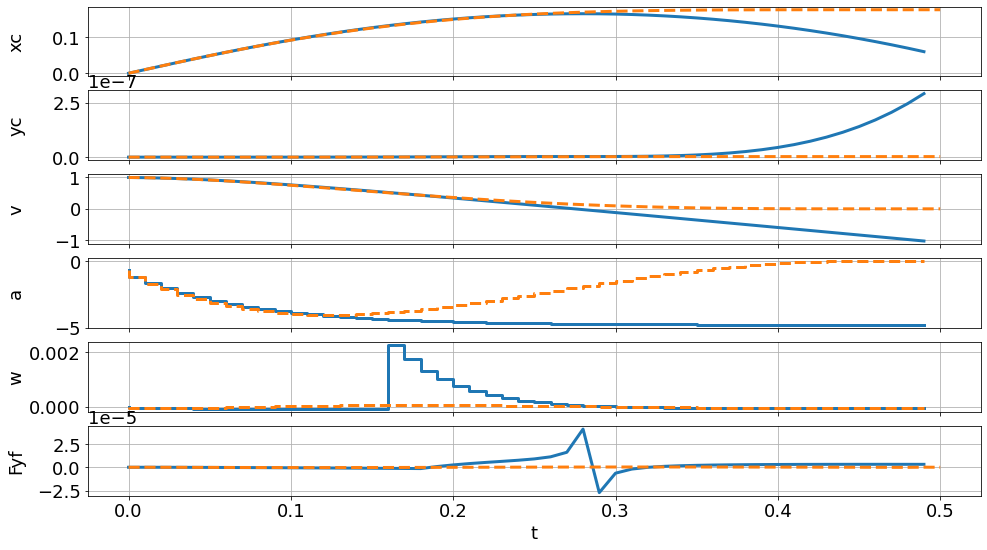

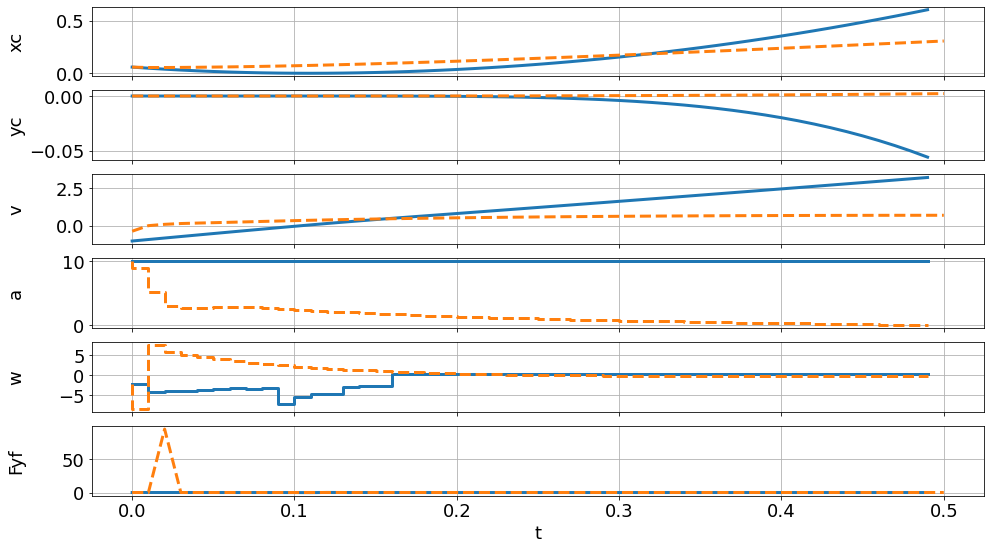

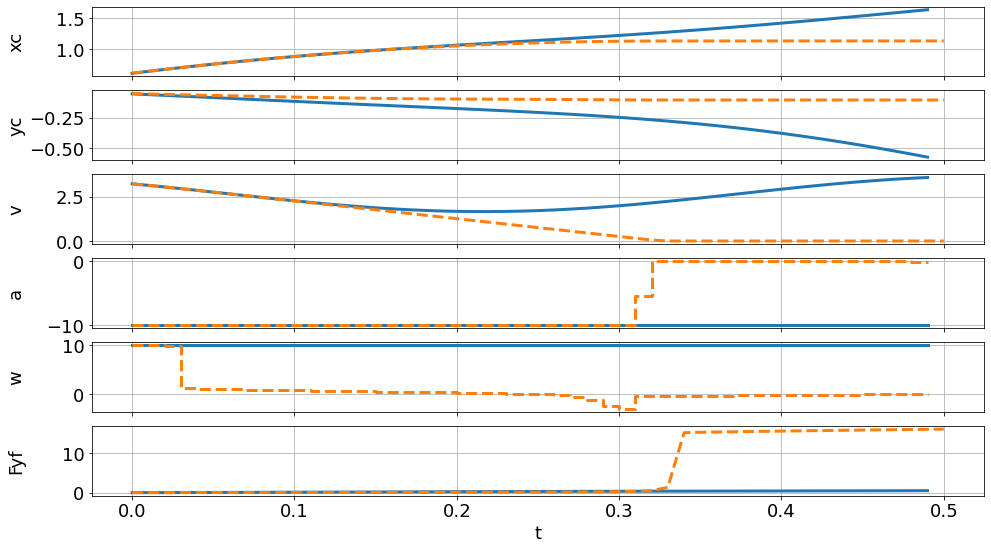

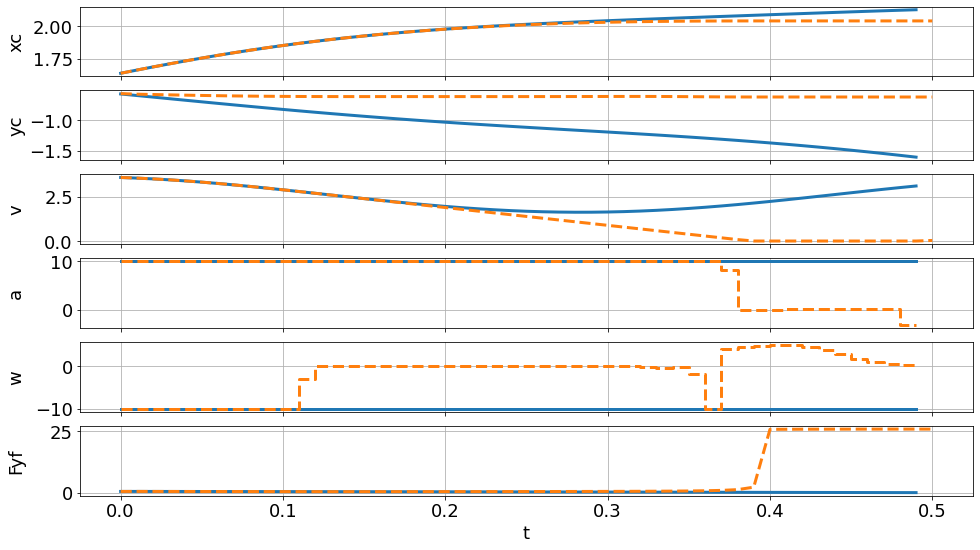

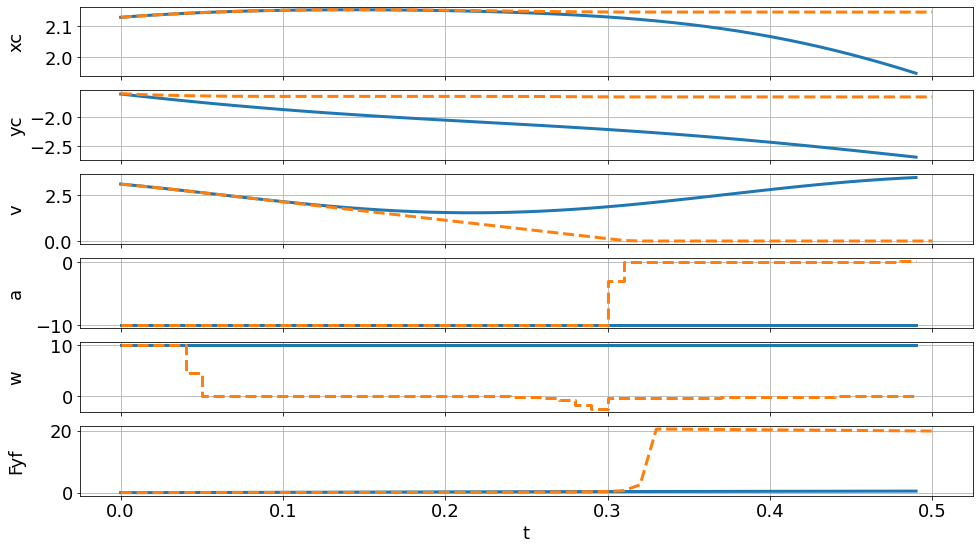

In [18]:
x_0=np.array([[0],[0],[1],[0],[0],[0],[0],[0]])
x=np.zeros((1,1))
y=np.zeros((1,1))
(x_,y_)=control(x_0,0,x,y)

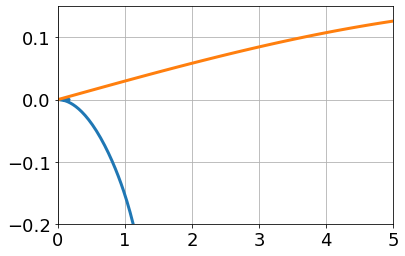

In [19]:
plt.plot(x_,y_)
xl=np.linspace(-7,100,2000)
plt.plot(xl,0.15*np.sin(xl/5))
plt.xlim(0,5)
plt.ylim(-0.2,0.15)
plt.show()